# open problems (task batch correction / label proj)


In [1]:
import pandas as pd
import requests
import json
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
import scanpy as sc
from scprint2 import scPRINT2
from scdataloader import Preprocessor
from scprint2.tasks import Embedder, FinetuneBatchClass
from scprint2.tasks.cell_emb import compute_classification
from scprint2.utils import zero_shot_annotation_with_refinement
import numpy as np
import os

%load_ext autoreload
%autoreload 2

→ connected lamindb: jkobject/scprint2


/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1107: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [2]:
! uv pip list | grep scib #same version as OP

scib                       1.1.7
scib-metrics               0.5.6


In [3]:
LOC = "/pasteur/appa/scratch/jkalfon/data/spcrint_data/"

In [4]:
if not os.path.exists("data/results_batch.json"):
    url = "https://raw.githubusercontent.com/openproblems-bio/website/main/results/batch_integration/data/results.json"
    response = requests.get(url)

    with open("data/results_batch.json", "w") as f:
        f.write(response.text)

if not os.path.exists("data/results_label.json"):
    url = "https://raw.githubusercontent.com/openproblems-bio/website/main/results/label_projection/data/results.json"
    response = requests.get(url)

    with open("data/results_label.json", "w") as f:
        f.write(response.text)

print("File downloaded successfully!")

File downloaded successfully!


In [ ]:
res = {}
with open("data/results_batch.json", "r") as f:
    data_batch = json.load(f)
for dataset in data_batch:
    dataset_id = dataset["dataset_id"]
    if dataset_id not in res:
        res[dataset_id] = {}
    res[dataset_id].update({dataset["method_id"]: dataset["metric_values"]})

In [ ]:
res_label = {}
with open("data/results_label.json", "r") as f:
    data_label = json.load(f)
for dataset in data_label:
    dataset_id = dataset["dataset_id"]
    if dataset_id not in res_label:
        res_label[dataset_id] = {}
    res_label[dataset_id].update({dataset["method_id"]: dataset["metric_values"]})

res_label.keys()

dict_keys(['cellxgene_census/dkd', 'cellxgene_census/gtex_v9', 'cellxgene_census/hypomap', 'cellxgene_census/immune_cell_atlas', 'cellxgene_census/mouse_pancreas_atlas', 'cellxgene_census/tabula_sapiens', None])

In [7]:
pd.DataFrame(res_label["cellxgene_census/dkd"])

,knn,logistic_regression,majority_vote,mlp,naive_bayes,random_labels,scanvi,scanvi_scarches,scgpt_zeroshot,scimilarity,scimilarity_knn,seurat_transferdata,singler,true_labels,uce,xgboost,geneformer,scgpt_finetuned,scprint
accuracy,0.9490,0.9572,0.2954,0.9540,0.9269,0.1808,0.9570,0.9570,0.8486,0.8869,0.9553,0.9541,0.9147,1,0.1813,0.9644,NA,NA,NA
f1_macro,0.9286,0.9413,0.0351,0.9245,0.9181,0.0774,0.9360,0.9366,0.5239,0.6233,0.9292,0.9344,0.9027,1,0.0743,0.9225,NA,NA,NA
f1_micro,0.9490,0.9572,0.2954,0.9540,0.9269,0.1808,0.9570,0.9570,0.8486,0.8869,0.9553,0.9541,0.9147,1,0.1813,0.9644,NA,NA,NA
f1_weighted,0.9487,0.9567,0.1347,0.9529,0.9296,0.1801,0.9579,0.9567,0.8339,0.8655,0.9556,0.9544,0.9192,1,0.1790,0.9634,NA,NA,NA


In [8]:
pd.DataFrame(res["cellxgene_census/dkd"])

,batchelor_fastmnn,batchelor_mnn_correct,bbknn,combat,embed_cell_types,embed_cell_types_jittered,geneformer,harmony,harmonypy,liger,mnnpy,no_integration,no_integration_batch,pyliger,scalex,scanorama,scanvi,scgpt_zeroshot,scimilarity,scvi,shuffle_integration,shuffle_integration_by_batch,shuffle_integration_by_cell_type,uce,scgpt_finetuned,scprint
ari,0.7599,0.757,0.7666,0.7673,1,1,0.0024,0.7867,0.7655,0.7463,0.1674,0.5999,0.2884,0.6633,0.6177,0.2302,0.7806,0.7597,0.7103,0.8284,-0.0001,0.0069,0.5604,0.508,NA,NA
asw_batch,0.894,0.799,NA,0.9123,0.9593,0.9573,0.4736,0.9066,0.905,0.8743,0.8846,0.8913,0.7086,0.8876,0.8582,0.9048,0.9099,0.8888,0.8264,0.9166,0.9426,0.9005,0.9328,0.9286,NA,NA
asw_label,0.6657,0.6657,NA,0.613,0.9897,0.9897,0.364,0.6466,0.6463,0.6295,0.5027,0.6276,0.5116,0.6284,0.5917,0.5009,0.6334,0.6318,0.7111,0.5754,0.4945,0.4895,0.6276,0.587,NA,NA
cell_cycle_conservation,0.8574,0.8692,NA,0.7925,0.8104,0.8099,0.0527,0.8495,0.8466,0.6013,0.3797,0.8248,0.8609,0.4286,0.3481,0.3818,0.6302,0.7563,0.6936,0.5349,0.0667,0.0726,0.7069,0.8451,NA,NA
clisi,1,1,0.9622,0.9997,1,1,0.7461,1,1,0.9991,0.8921,0.9998,0.9968,0.9995,0.9939,0.8857,1,0.9994,0.9997,0.9992,0.7301,0.7424,0.9998,0.999,NA,NA
graph_connectivity,0.9745,0.9696,0.984,0.9728,1,1,0.0109,0.977,0.9765,0.9628,0.5458,0.9701,0.5229,0.968,0.9278,0.5459,0.9962,0.9631,0.971,0.9812,0.2488,0.2596,0.9703,0.9568,NA,NA
hvg_overlap,NA,0.4293,NA,0.6649,NA,NA,NA,NA,NA,NA,0.4056,NA,NA,NA,0.2665,0.2484,NA,NA,NA,NA,0.6462,1,0.668,NA,NA,NA
ilisi,0.272,0.2893,0.3526,0.1644,0.4348,0.4305,0,0.333,0.3319,0.4223,0.1732,0.0754,0.0076,0.4235,0.3097,0.2657,0.3153,0.2272,0.2297,0.303,0.4782,0.0755,0.4322,0.2298,NA,NA
isolated_label_asw,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
isolated_label_f1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [ ]:
model_checkpoint_file = "../models/ji9krimq.ckpt"

In [10]:
model = scPRINT2.load_from_checkpoint(
    model_checkpoint_file, precpt_gene_emb=None, gene_pos_file=None
)
model = model.to("cuda")

FYI: scPrint is not attached to a `Trainer`.


In [ ]:
datasets = {
    "cellxgene_census/dkd": "https://datasets.cellxgene.cziscience.com/46d8d92b-32e0-4ca5-9907-4dbf519c7fc3.h5ad",  # 0.3  ['control_3']
    "cellxgene_census/gtex_v9": "https://datasets.cellxgene.cziscience.com/002308e1-0121-4aa1-b8f2-9d034cf44b0f.h5ad",  # 1gb ['GTEX-16BQI']
    "cellxgene_census/hypomap": "https://datasets.cellxgene.cziscience.com/d3be7423-d664-4913-89a9-a506cae4c28f.h5ad",  # 4gb ['SRR9000488']
    "cellxgene_census/mouse_pancreas_atlas": "https://datasets.cellxgene.cziscience.com/49243c50-bf0c-4b10-87f8-55ec9f455399.h5ad",  # 4gb ['mouse_pancreatic_islet_atlas_Hrovatin__VSG__MUC13639']
    # "cellxgene_census/immune_cell_atlas": "https://datasets.cellxgene.cziscience.com/78819b62-0699-4672-8dc8-d9317b04d255.h5ad",  # 3gb --> issue with scib (too large?)
    # 'cellxgene_census/tabula_sapiens': 'https://datasets.cellxgene.cziscience.com/5a495302-b7cd-4bf9-853e-95627b00bb03.h5ad' # 42gb --> too large for scib
}

test = {
    "cellxgene_census/dkd": ["control_3"],
    "cellxgene_census/gtex_v9": ["GTEX-16BQI"],
    "cellxgene_census/hypomap": ["SRR9000488"],
    "cellxgene_census/mouse_pancreas_atlas": [
        "mouse_pancreatic_islet_atlas_Hrovatin__VSG__MUC13639"
    ],
}

In [ ]:
metrics = {}
metacell = model.expr_emb_style == "metacell"
model.mask_zeros = True

doing  cellxgene_census/immune_cell_atlas


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


predict epoch start



  0%|          | 0/5153 [00:00<?, ?it/s]


  0%|          | 1/5153 [00:25<36:09:18, 25.26s/it]


  0%|          | 2/5153 [00:25<15:00:53, 10.49s/it]


  0%|          | 3/5153 [00:25<8:14:32,  5.76s/it] 


  0%|          | 4/5153 [00:25<5:03:23,  3.54s/it]


  0%|          | 5/5153 [00:25<3:17:44,  2.30s/it]


  0%|          | 6/5153 [00:25<2:14:11,  1.56s/it]


  0%|          | 7/5153 [00:26<1:33:44,  1.09s/it]


  0%|          | 8/5153 [00:26<1:07:12,  1.28it/s]


  0%|          | 9/5153 [00:26<49:30,  1.73it/s]  


  0%|          | 10/5153 [00:26<37:42,  2.27it/s]


  0%|          | 11/5153 [00:26<29:22,  2.92it/s]


  0%|          | 12/5153 [00:26<23:37,  3.63it/s]


  0%|          | 13/5153 [00:26<19:38,  4.36it/s]


  0%|          | 14/5153 [00:26<16:55,  5.06it/s]


  0%|          | 15/5153 [00:27<14:58,  5.72it/s]


  0%|          | 16/5153 [00:27<13:36,  6.29it/s]


  0%|          | 17/5153 [00:27<13:44,  6.23it/s]


  0%|          | 18/5153 [00:27<12:48,  6.68it/s]


  0%|          | 19/5153 [00:27<12:09,  7.04it/s]


  0%|          | 20/5153 [00:27<11:41,  7.32it/s]


  0%|          | 21/5153 [00:27<11:25,  7.49it/s]


  0%|          | 22/5153 [00:27<11:12,  7.63it/s]


  0%|          | 23/5153 [00:28<11:02,  7.74it/s]


  0%|          | 24/5153 [00:28<10:55,  7.83it/s]


  0%|          | 25/5153 [00:28<10:49,  7.89it/s]


  1%|          | 26/5153 [00:28<10:47,  7.92it/s]


  1%|          | 27/5153 [00:28<10:46,  7.93it/s]


  1%|          | 28/5153 [00:28<10:46,  7.93it/s]


  1%|          | 29/5153 [00:28<10:45,  7.94it/s]


  1%|          | 30/5153 [00:28<10:43,  7.96it/s]


  1%|          | 31/5153 [00:29<10:41,  7.98it/s]


  1%|          | 32/5153 [00:29<10:40,  8.00it/s]


  1%|          | 33/5153 [00:29<10:38,  8.01it/s]


  1%|          | 34/5153 [00:29<10:38,  8.02it/s]


  1%|          | 35/5153 [00:29<10:37,  8.03it/s]


  1%|          | 36/5153 [00:29<10:37,  8.03it/s]


  1%|          | 37/5153 [00:29<10:37,  8.03it/s]


  1%|          | 38/5153 [00:29<10:36,  8.03it/s]


  1%|          | 39/5153 [00:30<10:36,  8.04it/s]


  1%|          | 40/5153 [00:30<10:36,  8.03it/s]


  1%|          | 41/5153 [00:30<10:36,  8.03it/s]


  1%|          | 42/5153 [00:30<10:38,  8.01it/s]


  1%|          | 43/5153 [00:30<10:37,  8.02it/s]


  1%|          | 44/5153 [00:30<10:37,  8.01it/s]


  1%|          | 45/5153 [00:30<10:37,  8.02it/s]


  1%|          | 46/5153 [00:30<11:22,  7.48it/s]


  1%|          | 47/5153 [00:31<11:08,  7.64it/s]


  1%|          | 48/5153 [00:31<10:57,  7.76it/s]


  1%|          | 49/5153 [00:31<10:51,  7.84it/s]


  1%|          | 50/5153 [00:31<10:46,  7.89it/s]


  1%|          | 51/5153 [00:31<10:43,  7.93it/s]


  1%|          | 52/5153 [00:31<10:42,  7.94it/s]


  1%|          | 53/5153 [00:31<10:40,  7.97it/s]


  1%|          | 54/5153 [00:31<10:39,  7.98it/s]


  1%|          | 55/5153 [00:32<10:37,  7.99it/s]


  1%|          | 56/5153 [00:32<10:36,  8.00it/s]


  1%|          | 57/5153 [00:32<10:36,  8.01it/s]


  1%|          | 58/5153 [00:32<10:37,  7.99it/s]


  1%|          | 59/5153 [00:32<10:36,  8.00it/s]


  1%|          | 60/5153 [00:32<10:35,  8.01it/s]


  1%|          | 61/5153 [00:32<10:35,  8.02it/s]


  1%|          | 62/5153 [00:32<10:36,  8.00it/s]


  1%|          | 63/5153 [00:33<10:35,  8.01it/s]


  1%|          | 64/5153 [00:33<10:37,  7.99it/s]


  1%|▏         | 65/5153 [00:33<10:36,  7.99it/s]


  1%|▏         | 66/5153 [00:33<10:36,  8.00it/s]


  1%|▏         | 67/5153 [00:33<10:35,  8.00it/s]


  1%|▏         | 68/5153 [00:33<10:34,  8.02it/s]


  1%|▏         | 69/5153 [00:33<10:34,  8.01it/s]


  1%|▏         | 70/5153 [00:33<10:34,  8.00it/s]


  1%|▏         | 71/5153 [00:34<10:34,  8.01it/s]


  1%|▏         | 72/5153 [00:34<10:34,  8.00it/s]


  1%|▏         | 73/5153 [00:34<10:34,  8.00it/s]


  1%|▏         | 74/5153 [00:34<10:35,  8.00it/s]


  1%|▏         | 75/5153 [00:34<10:34,  8.00it/s]


  1%|▏         | 76/5153 [00:34<10:36,  7.98it/s]


  1%|▏         | 77/5153 [00:34<10:35,  7.99it/s]


  2%|▏         | 78/5153 [00:34<10:34,  7.99it/s]


  2%|▏         | 79/5153 [00:35<10:36,  7.97it/s]


  2%|▏         | 80/5153 [00:35<10:37,  7.96it/s]


  2%|▏         | 81/5153 [00:35<10:37,  7.96it/s]


  2%|▏         | 82/5153 [00:35<10:37,  7.96it/s]


  2%|▏         | 83/5153 [00:35<10:36,  7.96it/s]


  2%|▏         | 84/5153 [00:35<10:35,  7.97it/s]


  2%|▏         | 85/5153 [00:35<10:36,  7.96it/s]


  2%|▏         | 86/5153 [00:35<10:37,  7.94it/s]


  2%|▏         | 87/5153 [00:36<10:38,  7.94it/s]


  2%|▏         | 88/5153 [00:36<10:38,  7.93it/s]


  2%|▏         | 89/5153 [00:36<11:16,  7.49it/s]


  2%|▏         | 90/5153 [00:36<11:05,  7.61it/s]


  2%|▏         | 91/5153 [00:36<10:55,  7.72it/s]


  2%|▏         | 92/5153 [00:36<10:48,  7.81it/s]


  2%|▏         | 93/5153 [00:36<10:44,  7.85it/s]


  2%|▏         | 94/5153 [00:37<10:42,  7.87it/s]


  2%|▏         | 95/5153 [00:37<10:39,  7.91it/s]


  2%|▏         | 96/5153 [00:37<10:39,  7.91it/s]


  2%|▏         | 97/5153 [00:37<10:37,  7.93it/s]


  2%|▏         | 98/5153 [00:37<10:37,  7.93it/s]


  2%|▏         | 99/5153 [00:37<10:36,  7.94it/s]


  2%|▏         | 100/5153 [00:37<10:35,  7.95it/s]


  2%|▏         | 101/5153 [00:37<10:33,  7.97it/s]


  2%|▏         | 102/5153 [00:38<10:47,  7.81it/s]


  2%|▏         | 103/5153 [00:38<10:44,  7.83it/s]


  2%|▏         | 104/5153 [00:38<10:40,  7.88it/s]


  2%|▏         | 105/5153 [00:38<10:37,  7.92it/s]


  2%|▏         | 106/5153 [00:38<10:35,  7.94it/s]


  2%|▏         | 107/5153 [00:38<10:33,  7.96it/s]


  2%|▏         | 108/5153 [00:38<10:33,  7.96it/s]


  2%|▏         | 109/5153 [00:38<10:35,  7.94it/s]


  2%|▏         | 110/5153 [00:39<10:35,  7.94it/s]


  2%|▏         | 111/5153 [00:39<10:34,  7.94it/s]


  2%|▏         | 112/5153 [00:39<10:35,  7.93it/s]


  2%|▏         | 113/5153 [00:39<10:34,  7.95it/s]


  2%|▏         | 114/5153 [00:39<10:34,  7.94it/s]


  2%|▏         | 115/5153 [00:39<10:33,  7.95it/s]


  2%|▏         | 116/5153 [00:39<10:35,  7.93it/s]


  2%|▏         | 117/5153 [00:39<10:35,  7.93it/s]


  2%|▏         | 118/5153 [00:40<10:34,  7.94it/s]


  2%|▏         | 119/5153 [00:40<10:33,  7.95it/s]


  2%|▏         | 120/5153 [00:40<10:32,  7.96it/s]


  2%|▏         | 121/5153 [00:40<10:32,  7.95it/s]


  2%|▏         | 122/5153 [00:40<10:32,  7.96it/s]


  2%|▏         | 123/5153 [00:40<10:31,  7.97it/s]


  2%|▏         | 124/5153 [00:40<10:32,  7.95it/s]


  2%|▏         | 125/5153 [00:40<10:34,  7.93it/s]


  2%|▏         | 126/5153 [00:41<10:33,  7.93it/s]


  2%|▏         | 127/5153 [00:41<10:31,  7.96it/s]


  2%|▏         | 128/5153 [00:41<10:32,  7.94it/s]


  3%|▎         | 129/5153 [00:41<10:31,  7.95it/s]


  3%|▎         | 130/5153 [00:41<10:32,  7.95it/s]


  3%|▎         | 131/5153 [00:41<10:31,  7.95it/s]


  3%|▎         | 132/5153 [00:41<10:31,  7.96it/s]


  3%|▎         | 133/5153 [00:41<10:30,  7.97it/s]


  3%|▎         | 134/5153 [00:42<10:30,  7.96it/s]


  3%|▎         | 135/5153 [00:42<10:27,  7.99it/s]


  3%|▎         | 136/5153 [00:42<10:28,  7.98it/s]


  3%|▎         | 137/5153 [00:42<11:07,  7.52it/s]


  3%|▎         | 138/5153 [00:42<10:56,  7.64it/s]


  3%|▎         | 139/5153 [00:42<10:50,  7.71it/s]


  3%|▎         | 140/5153 [00:42<10:44,  7.77it/s]


  3%|▎         | 141/5153 [00:42<10:39,  7.83it/s]


  3%|▎         | 142/5153 [00:43<10:37,  7.86it/s]


  3%|▎         | 143/5153 [00:43<10:35,  7.88it/s]


  3%|▎         | 144/5153 [00:43<10:33,  7.90it/s]


  3%|▎         | 145/5153 [00:43<10:32,  7.91it/s]


  3%|▎         | 146/5153 [00:43<10:31,  7.92it/s]


  3%|▎         | 147/5153 [00:43<10:31,  7.92it/s]


  3%|▎         | 148/5153 [00:45<56:45,  1.47it/s]


  3%|▎         | 149/5153 [00:45<42:42,  1.95it/s]


  3%|▎         | 150/5153 [00:45<33:01,  2.52it/s]


  3%|▎         | 151/5153 [00:46<26:13,  3.18it/s]


  3%|▎         | 152/5153 [00:46<21:28,  3.88it/s]


  3%|▎         | 153/5153 [00:46<18:09,  4.59it/s]


  3%|▎         | 154/5153 [00:46<15:49,  5.26it/s]


  3%|▎         | 155/5153 [00:46<14:12,  5.86it/s]


  3%|▎         | 156/5153 [00:46<13:03,  6.38it/s]


  3%|▎         | 157/5153 [00:46<12:15,  6.79it/s]


  3%|▎         | 158/5153 [00:46<11:43,  7.10it/s]


  3%|▎         | 159/5153 [00:47<11:22,  7.32it/s]


  3%|▎         | 160/5153 [00:47<11:04,  7.51it/s]


  3%|▎         | 161/5153 [00:47<22:23,  3.72it/s]


  3%|▎         | 162/5153 [00:47<18:47,  4.43it/s]


  3%|▎         | 163/5153 [00:48<16:16,  5.11it/s]


  3%|▎         | 164/5153 [00:48<14:30,  5.73it/s]


  3%|▎         | 165/5153 [00:48<13:17,  6.26it/s]


  3%|▎         | 166/5153 [00:48<12:26,  6.68it/s]


  3%|▎         | 167/5153 [00:48<11:49,  7.02it/s]


  3%|▎         | 168/5153 [00:48<11:24,  7.28it/s]


  3%|▎         | 169/5153 [00:49<33:03,  2.51it/s]


  3%|▎         | 170/5153 [00:49<26:12,  3.17it/s]


  3%|▎         | 171/5153 [00:49<21:30,  3.86it/s]


  3%|▎         | 172/5153 [00:50<18:07,  4.58it/s]


  3%|▎         | 173/5153 [00:50<15:47,  5.26it/s]


  3%|▎         | 174/5153 [00:50<14:07,  5.88it/s]


  3%|▎         | 175/5153 [00:50<12:58,  6.39it/s]


  3%|▎         | 176/5153 [00:50<12:09,  6.82it/s]


  3%|▎         | 177/5153 [00:51<33:12,  2.50it/s]


  3%|▎         | 178/5153 [00:51<26:26,  3.14it/s]


  3%|▎         | 179/5153 [00:51<21:34,  3.84it/s]


  3%|▎         | 180/5153 [00:51<18:10,  4.56it/s]


  4%|▎         | 181/5153 [00:52<15:47,  5.25it/s]


  4%|▎         | 182/5153 [00:52<14:07,  5.87it/s]


  4%|▎         | 183/5153 [00:52<12:56,  6.40it/s]


  4%|▎         | 184/5153 [00:52<12:07,  6.83it/s]


  4%|▎         | 185/5153 [00:52<11:35,  7.14it/s]


  4%|▎         | 186/5153 [00:53<30:12,  2.74it/s]


  4%|▎         | 187/5153 [00:53<24:25,  3.39it/s]


  4%|▎         | 188/5153 [00:53<20:08,  4.11it/s]


  4%|▎         | 189/5153 [00:53<17:08,  4.83it/s]


  4%|▎         | 190/5153 [00:53<15:03,  5.49it/s]


  4%|▎         | 191/5153 [00:54<13:35,  6.08it/s]


  4%|▎         | 192/5153 [00:54<12:35,  6.57it/s]


  4%|▎         | 193/5153 [00:54<11:55,  6.93it/s]


  4%|▍         | 194/5153 [00:54<11:28,  7.21it/s]


  4%|▍         | 195/5153 [00:55<30:29,  2.71it/s]


  4%|▍         | 196/5153 [00:55<24:36,  3.36it/s]


  4%|▍         | 197/5153 [00:55<20:16,  4.07it/s]


  4%|▍         | 198/5153 [00:55<17:14,  4.79it/s]


  4%|▍         | 199/5153 [00:55<15:07,  5.46it/s]


  4%|▍         | 200/5153 [00:55<13:38,  6.05it/s]


  4%|▍         | 201/5153 [00:56<12:36,  6.55it/s]


  4%|▍         | 202/5153 [00:56<11:52,  6.95it/s]


  4%|▍         | 203/5153 [00:56<11:25,  7.22it/s]


  4%|▍         | 204/5153 [00:57<26:33,  3.11it/s]


  4%|▍         | 205/5153 [00:57<21:49,  3.78it/s]


  4%|▍         | 206/5153 [00:57<18:20,  4.50it/s]


  4%|▍         | 207/5153 [00:57<15:53,  5.19it/s]


  4%|▍         | 208/5153 [00:57<14:10,  5.82it/s]


  4%|▍         | 209/5153 [00:57<12:57,  6.36it/s]


  4%|▍         | 210/5153 [00:57<12:07,  6.80it/s]


  4%|▍         | 211/5153 [00:57<11:34,  7.12it/s]


  4%|▍         | 212/5153 [00:58<11:12,  7.35it/s]


  4%|▍         | 213/5153 [00:58<25:48,  3.19it/s]


  4%|▍         | 214/5153 [00:58<21:57,  3.75it/s]


  4%|▍         | 215/5153 [00:59<18:25,  4.47it/s]


  4%|▍         | 216/5153 [00:59<15:56,  5.16it/s]


  4%|▍         | 217/5153 [00:59<14:11,  5.80it/s]


  4%|▍         | 218/5153 [00:59<12:57,  6.34it/s]


  4%|▍         | 219/5153 [00:59<12:07,  6.78it/s]


  4%|▍         | 220/5153 [00:59<11:32,  7.13it/s]


  4%|▍         | 221/5153 [00:59<11:10,  7.36it/s]


  4%|▍         | 222/5153 [01:00<24:31,  3.35it/s]


  4%|▍         | 223/5153 [01:00<20:21,  4.04it/s]


  4%|▍         | 224/5153 [01:00<17:17,  4.75it/s]


  4%|▍         | 225/5153 [01:00<15:08,  5.42it/s]


  4%|▍         | 226/5153 [01:00<13:38,  6.02it/s]


  4%|▍         | 227/5153 [01:01<12:35,  6.52it/s]


  4%|▍         | 228/5153 [01:01<11:51,  6.92it/s]


  4%|▍         | 229/5153 [01:01<11:24,  7.19it/s]


  4%|▍         | 230/5153 [01:01<11:05,  7.39it/s]


  4%|▍         | 231/5153 [01:01<10:53,  7.54it/s]


  5%|▍         | 232/5153 [01:01<15:25,  5.32it/s]


  5%|▍         | 233/5153 [01:02<13:49,  5.93it/s]


  5%|▍         | 234/5153 [01:02<12:42,  6.45it/s]


  5%|▍         | 235/5153 [01:02<11:56,  6.87it/s]


  5%|▍         | 236/5153 [01:02<11:22,  7.21it/s]


  5%|▍         | 237/5153 [01:02<10:59,  7.46it/s]


  5%|▍         | 238/5153 [01:02<10:45,  7.61it/s]


  5%|▍         | 239/5153 [01:02<10:37,  7.71it/s]


  5%|▍         | 240/5153 [01:02<10:34,  7.74it/s]


  5%|▍         | 241/5153 [01:03<10:26,  7.84it/s]


  5%|▍         | 242/5153 [01:03<10:19,  7.93it/s]


  5%|▍         | 243/5153 [01:03<10:18,  7.93it/s]


  5%|▍         | 244/5153 [01:03<10:18,  7.93it/s]


  5%|▍         | 245/5153 [01:03<10:18,  7.93it/s]


  5%|▍         | 246/5153 [01:03<10:17,  7.94it/s]


  5%|▍         | 247/5153 [01:03<10:17,  7.94it/s]


  5%|▍         | 248/5153 [01:03<10:17,  7.94it/s]


  5%|▍         | 249/5153 [01:04<10:17,  7.94it/s]


  5%|▍         | 250/5153 [01:04<10:17,  7.94it/s]


  5%|▍         | 251/5153 [01:04<10:16,  7.95it/s]


  5%|▍         | 252/5153 [01:04<10:16,  7.95it/s]


  5%|▍         | 253/5153 [01:04<10:16,  7.95it/s]


  5%|▍         | 254/5153 [01:04<10:16,  7.94it/s]


  5%|▍         | 255/5153 [01:04<10:17,  7.93it/s]


  5%|▍         | 256/5153 [01:04<10:15,  7.95it/s]


  5%|▍         | 257/5153 [01:05<10:13,  7.97it/s]


  5%|▌         | 258/5153 [01:05<10:12,  8.00it/s]


  5%|▌         | 259/5153 [01:05<10:13,  7.98it/s]


  5%|▌         | 260/5153 [01:05<10:13,  7.97it/s]


  5%|▌         | 261/5153 [01:05<10:13,  7.97it/s]


  5%|▌         | 262/5153 [01:05<10:14,  7.96it/s]


  5%|▌         | 263/5153 [01:05<10:14,  7.96it/s]


  5%|▌         | 264/5153 [01:05<10:13,  7.97it/s]


  5%|▌         | 265/5153 [01:06<10:13,  7.97it/s]


  5%|▌         | 266/5153 [01:06<10:11,  7.99it/s]


  5%|▌         | 267/5153 [01:06<10:11,  7.99it/s]


  5%|▌         | 268/5153 [01:06<10:12,  7.98it/s]


  5%|▌         | 269/5153 [01:06<10:12,  7.97it/s]


  5%|▌         | 270/5153 [01:06<10:12,  7.97it/s]


  5%|▌         | 271/5153 [01:06<10:12,  7.97it/s]


  5%|▌         | 272/5153 [01:06<10:11,  7.98it/s]


  5%|▌         | 273/5153 [01:07<10:11,  7.98it/s]


  5%|▌         | 274/5153 [01:07<10:11,  7.98it/s]


  5%|▌         | 275/5153 [01:07<10:12,  7.97it/s]


  5%|▌         | 276/5153 [01:07<10:12,  7.96it/s]


  5%|▌         | 277/5153 [01:07<10:12,  7.96it/s]


  5%|▌         | 278/5153 [01:07<10:13,  7.94it/s]


  5%|▌         | 279/5153 [01:07<10:13,  7.94it/s]


  5%|▌         | 280/5153 [01:07<10:13,  7.94it/s]


  5%|▌         | 281/5153 [01:08<10:11,  7.96it/s]


  5%|▌         | 282/5153 [01:08<10:12,  7.96it/s]


  5%|▌         | 283/5153 [01:08<10:10,  7.98it/s]


  6%|▌         | 284/5153 [01:08<10:10,  7.97it/s]


  6%|▌         | 285/5153 [01:08<10:11,  7.96it/s]


  6%|▌         | 286/5153 [01:08<10:12,  7.95it/s]


  6%|▌         | 287/5153 [01:08<10:12,  7.95it/s]


  6%|▌         | 288/5153 [01:08<10:13,  7.93it/s]


  6%|▌         | 289/5153 [01:09<10:12,  7.95it/s]


  6%|▌         | 290/5153 [01:09<10:11,  7.95it/s]


  6%|▌         | 291/5153 [01:09<10:10,  7.96it/s]


  6%|▌         | 292/5153 [01:09<10:11,  7.95it/s]


  6%|▌         | 293/5153 [01:09<10:11,  7.95it/s]


  6%|▌         | 294/5153 [01:09<10:11,  7.94it/s]


  6%|▌         | 295/5153 [01:09<10:10,  7.95it/s]


  6%|▌         | 296/5153 [01:09<10:10,  7.95it/s]


  6%|▌         | 297/5153 [01:10<10:11,  7.94it/s]


  6%|▌         | 298/5153 [01:10<10:11,  7.94it/s]


  6%|▌         | 299/5153 [01:10<10:09,  7.97it/s]


  6%|▌         | 300/5153 [01:10<10:07,  7.98it/s]


  6%|▌         | 301/5153 [01:10<10:09,  7.97it/s]


  6%|▌         | 302/5153 [01:10<10:09,  7.95it/s]


  6%|▌         | 303/5153 [01:10<10:11,  7.93it/s]


  6%|▌         | 304/5153 [01:10<10:10,  7.94it/s]


  6%|▌         | 305/5153 [01:11<10:09,  7.96it/s]


  6%|▌         | 306/5153 [01:11<10:09,  7.96it/s]


  6%|▌         | 307/5153 [01:11<10:08,  7.97it/s]


  6%|▌         | 308/5153 [01:11<10:07,  7.98it/s]


  6%|▌         | 309/5153 [01:11<10:06,  7.99it/s]


  6%|▌         | 310/5153 [01:11<10:07,  7.97it/s]


  6%|▌         | 311/5153 [01:11<10:07,  7.97it/s]


  6%|▌         | 312/5153 [01:11<10:08,  7.96it/s]


  6%|▌         | 313/5153 [01:12<10:08,  7.95it/s]


  6%|▌         | 314/5153 [01:12<10:07,  7.96it/s]


  6%|▌         | 315/5153 [01:12<10:06,  7.97it/s]


  6%|▌         | 316/5153 [01:12<10:07,  7.96it/s]


  6%|▌         | 317/5153 [01:12<10:09,  7.93it/s]


  6%|▌         | 318/5153 [01:12<10:10,  7.92it/s]


  6%|▌         | 319/5153 [01:12<10:10,  7.92it/s]


  6%|▌         | 320/5153 [01:12<10:10,  7.92it/s]


  6%|▌         | 321/5153 [01:13<10:09,  7.93it/s]


  6%|▌         | 322/5153 [01:13<10:09,  7.92it/s]


  6%|▋         | 323/5153 [01:13<10:08,  7.93it/s]


  6%|▋         | 324/5153 [01:13<10:09,  7.92it/s]


  6%|▋         | 325/5153 [01:13<10:10,  7.91it/s]


  6%|▋         | 326/5153 [01:13<10:10,  7.91it/s]


  6%|▋         | 327/5153 [01:13<10:08,  7.93it/s]


  6%|▋         | 328/5153 [01:13<10:08,  7.93it/s]


  6%|▋         | 329/5153 [01:14<10:06,  7.96it/s]


  6%|▋         | 330/5153 [01:14<10:05,  7.97it/s]


  6%|▋         | 331/5153 [01:14<10:05,  7.97it/s]


  6%|▋         | 332/5153 [01:14<10:06,  7.95it/s]


  6%|▋         | 333/5153 [01:14<10:06,  7.95it/s]


  6%|▋         | 334/5153 [01:14<10:06,  7.95it/s]


  7%|▋         | 335/5153 [01:14<10:06,  7.94it/s]


  7%|▋         | 336/5153 [01:14<10:07,  7.94it/s]


  7%|▋         | 337/5153 [01:15<10:05,  7.95it/s]


  7%|▋         | 338/5153 [01:15<10:04,  7.96it/s]


  7%|▋         | 339/5153 [01:15<10:05,  7.95it/s]


  7%|▋         | 340/5153 [01:15<10:06,  7.93it/s]


  7%|▋         | 341/5153 [01:15<10:06,  7.93it/s]


  7%|▋         | 342/5153 [01:15<10:07,  7.92it/s]


  7%|▋         | 343/5153 [01:15<10:07,  7.92it/s]


  7%|▋         | 344/5153 [01:15<10:05,  7.94it/s]


  7%|▋         | 345/5153 [01:16<10:03,  7.96it/s]


  7%|▋         | 346/5153 [01:16<10:03,  7.97it/s]


  7%|▋         | 347/5153 [01:16<10:02,  7.97it/s]


  7%|▋         | 348/5153 [01:16<10:04,  7.95it/s]


  7%|▋         | 349/5153 [01:16<10:04,  7.94it/s]


  7%|▋         | 350/5153 [01:16<10:05,  7.93it/s]


  7%|▋         | 351/5153 [01:16<10:04,  7.95it/s]


  7%|▋         | 352/5153 [01:16<10:03,  7.96it/s]


  7%|▋         | 353/5153 [01:17<10:02,  7.96it/s]


  7%|▋         | 354/5153 [01:17<10:02,  7.97it/s]


  7%|▋         | 355/5153 [01:17<10:03,  7.95it/s]


  7%|▋         | 356/5153 [01:17<10:04,  7.93it/s]


  7%|▋         | 357/5153 [01:17<10:05,  7.93it/s]


  7%|▋         | 358/5153 [01:17<10:05,  7.91it/s]


  7%|▋         | 359/5153 [01:17<10:04,  7.93it/s]


  7%|▋         | 360/5153 [01:17<10:02,  7.96it/s]


  7%|▋         | 361/5153 [01:18<10:01,  7.97it/s]


  7%|▋         | 362/5153 [01:18<10:02,  7.95it/s]


  7%|▋         | 363/5153 [01:18<10:03,  7.93it/s]


  7%|▋         | 364/5153 [01:18<10:04,  7.92it/s]


  7%|▋         | 365/5153 [01:18<10:04,  7.91it/s]


  7%|▋         | 366/5153 [01:18<10:05,  7.91it/s]


  7%|▋         | 367/5153 [01:18<10:06,  7.89it/s]


  7%|▋         | 368/5153 [01:19<10:04,  7.92it/s]


  7%|▋         | 369/5153 [01:19<10:04,  7.91it/s]


  7%|▋         | 370/5153 [01:19<10:04,  7.91it/s]


  7%|▋         | 371/5153 [01:19<10:04,  7.91it/s]


  7%|▋         | 372/5153 [01:19<10:04,  7.91it/s]


  7%|▋         | 373/5153 [01:19<10:04,  7.91it/s]


  7%|▋         | 374/5153 [01:19<10:04,  7.91it/s]


  7%|▋         | 375/5153 [01:19<10:04,  7.90it/s]


  7%|▋         | 376/5153 [01:20<10:02,  7.93it/s]


  7%|▋         | 377/5153 [01:20<10:03,  7.91it/s]


  7%|▋         | 378/5153 [01:20<10:04,  7.90it/s]


  7%|▋         | 379/5153 [01:20<10:06,  7.87it/s]


  7%|▋         | 380/5153 [01:20<10:06,  7.87it/s]


  7%|▋         | 381/5153 [01:20<10:06,  7.87it/s]


  7%|▋         | 382/5153 [01:20<10:06,  7.87it/s]


  7%|▋         | 383/5153 [01:20<10:05,  7.88it/s]


  7%|▋         | 384/5153 [01:21<10:05,  7.88it/s]


  7%|▋         | 385/5153 [01:21<10:15,  7.75it/s]


  7%|▋         | 386/5153 [01:21<10:09,  7.82it/s]


  8%|▊         | 387/5153 [01:21<10:05,  7.87it/s]


  8%|▊         | 388/5153 [01:21<10:03,  7.89it/s]


  8%|▊         | 389/5153 [01:21<10:01,  7.92it/s]


  8%|▊         | 390/5153 [01:21<10:01,  7.91it/s]


  8%|▊         | 391/5153 [01:21<10:01,  7.91it/s]


  8%|▊         | 392/5153 [01:22<10:01,  7.92it/s]


  8%|▊         | 393/5153 [01:22<10:00,  7.93it/s]


  8%|▊         | 394/5153 [01:22<10:03,  7.88it/s]


  8%|▊         | 395/5153 [01:22<10:02,  7.90it/s]


  8%|▊         | 396/5153 [01:22<10:01,  7.90it/s]


  8%|▊         | 397/5153 [01:22<10:01,  7.90it/s]


  8%|▊         | 398/5153 [01:22<10:01,  7.90it/s]


  8%|▊         | 399/5153 [01:22<10:00,  7.91it/s]


  8%|▊         | 400/5153 [01:23<09:58,  7.94it/s]


  8%|▊         | 401/5153 [01:23<09:58,  7.94it/s]


  8%|▊         | 402/5153 [01:23<09:57,  7.96it/s]


  8%|▊         | 403/5153 [01:23<09:57,  7.94it/s]


  8%|▊         | 404/5153 [01:23<09:58,  7.94it/s]


  8%|▊         | 405/5153 [01:23<09:59,  7.92it/s]


  8%|▊         | 406/5153 [01:23<09:59,  7.92it/s]


  8%|▊         | 407/5153 [01:23<09:58,  7.93it/s]


  8%|▊         | 408/5153 [01:24<09:56,  7.95it/s]


  8%|▊         | 409/5153 [01:24<09:57,  7.94it/s]


  8%|▊         | 410/5153 [01:24<09:57,  7.94it/s]


  8%|▊         | 411/5153 [01:24<09:57,  7.94it/s]


  8%|▊         | 412/5153 [01:24<09:57,  7.94it/s]


  8%|▊         | 413/5153 [01:24<09:57,  7.93it/s]


  8%|▊         | 414/5153 [01:24<09:58,  7.92it/s]


  8%|▊         | 415/5153 [01:24<09:59,  7.90it/s]


  8%|▊         | 416/5153 [01:25<09:58,  7.91it/s]


  8%|▊         | 417/5153 [01:25<09:58,  7.92it/s]


  8%|▊         | 418/5153 [01:25<09:57,  7.93it/s]


  8%|▊         | 419/5153 [01:25<09:57,  7.92it/s]


  8%|▊         | 420/5153 [01:25<09:56,  7.93it/s]


  8%|▊         | 421/5153 [01:25<09:56,  7.93it/s]


  8%|▊         | 422/5153 [01:25<09:56,  7.93it/s]


  8%|▊         | 423/5153 [01:25<09:56,  7.93it/s]


  8%|▊         | 424/5153 [01:26<09:55,  7.94it/s]


  8%|▊         | 425/5153 [01:26<09:55,  7.94it/s]


  8%|▊         | 426/5153 [01:26<09:59,  7.88it/s]


  8%|▊         | 427/5153 [01:26<09:58,  7.90it/s]


  8%|▊         | 428/5153 [01:26<09:57,  7.91it/s]


  8%|▊         | 429/5153 [01:26<09:57,  7.91it/s]


  8%|▊         | 430/5153 [01:26<09:56,  7.91it/s]


  8%|▊         | 431/5153 [01:26<09:56,  7.91it/s]


  8%|▊         | 432/5153 [01:27<09:55,  7.92it/s]


  8%|▊         | 433/5153 [01:27<10:22,  7.58it/s]


  8%|▊         | 434/5153 [01:27<10:14,  7.68it/s]


  8%|▊         | 435/5153 [01:27<10:08,  7.76it/s]


  8%|▊         | 436/5153 [01:27<10:03,  7.81it/s]


  8%|▊         | 437/5153 [01:27<10:00,  7.85it/s]


  8%|▊         | 438/5153 [01:27<10:00,  7.85it/s]


  9%|▊         | 439/5153 [01:28<09:59,  7.86it/s]


  9%|▊         | 440/5153 [01:28<09:57,  7.89it/s]


  9%|▊         | 441/5153 [01:28<09:56,  7.90it/s]


  9%|▊         | 442/5153 [01:28<09:55,  7.91it/s]


  9%|▊         | 443/5153 [01:28<09:54,  7.92it/s]


  9%|▊         | 444/5153 [01:28<09:54,  7.92it/s]


  9%|▊         | 445/5153 [01:28<09:54,  7.92it/s]


  9%|▊         | 446/5153 [01:28<09:54,  7.92it/s]


  9%|▊         | 447/5153 [01:29<09:55,  7.91it/s]


  9%|▊         | 448/5153 [01:29<09:54,  7.92it/s]


  9%|▊         | 449/5153 [01:29<09:52,  7.94it/s]


  9%|▊         | 450/5153 [01:29<09:49,  7.98it/s]


  9%|▉         | 451/5153 [01:29<09:49,  7.98it/s]


  9%|▉         | 452/5153 [01:29<09:52,  7.94it/s]


  9%|▉         | 453/5153 [01:29<09:53,  7.92it/s]


  9%|▉         | 454/5153 [01:29<09:55,  7.90it/s]


  9%|▉         | 455/5153 [01:30<09:55,  7.90it/s]


  9%|▉         | 456/5153 [01:30<09:53,  7.92it/s]


  9%|▉         | 457/5153 [01:30<09:51,  7.94it/s]


  9%|▉         | 458/5153 [01:30<09:52,  7.92it/s]


  9%|▉         | 459/5153 [01:30<09:53,  7.91it/s]


  9%|▉         | 460/5153 [01:30<09:53,  7.90it/s]


  9%|▉         | 461/5153 [01:30<09:52,  7.92it/s]


  9%|▉         | 462/5153 [01:30<09:52,  7.92it/s]


  9%|▉         | 463/5153 [01:31<09:51,  7.93it/s]


  9%|▉         | 464/5153 [01:31<09:50,  7.94it/s]


  9%|▉         | 465/5153 [01:31<09:49,  7.95it/s]


  9%|▉         | 466/5153 [01:31<09:48,  7.96it/s]


  9%|▉         | 467/5153 [01:31<09:48,  7.96it/s]


  9%|▉         | 468/5153 [01:31<09:50,  7.93it/s]


  9%|▉         | 469/5153 [01:31<09:51,  7.92it/s]


  9%|▉         | 470/5153 [01:31<09:53,  7.89it/s]


  9%|▉         | 471/5153 [01:32<09:53,  7.88it/s]


  9%|▉         | 472/5153 [01:32<09:53,  7.88it/s]


  9%|▉         | 473/5153 [01:32<09:51,  7.91it/s]


  9%|▉         | 474/5153 [01:32<09:51,  7.91it/s]


  9%|▉         | 475/5153 [01:32<09:50,  7.92it/s]


  9%|▉         | 476/5153 [01:32<09:49,  7.93it/s]


  9%|▉         | 477/5153 [01:32<10:46,  7.23it/s]


  9%|▉         | 478/5153 [01:32<10:31,  7.41it/s]


  9%|▉         | 479/5153 [01:33<10:19,  7.54it/s]


  9%|▉         | 480/5153 [01:33<10:10,  7.65it/s]


  9%|▉         | 481/5153 [01:33<10:05,  7.72it/s]


  9%|▉         | 482/5153 [01:33<10:02,  7.76it/s]


  9%|▉         | 483/5153 [01:33<09:59,  7.79it/s]


  9%|▉         | 484/5153 [01:33<09:57,  7.82it/s]


  9%|▉         | 485/5153 [01:33<09:53,  7.86it/s]


  9%|▉         | 486/5153 [01:33<09:52,  7.88it/s]


  9%|▉         | 487/5153 [01:34<09:51,  7.89it/s]


  9%|▉         | 488/5153 [01:34<09:49,  7.92it/s]


  9%|▉         | 489/5153 [01:34<10:51,  7.16it/s]


 10%|▉         | 490/5153 [01:34<10:31,  7.39it/s]


 10%|▉         | 491/5153 [01:34<10:16,  7.56it/s]


 10%|▉         | 492/5153 [01:34<10:09,  7.65it/s]


 10%|▉         | 493/5153 [01:34<10:03,  7.73it/s]


 10%|▉         | 494/5153 [01:35<09:58,  7.78it/s]


 10%|▉         | 495/5153 [01:35<09:56,  7.81it/s]


 10%|▉         | 496/5153 [01:35<11:06,  6.99it/s]


 10%|▉         | 497/5153 [01:35<10:42,  7.24it/s]


 10%|▉         | 498/5153 [01:35<10:26,  7.43it/s]


 10%|▉         | 499/5153 [01:35<10:15,  7.56it/s]


 10%|▉         | 500/5153 [01:35<10:07,  7.66it/s]


 10%|▉         | 501/5153 [01:36<11:00,  7.04it/s]


 10%|▉         | 502/5153 [01:36<10:38,  7.28it/s]


 10%|▉         | 503/5153 [01:36<10:23,  7.46it/s]


 10%|▉         | 504/5153 [01:36<10:12,  7.59it/s]


 10%|▉         | 505/5153 [01:36<10:05,  7.67it/s]


 10%|▉         | 506/5153 [01:36<10:00,  7.73it/s]


 10%|▉         | 507/5153 [01:36<09:56,  7.79it/s]


 10%|▉         | 508/5153 [01:36<09:54,  7.82it/s]


 10%|▉         | 509/5153 [01:37<09:53,  7.83it/s]


 10%|▉         | 510/5153 [01:37<09:50,  7.86it/s]


 10%|▉         | 511/5153 [01:37<09:48,  7.89it/s]


 10%|▉         | 512/5153 [01:37<09:48,  7.88it/s]


 10%|▉         | 513/5153 [01:37<10:06,  7.65it/s]


 10%|▉         | 514/5153 [01:37<10:00,  7.72it/s]


 10%|▉         | 515/5153 [01:37<09:58,  7.75it/s]


 10%|█         | 516/5153 [01:37<09:54,  7.80it/s]


 10%|█         | 517/5153 [01:38<09:52,  7.83it/s]


 10%|█         | 518/5153 [01:38<09:50,  7.85it/s]


 10%|█         | 519/5153 [01:38<09:49,  7.85it/s]


 10%|█         | 520/5153 [01:38<09:49,  7.87it/s]


 10%|█         | 521/5153 [01:38<09:48,  7.87it/s]


 10%|█         | 522/5153 [01:38<09:49,  7.85it/s]


 10%|█         | 523/5153 [01:38<09:49,  7.86it/s]


 10%|█         | 524/5153 [01:38<09:48,  7.87it/s]


 10%|█         | 525/5153 [01:39<10:13,  7.54it/s]


 10%|█         | 526/5153 [01:39<10:05,  7.64it/s]


 10%|█         | 527/5153 [01:39<09:59,  7.72it/s]


 10%|█         | 528/5153 [01:39<09:54,  7.78it/s]


 10%|█         | 529/5153 [01:39<09:53,  7.79it/s]


 10%|█         | 530/5153 [01:39<09:50,  7.83it/s]


 10%|█         | 531/5153 [01:39<09:48,  7.86it/s]


 10%|█         | 532/5153 [01:39<09:47,  7.87it/s]


 10%|█         | 533/5153 [01:40<09:46,  7.87it/s]


 10%|█         | 534/5153 [01:40<09:46,  7.87it/s]


 10%|█         | 535/5153 [01:40<09:45,  7.89it/s]


 10%|█         | 536/5153 [01:40<09:44,  7.90it/s]


 10%|█         | 537/5153 [01:40<09:44,  7.90it/s]


 10%|█         | 538/5153 [01:40<10:32,  7.30it/s]


 10%|█         | 539/5153 [01:40<10:18,  7.47it/s]


 10%|█         | 540/5153 [01:41<10:07,  7.59it/s]


 10%|█         | 541/5153 [01:41<10:00,  7.67it/s]


 11%|█         | 542/5153 [01:41<09:56,  7.74it/s]


 11%|█         | 543/5153 [01:41<09:53,  7.76it/s]


 11%|█         | 544/5153 [01:41<09:52,  7.78it/s]


 11%|█         | 545/5153 [01:41<09:51,  7.80it/s]


 11%|█         | 546/5153 [01:41<09:49,  7.81it/s]


 11%|█         | 547/5153 [01:41<09:47,  7.83it/s]


 11%|█         | 548/5153 [01:42<09:47,  7.83it/s]


 11%|█         | 549/5153 [01:42<09:45,  7.86it/s]


 11%|█         | 550/5153 [01:42<09:43,  7.88it/s]


 11%|█         | 551/5153 [01:42<09:43,  7.88it/s]


 11%|█         | 552/5153 [01:42<09:43,  7.88it/s]


 11%|█         | 553/5153 [01:42<09:43,  7.88it/s]


 11%|█         | 554/5153 [01:42<09:43,  7.89it/s]


 11%|█         | 555/5153 [01:42<09:43,  7.88it/s]


 11%|█         | 556/5153 [01:43<09:45,  7.85it/s]


 11%|█         | 557/5153 [01:43<09:43,  7.87it/s]


 11%|█         | 558/5153 [01:43<09:41,  7.90it/s]


 11%|█         | 559/5153 [01:43<09:43,  7.87it/s]


 11%|█         | 560/5153 [01:43<09:42,  7.88it/s]


 11%|█         | 561/5153 [01:43<09:42,  7.89it/s]


 11%|█         | 562/5153 [01:45<51:39,  1.48it/s]


 11%|█         | 563/5153 [01:45<39:26,  1.94it/s]


 11%|█         | 564/5153 [01:45<30:34,  2.50it/s]


 11%|█         | 565/5153 [01:46<24:17,  3.15it/s]


 11%|█         | 566/5153 [01:46<19:53,  3.84it/s]


 11%|█         | 567/5153 [01:46<16:49,  4.54it/s]


 11%|█         | 568/5153 [01:46<14:56,  5.12it/s]


 11%|█         | 569/5153 [01:46<13:21,  5.72it/s]


 11%|█         | 570/5153 [01:46<12:16,  6.23it/s]


 11%|█         | 571/5153 [01:46<11:29,  6.65it/s]


 11%|█         | 572/5153 [01:46<10:55,  6.99it/s]


 11%|█         | 573/5153 [01:47<10:31,  7.25it/s]


 11%|█         | 574/5153 [01:47<10:17,  7.41it/s]


 11%|█         | 575/5153 [01:47<10:07,  7.53it/s]


 11%|█         | 576/5153 [01:47<10:02,  7.59it/s]


 11%|█         | 577/5153 [01:47<14:17,  5.34it/s]


 11%|█         | 578/5153 [01:47<13:33,  5.62it/s]


 11%|█         | 579/5153 [01:48<12:22,  6.16it/s]


 11%|█▏        | 580/5153 [01:48<11:31,  6.61it/s]


 11%|█▏        | 581/5153 [01:48<10:59,  6.94it/s]


 11%|█▏        | 582/5153 [01:48<10:36,  7.18it/s]


 11%|█▏        | 583/5153 [01:48<10:19,  7.38it/s]


 11%|█▏        | 584/5153 [01:48<10:07,  7.52it/s]


 11%|█▏        | 585/5153 [01:49<31:21,  2.43it/s]


 11%|█▏        | 586/5153 [01:49<24:48,  3.07it/s]


 11%|█▏        | 587/5153 [01:49<20:12,  3.77it/s]


 11%|█▏        | 588/5153 [01:50<16:59,  4.48it/s]


 11%|█▏        | 589/5153 [01:50<14:45,  5.15it/s]


 11%|█▏        | 590/5153 [01:50<13:11,  5.76it/s]


 11%|█▏        | 591/5153 [01:50<12:04,  6.30it/s]


 11%|█▏        | 592/5153 [01:50<11:16,  6.74it/s]


 12%|█▏        | 593/5153 [01:51<31:22,  2.42it/s]


 12%|█▏        | 594/5153 [01:51<24:55,  3.05it/s]


 12%|█▏        | 595/5153 [01:51<20:16,  3.75it/s]


 12%|█▏        | 596/5153 [01:52<17:03,  4.45it/s]


 12%|█▏        | 597/5153 [01:52<14:47,  5.14it/s]


 12%|█▏        | 598/5153 [01:52<13:11,  5.76it/s]


 12%|█▏        | 599/5153 [01:52<12:04,  6.29it/s]


 12%|█▏        | 600/5153 [01:52<11:19,  6.70it/s]


 12%|█▏        | 601/5153 [01:52<10:49,  7.01it/s]


 12%|█▏        | 602/5153 [01:53<25:28,  2.98it/s]


 12%|█▏        | 603/5153 [01:53<20:49,  3.64it/s]


 12%|█▏        | 604/5153 [01:53<17:25,  4.35it/s]


 12%|█▏        | 605/5153 [01:53<15:02,  5.04it/s]


 12%|█▏        | 606/5153 [01:53<13:22,  5.66it/s]


 12%|█▏        | 607/5153 [01:54<12:12,  6.20it/s]


 12%|█▏        | 608/5153 [01:54<11:24,  6.64it/s]


 12%|█▏        | 609/5153 [01:54<10:50,  6.98it/s]


 12%|█▏        | 610/5153 [01:54<10:58,  6.90it/s]


 12%|█▏        | 611/5153 [01:55<26:23,  2.87it/s]


 12%|█▏        | 612/5153 [01:55<21:26,  3.53it/s]


 12%|█▏        | 613/5153 [01:55<17:51,  4.24it/s]


 12%|█▏        | 614/5153 [01:55<15:21,  4.93it/s]


 12%|█▏        | 615/5153 [01:55<13:34,  5.57it/s]


 12%|█▏        | 616/5153 [01:55<12:19,  6.13it/s]


 12%|█▏        | 617/5153 [01:56<11:27,  6.60it/s]


 12%|█▏        | 618/5153 [01:56<10:55,  6.91it/s]


 12%|█▏        | 619/5153 [01:56<10:32,  7.16it/s]


 12%|█▏        | 620/5153 [01:57<27:32,  2.74it/s]


 12%|█▏        | 621/5153 [01:57<22:16,  3.39it/s]


 12%|█▏        | 622/5153 [01:57<18:26,  4.10it/s]


 12%|█▏        | 623/5153 [01:57<15:44,  4.80it/s]


 12%|█▏        | 624/5153 [01:57<13:50,  5.46it/s]


 12%|█▏        | 625/5153 [01:57<12:30,  6.03it/s]


 12%|█▏        | 626/5153 [01:58<13:31,  5.58it/s]

logging
logging the anndata
AnnData object with n_obs × n_vars = 40064 × 0
    obsm: 'scprint_emb_cell_type_ontology_term_id'



 12%|█▏        | 627/5153 [01:58<12:16,  6.15it/s]


 12%|█▏        | 628/5153 [01:58<11:25,  6.60it/s]


 12%|█▏        | 629/5153 [01:58<22:33,  3.34it/s]


 12%|█▏        | 630/5153 [01:59<18:43,  4.03it/s]


 12%|█▏        | 631/5153 [01:59<15:52,  4.75it/s]


 12%|█▏        | 632/5153 [01:59<13:52,  5.43it/s]


 12%|█▏        | 633/5153 [01:59<12:57,  5.82it/s]


 12%|█▏        | 634/5153 [01:59<11:49,  6.37it/s]


 12%|█▏        | 635/5153 [01:59<11:02,  6.82it/s]


 12%|█▏        | 636/5153 [01:59<10:29,  7.18it/s]


 12%|█▏        | 637/5153 [01:59<10:09,  7.41it/s]


 12%|█▏        | 638/5153 [02:00<26:57,  2.79it/s]


 12%|█▏        | 639/5153 [02:00<21:45,  3.46it/s]


 12%|█▏        | 640/5153 [02:01<18:26,  4.08it/s]


 12%|█▏        | 641/5153 [02:01<15:40,  4.80it/s]


 12%|█▏        | 642/5153 [02:01<13:43,  5.48it/s]


 12%|█▏        | 643/5153 [02:01<12:22,  6.08it/s]


 12%|█▏        | 644/5153 [02:01<11:25,  6.58it/s]


 13%|█▎        | 645/5153 [02:01<10:47,  6.96it/s]


 13%|█▎        | 646/5153 [02:01<10:21,  7.25it/s]


 13%|█▎        | 647/5153 [02:01<10:03,  7.47it/s]


 13%|█▎        | 648/5153 [02:02<16:56,  4.43it/s]


 13%|█▎        | 649/5153 [02:02<14:45,  5.09it/s]


 13%|█▎        | 650/5153 [02:02<13:05,  5.74it/s]


 13%|█▎        | 651/5153 [02:02<11:55,  6.29it/s]


 13%|█▎        | 652/5153 [02:02<11:06,  6.76it/s]


 13%|█▎        | 653/5153 [02:03<10:31,  7.12it/s]


 13%|█▎        | 654/5153 [02:03<10:07,  7.40it/s]


 13%|█▎        | 655/5153 [02:03<09:53,  7.57it/s]


 13%|█▎        | 656/5153 [02:03<09:49,  7.62it/s]


 13%|█▎        | 657/5153 [02:03<09:38,  7.78it/s]


 13%|█▎        | 658/5153 [02:03<09:29,  7.89it/s]


 13%|█▎        | 659/5153 [02:03<09:29,  7.89it/s]


 13%|█▎        | 660/5153 [02:03<09:27,  7.92it/s]


 13%|█▎        | 661/5153 [02:04<09:27,  7.91it/s]


 13%|█▎        | 662/5153 [02:04<09:26,  7.92it/s]


 13%|█▎        | 663/5153 [02:04<09:24,  7.95it/s]


 13%|█▎        | 664/5153 [02:04<09:23,  7.97it/s]


 13%|█▎        | 665/5153 [02:04<09:23,  7.97it/s]


 13%|█▎        | 666/5153 [02:04<09:22,  7.98it/s]


 13%|█▎        | 667/5153 [02:04<09:21,  7.99it/s]


 13%|█▎        | 668/5153 [02:04<09:18,  8.03it/s]


 13%|█▎        | 669/5153 [02:05<09:18,  8.03it/s]


 13%|█▎        | 670/5153 [02:05<09:17,  8.05it/s]


 13%|█▎        | 671/5153 [02:05<09:16,  8.06it/s]


 13%|█▎        | 672/5153 [02:05<09:16,  8.05it/s]


 13%|█▎        | 673/5153 [02:05<09:15,  8.06it/s]


 13%|█▎        | 674/5153 [02:05<09:15,  8.06it/s]


 13%|█▎        | 675/5153 [02:05<09:16,  8.04it/s]


 13%|█▎        | 676/5153 [02:05<09:15,  8.06it/s]


 13%|█▎        | 677/5153 [02:06<09:22,  7.96it/s]


 13%|█▎        | 678/5153 [02:06<09:21,  7.97it/s]


 13%|█▎        | 679/5153 [02:06<09:20,  7.98it/s]


 13%|█▎        | 680/5153 [02:06<09:20,  7.98it/s]


 13%|█▎        | 681/5153 [02:06<09:20,  7.98it/s]


 13%|█▎        | 682/5153 [02:06<09:19,  7.99it/s]


 13%|█▎        | 683/5153 [02:06<09:18,  8.00it/s]


 13%|█▎        | 684/5153 [02:06<09:16,  8.03it/s]


 13%|█▎        | 685/5153 [02:07<09:15,  8.04it/s]


 13%|█▎        | 686/5153 [02:07<09:16,  8.03it/s]


 13%|█▎        | 687/5153 [02:07<09:16,  8.03it/s]


 13%|█▎        | 688/5153 [02:07<09:16,  8.02it/s]


 13%|█▎        | 689/5153 [02:07<09:16,  8.02it/s]


 13%|█▎        | 690/5153 [02:07<09:16,  8.02it/s]


 13%|█▎        | 691/5153 [02:07<09:17,  8.00it/s]


 13%|█▎        | 692/5153 [02:07<09:17,  8.00it/s]


 13%|█▎        | 693/5153 [02:08<09:17,  8.01it/s]


 13%|█▎        | 694/5153 [02:08<09:16,  8.01it/s]


 13%|█▎        | 695/5153 [02:08<09:16,  8.01it/s]


 14%|█▎        | 696/5153 [02:08<09:26,  7.87it/s]


 14%|█▎        | 697/5153 [02:08<09:21,  7.94it/s]


 14%|█▎        | 698/5153 [02:08<09:18,  7.97it/s]


 14%|█▎        | 699/5153 [02:08<09:17,  7.99it/s]


 14%|█▎        | 700/5153 [02:08<09:15,  8.01it/s]


 14%|█▎        | 701/5153 [02:09<09:14,  8.03it/s]


 14%|█▎        | 702/5153 [02:09<09:13,  8.05it/s]


 14%|█▎        | 703/5153 [02:09<09:15,  8.01it/s]


 14%|█▎        | 704/5153 [02:09<09:15,  8.00it/s]


 14%|█▎        | 705/5153 [02:09<09:15,  8.01it/s]


 14%|█▎        | 706/5153 [02:09<09:15,  8.01it/s]


 14%|█▎        | 707/5153 [02:09<09:15,  8.00it/s]


 14%|█▎        | 708/5153 [02:09<09:13,  8.03it/s]


 14%|█▍        | 709/5153 [02:10<09:13,  8.02it/s]


 14%|█▍        | 710/5153 [02:10<09:14,  8.02it/s]


 14%|█▍        | 711/5153 [02:10<09:14,  8.00it/s]


 14%|█▍        | 712/5153 [02:10<09:15,  8.00it/s]


 14%|█▍        | 713/5153 [02:10<09:15,  7.99it/s]


 14%|█▍        | 714/5153 [02:10<09:13,  8.01it/s]


 14%|█▍        | 715/5153 [02:10<09:14,  8.00it/s]


 14%|█▍        | 716/5153 [02:10<09:14,  8.01it/s]


 14%|█▍        | 717/5153 [02:11<09:12,  8.03it/s]


 14%|█▍        | 718/5153 [02:11<09:13,  8.02it/s]


 14%|█▍        | 719/5153 [02:11<09:13,  8.01it/s]


 14%|█▍        | 720/5153 [02:11<09:14,  8.00it/s]


 14%|█▍        | 721/5153 [02:11<09:12,  8.02it/s]


 14%|█▍        | 722/5153 [02:11<09:12,  8.02it/s]


 14%|█▍        | 723/5153 [02:11<09:11,  8.03it/s]


 14%|█▍        | 724/5153 [02:11<09:10,  8.04it/s]


 14%|█▍        | 725/5153 [02:12<09:12,  8.01it/s]


 14%|█▍        | 726/5153 [02:12<09:13,  8.00it/s]


 14%|█▍        | 727/5153 [02:12<09:14,  7.99it/s]


 14%|█▍        | 728/5153 [02:12<09:14,  7.98it/s]


 14%|█▍        | 729/5153 [02:12<09:14,  7.98it/s]


 14%|█▍        | 730/5153 [02:12<09:12,  8.00it/s]


 14%|█▍        | 731/5153 [02:12<09:12,  8.00it/s]


 14%|█▍        | 732/5153 [02:12<09:12,  8.01it/s]


 14%|█▍        | 733/5153 [02:13<09:12,  8.00it/s]


 14%|█▍        | 734/5153 [02:13<09:13,  7.99it/s]


 14%|█▍        | 735/5153 [02:13<09:13,  7.99it/s]


 14%|█▍        | 736/5153 [02:13<09:13,  7.98it/s]


 14%|█▍        | 737/5153 [02:13<09:14,  7.97it/s]


 14%|█▍        | 738/5153 [02:13<09:13,  7.98it/s]


 14%|█▍        | 739/5153 [02:13<09:14,  7.97it/s]


 14%|█▍        | 740/5153 [02:13<09:13,  7.97it/s]


 14%|█▍        | 741/5153 [02:14<09:11,  8.00it/s]


 14%|█▍        | 742/5153 [02:14<09:12,  7.99it/s]


 14%|█▍        | 743/5153 [02:14<09:10,  8.01it/s]


 14%|█▍        | 744/5153 [02:14<09:11,  7.99it/s]


 14%|█▍        | 745/5153 [02:14<09:20,  7.87it/s]


 14%|█▍        | 746/5153 [02:14<09:17,  7.91it/s]


 14%|█▍        | 747/5153 [02:14<09:15,  7.93it/s]


 15%|█▍        | 748/5153 [02:14<09:14,  7.94it/s]


 15%|█▍        | 749/5153 [02:15<09:13,  7.96it/s]


 15%|█▍        | 750/5153 [02:15<09:12,  7.97it/s]


 15%|█▍        | 751/5153 [02:15<09:26,  7.77it/s]


 15%|█▍        | 752/5153 [02:15<09:22,  7.83it/s]


 15%|█▍        | 753/5153 [02:15<09:24,  7.80it/s]


 15%|█▍        | 754/5153 [02:15<09:22,  7.82it/s]


 15%|█▍        | 755/5153 [02:15<09:18,  7.88it/s]


 15%|█▍        | 756/5153 [02:15<09:16,  7.90it/s]


 15%|█▍        | 757/5153 [02:16<09:13,  7.94it/s]


 15%|█▍        | 758/5153 [02:16<09:11,  7.97it/s]


 15%|█▍        | 759/5153 [02:16<09:52,  7.41it/s]


 15%|█▍        | 760/5153 [02:16<09:39,  7.58it/s]


 15%|█▍        | 761/5153 [02:16<09:31,  7.68it/s]


 15%|█▍        | 762/5153 [02:16<09:24,  7.77it/s]


 15%|█▍        | 763/5153 [02:16<09:19,  7.84it/s]


 15%|█▍        | 764/5153 [02:16<09:17,  7.87it/s]


 15%|█▍        | 765/5153 [02:17<09:14,  7.91it/s]


 15%|█▍        | 766/5153 [02:17<09:11,  7.95it/s]


 15%|█▍        | 767/5153 [02:17<09:11,  7.96it/s]


 15%|█▍        | 768/5153 [02:17<09:10,  7.97it/s]


 15%|█▍        | 769/5153 [02:17<09:10,  7.97it/s]


 15%|█▍        | 770/5153 [02:17<09:11,  7.95it/s]


 15%|█▍        | 771/5153 [02:17<09:11,  7.94it/s]


 15%|█▍        | 772/5153 [02:17<10:06,  7.23it/s]


 15%|█▌        | 773/5153 [02:18<09:48,  7.44it/s]


 15%|█▌        | 774/5153 [02:18<09:36,  7.59it/s]


 15%|█▌        | 775/5153 [02:18<09:28,  7.70it/s]


 15%|█▌        | 776/5153 [02:18<09:22,  7.78it/s]


 15%|█▌        | 777/5153 [02:18<09:18,  7.84it/s]


 15%|█▌        | 778/5153 [02:18<09:15,  7.88it/s]


 15%|█▌        | 779/5153 [02:18<09:13,  7.90it/s]


 15%|█▌        | 780/5153 [02:19<09:19,  7.82it/s]


 15%|█▌        | 781/5153 [02:19<09:15,  7.87it/s]


 15%|█▌        | 782/5153 [02:19<09:14,  7.89it/s]


 15%|█▌        | 783/5153 [02:19<09:13,  7.90it/s]


 15%|█▌        | 784/5153 [02:19<09:11,  7.92it/s]


 15%|█▌        | 785/5153 [02:19<09:10,  7.94it/s]


 15%|█▌        | 786/5153 [02:19<09:09,  7.94it/s]


 15%|█▌        | 787/5153 [02:19<09:09,  7.95it/s]


 15%|█▌        | 788/5153 [02:20<09:09,  7.95it/s]


 15%|█▌        | 789/5153 [02:20<09:08,  7.96it/s]


 15%|█▌        | 790/5153 [02:20<09:07,  7.96it/s]


 15%|█▌        | 791/5153 [02:20<09:06,  7.98it/s]


 15%|█▌        | 792/5153 [02:20<09:06,  7.98it/s]


 15%|█▌        | 793/5153 [02:20<09:06,  7.98it/s]


 15%|█▌        | 794/5153 [02:20<09:06,  7.97it/s]


 15%|█▌        | 795/5153 [02:20<09:06,  7.97it/s]


 15%|█▌        | 796/5153 [02:21<09:15,  7.84it/s]


 15%|█▌        | 797/5153 [02:21<09:12,  7.88it/s]


 15%|█▌        | 798/5153 [02:21<09:11,  7.90it/s]


 16%|█▌        | 799/5153 [02:21<09:09,  7.92it/s]


 16%|█▌        | 800/5153 [02:21<09:09,  7.92it/s]


 16%|█▌        | 801/5153 [02:21<09:08,  7.93it/s]


 16%|█▌        | 802/5153 [02:21<09:07,  7.95it/s]


 16%|█▌        | 803/5153 [02:21<09:07,  7.95it/s]


 16%|█▌        | 804/5153 [02:22<09:06,  7.96it/s]


 16%|█▌        | 805/5153 [02:22<09:06,  7.96it/s]


 16%|█▌        | 806/5153 [02:22<09:05,  7.97it/s]


 16%|█▌        | 807/5153 [02:22<09:06,  7.96it/s]


 16%|█▌        | 808/5153 [02:22<09:37,  7.52it/s]


 16%|█▌        | 809/5153 [02:22<09:27,  7.65it/s]


 16%|█▌        | 810/5153 [02:22<09:20,  7.75it/s]


 16%|█▌        | 811/5153 [02:22<09:16,  7.81it/s]


 16%|█▌        | 812/5153 [02:23<09:12,  7.86it/s]


 16%|█▌        | 813/5153 [02:23<09:09,  7.90it/s]


 16%|█▌        | 814/5153 [02:23<09:07,  7.93it/s]


 16%|█▌        | 815/5153 [02:23<09:06,  7.94it/s]


 16%|█▌        | 816/5153 [02:23<09:05,  7.94it/s]


 16%|█▌        | 817/5153 [02:23<09:05,  7.95it/s]


 16%|█▌        | 818/5153 [02:23<09:03,  7.97it/s]


 16%|█▌        | 819/5153 [02:23<09:04,  7.96it/s]


 16%|█▌        | 820/5153 [02:24<09:41,  7.46it/s]


 16%|█▌        | 821/5153 [02:24<09:28,  7.62it/s]


 16%|█▌        | 822/5153 [02:24<09:20,  7.73it/s]


 16%|█▌        | 823/5153 [02:24<09:14,  7.81it/s]


 16%|█▌        | 824/5153 [02:24<09:10,  7.86it/s]


 16%|█▌        | 825/5153 [02:24<09:08,  7.89it/s]


 16%|█▌        | 826/5153 [02:24<09:07,  7.91it/s]


 16%|█▌        | 827/5153 [02:24<09:05,  7.94it/s]


 16%|█▌        | 828/5153 [02:25<09:03,  7.96it/s]


 16%|█▌        | 829/5153 [02:25<09:02,  7.98it/s]


 16%|█▌        | 830/5153 [02:25<09:00,  7.99it/s]


 16%|█▌        | 831/5153 [02:25<09:01,  7.99it/s]


 16%|█▌        | 832/5153 [02:25<09:01,  7.97it/s]


 16%|█▌        | 833/5153 [02:25<09:48,  7.34it/s]


 16%|█▌        | 834/5153 [02:25<09:33,  7.53it/s]


 16%|█▌        | 835/5153 [02:25<09:23,  7.66it/s]


 16%|█▌        | 836/5153 [02:26<09:17,  7.75it/s]


 16%|█▌        | 837/5153 [02:26<09:12,  7.81it/s]


 16%|█▋        | 838/5153 [02:26<09:09,  7.85it/s]


 16%|█▋        | 839/5153 [02:26<09:08,  7.87it/s]


 16%|█▋        | 840/5153 [02:26<09:06,  7.89it/s]


 16%|█▋        | 841/5153 [02:26<09:04,  7.91it/s]


 16%|█▋        | 842/5153 [02:26<09:04,  7.92it/s]


 16%|█▋        | 843/5153 [02:27<09:03,  7.92it/s]


 16%|█▋        | 844/5153 [02:27<09:01,  7.95it/s]


 16%|█▋        | 845/5153 [02:27<09:00,  7.97it/s]


 16%|█▋        | 846/5153 [02:27<08:59,  7.98it/s]


 16%|█▋        | 847/5153 [02:27<09:01,  7.95it/s]


 16%|█▋        | 848/5153 [02:27<09:02,  7.94it/s]


 16%|█▋        | 849/5153 [02:27<09:02,  7.94it/s]


 16%|█▋        | 850/5153 [02:27<09:00,  7.97it/s]


 17%|█▋        | 851/5153 [02:28<09:00,  7.97it/s]


 17%|█▋        | 852/5153 [02:28<08:58,  7.98it/s]


 17%|█▋        | 853/5153 [02:28<08:58,  7.99it/s]


 17%|█▋        | 854/5153 [02:28<09:35,  7.47it/s]


 17%|█▋        | 855/5153 [02:28<09:23,  7.62it/s]


 17%|█▋        | 856/5153 [02:28<09:17,  7.71it/s]


 17%|█▋        | 857/5153 [02:28<09:12,  7.77it/s]


 17%|█▋        | 858/5153 [02:28<09:07,  7.84it/s]


 17%|█▋        | 859/5153 [02:29<09:05,  7.87it/s]


 17%|█▋        | 860/5153 [02:29<09:02,  7.91it/s]


 17%|█▋        | 861/5153 [02:29<09:02,  7.92it/s]


 17%|█▋        | 862/5153 [02:29<09:00,  7.93it/s]


 17%|█▋        | 863/5153 [02:29<09:02,  7.91it/s]


 17%|█▋        | 864/5153 [02:29<09:00,  7.93it/s]


 17%|█▋        | 865/5153 [02:29<08:59,  7.95it/s]


 17%|█▋        | 866/5153 [02:29<09:00,  7.94it/s]


 17%|█▋        | 867/5153 [02:30<09:00,  7.93it/s]


 17%|█▋        | 868/5153 [02:30<08:59,  7.95it/s]


 17%|█▋        | 869/5153 [02:30<08:58,  7.95it/s]


 17%|█▋        | 870/5153 [02:30<08:59,  7.94it/s]


 17%|█▋        | 871/5153 [02:30<08:59,  7.94it/s]


 17%|█▋        | 872/5153 [02:30<08:58,  7.94it/s]


 17%|█▋        | 873/5153 [02:30<09:34,  7.45it/s]


 17%|█▋        | 874/5153 [02:30<09:24,  7.58it/s]


 17%|█▋        | 875/5153 [02:31<09:17,  7.68it/s]


 17%|█▋        | 876/5153 [02:31<09:12,  7.74it/s]


 17%|█▋        | 877/5153 [02:31<09:07,  7.81it/s]


 17%|█▋        | 878/5153 [02:31<09:04,  7.85it/s]


 17%|█▋        | 879/5153 [02:31<09:02,  7.88it/s]


 17%|█▋        | 880/5153 [02:31<09:01,  7.88it/s]


 17%|█▋        | 881/5153 [02:31<09:01,  7.88it/s]


 17%|█▋        | 882/5153 [02:31<09:01,  7.89it/s]


 17%|█▋        | 883/5153 [02:32<08:59,  7.92it/s]


 17%|█▋        | 884/5153 [02:32<08:59,  7.92it/s]


 17%|█▋        | 885/5153 [02:32<08:59,  7.91it/s]


 17%|█▋        | 886/5153 [02:32<08:58,  7.92it/s]


 17%|█▋        | 887/5153 [02:32<08:58,  7.93it/s]


 17%|█▋        | 888/5153 [02:32<08:58,  7.92it/s]


 17%|█▋        | 889/5153 [02:32<08:57,  7.94it/s]


 17%|█▋        | 890/5153 [02:32<08:57,  7.93it/s]


 17%|█▋        | 891/5153 [02:33<08:57,  7.93it/s]


 17%|█▋        | 892/5153 [02:33<08:56,  7.94it/s]


 17%|█▋        | 893/5153 [02:33<08:58,  7.91it/s]


 17%|█▋        | 894/5153 [02:33<08:58,  7.91it/s]


 17%|█▋        | 895/5153 [02:33<08:57,  7.92it/s]


 17%|█▋        | 896/5153 [02:33<08:57,  7.92it/s]


 17%|█▋        | 897/5153 [02:33<08:58,  7.91it/s]


 17%|█▋        | 898/5153 [02:33<08:56,  7.93it/s]


 17%|█▋        | 899/5153 [02:34<08:56,  7.93it/s]


 17%|█▋        | 900/5153 [02:34<08:56,  7.93it/s]


 17%|█▋        | 901/5153 [02:34<08:54,  7.95it/s]


 18%|█▊        | 902/5153 [02:34<08:53,  7.96it/s]


 18%|█▊        | 903/5153 [02:34<08:53,  7.97it/s]


 18%|█▊        | 904/5153 [02:34<08:54,  7.95it/s]


 18%|█▊        | 905/5153 [02:34<08:54,  7.94it/s]


 18%|█▊        | 906/5153 [02:34<08:55,  7.93it/s]


 18%|█▊        | 907/5153 [02:35<08:56,  7.91it/s]


 18%|█▊        | 908/5153 [02:35<08:56,  7.92it/s]


 18%|█▊        | 909/5153 [02:35<08:55,  7.92it/s]


 18%|█▊        | 910/5153 [02:35<08:55,  7.92it/s]


 18%|█▊        | 911/5153 [02:35<08:54,  7.94it/s]


 18%|█▊        | 912/5153 [02:35<08:54,  7.93it/s]


 18%|█▊        | 913/5153 [02:35<08:55,  7.92it/s]


 18%|█▊        | 914/5153 [02:36<08:55,  7.92it/s]


 18%|█▊        | 915/5153 [02:36<08:54,  7.93it/s]


 18%|█▊        | 916/5153 [02:36<08:52,  7.95it/s]


 18%|█▊        | 917/5153 [02:36<08:52,  7.95it/s]


 18%|█▊        | 918/5153 [02:36<08:52,  7.95it/s]


 18%|█▊        | 919/5153 [02:36<08:54,  7.93it/s]


 18%|█▊        | 920/5153 [02:36<08:54,  7.91it/s]


 18%|█▊        | 921/5153 [02:36<08:54,  7.91it/s]


 18%|█▊        | 922/5153 [02:37<09:21,  7.54it/s]


 18%|█▊        | 923/5153 [02:37<09:13,  7.65it/s]


 18%|█▊        | 924/5153 [02:37<09:06,  7.74it/s]


 18%|█▊        | 925/5153 [02:37<09:02,  7.79it/s]


 18%|█▊        | 926/5153 [02:37<08:58,  7.85it/s]


 18%|█▊        | 927/5153 [02:37<08:57,  7.87it/s]


 18%|█▊        | 928/5153 [02:37<08:55,  7.89it/s]


 18%|█▊        | 929/5153 [02:37<08:54,  7.90it/s]


 18%|█▊        | 930/5153 [02:38<08:53,  7.92it/s]


 18%|█▊        | 931/5153 [02:38<08:52,  7.93it/s]


 18%|█▊        | 932/5153 [02:38<08:51,  7.94it/s]


 18%|█▊        | 933/5153 [02:38<08:51,  7.94it/s]


 18%|█▊        | 934/5153 [02:38<08:51,  7.94it/s]


 18%|█▊        | 935/5153 [02:38<08:50,  7.95it/s]


 18%|█▊        | 936/5153 [02:38<08:50,  7.95it/s]


 18%|█▊        | 937/5153 [02:38<08:51,  7.93it/s]


 18%|█▊        | 938/5153 [02:39<08:52,  7.91it/s]


 18%|█▊        | 939/5153 [02:39<08:52,  7.92it/s]


 18%|█▊        | 940/5153 [02:39<08:51,  7.92it/s]


 18%|█▊        | 941/5153 [02:39<08:51,  7.92it/s]


 18%|█▊        | 942/5153 [02:39<08:51,  7.92it/s]


 18%|█▊        | 943/5153 [02:39<08:53,  7.90it/s]


 18%|█▊        | 944/5153 [02:39<08:52,  7.91it/s]


 18%|█▊        | 945/5153 [02:39<08:51,  7.91it/s]


 18%|█▊        | 946/5153 [02:40<08:51,  7.92it/s]


 18%|█▊        | 947/5153 [02:40<08:51,  7.92it/s]


 18%|█▊        | 948/5153 [02:40<08:50,  7.93it/s]


 18%|█▊        | 949/5153 [02:40<08:50,  7.92it/s]


 18%|█▊        | 950/5153 [02:40<08:50,  7.92it/s]


 18%|█▊        | 951/5153 [02:40<08:51,  7.90it/s]


 18%|█▊        | 952/5153 [02:40<08:54,  7.86it/s]


 18%|█▊        | 953/5153 [02:40<08:53,  7.87it/s]


 19%|█▊        | 954/5153 [02:41<08:52,  7.88it/s]


 19%|█▊        | 955/5153 [02:41<08:51,  7.90it/s]


 19%|█▊        | 956/5153 [02:41<08:48,  7.94it/s]


 19%|█▊        | 957/5153 [02:41<08:48,  7.94it/s]


 19%|█▊        | 958/5153 [02:41<08:49,  7.93it/s]


 19%|█▊        | 959/5153 [02:41<08:50,  7.90it/s]


 19%|█▊        | 960/5153 [02:41<08:50,  7.91it/s]


 19%|█▊        | 961/5153 [02:41<08:51,  7.89it/s]


 19%|█▊        | 962/5153 [02:42<08:50,  7.91it/s]


 19%|█▊        | 963/5153 [02:42<08:49,  7.91it/s]


 19%|█▊        | 964/5153 [02:42<08:48,  7.92it/s]


 19%|█▊        | 965/5153 [02:42<08:48,  7.93it/s]


 19%|█▊        | 966/5153 [02:42<08:54,  7.83it/s]


 19%|█▉        | 967/5153 [02:42<08:52,  7.86it/s]


 19%|█▉        | 968/5153 [02:42<08:52,  7.86it/s]


 19%|█▉        | 969/5153 [02:42<08:53,  7.85it/s]


 19%|█▉        | 970/5153 [02:43<08:51,  7.87it/s]


 19%|█▉        | 971/5153 [02:43<08:55,  7.81it/s]


 19%|█▉        | 972/5153 [02:43<08:51,  7.87it/s]


 19%|█▉        | 973/5153 [02:43<08:51,  7.87it/s]


 19%|█▉        | 974/5153 [02:43<08:49,  7.89it/s]


 19%|█▉        | 975/5153 [02:43<08:49,  7.90it/s]


 19%|█▉        | 976/5153 [02:45<49:35,  1.40it/s]


 19%|█▉        | 977/5153 [02:45<37:47,  1.84it/s]


 19%|█▉        | 978/5153 [02:46<29:22,  2.37it/s]


 19%|█▉        | 979/5153 [02:46<23:13,  3.00it/s]


 19%|█▉        | 980/5153 [02:46<18:51,  3.69it/s]


 19%|█▉        | 981/5153 [02:46<15:50,  4.39it/s]


 19%|█▉        | 982/5153 [02:46<13:43,  5.07it/s]


 19%|█▉        | 983/5153 [02:46<12:14,  5.68it/s]


 19%|█▉        | 984/5153 [02:46<11:13,  6.19it/s]


 19%|█▉        | 985/5153 [02:48<32:31,  2.14it/s]


 19%|█▉        | 986/5153 [02:48<25:27,  2.73it/s]


 19%|█▉        | 987/5153 [02:48<20:25,  3.40it/s]


 19%|█▉        | 988/5153 [02:48<16:53,  4.11it/s]


 19%|█▉        | 989/5153 [02:48<14:26,  4.80it/s]


 19%|█▉        | 990/5153 [02:48<12:44,  5.44it/s]


 19%|█▉        | 991/5153 [02:48<11:33,  6.01it/s]


 19%|█▉        | 992/5153 [02:48<10:44,  6.45it/s]


 19%|█▉        | 993/5153 [02:50<30:45,  2.25it/s]


 19%|█▉        | 994/5153 [02:50<24:05,  2.88it/s]


 19%|█▉        | 995/5153 [02:50<19:25,  3.57it/s]


 19%|█▉        | 996/5153 [02:50<16:08,  4.29it/s]


 19%|█▉        | 997/5153 [02:50<13:53,  4.99it/s]


 19%|█▉        | 998/5153 [02:50<12:18,  5.63it/s]


 19%|█▉        | 999/5153 [02:50<11:11,  6.18it/s]


 19%|█▉        | 1000/5153 [02:50<10:26,  6.63it/s]


 19%|█▉        | 1001/5153 [02:52<30:20,  2.28it/s]


 19%|█▉        | 1002/5153 [02:52<23:56,  2.89it/s]


 19%|█▉        | 1003/5153 [02:52<19:19,  3.58it/s]


 19%|█▉        | 1004/5153 [02:52<16:06,  4.29it/s]


 20%|█▉        | 1005/5153 [02:52<13:50,  4.99it/s]


 20%|█▉        | 1006/5153 [02:52<12:16,  5.63it/s]


 20%|█▉        | 1007/5153 [02:52<11:10,  6.18it/s]


 20%|█▉        | 1008/5153 [02:52<10:25,  6.63it/s]


 20%|█▉        | 1009/5153 [02:53<09:54,  6.97it/s]


 20%|█▉        | 1010/5153 [02:53<26:55,  2.56it/s]


 20%|█▉        | 1011/5153 [02:54<21:33,  3.20it/s]


 20%|█▉        | 1012/5153 [02:54<17:38,  3.91it/s]


 20%|█▉        | 1013/5153 [02:54<14:55,  4.63it/s]


 20%|█▉        | 1014/5153 [02:54<12:59,  5.31it/s]


 20%|█▉        | 1015/5153 [02:54<11:38,  5.92it/s]


 20%|█▉        | 1016/5153 [02:54<10:43,  6.43it/s]


 20%|█▉        | 1017/5153 [02:54<10:03,  6.86it/s]


 20%|█▉        | 1018/5153 [02:54<09:37,  7.16it/s]


 20%|█▉        | 1019/5153 [02:55<22:14,  3.10it/s]


 20%|█▉        | 1020/5153 [02:55<18:18,  3.76it/s]


 20%|█▉        | 1021/5153 [02:55<15:21,  4.48it/s]


 20%|█▉        | 1022/5153 [02:56<13:18,  5.17it/s]


 20%|█▉        | 1023/5153 [02:56<11:53,  5.78it/s]


 20%|█▉        | 1024/5153 [02:56<10:53,  6.32it/s]


 20%|█▉        | 1025/5153 [02:56<10:10,  6.76it/s]


 20%|█▉        | 1026/5153 [02:56<09:54,  6.94it/s]


 20%|█▉        | 1027/5153 [02:56<09:33,  7.19it/s]


 20%|█▉        | 1028/5153 [02:57<26:30,  2.59it/s]


 20%|█▉        | 1029/5153 [02:57<21:14,  3.23it/s]


 20%|█▉        | 1030/5153 [02:57<17:26,  3.94it/s]


 20%|██        | 1031/5153 [02:58<14:45,  4.66it/s]


 20%|██        | 1032/5153 [02:58<12:52,  5.33it/s]


 20%|██        | 1033/5153 [02:58<11:34,  5.93it/s]


 20%|██        | 1034/5153 [02:58<10:39,  6.44it/s]


 20%|██        | 1035/5153 [02:58<10:03,  6.83it/s]


 20%|██        | 1036/5153 [02:58<09:37,  7.13it/s]


 20%|██        | 1037/5153 [02:59<22:36,  3.04it/s]


 20%|██        | 1038/5153 [02:59<18:29,  3.71it/s]


 20%|██        | 1039/5153 [02:59<15:42,  4.37it/s]


 20%|██        | 1040/5153 [02:59<13:32,  5.06it/s]


 20%|██        | 1041/5153 [03:00<12:00,  5.70it/s]


 20%|██        | 1042/5153 [03:00<10:57,  6.25it/s]


 20%|██        | 1043/5153 [03:00<10:12,  6.71it/s]


 20%|██        | 1044/5153 [03:00<09:42,  7.06it/s]


 20%|██        | 1045/5153 [03:00<09:37,  7.12it/s]


 20%|██        | 1046/5153 [03:01<21:36,  3.17it/s]


 20%|██        | 1047/5153 [03:01<17:49,  3.84it/s]


 20%|██        | 1048/5153 [03:01<15:00,  4.56it/s]


 20%|██        | 1049/5153 [03:01<13:03,  5.24it/s]


 20%|██        | 1050/5153 [03:01<11:42,  5.84it/s]


 20%|██        | 1051/5153 [03:01<10:43,  6.38it/s]


 20%|██        | 1052/5153 [03:01<10:04,  6.79it/s]


 20%|██        | 1053/5153 [03:02<09:38,  7.09it/s]


 20%|██        | 1054/5153 [03:02<09:19,  7.32it/s]


 20%|██        | 1055/5153 [03:02<09:09,  7.45it/s]


 20%|██        | 1056/5153 [03:02<10:06,  6.75it/s]


 21%|██        | 1057/5153 [03:02<09:36,  7.11it/s]


 21%|██        | 1058/5153 [03:02<09:15,  7.37it/s]


 21%|██        | 1059/5153 [03:02<09:02,  7.55it/s]


 21%|██        | 1060/5153 [03:03<08:51,  7.70it/s]


 21%|██        | 1061/5153 [03:03<08:44,  7.80it/s]


 21%|██        | 1062/5153 [03:03<08:39,  7.87it/s]


 21%|██        | 1063/5153 [03:03<08:37,  7.90it/s]


 21%|██        | 1064/5153 [03:03<08:39,  7.87it/s]


 21%|██        | 1065/5153 [03:03<09:28,  7.19it/s]


 21%|██        | 1066/5153 [03:03<09:10,  7.42it/s]


 21%|██        | 1067/5153 [03:03<09:01,  7.55it/s]


 21%|██        | 1068/5153 [03:04<08:53,  7.66it/s]


 21%|██        | 1069/5153 [03:04<08:47,  7.74it/s]


 21%|██        | 1070/5153 [03:04<08:45,  7.77it/s]


 21%|██        | 1071/5153 [03:04<08:42,  7.81it/s]


 21%|██        | 1072/5153 [03:04<08:40,  7.84it/s]


 21%|██        | 1073/5153 [03:04<08:39,  7.85it/s]


 21%|██        | 1074/5153 [03:04<08:38,  7.87it/s]


 21%|██        | 1075/5153 [03:04<08:37,  7.88it/s]


 21%|██        | 1076/5153 [03:05<08:35,  7.91it/s]


 21%|██        | 1077/5153 [03:05<08:35,  7.91it/s]


 21%|██        | 1078/5153 [03:05<08:35,  7.90it/s]


 21%|██        | 1079/5153 [03:05<08:35,  7.90it/s]


 21%|██        | 1080/5153 [03:05<08:33,  7.93it/s]


 21%|██        | 1081/5153 [03:05<08:33,  7.93it/s]


 21%|██        | 1082/5153 [03:05<08:33,  7.93it/s]


 21%|██        | 1083/5153 [03:05<08:32,  7.94it/s]


 21%|██        | 1084/5153 [03:06<08:32,  7.93it/s]


 21%|██        | 1085/5153 [03:06<08:33,  7.92it/s]


 21%|██        | 1086/5153 [03:06<08:34,  7.90it/s]


 21%|██        | 1087/5153 [03:06<08:33,  7.91it/s]


 21%|██        | 1088/5153 [03:06<08:33,  7.92it/s]


 21%|██        | 1089/5153 [03:06<09:26,  7.17it/s]


 21%|██        | 1090/5153 [03:06<09:10,  7.38it/s]


 21%|██        | 1091/5153 [03:07<08:58,  7.55it/s]


 21%|██        | 1092/5153 [03:07<08:50,  7.66it/s]


 21%|██        | 1093/5153 [03:07<08:45,  7.73it/s]


 21%|██        | 1094/5153 [03:07<08:41,  7.78it/s]


 21%|██        | 1095/5153 [03:07<08:38,  7.83it/s]


 21%|██▏       | 1096/5153 [03:07<08:37,  7.85it/s]


 21%|██▏       | 1097/5153 [03:07<08:36,  7.86it/s]


 21%|██▏       | 1098/5153 [03:07<08:35,  7.87it/s]


 21%|██▏       | 1099/5153 [03:08<08:34,  7.88it/s]


 21%|██▏       | 1100/5153 [03:08<08:33,  7.89it/s]


 21%|██▏       | 1101/5153 [03:08<09:26,  7.15it/s]


 21%|██▏       | 1102/5153 [03:08<09:08,  7.38it/s]


 21%|██▏       | 1103/5153 [03:08<08:56,  7.55it/s]


 21%|██▏       | 1104/5153 [03:08<08:49,  7.65it/s]


 21%|██▏       | 1105/5153 [03:08<08:43,  7.74it/s]


 21%|██▏       | 1106/5153 [03:08<08:39,  7.79it/s]


 21%|██▏       | 1107/5153 [03:09<08:36,  7.83it/s]


 22%|██▏       | 1108/5153 [03:09<08:35,  7.85it/s]


 22%|██▏       | 1109/5153 [03:09<08:33,  7.88it/s]


 22%|██▏       | 1110/5153 [03:09<08:32,  7.89it/s]


 22%|██▏       | 1111/5153 [03:09<08:32,  7.88it/s]


 22%|██▏       | 1112/5153 [03:09<08:31,  7.90it/s]


 22%|██▏       | 1113/5153 [03:09<08:30,  7.91it/s]


 22%|██▏       | 1114/5153 [03:09<08:30,  7.91it/s]


 22%|██▏       | 1115/5153 [03:10<08:30,  7.91it/s]


 22%|██▏       | 1116/5153 [03:10<08:30,  7.91it/s]


 22%|██▏       | 1117/5153 [03:10<08:30,  7.91it/s]


 22%|██▏       | 1118/5153 [03:10<08:30,  7.91it/s]


 22%|██▏       | 1119/5153 [03:10<08:30,  7.91it/s]


 22%|██▏       | 1120/5153 [03:10<08:30,  7.90it/s]


 22%|██▏       | 1121/5153 [03:10<08:30,  7.89it/s]


 22%|██▏       | 1122/5153 [03:11<08:31,  7.88it/s]


 22%|██▏       | 1123/5153 [03:11<08:31,  7.87it/s]


 22%|██▏       | 1124/5153 [03:11<08:31,  7.87it/s]


 22%|██▏       | 1125/5153 [03:11<08:29,  7.90it/s]


 22%|██▏       | 1126/5153 [03:11<08:29,  7.90it/s]


 22%|██▏       | 1127/5153 [03:11<08:29,  7.90it/s]


 22%|██▏       | 1128/5153 [03:11<08:29,  7.90it/s]


 22%|██▏       | 1129/5153 [03:11<08:30,  7.88it/s]


 22%|██▏       | 1130/5153 [03:12<08:30,  7.89it/s]


 22%|██▏       | 1131/5153 [03:12<08:28,  7.90it/s]


 22%|██▏       | 1132/5153 [03:12<08:28,  7.91it/s]


 22%|██▏       | 1133/5153 [03:12<08:29,  7.89it/s]


 22%|██▏       | 1134/5153 [03:12<08:27,  7.92it/s]


 22%|██▏       | 1135/5153 [03:12<08:27,  7.91it/s]


 22%|██▏       | 1136/5153 [03:12<08:29,  7.89it/s]


 22%|██▏       | 1137/5153 [03:12<08:29,  7.88it/s]


 22%|██▏       | 1138/5153 [03:13<08:28,  7.89it/s]


 22%|██▏       | 1139/5153 [03:13<08:27,  7.90it/s]


 22%|██▏       | 1140/5153 [03:13<08:29,  7.88it/s]


 22%|██▏       | 1141/5153 [03:13<08:28,  7.89it/s]


 22%|██▏       | 1142/5153 [03:13<08:26,  7.92it/s]


 22%|██▏       | 1143/5153 [03:13<08:26,  7.91it/s]


 22%|██▏       | 1144/5153 [03:13<08:26,  7.92it/s]


 22%|██▏       | 1145/5153 [03:13<08:26,  7.91it/s]


 22%|██▏       | 1146/5153 [03:14<08:28,  7.87it/s]


 22%|██▏       | 1147/5153 [03:14<08:29,  7.86it/s]


 22%|██▏       | 1148/5153 [03:14<08:29,  7.87it/s]


 22%|██▏       | 1149/5153 [03:14<08:26,  7.90it/s]


 22%|██▏       | 1150/5153 [03:14<08:27,  7.88it/s]


 22%|██▏       | 1151/5153 [03:14<08:29,  7.86it/s]


 22%|██▏       | 1152/5153 [03:14<08:29,  7.85it/s]


 22%|██▏       | 1153/5153 [03:14<08:28,  7.87it/s]


 22%|██▏       | 1154/5153 [03:15<08:29,  7.85it/s]


 22%|██▏       | 1155/5153 [03:15<08:29,  7.85it/s]


 22%|██▏       | 1156/5153 [03:15<08:27,  7.88it/s]


 22%|██▏       | 1157/5153 [03:15<08:25,  7.91it/s]


 22%|██▏       | 1158/5153 [03:15<08:25,  7.90it/s]


 22%|██▏       | 1159/5153 [03:15<08:27,  7.87it/s]


 23%|██▎       | 1160/5153 [03:15<08:27,  7.87it/s]


 23%|██▎       | 1161/5153 [03:15<08:28,  7.85it/s]


 23%|██▎       | 1162/5153 [03:16<08:27,  7.87it/s]


 23%|██▎       | 1163/5153 [03:16<08:26,  7.87it/s]


 23%|██▎       | 1164/5153 [03:16<08:25,  7.89it/s]


 23%|██▎       | 1165/5153 [03:16<08:25,  7.89it/s]


 23%|██▎       | 1166/5153 [03:16<08:26,  7.87it/s]


 23%|██▎       | 1167/5153 [03:16<08:26,  7.86it/s]


 23%|██▎       | 1168/5153 [03:16<08:27,  7.86it/s]


 23%|██▎       | 1169/5153 [03:16<08:26,  7.86it/s]


 23%|██▎       | 1170/5153 [03:17<08:26,  7.86it/s]


 23%|██▎       | 1171/5153 [03:17<08:23,  7.90it/s]


 23%|██▎       | 1172/5153 [03:17<08:23,  7.90it/s]


 23%|██▎       | 1173/5153 [03:17<08:23,  7.90it/s]


 23%|██▎       | 1174/5153 [03:17<08:23,  7.90it/s]


 23%|██▎       | 1175/5153 [03:17<08:24,  7.88it/s]


 23%|██▎       | 1176/5153 [03:17<08:25,  7.87it/s]


 23%|██▎       | 1177/5153 [03:17<08:23,  7.89it/s]


 23%|██▎       | 1178/5153 [03:18<08:23,  7.89it/s]


 23%|██▎       | 1179/5153 [03:18<08:23,  7.89it/s]


 23%|██▎       | 1180/5153 [03:18<08:23,  7.89it/s]


 23%|██▎       | 1181/5153 [03:18<08:24,  7.88it/s]


 23%|██▎       | 1182/5153 [03:18<08:23,  7.89it/s]


 23%|██▎       | 1183/5153 [03:18<08:22,  7.90it/s]


 23%|██▎       | 1184/5153 [03:18<08:22,  7.90it/s]


 23%|██▎       | 1185/5153 [03:18<08:23,  7.87it/s]


 23%|██▎       | 1186/5153 [03:19<08:23,  7.88it/s]


 23%|██▎       | 1187/5153 [03:19<08:24,  7.87it/s]


 23%|██▎       | 1188/5153 [03:19<08:22,  7.89it/s]


 23%|██▎       | 1189/5153 [03:19<08:20,  7.92it/s]


 23%|██▎       | 1190/5153 [03:19<08:22,  7.89it/s]


 23%|██▎       | 1191/5153 [03:19<08:24,  7.85it/s]


 23%|██▎       | 1192/5153 [03:19<08:25,  7.83it/s]


 23%|██▎       | 1193/5153 [03:20<08:25,  7.84it/s]


 23%|██▎       | 1194/5153 [03:20<08:24,  7.85it/s]


 23%|██▎       | 1195/5153 [03:20<08:23,  7.87it/s]


 23%|██▎       | 1196/5153 [03:20<08:21,  7.88it/s]


 23%|██▎       | 1197/5153 [03:20<08:22,  7.87it/s]


 23%|██▎       | 1198/5153 [03:20<08:22,  7.86it/s]


 23%|██▎       | 1199/5153 [03:20<08:23,  7.86it/s]


 23%|██▎       | 1200/5153 [03:20<08:22,  7.87it/s]


 23%|██▎       | 1201/5153 [03:21<08:22,  7.87it/s]


 23%|██▎       | 1202/5153 [03:21<08:23,  7.85it/s]


 23%|██▎       | 1203/5153 [03:21<08:23,  7.85it/s]


 23%|██▎       | 1204/5153 [03:21<08:21,  7.87it/s]


 23%|██▎       | 1205/5153 [03:21<08:23,  7.83it/s]


 23%|██▎       | 1206/5153 [03:21<08:23,  7.85it/s]


 23%|██▎       | 1207/5153 [03:21<08:22,  7.85it/s]


 23%|██▎       | 1208/5153 [03:21<08:23,  7.83it/s]


 23%|██▎       | 1209/5153 [03:22<08:53,  7.39it/s]


 23%|██▎       | 1210/5153 [03:22<08:43,  7.54it/s]


 24%|██▎       | 1211/5153 [03:22<08:36,  7.63it/s]


 24%|██▎       | 1212/5153 [03:22<08:32,  7.69it/s]


 24%|██▎       | 1213/5153 [03:22<08:28,  7.74it/s]


 24%|██▎       | 1214/5153 [03:22<08:26,  7.77it/s]


 24%|██▎       | 1215/5153 [03:22<08:25,  7.78it/s]


 24%|██▎       | 1216/5153 [03:22<08:25,  7.79it/s]


 24%|██▎       | 1217/5153 [03:23<08:23,  7.82it/s]


 24%|██▎       | 1218/5153 [03:23<08:19,  7.87it/s]


 24%|██▎       | 1219/5153 [03:23<08:19,  7.88it/s]


 24%|██▎       | 1220/5153 [03:23<08:19,  7.87it/s]


 24%|██▎       | 1221/5153 [03:23<08:20,  7.86it/s]


 24%|██▎       | 1222/5153 [03:23<08:20,  7.86it/s]


 24%|██▎       | 1223/5153 [03:23<08:21,  7.84it/s]


 24%|██▍       | 1224/5153 [03:23<08:21,  7.84it/s]


 24%|██▍       | 1225/5153 [03:24<08:19,  7.87it/s]


 24%|██▍       | 1226/5153 [03:24<08:19,  7.86it/s]


 24%|██▍       | 1227/5153 [03:24<08:19,  7.86it/s]


 24%|██▍       | 1228/5153 [03:24<08:19,  7.85it/s]


 24%|██▍       | 1229/5153 [03:24<08:20,  7.84it/s]


 24%|██▍       | 1230/5153 [03:24<08:20,  7.84it/s]


 24%|██▍       | 1231/5153 [03:24<08:20,  7.84it/s]


 24%|██▍       | 1232/5153 [03:25<08:19,  7.84it/s]


 24%|██▍       | 1233/5153 [03:25<08:19,  7.84it/s]


 24%|██▍       | 1234/5153 [03:25<08:20,  7.82it/s]


 24%|██▍       | 1235/5153 [03:25<08:20,  7.83it/s]


 24%|██▍       | 1236/5153 [03:25<08:20,  7.83it/s]


 24%|██▍       | 1237/5153 [03:25<08:19,  7.84it/s]


 24%|██▍       | 1238/5153 [03:25<08:17,  7.86it/s]


 24%|██▍       | 1239/5153 [03:25<08:16,  7.88it/s]


 24%|██▍       | 1240/5153 [03:26<08:18,  7.84it/s]


 24%|██▍       | 1241/5153 [03:26<08:20,  7.82it/s]


 24%|██▍       | 1242/5153 [03:26<08:18,  7.84it/s]


 24%|██▍       | 1243/5153 [03:26<08:17,  7.85it/s]


 24%|██▍       | 1244/5153 [03:26<08:16,  7.87it/s]


 24%|██▍       | 1245/5153 [03:26<08:16,  7.87it/s]


 24%|██▍       | 1246/5153 [03:26<08:17,  7.86it/s]


 24%|██▍       | 1247/5153 [03:26<08:19,  7.82it/s]


 24%|██▍       | 1248/5153 [03:27<08:21,  7.79it/s]


 24%|██▍       | 1249/5153 [03:27<08:20,  7.80it/s]


 24%|██▍       | 1250/5153 [03:27<08:26,  7.70it/s]


 24%|██▍       | 1251/5153 [03:27<08:24,  7.74it/s]


 24%|██▍       | 1252/5153 [03:27<09:16,  7.01it/s]

logging
logging the anndata
AnnData object with n_obs × n_vars = 40064 × 0
    obsm: 'scprint_emb_cell_type_ontology_term_id'



 24%|██▍       | 1253/5153 [03:27<08:57,  7.26it/s]


 24%|██▍       | 1254/5153 [03:27<08:44,  7.44it/s]


 24%|██▍       | 1255/5153 [03:27<08:33,  7.59it/s]


 24%|██▍       | 1256/5153 [03:28<08:25,  7.70it/s]


 24%|██▍       | 1257/5153 [03:28<08:20,  7.79it/s]


 24%|██▍       | 1258/5153 [03:28<08:16,  7.85it/s]


 24%|██▍       | 1259/5153 [03:28<08:13,  7.89it/s]


 24%|██▍       | 1260/5153 [03:28<08:12,  7.91it/s]


 24%|██▍       | 1261/5153 [03:28<08:10,  7.94it/s]


 24%|██▍       | 1262/5153 [03:28<08:10,  7.92it/s]


 25%|██▍       | 1263/5153 [03:28<08:12,  7.91it/s]


 25%|██▍       | 1264/5153 [03:29<08:33,  7.57it/s]


 25%|██▍       | 1265/5153 [03:29<08:25,  7.69it/s]


 25%|██▍       | 1266/5153 [03:29<08:21,  7.76it/s]


 25%|██▍       | 1267/5153 [03:29<08:16,  7.82it/s]


 25%|██▍       | 1268/5153 [03:29<08:14,  7.85it/s]


 25%|██▍       | 1269/5153 [03:29<08:13,  7.87it/s]


 25%|██▍       | 1270/5153 [03:29<08:11,  7.90it/s]


 25%|██▍       | 1271/5153 [03:30<08:11,  7.90it/s]


 25%|██▍       | 1272/5153 [03:30<08:09,  7.92it/s]


 25%|██▍       | 1273/5153 [03:30<08:09,  7.93it/s]


 25%|██▍       | 1274/5153 [03:30<08:08,  7.95it/s]


 25%|██▍       | 1275/5153 [03:30<08:07,  7.95it/s]


 25%|██▍       | 1276/5153 [03:30<08:09,  7.92it/s]


 25%|██▍       | 1277/5153 [03:30<08:08,  7.94it/s]


 25%|██▍       | 1278/5153 [03:30<08:07,  7.94it/s]


 25%|██▍       | 1279/5153 [03:31<08:13,  7.85it/s]


 25%|██▍       | 1280/5153 [03:31<08:10,  7.89it/s]


 25%|██▍       | 1281/5153 [03:31<08:09,  7.91it/s]


 25%|██▍       | 1282/5153 [03:31<08:08,  7.93it/s]


 25%|██▍       | 1283/5153 [03:31<08:09,  7.90it/s]


 25%|██▍       | 1284/5153 [03:31<08:08,  7.92it/s]


 25%|██▍       | 1285/5153 [03:31<08:08,  7.92it/s]


 25%|██▍       | 1286/5153 [03:31<08:07,  7.93it/s]


 25%|██▍       | 1287/5153 [03:32<08:09,  7.90it/s]


 25%|██▍       | 1288/5153 [03:32<08:09,  7.90it/s]


 25%|██▌       | 1289/5153 [03:32<08:08,  7.91it/s]


 25%|██▌       | 1290/5153 [03:32<08:08,  7.91it/s]


 25%|██▌       | 1291/5153 [03:32<08:07,  7.92it/s]


 25%|██▌       | 1292/5153 [03:32<08:07,  7.92it/s]


 25%|██▌       | 1293/5153 [03:32<08:06,  7.94it/s]


 25%|██▌       | 1294/5153 [03:32<08:05,  7.95it/s]


 25%|██▌       | 1295/5153 [03:33<08:05,  7.95it/s]


 25%|██▌       | 1296/5153 [03:33<08:05,  7.95it/s]


 25%|██▌       | 1297/5153 [03:33<08:10,  7.87it/s]


 25%|██▌       | 1298/5153 [03:33<08:09,  7.88it/s]


 25%|██▌       | 1299/5153 [03:33<08:08,  7.89it/s]


 25%|██▌       | 1300/5153 [03:33<08:08,  7.89it/s]


 25%|██▌       | 1301/5153 [03:33<08:06,  7.91it/s]


 25%|██▌       | 1302/5153 [03:33<08:05,  7.93it/s]


 25%|██▌       | 1303/5153 [03:34<08:05,  7.94it/s]


 25%|██▌       | 1304/5153 [03:34<08:04,  7.94it/s]


 25%|██▌       | 1305/5153 [03:34<08:03,  7.95it/s]


 25%|██▌       | 1306/5153 [03:34<08:04,  7.94it/s]


 25%|██▌       | 1307/5153 [03:34<08:05,  7.93it/s]


 25%|██▌       | 1308/5153 [03:34<08:05,  7.92it/s]


 25%|██▌       | 1309/5153 [03:34<08:04,  7.93it/s]


 25%|██▌       | 1310/5153 [03:34<08:04,  7.94it/s]


 25%|██▌       | 1311/5153 [03:35<08:28,  7.55it/s]


 25%|██▌       | 1312/5153 [03:35<08:21,  7.66it/s]


 25%|██▌       | 1313/5153 [03:35<08:15,  7.75it/s]


 25%|██▌       | 1314/5153 [03:35<08:11,  7.81it/s]


 26%|██▌       | 1315/5153 [03:35<08:09,  7.84it/s]


 26%|██▌       | 1316/5153 [03:35<08:08,  7.86it/s]


 26%|██▌       | 1317/5153 [03:35<08:06,  7.88it/s]


 26%|██▌       | 1318/5153 [03:35<08:05,  7.90it/s]


 26%|██▌       | 1319/5153 [03:36<08:03,  7.93it/s]


 26%|██▌       | 1320/5153 [03:36<08:03,  7.93it/s]


 26%|██▌       | 1321/5153 [03:36<08:04,  7.91it/s]


 26%|██▌       | 1322/5153 [03:36<08:04,  7.91it/s]


 26%|██▌       | 1323/5153 [03:36<08:04,  7.90it/s]


 26%|██▌       | 1324/5153 [03:36<08:05,  7.89it/s]


 26%|██▌       | 1325/5153 [03:36<08:03,  7.91it/s]


 26%|██▌       | 1326/5153 [03:36<08:03,  7.92it/s]


 26%|██▌       | 1327/5153 [03:37<08:02,  7.93it/s]


 26%|██▌       | 1328/5153 [03:37<08:02,  7.92it/s]


 26%|██▌       | 1329/5153 [03:37<08:16,  7.70it/s]


 26%|██▌       | 1330/5153 [03:37<08:12,  7.76it/s]


 26%|██▌       | 1331/5153 [03:37<08:10,  7.80it/s]


 26%|██▌       | 1332/5153 [03:37<08:08,  7.82it/s]


 26%|██▌       | 1333/5153 [03:37<08:06,  7.85it/s]


 26%|██▌       | 1334/5153 [03:38<08:04,  7.88it/s]


 26%|██▌       | 1335/5153 [03:38<08:02,  7.91it/s]


 26%|██▌       | 1336/5153 [03:38<08:23,  7.58it/s]


 26%|██▌       | 1337/5153 [03:38<08:16,  7.69it/s]


 26%|██▌       | 1338/5153 [03:38<08:12,  7.74it/s]


 26%|██▌       | 1339/5153 [03:38<08:08,  7.81it/s]


 26%|██▌       | 1340/5153 [03:38<08:07,  7.82it/s]


 26%|██▌       | 1341/5153 [03:38<08:05,  7.86it/s]


 26%|██▌       | 1342/5153 [03:39<08:03,  7.88it/s]


 26%|██▌       | 1343/5153 [03:39<08:02,  7.90it/s]


 26%|██▌       | 1344/5153 [03:39<08:00,  7.92it/s]


 26%|██▌       | 1345/5153 [03:39<07:59,  7.94it/s]


 26%|██▌       | 1346/5153 [03:39<07:59,  7.94it/s]


 26%|██▌       | 1347/5153 [03:39<08:00,  7.92it/s]


 26%|██▌       | 1348/5153 [03:39<08:01,  7.90it/s]


 26%|██▌       | 1349/5153 [03:39<08:00,  7.92it/s]


 26%|██▌       | 1350/5153 [03:40<07:59,  7.92it/s]


 26%|██▌       | 1351/5153 [03:40<07:58,  7.95it/s]


 26%|██▌       | 1352/5153 [03:40<07:59,  7.93it/s]


 26%|██▋       | 1353/5153 [03:40<07:58,  7.94it/s]


 26%|██▋       | 1354/5153 [03:40<07:58,  7.94it/s]


 26%|██▋       | 1355/5153 [03:40<07:58,  7.93it/s]


 26%|██▋       | 1356/5153 [03:40<07:59,  7.92it/s]


 26%|██▋       | 1357/5153 [03:40<07:58,  7.93it/s]


 26%|██▋       | 1358/5153 [03:41<07:58,  7.92it/s]


 26%|██▋       | 1359/5153 [03:41<07:59,  7.91it/s]


 26%|██▋       | 1360/5153 [03:41<07:59,  7.91it/s]


 26%|██▋       | 1361/5153 [03:41<07:59,  7.92it/s]


 26%|██▋       | 1362/5153 [03:41<08:31,  7.42it/s]


 26%|██▋       | 1363/5153 [03:41<08:20,  7.57it/s]


 26%|██▋       | 1364/5153 [03:41<08:13,  7.68it/s]


 26%|██▋       | 1365/5153 [03:41<08:08,  7.76it/s]


 27%|██▋       | 1366/5153 [03:42<08:04,  7.81it/s]


 27%|██▋       | 1367/5153 [03:42<08:04,  7.82it/s]


 27%|██▋       | 1368/5153 [03:42<08:02,  7.85it/s]


 27%|██▋       | 1369/5153 [03:42<08:01,  7.86it/s]


 27%|██▋       | 1370/5153 [03:42<08:01,  7.85it/s]


 27%|██▋       | 1371/5153 [03:42<08:01,  7.86it/s]


 27%|██▋       | 1372/5153 [03:42<08:00,  7.86it/s]


 27%|██▋       | 1373/5153 [03:42<07:59,  7.88it/s]


 27%|██▋       | 1374/5153 [03:43<08:48,  7.15it/s]


 27%|██▋       | 1375/5153 [03:43<08:31,  7.38it/s]


 27%|██▋       | 1376/5153 [03:43<08:21,  7.53it/s]


 27%|██▋       | 1377/5153 [03:43<08:14,  7.63it/s]


 27%|██▋       | 1378/5153 [03:43<08:09,  7.72it/s]


 27%|██▋       | 1379/5153 [03:45<44:21,  1.42it/s]


 27%|██▋       | 1380/5153 [03:45<33:49,  1.86it/s]


 27%|██▋       | 1381/5153 [03:45<26:09,  2.40it/s]


 27%|██▋       | 1382/5153 [03:46<20:39,  3.04it/s]


 27%|██▋       | 1383/5153 [03:46<16:49,  3.74it/s]


 27%|██▋       | 1384/5153 [03:46<14:07,  4.45it/s]


 27%|██▋       | 1385/5153 [03:46<12:15,  5.12it/s]


 27%|██▋       | 1386/5153 [03:46<11:14,  5.59it/s]


 27%|██▋       | 1387/5153 [03:46<10:14,  6.13it/s]


 27%|██▋       | 1388/5153 [03:46<09:31,  6.58it/s]


 27%|██▋       | 1389/5153 [03:46<09:02,  6.94it/s]


 27%|██▋       | 1390/5153 [03:47<08:41,  7.21it/s]


 27%|██▋       | 1391/5153 [03:47<08:26,  7.42it/s]


 27%|██▋       | 1392/5153 [03:47<08:16,  7.58it/s]


 27%|██▋       | 1393/5153 [03:47<15:45,  3.98it/s]


 27%|██▋       | 1394/5153 [03:48<13:22,  4.68it/s]


 27%|██▋       | 1395/5153 [03:48<11:41,  5.36it/s]


 27%|██▋       | 1396/5153 [03:48<10:31,  5.95it/s]


 27%|██▋       | 1397/5153 [03:48<09:43,  6.44it/s]


 27%|██▋       | 1398/5153 [03:48<09:10,  6.82it/s]


 27%|██▋       | 1399/5153 [03:48<08:48,  7.10it/s]


 27%|██▋       | 1400/5153 [03:48<08:30,  7.35it/s]


 27%|██▋       | 1401/5153 [03:49<26:21,  2.37it/s]


 27%|██▋       | 1402/5153 [03:49<20:45,  3.01it/s]


 27%|██▋       | 1403/5153 [03:50<16:51,  3.71it/s]


 27%|██▋       | 1404/5153 [03:50<14:07,  4.42it/s]


 27%|██▋       | 1405/5153 [03:50<12:12,  5.12it/s]


 27%|██▋       | 1406/5153 [03:50<10:51,  5.75it/s]


 27%|██▋       | 1407/5153 [03:50<09:53,  6.31it/s]


 27%|██▋       | 1408/5153 [03:50<09:14,  6.76it/s]


 27%|██▋       | 1409/5153 [03:51<26:29,  2.36it/s]


 27%|██▋       | 1410/5153 [03:51<20:57,  2.98it/s]


 27%|██▋       | 1411/5153 [03:52<17:02,  3.66it/s]


 27%|██▋       | 1412/5153 [03:52<14:14,  4.38it/s]


 27%|██▋       | 1413/5153 [03:52<12:16,  5.08it/s]


 27%|██▋       | 1414/5153 [03:52<10:53,  5.72it/s]


 27%|██▋       | 1415/5153 [03:52<09:56,  6.27it/s]


 27%|██▋       | 1416/5153 [03:52<09:16,  6.71it/s]


 27%|██▋       | 1417/5153 [03:52<08:49,  7.05it/s]


 28%|██▊       | 1418/5153 [03:53<21:35,  2.88it/s]


 28%|██▊       | 1419/5153 [03:53<17:33,  3.55it/s]


 28%|██▊       | 1420/5153 [03:53<14:34,  4.27it/s]


 28%|██▊       | 1421/5153 [03:54<12:30,  4.97it/s]


 28%|██▊       | 1422/5153 [03:54<11:03,  5.62it/s]


 28%|██▊       | 1423/5153 [03:54<10:36,  5.86it/s]


 28%|██▊       | 1424/5153 [03:54<09:45,  6.37it/s]


 28%|██▊       | 1425/5153 [03:54<09:07,  6.81it/s]


 28%|██▊       | 1426/5153 [03:54<08:43,  7.11it/s]


 28%|██▊       | 1427/5153 [03:55<21:46,  2.85it/s]


 28%|██▊       | 1428/5153 [03:55<17:39,  3.52it/s]


 28%|██▊       | 1429/5153 [03:55<14:39,  4.24it/s]


 28%|██▊       | 1430/5153 [03:55<12:32,  4.94it/s]


 28%|██▊       | 1431/5153 [03:56<11:04,  5.60it/s]


 28%|██▊       | 1432/5153 [03:56<10:02,  6.17it/s]


 28%|██▊       | 1433/5153 [03:56<09:19,  6.65it/s]


 28%|██▊       | 1434/5153 [03:56<08:53,  6.98it/s]


 28%|██▊       | 1435/5153 [03:56<08:33,  7.25it/s]


 28%|██▊       | 1436/5153 [03:57<19:56,  3.11it/s]


 28%|██▊       | 1437/5153 [03:57<16:23,  3.78it/s]


 28%|██▊       | 1438/5153 [03:57<13:45,  4.50it/s]


 28%|██▊       | 1439/5153 [03:57<11:55,  5.19it/s]


 28%|██▊       | 1440/5153 [03:57<10:38,  5.82it/s]


 28%|██▊       | 1441/5153 [03:57<09:44,  6.35it/s]


 28%|██▊       | 1442/5153 [03:58<09:07,  6.78it/s]


 28%|██▊       | 1443/5153 [03:58<08:45,  7.06it/s]


 28%|██▊       | 1444/5153 [03:58<08:28,  7.30it/s]


 28%|██▊       | 1445/5153 [03:59<19:52,  3.11it/s]


 28%|██▊       | 1446/5153 [03:59<16:20,  3.78it/s]


 28%|██▊       | 1447/5153 [03:59<13:44,  4.49it/s]


 28%|██▊       | 1448/5153 [03:59<11:54,  5.19it/s]


 28%|██▊       | 1449/5153 [03:59<10:36,  5.82it/s]


 28%|██▊       | 1450/5153 [03:59<09:42,  6.35it/s]


 28%|██▊       | 1451/5153 [03:59<09:05,  6.79it/s]


 28%|██▊       | 1452/5153 [03:59<08:41,  7.10it/s]


 28%|██▊       | 1453/5153 [04:00<08:24,  7.34it/s]


 28%|██▊       | 1454/5153 [04:00<19:35,  3.15it/s]


 28%|██▊       | 1455/5153 [04:00<16:09,  3.81it/s]


 28%|██▊       | 1456/5153 [04:01<13:35,  4.53it/s]


 28%|██▊       | 1457/5153 [04:01<11:47,  5.22it/s]


 28%|██▊       | 1458/5153 [04:01<10:32,  5.84it/s]


 28%|██▊       | 1459/5153 [04:01<09:39,  6.37it/s]


 28%|██▊       | 1460/5153 [04:01<09:02,  6.81it/s]


 28%|██▊       | 1461/5153 [04:01<08:38,  7.11it/s]


 28%|██▊       | 1462/5153 [04:01<08:22,  7.35it/s]


 28%|██▊       | 1463/5153 [04:01<08:13,  7.48it/s]


 28%|██▊       | 1464/5153 [04:02<11:40,  5.27it/s]


 28%|██▊       | 1465/5153 [04:02<10:26,  5.88it/s]


 28%|██▊       | 1466/5153 [04:02<09:35,  6.41it/s]


 28%|██▊       | 1467/5153 [04:02<09:00,  6.82it/s]


 28%|██▊       | 1468/5153 [04:02<08:35,  7.15it/s]


 29%|██▊       | 1469/5153 [04:02<08:17,  7.41it/s]


 29%|██▊       | 1470/5153 [04:02<08:06,  7.57it/s]


 29%|██▊       | 1471/5153 [04:03<07:58,  7.70it/s]


 29%|██▊       | 1472/5153 [04:03<07:55,  7.74it/s]


 29%|██▊       | 1473/5153 [04:03<07:50,  7.83it/s]


 29%|██▊       | 1474/5153 [04:03<07:44,  7.91it/s]


 29%|██▊       | 1475/5153 [04:03<07:44,  7.92it/s]


 29%|██▊       | 1476/5153 [04:03<07:44,  7.92it/s]


 29%|██▊       | 1477/5153 [04:03<07:42,  7.95it/s]


 29%|██▊       | 1478/5153 [04:03<07:42,  7.95it/s]


 29%|██▊       | 1479/5153 [04:04<07:41,  7.97it/s]


 29%|██▊       | 1480/5153 [04:04<07:41,  7.96it/s]


 29%|██▊       | 1481/5153 [04:04<07:42,  7.95it/s]


 29%|██▉       | 1482/5153 [04:04<08:06,  7.55it/s]


 29%|██▉       | 1483/5153 [04:04<07:58,  7.66it/s]


 29%|██▉       | 1484/5153 [04:04<07:54,  7.74it/s]


 29%|██▉       | 1485/5153 [04:04<07:50,  7.79it/s]


 29%|██▉       | 1486/5153 [04:04<07:48,  7.83it/s]


 29%|██▉       | 1487/5153 [04:05<07:46,  7.86it/s]


 29%|██▉       | 1488/5153 [04:05<07:44,  7.89it/s]


 29%|██▉       | 1489/5153 [04:05<07:43,  7.90it/s]


 29%|██▉       | 1490/5153 [04:05<07:53,  7.73it/s]


 29%|██▉       | 1491/5153 [04:05<07:49,  7.80it/s]


 29%|██▉       | 1492/5153 [04:05<07:46,  7.84it/s]


 29%|██▉       | 1493/5153 [04:05<07:43,  7.89it/s]


 29%|██▉       | 1494/5153 [04:05<07:42,  7.90it/s]


 29%|██▉       | 1495/5153 [04:06<07:42,  7.91it/s]


 29%|██▉       | 1496/5153 [04:06<07:40,  7.94it/s]


 29%|██▉       | 1497/5153 [04:06<07:39,  7.95it/s]


 29%|██▉       | 1498/5153 [04:06<07:39,  7.96it/s]


 29%|██▉       | 1499/5153 [04:06<08:06,  7.51it/s]


 29%|██▉       | 1500/5153 [04:06<07:58,  7.63it/s]


 29%|██▉       | 1501/5153 [04:06<07:52,  7.74it/s]


 29%|██▉       | 1502/5153 [04:07<07:48,  7.80it/s]


 29%|██▉       | 1503/5153 [04:07<07:45,  7.84it/s]


 29%|██▉       | 1504/5153 [04:07<07:43,  7.87it/s]


 29%|██▉       | 1505/5153 [04:07<07:42,  7.88it/s]


 29%|██▉       | 1506/5153 [04:07<07:41,  7.90it/s]


 29%|██▉       | 1507/5153 [04:07<07:40,  7.91it/s]


 29%|██▉       | 1508/5153 [04:07<07:39,  7.93it/s]


 29%|██▉       | 1509/5153 [04:07<07:39,  7.94it/s]


 29%|██▉       | 1510/5153 [04:08<07:39,  7.93it/s]


 29%|██▉       | 1511/5153 [04:08<07:39,  7.93it/s]


 29%|██▉       | 1512/5153 [04:08<07:38,  7.94it/s]


 29%|██▉       | 1513/5153 [04:08<07:38,  7.94it/s]


 29%|██▉       | 1514/5153 [04:08<07:37,  7.95it/s]


 29%|██▉       | 1515/5153 [04:08<07:37,  7.95it/s]


 29%|██▉       | 1516/5153 [04:08<07:37,  7.95it/s]


 29%|██▉       | 1517/5153 [04:08<07:37,  7.94it/s]


 29%|██▉       | 1518/5153 [04:09<07:36,  7.96it/s]


 29%|██▉       | 1519/5153 [04:09<07:37,  7.95it/s]


 29%|██▉       | 1520/5153 [04:09<07:36,  7.95it/s]


 30%|██▉       | 1521/5153 [04:09<07:37,  7.95it/s]


 30%|██▉       | 1522/5153 [04:09<07:37,  7.94it/s]


 30%|██▉       | 1523/5153 [04:09<07:36,  7.95it/s]


 30%|██▉       | 1524/5153 [04:09<07:37,  7.93it/s]


 30%|██▉       | 1525/5153 [04:09<07:36,  7.94it/s]


 30%|██▉       | 1526/5153 [04:10<07:36,  7.94it/s]


 30%|██▉       | 1527/5153 [04:10<07:37,  7.93it/s]


 30%|██▉       | 1528/5153 [04:10<07:36,  7.93it/s]


 30%|██▉       | 1529/5153 [04:10<07:36,  7.94it/s]


 30%|██▉       | 1530/5153 [04:10<07:36,  7.94it/s]


 30%|██▉       | 1531/5153 [04:10<07:35,  7.94it/s]


 30%|██▉       | 1532/5153 [04:10<07:35,  7.95it/s]


 30%|██▉       | 1533/5153 [04:10<07:35,  7.94it/s]


 30%|██▉       | 1534/5153 [04:11<07:36,  7.93it/s]


 30%|██▉       | 1535/5153 [04:11<07:36,  7.93it/s]


 30%|██▉       | 1536/5153 [04:11<07:36,  7.93it/s]


 30%|██▉       | 1537/5153 [04:11<07:34,  7.95it/s]


 30%|██▉       | 1538/5153 [04:11<07:35,  7.93it/s]


 30%|██▉       | 1539/5153 [04:11<07:35,  7.94it/s]


 30%|██▉       | 1540/5153 [04:11<07:34,  7.94it/s]


 30%|██▉       | 1541/5153 [04:11<07:35,  7.93it/s]


 30%|██▉       | 1542/5153 [04:12<07:34,  7.94it/s]


 30%|██▉       | 1543/5153 [04:12<07:36,  7.91it/s]


 30%|██▉       | 1544/5153 [04:12<07:35,  7.92it/s]


 30%|██▉       | 1545/5153 [04:12<07:37,  7.89it/s]


 30%|███       | 1546/5153 [04:12<07:37,  7.89it/s]


 30%|███       | 1547/5153 [04:12<07:36,  7.90it/s]


 30%|███       | 1548/5153 [04:12<07:35,  7.91it/s]


 30%|███       | 1549/5153 [04:12<07:35,  7.91it/s]


 30%|███       | 1550/5153 [04:13<07:37,  7.87it/s]


 30%|███       | 1551/5153 [04:13<07:37,  7.87it/s]


 30%|███       | 1552/5153 [04:13<07:36,  7.89it/s]


 30%|███       | 1553/5153 [04:13<07:35,  7.90it/s]


 30%|███       | 1554/5153 [04:13<07:36,  7.89it/s]


 30%|███       | 1555/5153 [04:13<07:36,  7.89it/s]


 30%|███       | 1556/5153 [04:13<07:35,  7.89it/s]


 30%|███       | 1557/5153 [04:13<07:35,  7.89it/s]


 30%|███       | 1558/5153 [04:14<07:36,  7.87it/s]


 30%|███       | 1559/5153 [04:14<07:35,  7.89it/s]


 30%|███       | 1560/5153 [04:14<07:34,  7.91it/s]


 30%|███       | 1561/5153 [04:14<07:34,  7.91it/s]


 30%|███       | 1562/5153 [04:14<07:39,  7.82it/s]


 30%|███       | 1563/5153 [04:14<07:38,  7.83it/s]


 30%|███       | 1564/5153 [04:14<07:36,  7.85it/s]


 30%|███       | 1565/5153 [04:14<07:36,  7.86it/s]


 30%|███       | 1566/5153 [04:15<07:35,  7.88it/s]


 30%|███       | 1567/5153 [04:15<07:33,  7.90it/s]


 30%|███       | 1568/5153 [04:15<07:32,  7.92it/s]


 30%|███       | 1569/5153 [04:15<07:31,  7.93it/s]


 30%|███       | 1570/5153 [04:15<07:30,  7.95it/s]


 30%|███       | 1571/5153 [04:15<07:28,  7.98it/s]


 31%|███       | 1572/5153 [04:15<07:29,  7.97it/s]


 31%|███       | 1573/5153 [04:15<07:29,  7.96it/s]


 31%|███       | 1574/5153 [04:16<07:28,  7.98it/s]


 31%|███       | 1575/5153 [04:16<07:28,  7.97it/s]


 31%|███       | 1576/5153 [04:16<07:28,  7.97it/s]


 31%|███       | 1577/5153 [04:16<07:28,  7.97it/s]


 31%|███       | 1578/5153 [04:16<07:28,  7.96it/s]


 31%|███       | 1579/5153 [04:16<07:28,  7.96it/s]


 31%|███       | 1580/5153 [04:16<07:28,  7.97it/s]


 31%|███       | 1581/5153 [04:16<07:28,  7.97it/s]


 31%|███       | 1582/5153 [04:17<07:28,  7.97it/s]


 31%|███       | 1583/5153 [04:17<07:29,  7.95it/s]


 31%|███       | 1584/5153 [04:17<07:30,  7.92it/s]


 31%|███       | 1585/5153 [04:17<07:29,  7.93it/s]


 31%|███       | 1586/5153 [04:17<07:29,  7.94it/s]


 31%|███       | 1587/5153 [04:17<07:29,  7.93it/s]


 31%|███       | 1588/5153 [04:17<07:29,  7.92it/s]


 31%|███       | 1589/5153 [04:17<07:28,  7.95it/s]


 31%|███       | 1590/5153 [04:18<07:27,  7.96it/s]


 31%|███       | 1591/5153 [04:18<07:27,  7.95it/s]


 31%|███       | 1592/5153 [04:18<07:27,  7.97it/s]


 31%|███       | 1593/5153 [04:18<07:28,  7.94it/s]


 31%|███       | 1594/5153 [04:18<07:29,  7.92it/s]


 31%|███       | 1595/5153 [04:18<07:29,  7.92it/s]


 31%|███       | 1596/5153 [04:18<07:28,  7.94it/s]


 31%|███       | 1597/5153 [04:19<07:27,  7.95it/s]


 31%|███       | 1598/5153 [04:19<07:33,  7.83it/s]


 31%|███       | 1599/5153 [04:19<07:31,  7.87it/s]


 31%|███       | 1600/5153 [04:19<07:31,  7.87it/s]


 31%|███       | 1601/5153 [04:19<07:31,  7.87it/s]


 31%|███       | 1602/5153 [04:19<07:30,  7.88it/s]


 31%|███       | 1603/5153 [04:19<07:30,  7.88it/s]


 31%|███       | 1604/5153 [04:19<07:28,  7.91it/s]


 31%|███       | 1605/5153 [04:20<07:28,  7.90it/s]


 31%|███       | 1606/5153 [04:20<07:29,  7.90it/s]


 31%|███       | 1607/5153 [04:20<07:29,  7.89it/s]


 31%|███       | 1608/5153 [04:20<07:29,  7.89it/s]


 31%|███       | 1609/5153 [04:20<07:29,  7.88it/s]


 31%|███       | 1610/5153 [04:20<07:28,  7.89it/s]


 31%|███▏      | 1611/5153 [04:20<07:28,  7.90it/s]


 31%|███▏      | 1612/5153 [04:20<07:27,  7.91it/s]


 31%|███▏      | 1613/5153 [04:21<07:46,  7.59it/s]


 31%|███▏      | 1614/5153 [04:21<07:40,  7.69it/s]


 31%|███▏      | 1615/5153 [04:21<07:36,  7.75it/s]


 31%|███▏      | 1616/5153 [04:21<07:32,  7.81it/s]


 31%|███▏      | 1617/5153 [04:21<07:29,  7.86it/s]


 31%|███▏      | 1618/5153 [04:21<07:28,  7.89it/s]


 31%|███▏      | 1619/5153 [04:21<07:26,  7.91it/s]


 31%|███▏      | 1620/5153 [04:21<07:45,  7.59it/s]


 31%|███▏      | 1621/5153 [04:22<07:38,  7.70it/s]


 31%|███▏      | 1622/5153 [04:22<07:34,  7.76it/s]


 31%|███▏      | 1623/5153 [04:22<07:31,  7.81it/s]


 32%|███▏      | 1624/5153 [04:22<07:29,  7.85it/s]


 32%|███▏      | 1625/5153 [04:22<07:30,  7.83it/s]


 32%|███▏      | 1626/5153 [04:22<07:30,  7.83it/s]


 32%|███▏      | 1627/5153 [04:22<07:37,  7.71it/s]


 32%|███▏      | 1628/5153 [04:22<07:33,  7.78it/s]


 32%|███▏      | 1629/5153 [04:23<07:30,  7.83it/s]


 32%|███▏      | 1630/5153 [04:23<07:27,  7.87it/s]


 32%|███▏      | 1631/5153 [04:23<07:27,  7.88it/s]


 32%|███▏      | 1632/5153 [04:23<07:27,  7.86it/s]


 32%|███▏      | 1633/5153 [04:23<07:27,  7.87it/s]


 32%|███▏      | 1634/5153 [04:23<07:27,  7.87it/s]


 32%|███▏      | 1635/5153 [04:23<07:26,  7.88it/s]


 32%|███▏      | 1636/5153 [04:23<07:25,  7.89it/s]


 32%|███▏      | 1637/5153 [04:24<07:24,  7.91it/s]


 32%|███▏      | 1638/5153 [04:24<07:22,  7.94it/s]


 32%|███▏      | 1639/5153 [04:24<07:22,  7.94it/s]


 32%|███▏      | 1640/5153 [04:24<07:22,  7.95it/s]


 32%|███▏      | 1641/5153 [04:24<07:21,  7.95it/s]


 32%|███▏      | 1642/5153 [04:24<07:21,  7.95it/s]


 32%|███▏      | 1643/5153 [04:24<07:21,  7.95it/s]


 32%|███▏      | 1644/5153 [04:24<07:20,  7.96it/s]


 32%|███▏      | 1645/5153 [04:25<07:18,  7.99it/s]


 32%|███▏      | 1646/5153 [04:25<07:42,  7.59it/s]


 32%|███▏      | 1647/5153 [04:25<07:34,  7.71it/s]


 32%|███▏      | 1648/5153 [04:25<07:30,  7.78it/s]


 32%|███▏      | 1649/5153 [04:25<07:27,  7.83it/s]


 32%|███▏      | 1650/5153 [04:25<07:25,  7.87it/s]


 32%|███▏      | 1651/5153 [04:25<07:23,  7.89it/s]


 32%|███▏      | 1652/5153 [04:26<07:22,  7.92it/s]


 32%|███▏      | 1653/5153 [04:26<07:20,  7.95it/s]


 32%|███▏      | 1654/5153 [04:26<07:20,  7.94it/s]


 32%|███▏      | 1655/5153 [04:26<07:22,  7.90it/s]


 32%|███▏      | 1656/5153 [04:26<07:22,  7.90it/s]


 32%|███▏      | 1657/5153 [04:26<07:21,  7.91it/s]


 32%|███▏      | 1658/5153 [04:26<07:21,  7.91it/s]


 32%|███▏      | 1659/5153 [04:26<08:04,  7.22it/s]


 32%|███▏      | 1660/5153 [04:27<07:50,  7.42it/s]


 32%|███▏      | 1661/5153 [04:27<07:40,  7.58it/s]


 32%|███▏      | 1662/5153 [04:27<07:34,  7.68it/s]


 32%|███▏      | 1663/5153 [04:27<07:29,  7.76it/s]


 32%|███▏      | 1664/5153 [04:27<07:27,  7.80it/s]


 32%|███▏      | 1665/5153 [04:27<07:24,  7.84it/s]


 32%|███▏      | 1666/5153 [04:27<07:23,  7.87it/s]


 32%|███▏      | 1667/5153 [04:27<07:22,  7.88it/s]


 32%|███▏      | 1668/5153 [04:28<07:21,  7.89it/s]


 32%|███▏      | 1669/5153 [04:28<07:20,  7.91it/s]


 32%|███▏      | 1670/5153 [04:28<07:19,  7.93it/s]


 32%|███▏      | 1671/5153 [04:28<08:03,  7.20it/s]


 32%|███▏      | 1672/5153 [04:28<07:49,  7.41it/s]


 32%|███▏      | 1673/5153 [04:28<07:40,  7.56it/s]


 32%|███▏      | 1674/5153 [04:28<07:33,  7.67it/s]


 33%|███▎      | 1675/5153 [04:28<07:29,  7.74it/s]


 33%|███▎      | 1676/5153 [04:29<07:26,  7.79it/s]


 33%|███▎      | 1677/5153 [04:29<07:24,  7.82it/s]


 33%|███▎      | 1678/5153 [04:29<07:22,  7.86it/s]


 33%|███▎      | 1679/5153 [04:29<07:20,  7.88it/s]


 33%|███▎      | 1680/5153 [04:29<07:19,  7.90it/s]


 33%|███▎      | 1681/5153 [04:29<07:19,  7.89it/s]


 33%|███▎      | 1682/5153 [04:29<07:19,  7.90it/s]


 33%|███▎      | 1683/5153 [04:30<07:18,  7.91it/s]


 33%|███▎      | 1684/5153 [04:30<07:18,  7.90it/s]


 33%|███▎      | 1685/5153 [04:30<07:17,  7.93it/s]


 33%|███▎      | 1686/5153 [04:30<07:17,  7.93it/s]


 33%|███▎      | 1687/5153 [04:30<07:18,  7.90it/s]


 33%|███▎      | 1688/5153 [04:30<07:24,  7.80it/s]


 33%|███▎      | 1689/5153 [04:30<07:21,  7.84it/s]


 33%|███▎      | 1690/5153 [04:30<07:21,  7.84it/s]


 33%|███▎      | 1691/5153 [04:31<07:19,  7.88it/s]


 33%|███▎      | 1692/5153 [04:31<07:16,  7.92it/s]


 33%|███▎      | 1693/5153 [04:31<07:15,  7.95it/s]


 33%|███▎      | 1694/5153 [04:31<07:15,  7.94it/s]


 33%|███▎      | 1695/5153 [04:31<07:15,  7.94it/s]


 33%|███▎      | 1696/5153 [04:31<07:16,  7.93it/s]


 33%|███▎      | 1697/5153 [04:31<07:16,  7.92it/s]


 33%|███▎      | 1698/5153 [04:31<07:16,  7.92it/s]


 33%|███▎      | 1699/5153 [04:32<07:16,  7.92it/s]


 33%|███▎      | 1700/5153 [04:32<07:15,  7.93it/s]


 33%|███▎      | 1701/5153 [04:32<07:14,  7.94it/s]


 33%|███▎      | 1702/5153 [04:32<07:15,  7.92it/s]


 33%|███▎      | 1703/5153 [04:32<07:16,  7.90it/s]


 33%|███▎      | 1704/5153 [04:32<07:16,  7.89it/s]


 33%|███▎      | 1705/5153 [04:32<07:16,  7.90it/s]


 33%|███▎      | 1706/5153 [04:32<07:16,  7.89it/s]


 33%|███▎      | 1707/5153 [04:33<07:26,  7.71it/s]


 33%|███▎      | 1708/5153 [04:33<07:23,  7.77it/s]


 33%|███▎      | 1709/5153 [04:33<07:19,  7.83it/s]


 33%|███▎      | 1710/5153 [04:33<07:19,  7.84it/s]


 33%|███▎      | 1711/5153 [04:33<07:19,  7.84it/s]


 33%|███▎      | 1712/5153 [04:33<07:18,  7.84it/s]


 33%|███▎      | 1713/5153 [04:33<07:17,  7.85it/s]


 33%|███▎      | 1714/5153 [04:33<07:17,  7.86it/s]


 33%|███▎      | 1715/5153 [04:34<07:16,  7.88it/s]


 33%|███▎      | 1716/5153 [04:34<07:14,  7.91it/s]


 33%|███▎      | 1717/5153 [04:34<07:13,  7.92it/s]


 33%|███▎      | 1718/5153 [04:34<07:13,  7.93it/s]


 33%|███▎      | 1719/5153 [04:34<07:25,  7.71it/s]


 33%|███▎      | 1720/5153 [04:34<07:21,  7.77it/s]


 33%|███▎      | 1721/5153 [04:34<07:19,  7.81it/s]


 33%|███▎      | 1722/5153 [04:34<07:17,  7.84it/s]


 33%|███▎      | 1723/5153 [04:35<07:17,  7.84it/s]


 33%|███▎      | 1724/5153 [04:35<07:14,  7.88it/s]


 33%|███▎      | 1725/5153 [04:35<07:14,  7.89it/s]


 33%|███▎      | 1726/5153 [04:35<07:14,  7.88it/s]


 34%|███▎      | 1727/5153 [04:35<07:14,  7.88it/s]


 34%|███▎      | 1728/5153 [04:35<07:13,  7.91it/s]


 34%|███▎      | 1729/5153 [04:35<07:17,  7.83it/s]


 34%|███▎      | 1730/5153 [04:35<07:16,  7.85it/s]


 34%|███▎      | 1731/5153 [04:36<07:15,  7.85it/s]


 34%|███▎      | 1732/5153 [04:36<07:15,  7.86it/s]


 34%|███▎      | 1733/5153 [04:36<07:15,  7.86it/s]


 34%|███▎      | 1734/5153 [04:36<07:12,  7.91it/s]


 34%|███▎      | 1735/5153 [04:36<07:11,  7.93it/s]


 34%|███▎      | 1736/5153 [04:36<07:11,  7.92it/s]


 34%|███▎      | 1737/5153 [04:36<07:11,  7.92it/s]


 34%|███▎      | 1738/5153 [04:36<07:11,  7.91it/s]


 34%|███▎      | 1739/5153 [04:37<07:10,  7.93it/s]


 34%|███▍      | 1740/5153 [04:37<07:10,  7.92it/s]


 34%|███▍      | 1741/5153 [04:37<07:17,  7.80it/s]


 34%|███▍      | 1742/5153 [04:37<07:15,  7.83it/s]


 34%|███▍      | 1743/5153 [04:37<07:15,  7.83it/s]


 34%|███▍      | 1744/5153 [04:37<07:14,  7.85it/s]


 34%|███▍      | 1745/5153 [04:37<07:13,  7.87it/s]


 34%|███▍      | 1746/5153 [04:38<07:13,  7.86it/s]


 34%|███▍      | 1747/5153 [04:38<07:12,  7.87it/s]


 34%|███▍      | 1748/5153 [04:38<07:12,  7.88it/s]


 34%|███▍      | 1749/5153 [04:38<07:12,  7.87it/s]


 34%|███▍      | 1750/5153 [04:38<07:29,  7.57it/s]


 34%|███▍      | 1751/5153 [04:38<07:25,  7.64it/s]


 34%|███▍      | 1752/5153 [04:38<07:21,  7.70it/s]


 34%|███▍      | 1753/5153 [04:38<07:18,  7.76it/s]


 34%|███▍      | 1754/5153 [04:39<07:15,  7.80it/s]


 34%|███▍      | 1755/5153 [04:39<07:14,  7.82it/s]


 34%|███▍      | 1756/5153 [04:39<07:13,  7.84it/s]


 34%|███▍      | 1757/5153 [04:39<07:12,  7.86it/s]


 34%|███▍      | 1758/5153 [04:39<07:12,  7.85it/s]


 34%|███▍      | 1759/5153 [04:39<07:12,  7.84it/s]


 34%|███▍      | 1760/5153 [04:39<07:11,  7.87it/s]


 34%|███▍      | 1761/5153 [04:39<07:10,  7.88it/s]


 34%|███▍      | 1762/5153 [04:40<07:10,  7.88it/s]


 34%|███▍      | 1763/5153 [04:40<07:10,  7.88it/s]


 34%|███▍      | 1764/5153 [04:40<07:10,  7.87it/s]


 34%|███▍      | 1765/5153 [04:40<07:10,  7.87it/s]


 34%|███▍      | 1766/5153 [04:40<07:08,  7.90it/s]


 34%|███▍      | 1767/5153 [04:40<07:08,  7.90it/s]


 34%|███▍      | 1768/5153 [04:40<07:15,  7.77it/s]


 34%|███▍      | 1769/5153 [04:40<07:13,  7.81it/s]


 34%|███▍      | 1770/5153 [04:41<07:11,  7.84it/s]


 34%|███▍      | 1771/5153 [04:41<07:11,  7.83it/s]


 34%|███▍      | 1772/5153 [04:41<07:11,  7.83it/s]


 34%|███▍      | 1773/5153 [04:41<07:11,  7.83it/s]


 34%|███▍      | 1774/5153 [04:41<07:10,  7.85it/s]


 34%|███▍      | 1775/5153 [04:41<07:10,  7.85it/s]


 34%|███▍      | 1776/5153 [04:41<07:10,  7.85it/s]


 34%|███▍      | 1777/5153 [04:41<07:08,  7.88it/s]


 35%|███▍      | 1778/5153 [04:42<07:08,  7.87it/s]


 35%|███▍      | 1779/5153 [04:42<07:10,  7.84it/s]


 35%|███▍      | 1780/5153 [04:42<07:08,  7.86it/s]


 35%|███▍      | 1781/5153 [04:42<07:08,  7.87it/s]


 35%|███▍      | 1782/5153 [04:42<07:06,  7.90it/s]


 35%|███▍      | 1783/5153 [04:42<07:07,  7.89it/s]


 35%|███▍      | 1784/5153 [04:42<07:07,  7.88it/s]


 35%|███▍      | 1785/5153 [04:42<07:07,  7.87it/s]


 35%|███▍      | 1786/5153 [04:43<07:19,  7.65it/s]


 35%|███▍      | 1787/5153 [04:43<07:15,  7.72it/s]


 35%|███▍      | 1788/5153 [04:43<07:12,  7.77it/s]


 35%|███▍      | 1789/5153 [04:43<07:10,  7.81it/s]


 35%|███▍      | 1790/5153 [04:43<07:09,  7.83it/s]


 35%|███▍      | 1791/5153 [04:43<07:09,  7.83it/s]


 35%|███▍      | 1792/5153 [04:45<42:09,  1.33it/s]


 35%|███▍      | 1793/5153 [04:46<31:54,  1.76it/s]


 35%|███▍      | 1794/5153 [04:46<24:28,  2.29it/s]


 35%|███▍      | 1795/5153 [04:46<19:14,  2.91it/s]


 35%|███▍      | 1796/5153 [04:46<15:35,  3.59it/s]


 35%|███▍      | 1797/5153 [04:46<13:01,  4.29it/s]


 35%|███▍      | 1798/5153 [04:46<11:14,  4.97it/s]


 35%|███▍      | 1799/5153 [04:46<09:59,  5.60it/s]


 35%|███▍      | 1800/5153 [04:46<09:07,  6.13it/s]


 35%|███▍      | 1801/5153 [04:48<23:49,  2.34it/s]


 35%|███▍      | 1802/5153 [04:48<19:12,  2.91it/s]


 35%|███▍      | 1803/5153 [04:48<15:31,  3.59it/s]


 35%|███▌      | 1804/5153 [04:48<12:58,  4.30it/s]


 35%|███▌      | 1805/5153 [04:48<11:11,  4.99it/s]


 35%|███▌      | 1806/5153 [04:48<09:56,  5.61it/s]


 35%|███▌      | 1807/5153 [04:48<09:05,  6.13it/s]


 35%|███▌      | 1808/5153 [04:48<08:29,  6.57it/s]


 35%|███▌      | 1809/5153 [04:50<24:36,  2.26it/s]


 35%|███▌      | 1810/5153 [04:50<19:18,  2.89it/s]


 35%|███▌      | 1811/5153 [04:50<15:34,  3.57it/s]


 35%|███▌      | 1812/5153 [04:50<12:58,  4.29it/s]


 35%|███▌      | 1813/5153 [04:50<11:09,  4.99it/s]


 35%|███▌      | 1814/5153 [04:50<09:53,  5.63it/s]


 35%|███▌      | 1815/5153 [04:50<09:00,  6.18it/s]


 35%|███▌      | 1816/5153 [04:50<08:23,  6.62it/s]


 35%|███▌      | 1817/5153 [04:52<24:53,  2.23it/s]


 35%|███▌      | 1818/5153 [04:52<19:36,  2.83it/s]


 35%|███▌      | 1819/5153 [04:52<15:47,  3.52it/s]


 35%|███▌      | 1820/5153 [04:52<13:06,  4.24it/s]


 35%|███▌      | 1821/5153 [04:52<11:14,  4.94it/s]


 35%|███▌      | 1822/5153 [04:52<09:56,  5.58it/s]


 35%|███▌      | 1823/5153 [04:52<09:02,  6.14it/s]


 35%|███▌      | 1824/5153 [04:52<08:25,  6.59it/s]


 35%|███▌      | 1825/5153 [04:53<08:00,  6.93it/s]


 35%|███▌      | 1826/5153 [04:54<22:53,  2.42it/s]


 35%|███▌      | 1827/5153 [04:54<18:11,  3.05it/s]


 35%|███▌      | 1828/5153 [04:54<14:49,  3.74it/s]


 35%|███▌      | 1829/5153 [04:54<12:27,  4.45it/s]


 36%|███▌      | 1830/5153 [04:54<10:47,  5.13it/s]


 36%|███▌      | 1831/5153 [04:54<09:37,  5.75it/s]


 36%|███▌      | 1832/5153 [04:54<08:48,  6.28it/s]


 36%|███▌      | 1833/5153 [04:55<08:16,  6.69it/s]


 36%|███▌      | 1834/5153 [04:55<07:53,  7.01it/s]


 36%|███▌      | 1835/5153 [04:56<20:00,  2.76it/s]


 36%|███▌      | 1836/5153 [04:56<16:10,  3.42it/s]


 36%|███▌      | 1837/5153 [04:56<13:23,  4.13it/s]


 36%|███▌      | 1838/5153 [04:56<11:26,  4.83it/s]


 36%|███▌      | 1839/5153 [04:56<10:04,  5.48it/s]


 36%|███▌      | 1840/5153 [04:56<09:10,  6.02it/s]


 36%|███▌      | 1841/5153 [04:56<08:28,  6.51it/s]


 36%|███▌      | 1842/5153 [04:56<08:00,  6.89it/s]


 36%|███▌      | 1843/5153 [04:57<07:43,  7.14it/s]


 36%|███▌      | 1844/5153 [04:57<19:04,  2.89it/s]


 36%|███▌      | 1845/5153 [04:57<15:31,  3.55it/s]


 36%|███▌      | 1846/5153 [04:58<12:55,  4.26it/s]


 36%|███▌      | 1847/5153 [04:58<11:06,  4.96it/s]


 36%|███▌      | 1848/5153 [04:58<09:50,  5.60it/s]


 36%|███▌      | 1849/5153 [04:58<08:56,  6.16it/s]


 36%|███▌      | 1850/5153 [04:58<08:23,  6.56it/s]


 36%|███▌      | 1851/5153 [04:58<07:57,  6.91it/s]


 36%|███▌      | 1852/5153 [04:58<07:40,  7.17it/s]


 36%|███▌      | 1853/5153 [04:59<20:47,  2.65it/s]


 36%|███▌      | 1854/5153 [04:59<16:44,  3.28it/s]


 36%|███▌      | 1855/5153 [05:00<13:46,  3.99it/s]


 36%|███▌      | 1856/5153 [05:00<11:42,  4.70it/s]


 36%|███▌      | 1857/5153 [05:00<10:17,  5.33it/s]


 36%|███▌      | 1858/5153 [05:00<09:14,  5.94it/s]


 36%|███▌      | 1859/5153 [05:00<08:31,  6.44it/s]


 36%|███▌      | 1860/5153 [05:00<08:01,  6.84it/s]


 36%|███▌      | 1861/5153 [05:00<07:42,  7.12it/s]


 36%|███▌      | 1862/5153 [05:01<21:11,  2.59it/s]


 36%|███▌      | 1863/5153 [05:01<17:00,  3.23it/s]


 36%|███▌      | 1864/5153 [05:02<13:56,  3.93it/s]


 36%|███▌      | 1865/5153 [05:02<11:48,  4.64it/s]


 36%|███▌      | 1866/5153 [05:02<10:17,  5.32it/s]


 36%|███▌      | 1867/5153 [05:02<09:15,  5.91it/s]


 36%|███▋      | 1868/5153 [05:02<08:33,  6.40it/s]


 36%|███▋      | 1869/5153 [05:02<08:03,  6.79it/s]


 36%|███▋      | 1870/5153 [05:02<07:44,  7.07it/s]


 36%|███▋      | 1871/5153 [05:02<07:49,  6.99it/s]


 36%|███▋      | 1872/5153 [05:03<10:25,  5.25it/s]


 36%|███▋      | 1873/5153 [05:03<09:20,  5.85it/s]


 36%|███▋      | 1874/5153 [05:03<08:35,  6.36it/s]


 36%|███▋      | 1875/5153 [05:03<08:02,  6.80it/s]


 36%|███▋      | 1876/5153 [05:03<07:40,  7.12it/s]


 36%|███▋      | 1877/5153 [05:03<07:25,  7.36it/s]


 36%|███▋      | 1878/5153 [05:04<08:06,  6.73it/s]

logging
logging the anndata
AnnData object with n_obs × n_vars = 40064 × 0
    obsm: 'scprint_emb_cell_type_ontology_term_id'



 36%|███▋      | 1879/5153 [05:04<07:43,  7.06it/s]


 36%|███▋      | 1880/5153 [05:04<07:32,  7.24it/s]


 37%|███▋      | 1881/5153 [05:04<07:17,  7.48it/s]


 37%|███▋      | 1882/5153 [05:04<07:07,  7.65it/s]


 37%|███▋      | 1883/5153 [05:04<07:01,  7.75it/s]


 37%|███▋      | 1884/5153 [05:04<06:56,  7.84it/s]


 37%|███▋      | 1885/5153 [05:04<06:53,  7.89it/s]


 37%|███▋      | 1886/5153 [05:05<06:52,  7.93it/s]


 37%|███▋      | 1887/5153 [05:05<06:50,  7.95it/s]


 37%|███▋      | 1888/5153 [05:05<06:49,  7.98it/s]


 37%|███▋      | 1889/5153 [05:05<06:48,  7.99it/s]


 37%|███▋      | 1890/5153 [05:05<06:47,  8.01it/s]


 37%|███▋      | 1891/5153 [05:05<06:45,  8.04it/s]


 37%|███▋      | 1892/5153 [05:05<06:57,  7.81it/s]


 37%|███▋      | 1893/5153 [05:05<06:54,  7.87it/s]


 37%|███▋      | 1894/5153 [05:06<06:51,  7.92it/s]


 37%|███▋      | 1895/5153 [05:06<06:50,  7.94it/s]


 37%|███▋      | 1896/5153 [05:06<06:50,  7.94it/s]


 37%|███▋      | 1897/5153 [05:06<06:48,  7.96it/s]


 37%|███▋      | 1898/5153 [05:06<06:47,  7.99it/s]


 37%|███▋      | 1899/5153 [05:06<06:46,  8.01it/s]


 37%|███▋      | 1900/5153 [05:06<06:45,  8.03it/s]


 37%|███▋      | 1901/5153 [05:06<06:44,  8.04it/s]


 37%|███▋      | 1902/5153 [05:07<06:44,  8.04it/s]


 37%|███▋      | 1903/5153 [05:07<06:44,  8.03it/s]


 37%|███▋      | 1904/5153 [05:07<06:45,  8.01it/s]


 37%|███▋      | 1905/5153 [05:07<06:45,  8.01it/s]


 37%|███▋      | 1906/5153 [05:07<06:44,  8.02it/s]


 37%|███▋      | 1907/5153 [05:07<06:44,  8.02it/s]


 37%|███▋      | 1908/5153 [05:07<06:44,  8.02it/s]


 37%|███▋      | 1909/5153 [05:07<06:45,  8.00it/s]


 37%|███▋      | 1910/5153 [05:08<06:44,  8.01it/s]


 37%|███▋      | 1911/5153 [05:08<06:44,  8.01it/s]


 37%|███▋      | 1912/5153 [05:08<06:45,  7.99it/s]


 37%|███▋      | 1913/5153 [05:08<06:45,  8.00it/s]


 37%|███▋      | 1914/5153 [05:08<06:44,  8.00it/s]


 37%|███▋      | 1915/5153 [05:08<06:44,  8.01it/s]


 37%|███▋      | 1916/5153 [05:08<06:43,  8.03it/s]


 37%|███▋      | 1917/5153 [05:08<06:44,  8.01it/s]


 37%|███▋      | 1918/5153 [05:09<07:02,  7.65it/s]


 37%|███▋      | 1919/5153 [05:09<06:56,  7.77it/s]


 37%|███▋      | 1920/5153 [05:09<06:53,  7.83it/s]


 37%|███▋      | 1921/5153 [05:09<07:15,  7.43it/s]


 37%|███▋      | 1922/5153 [05:09<07:05,  7.60it/s]


 37%|███▋      | 1923/5153 [05:09<06:58,  7.72it/s]


 37%|███▋      | 1924/5153 [05:09<06:53,  7.81it/s]


 37%|███▋      | 1925/5153 [05:09<06:50,  7.87it/s]


 37%|███▋      | 1926/5153 [05:10<06:48,  7.90it/s]


 37%|███▋      | 1927/5153 [05:10<06:46,  7.93it/s]


 37%|███▋      | 1928/5153 [05:10<06:46,  7.93it/s]


 37%|███▋      | 1929/5153 [05:10<06:45,  7.96it/s]


 37%|███▋      | 1930/5153 [05:10<06:45,  7.95it/s]


 37%|███▋      | 1931/5153 [05:10<07:12,  7.46it/s]


 37%|███▋      | 1932/5153 [05:10<07:03,  7.61it/s]


 38%|███▊      | 1933/5153 [05:10<06:56,  7.73it/s]


 38%|███▊      | 1934/5153 [05:11<06:51,  7.81it/s]


 38%|███▊      | 1935/5153 [05:11<06:49,  7.87it/s]


 38%|███▊      | 1936/5153 [05:11<06:48,  7.88it/s]


 38%|███▊      | 1937/5153 [05:11<06:45,  7.93it/s]


 38%|███▊      | 1938/5153 [05:11<07:10,  7.46it/s]


 38%|███▊      | 1939/5153 [05:11<07:02,  7.61it/s]


 38%|███▊      | 1940/5153 [05:11<06:56,  7.71it/s]


 38%|███▊      | 1941/5153 [05:12<06:53,  7.77it/s]


 38%|███▊      | 1942/5153 [05:12<06:49,  7.83it/s]


 38%|███▊      | 1943/5153 [05:12<06:48,  7.86it/s]


 38%|███▊      | 1944/5153 [05:12<06:46,  7.90it/s]


 38%|███▊      | 1945/5153 [05:12<06:44,  7.93it/s]


 38%|███▊      | 1946/5153 [05:12<06:43,  7.96it/s]


 38%|███▊      | 1947/5153 [05:12<06:42,  7.96it/s]


 38%|███▊      | 1948/5153 [05:12<06:42,  7.96it/s]


 38%|███▊      | 1949/5153 [05:13<06:43,  7.94it/s]


 38%|███▊      | 1950/5153 [05:13<06:42,  7.95it/s]


 38%|███▊      | 1951/5153 [05:13<06:42,  7.95it/s]


 38%|███▊      | 1952/5153 [05:13<06:41,  7.96it/s]


 38%|███▊      | 1953/5153 [05:13<06:41,  7.97it/s]


 38%|███▊      | 1954/5153 [05:13<06:39,  8.01it/s]


 38%|███▊      | 1955/5153 [05:13<07:10,  7.42it/s]


 38%|███▊      | 1956/5153 [05:13<07:33,  7.05it/s]


 38%|███▊      | 1957/5153 [05:14<07:18,  7.29it/s]


 38%|███▊      | 1958/5153 [05:14<07:06,  7.49it/s]


 38%|███▊      | 1959/5153 [05:14<06:59,  7.62it/s]


 38%|███▊      | 1960/5153 [05:14<06:54,  7.71it/s]


 38%|███▊      | 1961/5153 [05:14<06:51,  7.76it/s]


 38%|███▊      | 1962/5153 [05:14<06:49,  7.80it/s]


 38%|███▊      | 1963/5153 [05:14<06:47,  7.82it/s]


 38%|███▊      | 1964/5153 [05:14<06:45,  7.86it/s]


 38%|███▊      | 1965/5153 [05:15<06:43,  7.90it/s]


 38%|███▊      | 1966/5153 [05:15<06:43,  7.91it/s]


 38%|███▊      | 1967/5153 [05:15<06:42,  7.92it/s]


 38%|███▊      | 1968/5153 [05:15<07:22,  7.20it/s]


 38%|███▊      | 1969/5153 [05:15<07:10,  7.39it/s]


 38%|███▊      | 1970/5153 [05:15<07:02,  7.54it/s]


 38%|███▊      | 1971/5153 [05:15<06:55,  7.67it/s]


 38%|███▊      | 1972/5153 [05:16<06:50,  7.75it/s]


 38%|███▊      | 1973/5153 [05:16<06:46,  7.81it/s]


 38%|███▊      | 1974/5153 [05:16<06:45,  7.83it/s]


 38%|███▊      | 1975/5153 [05:16<06:44,  7.87it/s]


 38%|███▊      | 1976/5153 [05:16<06:43,  7.88it/s]


 38%|███▊      | 1977/5153 [05:16<06:41,  7.90it/s]


 38%|███▊      | 1978/5153 [05:16<06:41,  7.91it/s]


 38%|███▊      | 1979/5153 [05:16<06:40,  7.93it/s]


 38%|███▊      | 1980/5153 [05:17<07:21,  7.19it/s]


 38%|███▊      | 1981/5153 [05:17<07:08,  7.41it/s]


 38%|███▊      | 1982/5153 [05:17<06:59,  7.57it/s]


 38%|███▊      | 1983/5153 [05:17<06:52,  7.68it/s]


 39%|███▊      | 1984/5153 [05:17<06:48,  7.76it/s]


 39%|███▊      | 1985/5153 [05:17<06:44,  7.83it/s]


 39%|███▊      | 1986/5153 [05:17<06:42,  7.87it/s]


 39%|███▊      | 1987/5153 [05:17<06:53,  7.65it/s]


 39%|███▊      | 1988/5153 [05:18<06:48,  7.75it/s]


 39%|███▊      | 1989/5153 [05:18<06:45,  7.81it/s]


 39%|███▊      | 1990/5153 [05:18<06:43,  7.83it/s]


 39%|███▊      | 1991/5153 [05:18<06:42,  7.86it/s]


 39%|███▊      | 1992/5153 [05:18<06:41,  7.87it/s]


 39%|███▊      | 1993/5153 [05:18<06:40,  7.90it/s]


 39%|███▊      | 1994/5153 [05:18<06:40,  7.89it/s]


 39%|███▊      | 1995/5153 [05:18<06:39,  7.91it/s]


 39%|███▊      | 1996/5153 [05:19<06:39,  7.91it/s]


 39%|███▉      | 1997/5153 [05:19<06:38,  7.91it/s]


 39%|███▉      | 1998/5153 [05:19<06:38,  7.92it/s]


 39%|███▉      | 1999/5153 [05:19<06:38,  7.92it/s]


 39%|███▉      | 2000/5153 [05:19<06:37,  7.93it/s]


 39%|███▉      | 2001/5153 [05:19<06:37,  7.94it/s]


 39%|███▉      | 2002/5153 [05:19<06:37,  7.93it/s]


 39%|███▉      | 2003/5153 [05:19<06:37,  7.93it/s]


 39%|███▉      | 2004/5153 [05:20<06:37,  7.93it/s]


 39%|███▉      | 2005/5153 [05:20<06:35,  7.96it/s]


 39%|███▉      | 2006/5153 [05:20<06:36,  7.93it/s]


 39%|███▉      | 2007/5153 [05:20<06:37,  7.92it/s]


 39%|███▉      | 2008/5153 [05:20<06:35,  7.95it/s]


 39%|███▉      | 2009/5153 [05:20<06:35,  7.95it/s]


 39%|███▉      | 2010/5153 [05:20<06:35,  7.95it/s]


 39%|███▉      | 2011/5153 [05:20<06:35,  7.95it/s]


 39%|███▉      | 2012/5153 [05:21<06:34,  7.95it/s]


 39%|███▉      | 2013/5153 [05:21<06:33,  7.98it/s]


 39%|███▉      | 2014/5153 [05:21<06:32,  7.99it/s]


 39%|███▉      | 2015/5153 [05:21<06:45,  7.74it/s]


 39%|███▉      | 2016/5153 [05:21<06:42,  7.80it/s]


 39%|███▉      | 2017/5153 [05:21<06:39,  7.84it/s]


 39%|███▉      | 2018/5153 [05:21<06:37,  7.88it/s]


 39%|███▉      | 2019/5153 [05:21<06:36,  7.90it/s]


 39%|███▉      | 2020/5153 [05:22<06:34,  7.95it/s]


 39%|███▉      | 2021/5153 [05:22<06:32,  7.98it/s]


 39%|███▉      | 2022/5153 [05:22<06:31,  8.00it/s]


 39%|███▉      | 2023/5153 [05:22<06:31,  8.00it/s]


 39%|███▉      | 2024/5153 [05:22<06:31,  7.99it/s]


 39%|███▉      | 2025/5153 [05:22<06:30,  8.00it/s]


 39%|███▉      | 2026/5153 [05:22<06:51,  7.59it/s]


 39%|███▉      | 2027/5153 [05:23<06:45,  7.70it/s]


 39%|███▉      | 2028/5153 [05:23<06:40,  7.81it/s]


 39%|███▉      | 2029/5153 [05:23<06:36,  7.87it/s]


 39%|███▉      | 2030/5153 [05:23<06:34,  7.92it/s]


 39%|███▉      | 2031/5153 [05:23<06:32,  7.96it/s]


 39%|███▉      | 2032/5153 [05:23<06:30,  7.99it/s]


 39%|███▉      | 2033/5153 [05:23<06:29,  8.01it/s]


 39%|███▉      | 2034/5153 [05:23<06:29,  8.02it/s]


 39%|███▉      | 2035/5153 [05:24<06:28,  8.03it/s]


 40%|███▉      | 2036/5153 [05:24<06:28,  8.03it/s]


 40%|███▉      | 2037/5153 [05:24<06:42,  7.74it/s]


 40%|███▉      | 2038/5153 [05:24<06:39,  7.81it/s]


 40%|███▉      | 2039/5153 [05:24<06:36,  7.85it/s]


 40%|███▉      | 2040/5153 [05:24<06:34,  7.88it/s]


 40%|███▉      | 2041/5153 [05:24<06:32,  7.93it/s]


 40%|███▉      | 2042/5153 [05:24<06:31,  7.95it/s]


 40%|███▉      | 2043/5153 [05:25<06:31,  7.95it/s]


 40%|███▉      | 2044/5153 [05:25<06:31,  7.95it/s]


 40%|███▉      | 2045/5153 [05:25<06:31,  7.95it/s]


 40%|███▉      | 2046/5153 [05:25<06:31,  7.93it/s]


 40%|███▉      | 2047/5153 [05:25<06:30,  7.96it/s]


 40%|███▉      | 2048/5153 [05:25<06:30,  7.96it/s]


 40%|███▉      | 2049/5153 [05:25<06:29,  7.96it/s]


 40%|███▉      | 2050/5153 [05:25<06:29,  7.96it/s]


 40%|███▉      | 2051/5153 [05:26<06:30,  7.95it/s]


 40%|███▉      | 2052/5153 [05:26<06:30,  7.94it/s]


 40%|███▉      | 2053/5153 [05:26<06:29,  7.95it/s]


 40%|███▉      | 2054/5153 [05:26<06:29,  7.96it/s]


 40%|███▉      | 2055/5153 [05:26<06:30,  7.94it/s]


 40%|███▉      | 2056/5153 [05:26<06:29,  7.95it/s]


 40%|███▉      | 2057/5153 [05:26<06:28,  7.97it/s]


 40%|███▉      | 2058/5153 [05:26<06:27,  7.99it/s]


 40%|███▉      | 2059/5153 [05:27<06:27,  7.98it/s]


 40%|███▉      | 2060/5153 [05:27<06:28,  7.97it/s]


 40%|███▉      | 2061/5153 [05:27<06:28,  7.96it/s]


 40%|████      | 2062/5153 [05:27<06:28,  7.95it/s]


 40%|████      | 2063/5153 [05:27<06:28,  7.96it/s]


 40%|████      | 2064/5153 [05:27<06:27,  7.96it/s]


 40%|████      | 2065/5153 [05:27<06:27,  7.97it/s]


 40%|████      | 2066/5153 [05:27<06:27,  7.96it/s]


 40%|████      | 2067/5153 [05:28<06:28,  7.95it/s]


 40%|████      | 2068/5153 [05:28<06:28,  7.94it/s]


 40%|████      | 2069/5153 [05:28<06:28,  7.94it/s]


 40%|████      | 2070/5153 [05:28<06:28,  7.93it/s]


 40%|████      | 2071/5153 [05:28<06:29,  7.92it/s]


 40%|████      | 2072/5153 [05:28<06:28,  7.93it/s]


 40%|████      | 2073/5153 [05:28<06:28,  7.93it/s]


 40%|████      | 2074/5153 [05:28<06:29,  7.91it/s]


 40%|████      | 2075/5153 [05:29<06:28,  7.93it/s]


 40%|████      | 2076/5153 [05:29<06:28,  7.93it/s]


 40%|████      | 2077/5153 [05:29<06:27,  7.93it/s]


 40%|████      | 2078/5153 [05:29<06:28,  7.92it/s]


 40%|████      | 2079/5153 [05:29<06:27,  7.93it/s]


 40%|████      | 2080/5153 [05:29<06:26,  7.95it/s]


 40%|████      | 2081/5153 [05:29<06:26,  7.95it/s]


 40%|████      | 2082/5153 [05:29<06:27,  7.93it/s]


 40%|████      | 2083/5153 [05:30<06:27,  7.93it/s]


 40%|████      | 2084/5153 [05:30<06:27,  7.92it/s]


 40%|████      | 2085/5153 [05:30<06:27,  7.93it/s]


 40%|████      | 2086/5153 [05:30<06:27,  7.92it/s]


 41%|████      | 2087/5153 [05:30<06:26,  7.92it/s]


 41%|████      | 2088/5153 [05:30<06:25,  7.94it/s]


 41%|████      | 2089/5153 [05:30<06:25,  7.94it/s]


 41%|████      | 2090/5153 [05:30<06:25,  7.95it/s]


 41%|████      | 2091/5153 [05:31<06:25,  7.95it/s]


 41%|████      | 2092/5153 [05:31<06:26,  7.93it/s]


 41%|████      | 2093/5153 [05:31<06:25,  7.93it/s]


 41%|████      | 2094/5153 [05:31<06:25,  7.93it/s]


 41%|████      | 2095/5153 [05:31<06:25,  7.92it/s]


 41%|████      | 2096/5153 [05:31<06:25,  7.93it/s]


 41%|████      | 2097/5153 [05:31<06:25,  7.92it/s]


 41%|████      | 2098/5153 [05:31<06:26,  7.91it/s]


 41%|████      | 2099/5153 [05:32<06:25,  7.92it/s]


 41%|████      | 2100/5153 [05:32<06:25,  7.93it/s]


 41%|████      | 2101/5153 [05:32<06:23,  7.96it/s]


 41%|████      | 2102/5153 [05:32<06:22,  7.98it/s]


 41%|████      | 2103/5153 [05:32<06:21,  7.99it/s]


 41%|████      | 2104/5153 [05:32<06:21,  8.00it/s]


 41%|████      | 2105/5153 [05:32<06:21,  7.99it/s]


 41%|████      | 2106/5153 [05:32<06:26,  7.87it/s]


 41%|████      | 2107/5153 [05:33<06:25,  7.90it/s]


 41%|████      | 2108/5153 [05:33<06:25,  7.90it/s]


 41%|████      | 2109/5153 [05:33<06:24,  7.91it/s]


 41%|████      | 2110/5153 [05:33<06:24,  7.91it/s]


 41%|████      | 2111/5153 [05:33<06:24,  7.92it/s]


 41%|████      | 2112/5153 [05:33<06:23,  7.93it/s]


 41%|████      | 2113/5153 [05:33<06:23,  7.93it/s]


 41%|████      | 2114/5153 [05:33<06:22,  7.94it/s]


 41%|████      | 2115/5153 [05:34<06:44,  7.50it/s]


 41%|████      | 2116/5153 [05:34<06:38,  7.62it/s]


 41%|████      | 2117/5153 [05:34<06:34,  7.69it/s]


 41%|████      | 2118/5153 [05:34<06:30,  7.77it/s]


 41%|████      | 2119/5153 [05:34<06:27,  7.82it/s]


 41%|████      | 2120/5153 [05:34<06:26,  7.86it/s]


 41%|████      | 2121/5153 [05:34<06:24,  7.89it/s]


 41%|████      | 2122/5153 [05:35<06:23,  7.91it/s]


 41%|████      | 2123/5153 [05:35<06:30,  7.76it/s]


 41%|████      | 2124/5153 [05:35<06:27,  7.82it/s]


 41%|████      | 2125/5153 [05:35<06:26,  7.84it/s]


 41%|████▏     | 2126/5153 [05:35<06:23,  7.88it/s]


 41%|████▏     | 2127/5153 [05:35<06:22,  7.91it/s]


 41%|████▏     | 2128/5153 [05:35<06:21,  7.92it/s]


 41%|████▏     | 2129/5153 [05:35<06:20,  7.94it/s]


 41%|████▏     | 2130/5153 [05:36<06:20,  7.94it/s]


 41%|████▏     | 2131/5153 [05:36<06:19,  7.96it/s]


 41%|████▏     | 2132/5153 [05:36<06:19,  7.97it/s]


 41%|████▏     | 2133/5153 [05:36<06:19,  7.97it/s]


 41%|████▏     | 2134/5153 [05:36<06:19,  7.96it/s]


 41%|████▏     | 2135/5153 [05:36<06:20,  7.93it/s]


 41%|████▏     | 2136/5153 [05:36<06:20,  7.93it/s]


 41%|████▏     | 2137/5153 [05:36<06:21,  7.90it/s]


 41%|████▏     | 2138/5153 [05:37<06:21,  7.90it/s]


 42%|████▏     | 2139/5153 [05:37<06:22,  7.88it/s]


 42%|████▏     | 2140/5153 [05:37<06:21,  7.90it/s]


 42%|████▏     | 2141/5153 [05:37<06:21,  7.89it/s]


 42%|████▏     | 2142/5153 [05:37<06:20,  7.91it/s]


 42%|████▏     | 2143/5153 [05:37<06:20,  7.92it/s]


 42%|████▏     | 2144/5153 [05:37<06:19,  7.92it/s]


 42%|████▏     | 2145/5153 [05:37<06:19,  7.93it/s]


 42%|████▏     | 2146/5153 [05:38<06:18,  7.94it/s]


 42%|████▏     | 2147/5153 [05:38<06:21,  7.88it/s]


 42%|████▏     | 2148/5153 [05:38<06:19,  7.93it/s]


 42%|████▏     | 2149/5153 [05:38<06:19,  7.91it/s]


 42%|████▏     | 2150/5153 [05:38<06:20,  7.90it/s]


 42%|████▏     | 2151/5153 [05:38<06:19,  7.92it/s]


 42%|████▏     | 2152/5153 [05:38<06:18,  7.93it/s]


 42%|████▏     | 2153/5153 [05:38<06:18,  7.93it/s]


 42%|████▏     | 2154/5153 [05:39<06:16,  7.96it/s]


 42%|████▏     | 2155/5153 [05:39<06:15,  7.98it/s]


 42%|████▏     | 2156/5153 [05:39<06:15,  7.99it/s]


 42%|████▏     | 2157/5153 [05:39<06:15,  7.97it/s]


 42%|████▏     | 2158/5153 [05:39<06:16,  7.95it/s]


 42%|████▏     | 2159/5153 [05:39<06:16,  7.96it/s]


 42%|████▏     | 2160/5153 [05:39<06:15,  7.96it/s]


 42%|████▏     | 2161/5153 [05:39<06:16,  7.96it/s]


 42%|████▏     | 2162/5153 [05:40<06:19,  7.87it/s]


 42%|████▏     | 2163/5153 [05:40<06:19,  7.89it/s]


 42%|████▏     | 2164/5153 [05:40<06:18,  7.90it/s]


 42%|████▏     | 2165/5153 [05:40<06:18,  7.90it/s]


 42%|████▏     | 2166/5153 [05:40<06:17,  7.91it/s]


 42%|████▏     | 2167/5153 [05:40<06:17,  7.90it/s]


 42%|████▏     | 2168/5153 [05:40<06:18,  7.89it/s]


 42%|████▏     | 2169/5153 [05:40<06:17,  7.91it/s]


 42%|████▏     | 2170/5153 [05:41<06:16,  7.92it/s]


 42%|████▏     | 2171/5153 [05:41<06:16,  7.92it/s]


 42%|████▏     | 2172/5153 [05:41<06:16,  7.92it/s]


 42%|████▏     | 2173/5153 [05:41<06:16,  7.92it/s]


 42%|████▏     | 2174/5153 [05:41<06:16,  7.92it/s]


 42%|████▏     | 2175/5153 [05:41<06:15,  7.92it/s]


 42%|████▏     | 2176/5153 [05:41<06:16,  7.92it/s]


 42%|████▏     | 2177/5153 [05:41<06:16,  7.91it/s]


 42%|████▏     | 2178/5153 [05:42<06:15,  7.92it/s]


 42%|████▏     | 2179/5153 [05:42<06:14,  7.94it/s]


 42%|████▏     | 2180/5153 [05:42<06:13,  7.96it/s]


 42%|████▏     | 2181/5153 [05:42<06:13,  7.95it/s]


 42%|████▏     | 2182/5153 [05:42<06:14,  7.94it/s]


 42%|████▏     | 2183/5153 [05:42<06:20,  7.81it/s]


 42%|████▏     | 2184/5153 [05:42<06:18,  7.84it/s]


 42%|████▏     | 2185/5153 [05:42<06:17,  7.86it/s]


 42%|████▏     | 2186/5153 [05:43<06:22,  7.76it/s]


 42%|████▏     | 2187/5153 [05:43<06:19,  7.81it/s]


 42%|████▏     | 2188/5153 [05:43<06:18,  7.84it/s]


 42%|████▏     | 2189/5153 [05:43<06:15,  7.89it/s]


 42%|████▏     | 2190/5153 [05:43<06:15,  7.89it/s]


 43%|████▎     | 2191/5153 [05:43<06:16,  7.87it/s]


 43%|████▎     | 2192/5153 [05:45<33:40,  1.47it/s]


 43%|████▎     | 2193/5153 [05:45<25:24,  1.94it/s]


 43%|████▎     | 2194/5153 [05:45<19:51,  2.48it/s]


 43%|████▎     | 2195/5153 [05:46<15:46,  3.13it/s]


 43%|████▎     | 2196/5153 [05:46<12:53,  3.82it/s]


 43%|████▎     | 2197/5153 [05:46<10:52,  4.53it/s]


 43%|████▎     | 2198/5153 [05:46<09:29,  5.18it/s]


 43%|████▎     | 2199/5153 [05:46<08:30,  5.79it/s]


 43%|████▎     | 2200/5153 [05:46<07:48,  6.30it/s]


 43%|████▎     | 2201/5153 [05:47<21:38,  2.27it/s]


 43%|████▎     | 2202/5153 [05:47<16:59,  2.89it/s]


 43%|████▎     | 2203/5153 [05:48<13:45,  3.57it/s]


 43%|████▎     | 2204/5153 [05:48<11:29,  4.28it/s]


 43%|████▎     | 2205/5153 [05:48<09:53,  4.97it/s]


 43%|████▎     | 2206/5153 [05:48<08:48,  5.58it/s]


 43%|████▎     | 2207/5153 [05:48<08:00,  6.13it/s]


 43%|████▎     | 2208/5153 [05:48<07:28,  6.57it/s]


 43%|████▎     | 2209/5153 [05:49<19:38,  2.50it/s]


 43%|████▎     | 2210/5153 [05:49<15:34,  3.15it/s]


 43%|████▎     | 2211/5153 [05:49<13:01,  3.77it/s]


 43%|████▎     | 2212/5153 [05:50<10:55,  4.49it/s]


 43%|████▎     | 2213/5153 [05:50<09:28,  5.17it/s]


 43%|████▎     | 2214/5153 [05:50<08:27,  5.79it/s]


 43%|████▎     | 2215/5153 [05:50<07:45,  6.31it/s]


 43%|████▎     | 2216/5153 [05:50<07:15,  6.74it/s]


 43%|████▎     | 2217/5153 [05:51<17:45,  2.75it/s]


 43%|████▎     | 2218/5153 [05:51<14:39,  3.34it/s]


 43%|████▎     | 2219/5153 [05:51<12:04,  4.05it/s]


 43%|████▎     | 2220/5153 [05:51<10:15,  4.77it/s]


 43%|████▎     | 2221/5153 [05:51<08:59,  5.43it/s]


 43%|████▎     | 2222/5153 [05:52<08:07,  6.02it/s]


 43%|████▎     | 2223/5153 [05:52<07:30,  6.50it/s]


 43%|████▎     | 2224/5153 [05:52<07:04,  6.90it/s]


 43%|████▎     | 2225/5153 [05:52<06:46,  7.20it/s]


 43%|████▎     | 2226/5153 [05:53<15:26,  3.16it/s]


 43%|████▎     | 2227/5153 [05:53<12:42,  3.84it/s]


 43%|████▎     | 2228/5153 [05:53<10:42,  4.55it/s]


 43%|████▎     | 2229/5153 [05:53<09:18,  5.23it/s]


 43%|████▎     | 2230/5153 [05:53<08:20,  5.85it/s]


 43%|████▎     | 2231/5153 [05:53<07:38,  6.37it/s]


 43%|████▎     | 2232/5153 [05:53<07:10,  6.79it/s]


 43%|████▎     | 2233/5153 [05:54<06:51,  7.09it/s]


 43%|████▎     | 2234/5153 [05:54<06:39,  7.31it/s]


 43%|████▎     | 2235/5153 [05:55<18:19,  2.65it/s]


 43%|████▎     | 2236/5153 [05:55<14:43,  3.30it/s]


 43%|████▎     | 2237/5153 [05:55<12:06,  4.01it/s]


 43%|████▎     | 2238/5153 [05:55<10:17,  4.72it/s]


 43%|████▎     | 2239/5153 [05:55<09:01,  5.39it/s]


 43%|████▎     | 2240/5153 [05:55<08:06,  5.99it/s]


 43%|████▎     | 2241/5153 [05:55<07:29,  6.48it/s]


 44%|████▎     | 2242/5153 [05:56<07:04,  6.85it/s]


 44%|████▎     | 2243/5153 [05:56<06:47,  7.15it/s]


 44%|████▎     | 2244/5153 [05:56<14:45,  3.28it/s]


 44%|████▎     | 2245/5153 [05:56<12:12,  3.97it/s]


 44%|████▎     | 2246/5153 [05:57<10:21,  4.68it/s]


 44%|████▎     | 2247/5153 [05:57<09:02,  5.36it/s]


 44%|████▎     | 2248/5153 [05:57<08:07,  5.96it/s]


 44%|████▎     | 2249/5153 [05:57<07:29,  6.46it/s]


 44%|████▎     | 2250/5153 [05:57<07:02,  6.87it/s]


 44%|████▎     | 2251/5153 [05:57<06:44,  7.18it/s]


 44%|████▎     | 2252/5153 [05:57<06:32,  7.39it/s]


 44%|████▎     | 2253/5153 [05:58<15:11,  3.18it/s]


 44%|████▎     | 2254/5153 [05:58<12:33,  3.85it/s]


 44%|████▍     | 2255/5153 [05:58<10:35,  4.56it/s]


 44%|████▍     | 2256/5153 [05:58<09:12,  5.24it/s]


 44%|████▍     | 2257/5153 [05:59<08:51,  5.45it/s]


 44%|████▍     | 2258/5153 [05:59<07:59,  6.03it/s]


 44%|████▍     | 2259/5153 [05:59<07:24,  6.52it/s]


 44%|████▍     | 2260/5153 [05:59<06:58,  6.92it/s]


 44%|████▍     | 2261/5153 [05:59<06:41,  7.21it/s]


 44%|████▍     | 2262/5153 [06:00<15:48,  3.05it/s]


 44%|████▍     | 2263/5153 [06:00<12:57,  3.71it/s]


 44%|████▍     | 2264/5153 [06:00<10:51,  4.43it/s]


 44%|████▍     | 2265/5153 [06:00<09:23,  5.12it/s]


 44%|████▍     | 2266/5153 [06:00<08:21,  5.75it/s]


 44%|████▍     | 2267/5153 [06:01<07:38,  6.29it/s]


 44%|████▍     | 2268/5153 [06:01<07:09,  6.72it/s]


 44%|████▍     | 2269/5153 [06:01<06:50,  7.03it/s]


 44%|████▍     | 2270/5153 [06:01<06:35,  7.28it/s]


 44%|████▍     | 2271/5153 [06:01<06:26,  7.46it/s]


 44%|████▍     | 2272/5153 [06:01<07:01,  6.83it/s]


 44%|████▍     | 2273/5153 [06:01<06:42,  7.16it/s]


 44%|████▍     | 2274/5153 [06:01<06:28,  7.41it/s]


 44%|████▍     | 2275/5153 [06:02<06:19,  7.59it/s]


 44%|████▍     | 2276/5153 [06:02<06:12,  7.73it/s]


 44%|████▍     | 2277/5153 [06:02<06:07,  7.83it/s]


 44%|████▍     | 2278/5153 [06:02<06:05,  7.86it/s]


 44%|████▍     | 2279/5153 [06:02<06:03,  7.91it/s]


 44%|████▍     | 2280/5153 [06:02<06:04,  7.88it/s]


 44%|████▍     | 2281/5153 [06:02<06:32,  7.33it/s]


 44%|████▍     | 2282/5153 [06:02<06:24,  7.47it/s]


 44%|████▍     | 2283/5153 [06:03<06:16,  7.63it/s]


 44%|████▍     | 2284/5153 [06:03<06:11,  7.72it/s]


 44%|████▍     | 2285/5153 [06:03<06:08,  7.79it/s]


 44%|████▍     | 2286/5153 [06:03<06:06,  7.83it/s]


 44%|████▍     | 2287/5153 [06:03<06:04,  7.86it/s]


 44%|████▍     | 2288/5153 [06:03<06:03,  7.88it/s]


 44%|████▍     | 2289/5153 [06:03<06:02,  7.90it/s]


 44%|████▍     | 2290/5153 [06:03<06:01,  7.91it/s]


 44%|████▍     | 2291/5153 [06:04<06:01,  7.92it/s]


 44%|████▍     | 2292/5153 [06:04<06:00,  7.93it/s]


 44%|████▍     | 2293/5153 [06:04<06:00,  7.93it/s]


 45%|████▍     | 2294/5153 [06:04<06:00,  7.92it/s]


 45%|████▍     | 2295/5153 [06:04<06:00,  7.92it/s]


 45%|████▍     | 2296/5153 [06:04<06:01,  7.91it/s]


 45%|████▍     | 2297/5153 [06:04<06:01,  7.91it/s]


 45%|████▍     | 2298/5153 [06:04<06:00,  7.92it/s]


 45%|████▍     | 2299/5153 [06:05<06:00,  7.92it/s]


 45%|████▍     | 2300/5153 [06:05<06:00,  7.91it/s]


 45%|████▍     | 2301/5153 [06:05<06:00,  7.90it/s]


 45%|████▍     | 2302/5153 [06:05<06:00,  7.91it/s]


 45%|████▍     | 2303/5153 [06:05<06:00,  7.91it/s]


 45%|████▍     | 2304/5153 [06:05<05:59,  7.92it/s]


 45%|████▍     | 2305/5153 [06:05<05:59,  7.92it/s]


 45%|████▍     | 2306/5153 [06:05<05:59,  7.91it/s]


 45%|████▍     | 2307/5153 [06:06<05:59,  7.91it/s]


 45%|████▍     | 2308/5153 [06:06<05:59,  7.92it/s]


 45%|████▍     | 2309/5153 [06:06<05:58,  7.93it/s]


 45%|████▍     | 2310/5153 [06:06<05:58,  7.92it/s]


 45%|████▍     | 2311/5153 [06:06<05:57,  7.94it/s]


 45%|████▍     | 2312/5153 [06:06<05:58,  7.94it/s]


 45%|████▍     | 2313/5153 [06:06<05:58,  7.93it/s]


 45%|████▍     | 2314/5153 [06:07<05:58,  7.93it/s]


 45%|████▍     | 2315/5153 [06:07<05:57,  7.93it/s]


 45%|████▍     | 2316/5153 [06:07<05:57,  7.93it/s]


 45%|████▍     | 2317/5153 [06:07<05:57,  7.93it/s]


 45%|████▍     | 2318/5153 [06:07<05:57,  7.94it/s]


 45%|████▌     | 2319/5153 [06:07<05:56,  7.94it/s]


 45%|████▌     | 2320/5153 [06:07<05:57,  7.93it/s]


 45%|████▌     | 2321/5153 [06:07<05:58,  7.91it/s]


 45%|████▌     | 2322/5153 [06:08<05:58,  7.89it/s]


 45%|████▌     | 2323/5153 [06:08<05:57,  7.91it/s]


 45%|████▌     | 2324/5153 [06:08<05:56,  7.93it/s]


 45%|████▌     | 2325/5153 [06:08<05:57,  7.91it/s]


 45%|████▌     | 2326/5153 [06:08<05:57,  7.90it/s]


 45%|████▌     | 2327/5153 [06:08<05:57,  7.90it/s]


 45%|████▌     | 2328/5153 [06:08<05:57,  7.89it/s]


 45%|████▌     | 2329/5153 [06:08<05:58,  7.89it/s]


 45%|████▌     | 2330/5153 [06:09<05:58,  7.88it/s]


 45%|████▌     | 2331/5153 [06:09<05:58,  7.88it/s]


 45%|████▌     | 2332/5153 [06:09<05:57,  7.89it/s]


 45%|████▌     | 2333/5153 [06:09<05:58,  7.87it/s]


 45%|████▌     | 2334/5153 [06:09<05:56,  7.90it/s]


 45%|████▌     | 2335/5153 [06:09<05:56,  7.90it/s]


 45%|████▌     | 2336/5153 [06:09<05:56,  7.91it/s]


 45%|████▌     | 2337/5153 [06:09<05:55,  7.91it/s]


 45%|████▌     | 2338/5153 [06:10<05:56,  7.89it/s]


 45%|████▌     | 2339/5153 [06:10<05:57,  7.88it/s]


 45%|████▌     | 2340/5153 [06:10<05:56,  7.88it/s]


 45%|████▌     | 2341/5153 [06:10<05:56,  7.89it/s]


 45%|████▌     | 2342/5153 [06:10<05:55,  7.91it/s]


 45%|████▌     | 2343/5153 [06:10<05:54,  7.92it/s]


 45%|████▌     | 2344/5153 [06:10<05:54,  7.92it/s]


 46%|████▌     | 2345/5153 [06:10<05:55,  7.90it/s]


 46%|████▌     | 2346/5153 [06:11<05:56,  7.87it/s]


 46%|████▌     | 2347/5153 [06:11<05:56,  7.87it/s]


 46%|████▌     | 2348/5153 [06:11<05:56,  7.88it/s]


 46%|████▌     | 2349/5153 [06:11<05:54,  7.90it/s]


 46%|████▌     | 2350/5153 [06:11<05:54,  7.91it/s]


 46%|████▌     | 2351/5153 [06:11<05:53,  7.93it/s]


 46%|████▌     | 2352/5153 [06:11<05:54,  7.91it/s]


 46%|████▌     | 2353/5153 [06:11<05:54,  7.90it/s]


 46%|████▌     | 2354/5153 [06:12<05:54,  7.90it/s]


 46%|████▌     | 2355/5153 [06:12<05:53,  7.91it/s]


 46%|████▌     | 2356/5153 [06:12<05:53,  7.91it/s]


 46%|████▌     | 2357/5153 [06:12<05:53,  7.92it/s]


 46%|████▌     | 2358/5153 [06:12<05:52,  7.92it/s]


 46%|████▌     | 2359/5153 [06:12<05:52,  7.93it/s]


 46%|████▌     | 2360/5153 [06:12<05:51,  7.94it/s]


 46%|████▌     | 2361/5153 [06:12<05:51,  7.94it/s]


 46%|████▌     | 2362/5153 [06:13<05:50,  7.95it/s]


 46%|████▌     | 2363/5153 [06:13<05:51,  7.93it/s]


 46%|████▌     | 2364/5153 [06:13<06:14,  7.44it/s]


 46%|████▌     | 2365/5153 [06:13<06:07,  7.58it/s]


 46%|████▌     | 2366/5153 [06:13<06:02,  7.69it/s]


 46%|████▌     | 2367/5153 [06:13<05:59,  7.75it/s]


 46%|████▌     | 2368/5153 [06:13<05:57,  7.80it/s]


 46%|████▌     | 2369/5153 [06:13<05:56,  7.81it/s]


 46%|████▌     | 2370/5153 [06:14<05:56,  7.81it/s]


 46%|████▌     | 2371/5153 [06:14<05:53,  7.87it/s]


 46%|████▌     | 2372/5153 [06:14<05:53,  7.88it/s]


 46%|████▌     | 2373/5153 [06:14<05:54,  7.85it/s]


 46%|████▌     | 2374/5153 [06:14<05:52,  7.88it/s]


 46%|████▌     | 2375/5153 [06:14<05:52,  7.88it/s]


 46%|████▌     | 2376/5153 [06:14<05:53,  7.86it/s]


 46%|████▌     | 2377/5153 [06:15<05:52,  7.87it/s]


 46%|████▌     | 2378/5153 [06:15<05:51,  7.89it/s]


 46%|████▌     | 2379/5153 [06:15<05:52,  7.87it/s]


 46%|████▌     | 2380/5153 [06:15<05:52,  7.86it/s]


 46%|████▌     | 2381/5153 [06:15<05:52,  7.87it/s]


 46%|████▌     | 2382/5153 [06:15<05:52,  7.86it/s]


 46%|████▌     | 2383/5153 [06:15<05:52,  7.86it/s]


 46%|████▋     | 2384/5153 [06:15<05:51,  7.87it/s]


 46%|████▋     | 2385/5153 [06:16<05:51,  7.88it/s]


 46%|████▋     | 2386/5153 [06:16<05:50,  7.90it/s]


 46%|████▋     | 2387/5153 [06:16<05:50,  7.90it/s]


 46%|████▋     | 2388/5153 [06:16<05:50,  7.90it/s]


 46%|████▋     | 2389/5153 [06:16<05:50,  7.89it/s]


 46%|████▋     | 2390/5153 [06:16<05:51,  7.87it/s]


 46%|████▋     | 2391/5153 [06:16<05:51,  7.85it/s]


 46%|████▋     | 2392/5153 [06:16<05:52,  7.84it/s]


 46%|████▋     | 2393/5153 [06:17<05:51,  7.85it/s]


 46%|████▋     | 2394/5153 [06:17<05:50,  7.88it/s]


 46%|████▋     | 2395/5153 [06:17<05:48,  7.91it/s]


 46%|████▋     | 2396/5153 [06:17<05:48,  7.90it/s]


 47%|████▋     | 2397/5153 [06:17<05:50,  7.86it/s]


 47%|████▋     | 2398/5153 [06:17<05:50,  7.87it/s]


 47%|████▋     | 2399/5153 [06:17<05:49,  7.87it/s]


 47%|████▋     | 2400/5153 [06:17<05:50,  7.86it/s]


 47%|████▋     | 2401/5153 [06:18<05:50,  7.86it/s]


 47%|████▋     | 2402/5153 [06:18<05:50,  7.85it/s]


 47%|████▋     | 2403/5153 [06:18<06:00,  7.64it/s]


 47%|████▋     | 2404/5153 [06:18<05:56,  7.71it/s]


 47%|████▋     | 2405/5153 [06:18<05:54,  7.75it/s]


 47%|████▋     | 2406/5153 [06:18<05:52,  7.79it/s]


 47%|████▋     | 2407/5153 [06:18<05:51,  7.81it/s]


 47%|████▋     | 2408/5153 [06:18<05:50,  7.83it/s]


 47%|████▋     | 2409/5153 [06:19<05:50,  7.84it/s]


 47%|████▋     | 2410/5153 [06:19<05:49,  7.85it/s]


 47%|████▋     | 2411/5153 [06:19<05:47,  7.88it/s]


 47%|████▋     | 2412/5153 [06:19<05:46,  7.90it/s]


 47%|████▋     | 2413/5153 [06:19<05:47,  7.89it/s]


 47%|████▋     | 2414/5153 [06:19<05:47,  7.88it/s]


 47%|████▋     | 2415/5153 [06:19<05:47,  7.88it/s]


 47%|████▋     | 2416/5153 [06:19<05:47,  7.88it/s]


 47%|████▋     | 2417/5153 [06:20<05:47,  7.87it/s]


 47%|████▋     | 2418/5153 [06:20<05:47,  7.86it/s]


 47%|████▋     | 2419/5153 [06:20<05:46,  7.89it/s]


 47%|████▋     | 2420/5153 [06:20<05:46,  7.89it/s]


 47%|████▋     | 2421/5153 [06:20<05:46,  7.89it/s]


 47%|████▋     | 2422/5153 [06:20<05:46,  7.89it/s]


 47%|████▋     | 2423/5153 [06:20<05:46,  7.88it/s]


 47%|████▋     | 2424/5153 [06:20<05:46,  7.87it/s]


 47%|████▋     | 2425/5153 [06:21<05:46,  7.87it/s]


 47%|████▋     | 2426/5153 [06:21<05:47,  7.86it/s]


 47%|████▋     | 2427/5153 [06:21<05:46,  7.86it/s]


 47%|████▋     | 2428/5153 [06:21<05:45,  7.88it/s]


 47%|████▋     | 2429/5153 [06:21<05:46,  7.86it/s]


 47%|████▋     | 2430/5153 [06:21<05:47,  7.84it/s]


 47%|████▋     | 2431/5153 [06:21<05:47,  7.84it/s]


 47%|████▋     | 2432/5153 [06:22<05:47,  7.83it/s]


 47%|████▋     | 2433/5153 [06:22<05:46,  7.84it/s]


 47%|████▋     | 2434/5153 [06:22<05:47,  7.83it/s]


 47%|████▋     | 2435/5153 [06:22<05:46,  7.85it/s]


 47%|████▋     | 2436/5153 [06:22<05:46,  7.84it/s]


 47%|████▋     | 2437/5153 [06:22<05:47,  7.83it/s]


 47%|████▋     | 2438/5153 [06:22<05:46,  7.85it/s]


 47%|████▋     | 2439/5153 [06:22<05:45,  7.86it/s]


 47%|████▋     | 2440/5153 [06:23<05:45,  7.85it/s]


 47%|████▋     | 2441/5153 [06:23<05:46,  7.83it/s]


 47%|████▋     | 2442/5153 [06:23<05:45,  7.84it/s]


 47%|████▋     | 2443/5153 [06:23<05:45,  7.85it/s]


 47%|████▋     | 2444/5153 [06:23<05:45,  7.84it/s]


 47%|████▋     | 2445/5153 [06:23<05:45,  7.83it/s]


 47%|████▋     | 2446/5153 [06:23<05:44,  7.85it/s]


 47%|████▋     | 2447/5153 [06:23<05:45,  7.84it/s]


 48%|████▊     | 2448/5153 [06:24<05:44,  7.85it/s]


 48%|████▊     | 2449/5153 [06:24<05:43,  7.86it/s]


 48%|████▊     | 2450/5153 [06:24<05:46,  7.80it/s]


 48%|████▊     | 2451/5153 [06:24<05:45,  7.83it/s]


 48%|████▊     | 2452/5153 [06:24<05:44,  7.84it/s]


 48%|████▊     | 2453/5153 [06:24<05:45,  7.83it/s]


 48%|████▊     | 2454/5153 [06:24<05:44,  7.84it/s]


 48%|████▊     | 2455/5153 [06:24<05:42,  7.87it/s]


 48%|████▊     | 2456/5153 [06:25<05:42,  7.88it/s]


 48%|████▊     | 2457/5153 [06:25<05:42,  7.86it/s]


 48%|████▊     | 2458/5153 [06:25<05:42,  7.86it/s]


 48%|████▊     | 2459/5153 [06:25<05:43,  7.85it/s]


 48%|████▊     | 2460/5153 [06:25<05:43,  7.83it/s]


 48%|████▊     | 2461/5153 [06:25<05:43,  7.83it/s]


 48%|████▊     | 2462/5153 [06:25<05:42,  7.85it/s]


 48%|████▊     | 2463/5153 [06:25<05:41,  7.87it/s]


 48%|████▊     | 2464/5153 [06:26<05:42,  7.85it/s]


 48%|████▊     | 2465/5153 [06:26<05:42,  7.85it/s]


 48%|████▊     | 2466/5153 [06:26<05:42,  7.84it/s]


 48%|████▊     | 2467/5153 [06:26<05:42,  7.83it/s]


 48%|████▊     | 2468/5153 [06:26<05:43,  7.82it/s]


 48%|████▊     | 2469/5153 [06:26<05:42,  7.84it/s]


 48%|████▊     | 2470/5153 [06:26<05:41,  7.86it/s]


 48%|████▊     | 2471/5153 [06:26<05:42,  7.83it/s]


 48%|████▊     | 2472/5153 [06:27<05:44,  7.78it/s]


 48%|████▊     | 2473/5153 [06:27<05:44,  7.79it/s]


 48%|████▊     | 2474/5153 [06:27<05:43,  7.79it/s]


 48%|████▊     | 2475/5153 [06:27<05:43,  7.79it/s]


 48%|████▊     | 2476/5153 [06:27<05:42,  7.82it/s]


 48%|████▊     | 2477/5153 [06:27<05:40,  7.86it/s]


 48%|████▊     | 2478/5153 [06:27<05:44,  7.76it/s]


 48%|████▊     | 2479/5153 [06:28<05:42,  7.81it/s]


 48%|████▊     | 2480/5153 [06:28<05:41,  7.82it/s]


 48%|████▊     | 2481/5153 [06:28<05:45,  7.74it/s]


 48%|████▊     | 2482/5153 [06:28<05:44,  7.74it/s]


 48%|████▊     | 2483/5153 [06:28<05:43,  7.77it/s]


 48%|████▊     | 2484/5153 [06:28<05:42,  7.79it/s]


 48%|████▊     | 2485/5153 [06:28<05:40,  7.83it/s]


 48%|████▊     | 2486/5153 [06:28<05:40,  7.83it/s]


 48%|████▊     | 2487/5153 [06:29<05:40,  7.82it/s]


 48%|████▊     | 2488/5153 [06:29<05:40,  7.83it/s]


 48%|████▊     | 2489/5153 [06:29<05:38,  7.86it/s]


 48%|████▊     | 2490/5153 [06:29<05:38,  7.86it/s]


 48%|████▊     | 2491/5153 [06:29<05:40,  7.83it/s]


 48%|████▊     | 2492/5153 [06:29<05:40,  7.81it/s]


 48%|████▊     | 2493/5153 [06:29<05:39,  7.83it/s]


 48%|████▊     | 2494/5153 [06:29<05:51,  7.56it/s]


 48%|████▊     | 2495/5153 [06:30<05:47,  7.66it/s]


 48%|████▊     | 2496/5153 [06:30<05:45,  7.70it/s]


 48%|████▊     | 2497/5153 [06:30<05:43,  7.73it/s]


 48%|████▊     | 2498/5153 [06:30<05:42,  7.76it/s]


 48%|████▊     | 2499/5153 [06:30<05:40,  7.79it/s]


 49%|████▊     | 2500/5153 [06:30<05:39,  7.82it/s]


 49%|████▊     | 2501/5153 [06:30<05:38,  7.83it/s]


 49%|████▊     | 2502/5153 [06:30<05:37,  7.86it/s]


 49%|████▊     | 2503/5153 [06:31<05:37,  7.86it/s]


 49%|████▊     | 2504/5153 [06:31<06:16,  7.04it/s]

logging
logging the anndata
AnnData object with n_obs × n_vars = 40064 × 0
    obsm: 'scprint_emb_cell_type_ontology_term_id'



 49%|████▊     | 2505/5153 [06:31<06:02,  7.30it/s]


 49%|████▊     | 2506/5153 [06:31<05:54,  7.47it/s]


 49%|████▊     | 2507/5153 [06:31<05:47,  7.62it/s]


 49%|████▊     | 2508/5153 [06:31<05:41,  7.76it/s]


 49%|████▊     | 2509/5153 [06:31<05:37,  7.83it/s]


 49%|████▊     | 2510/5153 [06:32<05:34,  7.89it/s]


 49%|████▊     | 2511/5153 [06:32<05:32,  7.94it/s]


 49%|████▊     | 2512/5153 [06:32<05:31,  7.96it/s]


 49%|████▉     | 2513/5153 [06:32<05:30,  7.98it/s]


 49%|████▉     | 2514/5153 [06:32<05:30,  7.99it/s]


 49%|████▉     | 2515/5153 [06:32<05:28,  8.02it/s]


 49%|████▉     | 2516/5153 [06:32<05:28,  8.03it/s]


 49%|████▉     | 2517/5153 [06:32<05:28,  8.02it/s]


 49%|████▉     | 2518/5153 [06:33<05:28,  8.02it/s]


 49%|████▉     | 2519/5153 [06:33<05:28,  8.02it/s]


 49%|████▉     | 2520/5153 [06:33<05:28,  8.01it/s]


 49%|████▉     | 2521/5153 [06:33<05:27,  8.03it/s]


 49%|████▉     | 2522/5153 [06:33<05:27,  8.02it/s]


 49%|████▉     | 2523/5153 [06:33<05:28,  8.02it/s]


 49%|████▉     | 2524/5153 [06:33<05:28,  8.01it/s]


 49%|████▉     | 2525/5153 [06:33<05:28,  8.01it/s]


 49%|████▉     | 2526/5153 [06:34<05:43,  7.65it/s]


 49%|████▉     | 2527/5153 [06:34<05:37,  7.78it/s]


 49%|████▉     | 2528/5153 [06:34<05:33,  7.86it/s]


 49%|████▉     | 2529/5153 [06:34<05:32,  7.90it/s]


 49%|████▉     | 2530/5153 [06:34<05:30,  7.94it/s]


 49%|████▉     | 2531/5153 [06:34<05:28,  7.98it/s]


 49%|████▉     | 2532/5153 [06:34<05:28,  7.99it/s]


 49%|████▉     | 2533/5153 [06:34<05:27,  7.99it/s]


 49%|████▉     | 2534/5153 [06:35<05:27,  8.01it/s]


 49%|████▉     | 2535/5153 [06:35<05:26,  8.02it/s]


 49%|████▉     | 2536/5153 [06:35<05:26,  8.01it/s]


 49%|████▉     | 2537/5153 [06:35<05:27,  7.99it/s]


 49%|████▉     | 2538/5153 [06:35<05:26,  8.00it/s]


 49%|████▉     | 2539/5153 [06:35<05:27,  7.99it/s]


 49%|████▉     | 2540/5153 [06:35<05:27,  7.98it/s]


 49%|████▉     | 2541/5153 [06:35<05:27,  7.98it/s]


 49%|████▉     | 2542/5153 [06:36<05:27,  7.98it/s]


 49%|████▉     | 2543/5153 [06:36<05:27,  7.97it/s]


 49%|████▉     | 2544/5153 [06:36<05:27,  7.97it/s]


 49%|████▉     | 2545/5153 [06:36<05:27,  7.97it/s]


 49%|████▉     | 2546/5153 [06:36<05:26,  7.98it/s]


 49%|████▉     | 2547/5153 [06:36<05:25,  8.00it/s]


 49%|████▉     | 2548/5153 [06:36<05:24,  8.02it/s]


 49%|████▉     | 2549/5153 [06:36<05:23,  8.04it/s]


 49%|████▉     | 2550/5153 [06:37<05:24,  8.02it/s]


 50%|████▉     | 2551/5153 [06:37<05:31,  7.85it/s]


 50%|████▉     | 2552/5153 [06:37<05:30,  7.87it/s]


 50%|████▉     | 2553/5153 [06:37<05:29,  7.89it/s]


 50%|████▉     | 2554/5153 [06:37<05:27,  7.93it/s]


 50%|████▉     | 2555/5153 [06:37<05:26,  7.96it/s]


 50%|████▉     | 2556/5153 [06:37<05:25,  7.98it/s]


 50%|████▉     | 2557/5153 [06:37<05:24,  8.00it/s]


 50%|████▉     | 2558/5153 [06:38<05:24,  8.00it/s]


 50%|████▉     | 2559/5153 [06:38<05:24,  7.99it/s]


 50%|████▉     | 2560/5153 [06:38<05:24,  7.99it/s]


 50%|████▉     | 2561/5153 [06:38<05:24,  7.99it/s]


 50%|████▉     | 2562/5153 [06:38<05:24,  7.99it/s]


 50%|████▉     | 2563/5153 [06:38<05:48,  7.42it/s]


 50%|████▉     | 2564/5153 [06:38<05:41,  7.59it/s]


 50%|████▉     | 2565/5153 [06:38<05:34,  7.74it/s]


 50%|████▉     | 2566/5153 [06:39<05:31,  7.81it/s]


 50%|████▉     | 2567/5153 [06:39<05:29,  7.85it/s]


 50%|████▉     | 2568/5153 [06:39<05:27,  7.89it/s]


 50%|████▉     | 2569/5153 [06:39<05:26,  7.92it/s]


 50%|████▉     | 2570/5153 [06:39<05:24,  7.96it/s]


 50%|████▉     | 2571/5153 [06:39<05:23,  7.98it/s]


 50%|████▉     | 2572/5153 [06:39<05:23,  7.99it/s]


 50%|████▉     | 2573/5153 [06:39<05:22,  7.99it/s]


 50%|████▉     | 2574/5153 [06:40<05:22,  8.00it/s]


 50%|████▉     | 2575/5153 [06:40<05:22,  7.98it/s]


 50%|████▉     | 2576/5153 [06:40<05:43,  7.49it/s]


 50%|█████     | 2577/5153 [06:40<05:37,  7.63it/s]


 50%|█████     | 2578/5153 [06:40<05:32,  7.74it/s]


 50%|█████     | 2579/5153 [06:40<05:29,  7.82it/s]


 50%|█████     | 2580/5153 [06:40<05:25,  7.90it/s]


 50%|█████     | 2581/5153 [06:40<05:24,  7.93it/s]


 50%|█████     | 2582/5153 [06:41<05:23,  7.95it/s]


 50%|█████     | 2583/5153 [06:41<05:22,  7.96it/s]


 50%|█████     | 2584/5153 [06:41<05:22,  7.98it/s]


 50%|█████     | 2585/5153 [06:41<05:21,  7.98it/s]


 50%|█████     | 2586/5153 [06:41<05:21,  7.98it/s]


 50%|█████     | 2587/5153 [06:41<05:21,  7.98it/s]


 50%|█████     | 2588/5153 [06:41<05:20,  8.00it/s]


 50%|█████     | 2589/5153 [06:41<05:20,  8.00it/s]


 50%|█████     | 2590/5153 [06:42<05:20,  8.01it/s]


 50%|█████     | 2591/5153 [06:42<05:20,  7.99it/s]


 50%|█████     | 2592/5153 [06:42<05:20,  8.00it/s]


 50%|█████     | 2593/5153 [06:42<05:20,  8.00it/s]


 50%|█████     | 2594/5153 [06:42<05:19,  8.00it/s]


 50%|█████     | 2595/5153 [06:42<05:20,  7.98it/s]


 50%|█████     | 2596/5153 [06:42<05:20,  7.99it/s]


 50%|█████     | 2597/5153 [06:42<05:20,  7.98it/s]


 50%|█████     | 2598/5153 [06:43<05:19,  7.98it/s]


 50%|█████     | 2599/5153 [06:43<05:20,  7.97it/s]


 50%|█████     | 2600/5153 [06:43<05:20,  7.97it/s]


 50%|█████     | 2601/5153 [06:43<05:20,  7.97it/s]


 50%|█████     | 2602/5153 [06:43<05:20,  7.96it/s]


 51%|█████     | 2603/5153 [06:43<05:20,  7.96it/s]


 51%|█████     | 2604/5153 [06:45<28:39,  1.48it/s]


 51%|█████     | 2605/5153 [06:45<21:53,  1.94it/s]


 51%|█████     | 2606/5153 [06:45<16:55,  2.51it/s]


 51%|█████     | 2607/5153 [06:46<13:26,  3.16it/s]


 51%|█████     | 2608/5153 [06:46<10:58,  3.86it/s]


 51%|█████     | 2609/5153 [06:46<09:16,  4.57it/s]


 51%|█████     | 2610/5153 [06:46<08:21,  5.07it/s]


 51%|█████     | 2611/5153 [06:46<07:25,  5.70it/s]


 51%|█████     | 2612/5153 [06:46<06:47,  6.24it/s]


 51%|█████     | 2613/5153 [06:46<06:20,  6.67it/s]


 51%|█████     | 2614/5153 [06:46<06:01,  7.03it/s]


 51%|█████     | 2615/5153 [06:47<05:48,  7.29it/s]


 51%|█████     | 2616/5153 [06:47<05:39,  7.48it/s]


 51%|█████     | 2617/5153 [06:47<11:34,  3.65it/s]


 51%|█████     | 2618/5153 [06:47<09:40,  4.37it/s]


 51%|█████     | 2619/5153 [06:48<08:20,  5.06it/s]


 51%|█████     | 2620/5153 [06:48<07:24,  5.70it/s]


 51%|█████     | 2621/5153 [06:48<06:45,  6.25it/s]


 51%|█████     | 2622/5153 [06:48<06:18,  6.68it/s]


 51%|█████     | 2623/5153 [06:48<06:00,  7.02it/s]


 51%|█████     | 2624/5153 [06:48<05:46,  7.29it/s]


 51%|█████     | 2625/5153 [06:49<16:54,  2.49it/s]


 51%|█████     | 2626/5153 [06:49<13:23,  3.14it/s]


 51%|█████     | 2627/5153 [06:49<10:56,  3.85it/s]


 51%|█████     | 2628/5153 [06:50<09:12,  4.57it/s]


 51%|█████     | 2629/5153 [06:50<08:00,  5.26it/s]


 51%|█████     | 2630/5153 [06:50<07:09,  5.88it/s]


 51%|█████     | 2631/5153 [06:50<06:34,  6.40it/s]


 51%|█████     | 2632/5153 [06:50<06:09,  6.82it/s]


 51%|█████     | 2633/5153 [06:51<15:12,  2.76it/s]


 51%|█████     | 2634/5153 [06:51<12:16,  3.42it/s]


 51%|█████     | 2635/5153 [06:51<10:08,  4.14it/s]


 51%|█████     | 2636/5153 [06:51<08:38,  4.85it/s]


 51%|█████     | 2637/5153 [06:51<07:35,  5.52it/s]


 51%|█████     | 2638/5153 [06:52<06:52,  6.10it/s]


 51%|█████     | 2639/5153 [06:52<06:21,  6.59it/s]


 51%|█████     | 2640/5153 [06:52<05:59,  6.98it/s]


 51%|█████▏    | 2641/5153 [06:52<06:09,  6.80it/s]


 51%|█████▏    | 2642/5153 [06:53<14:31,  2.88it/s]


 51%|█████▏    | 2643/5153 [06:53<11:47,  3.55it/s]


 51%|█████▏    | 2644/5153 [06:53<09:47,  4.27it/s]


 51%|█████▏    | 2645/5153 [06:53<08:24,  4.97it/s]


 51%|█████▏    | 2646/5153 [06:53<07:25,  5.63it/s]


 51%|█████▏    | 2647/5153 [06:53<06:44,  6.20it/s]


 51%|█████▏    | 2648/5153 [06:54<06:15,  6.67it/s]


 51%|█████▏    | 2649/5153 [06:54<05:56,  7.02it/s]


 51%|█████▏    | 2650/5153 [06:54<05:43,  7.28it/s]


 51%|█████▏    | 2651/5153 [06:55<13:32,  3.08it/s]


 51%|█████▏    | 2652/5153 [06:55<11:05,  3.76it/s]


 51%|█████▏    | 2653/5153 [06:55<09:17,  4.49it/s]


 52%|█████▏    | 2654/5153 [06:55<08:02,  5.18it/s]


 52%|█████▏    | 2655/5153 [06:55<07:09,  5.81it/s]


 52%|█████▏    | 2656/5153 [06:55<06:33,  6.35it/s]


 52%|█████▏    | 2657/5153 [06:55<06:07,  6.79it/s]


 52%|█████▏    | 2658/5153 [06:55<05:53,  7.06it/s]


 52%|█████▏    | 2659/5153 [06:56<05:41,  7.31it/s]


 52%|█████▏    | 2660/5153 [06:56<13:59,  2.97it/s]


 52%|█████▏    | 2661/5153 [06:56<11:25,  3.64it/s]


 52%|█████▏    | 2662/5153 [06:57<09:31,  4.36it/s]


 52%|█████▏    | 2663/5153 [06:57<08:12,  5.06it/s]


 52%|█████▏    | 2664/5153 [06:57<07:16,  5.71it/s]


 52%|█████▏    | 2665/5153 [06:57<06:37,  6.26it/s]


 52%|█████▏    | 2666/5153 [06:57<06:10,  6.71it/s]


 52%|█████▏    | 2667/5153 [06:57<05:52,  7.05it/s]


 52%|█████▏    | 2668/5153 [06:57<05:40,  7.29it/s]


 52%|█████▏    | 2669/5153 [06:58<12:48,  3.23it/s]


 52%|█████▏    | 2670/5153 [06:58<10:35,  3.91it/s]


 52%|█████▏    | 2671/5153 [06:58<08:56,  4.63it/s]


 52%|█████▏    | 2672/5153 [06:58<07:46,  5.31it/s]


 52%|█████▏    | 2673/5153 [06:59<07:04,  5.84it/s]


 52%|█████▏    | 2674/5153 [06:59<06:28,  6.38it/s]


 52%|█████▏    | 2675/5153 [06:59<06:03,  6.82it/s]


 52%|█████▏    | 2676/5153 [06:59<05:46,  7.15it/s]


 52%|█████▏    | 2677/5153 [06:59<05:35,  7.37it/s]


 52%|█████▏    | 2678/5153 [07:00<13:03,  3.16it/s]


 52%|█████▏    | 2679/5153 [07:00<10:45,  3.83it/s]


 52%|█████▏    | 2680/5153 [07:00<09:03,  4.55it/s]


 52%|█████▏    | 2681/5153 [07:00<07:51,  5.24it/s]


 52%|█████▏    | 2682/5153 [07:00<07:01,  5.86it/s]


 52%|█████▏    | 2683/5153 [07:00<06:26,  6.39it/s]


 52%|█████▏    | 2684/5153 [07:01<06:01,  6.82it/s]


 52%|█████▏    | 2685/5153 [07:01<05:44,  7.16it/s]


 52%|█████▏    | 2686/5153 [07:01<05:33,  7.39it/s]


 52%|█████▏    | 2687/5153 [07:01<05:28,  7.51it/s]


 52%|█████▏    | 2688/5153 [07:01<07:47,  5.28it/s]


 52%|█████▏    | 2689/5153 [07:01<06:58,  5.89it/s]


 52%|█████▏    | 2690/5153 [07:01<06:23,  6.42it/s]


 52%|█████▏    | 2691/5153 [07:02<05:59,  6.85it/s]


 52%|█████▏    | 2692/5153 [07:02<05:42,  7.18it/s]


 52%|█████▏    | 2693/5153 [07:02<05:31,  7.43it/s]


 52%|█████▏    | 2694/5153 [07:02<05:24,  7.58it/s]


 52%|█████▏    | 2695/5153 [07:02<05:19,  7.69it/s]


 52%|█████▏    | 2696/5153 [07:02<05:19,  7.70it/s]


 52%|█████▏    | 2697/5153 [07:02<05:14,  7.81it/s]


 52%|█████▏    | 2698/5153 [07:02<05:11,  7.89it/s]


 52%|█████▏    | 2699/5153 [07:03<05:10,  7.91it/s]


 52%|█████▏    | 2700/5153 [07:03<05:09,  7.92it/s]


 52%|█████▏    | 2701/5153 [07:03<05:09,  7.92it/s]


 52%|█████▏    | 2702/5153 [07:03<05:09,  7.92it/s]


 52%|█████▏    | 2703/5153 [07:03<05:08,  7.95it/s]


 52%|█████▏    | 2704/5153 [07:03<05:08,  7.95it/s]


 52%|█████▏    | 2705/5153 [07:03<05:07,  7.95it/s]


 53%|█████▎    | 2706/5153 [07:03<05:07,  7.96it/s]


 53%|█████▎    | 2707/5153 [07:04<05:07,  7.96it/s]


 53%|█████▎    | 2708/5153 [07:04<05:07,  7.94it/s]


 53%|█████▎    | 2709/5153 [07:04<05:07,  7.95it/s]


 53%|█████▎    | 2710/5153 [07:04<05:06,  7.96it/s]


 53%|█████▎    | 2711/5153 [07:04<05:06,  7.96it/s]


 53%|█████▎    | 2712/5153 [07:04<05:06,  7.97it/s]


 53%|█████▎    | 2713/5153 [07:04<05:06,  7.96it/s]


 53%|█████▎    | 2714/5153 [07:04<05:05,  7.97it/s]


 53%|█████▎    | 2715/5153 [07:05<05:06,  7.97it/s]


 53%|█████▎    | 2716/5153 [07:05<05:05,  7.97it/s]


 53%|█████▎    | 2717/5153 [07:05<05:06,  7.95it/s]


 53%|█████▎    | 2718/5153 [07:05<05:06,  7.94it/s]


 53%|█████▎    | 2719/5153 [07:05<05:06,  7.94it/s]


 53%|█████▎    | 2720/5153 [07:05<05:06,  7.95it/s]


 53%|█████▎    | 2721/5153 [07:05<05:04,  7.98it/s]


 53%|█████▎    | 2722/5153 [07:06<05:05,  7.97it/s]


 53%|█████▎    | 2723/5153 [07:06<05:05,  7.95it/s]


 53%|█████▎    | 2724/5153 [07:06<05:08,  7.88it/s]


 53%|█████▎    | 2725/5153 [07:06<05:07,  7.89it/s]


 53%|█████▎    | 2726/5153 [07:06<05:07,  7.90it/s]


 53%|█████▎    | 2727/5153 [07:06<05:06,  7.91it/s]


 53%|█████▎    | 2728/5153 [07:06<05:06,  7.90it/s]


 53%|█████▎    | 2729/5153 [07:06<05:05,  7.93it/s]


 53%|█████▎    | 2730/5153 [07:07<05:05,  7.93it/s]


 53%|█████▎    | 2731/5153 [07:07<05:05,  7.93it/s]


 53%|█████▎    | 2732/5153 [07:07<05:05,  7.93it/s]


 53%|█████▎    | 2733/5153 [07:07<05:05,  7.93it/s]


 53%|█████▎    | 2734/5153 [07:07<05:04,  7.94it/s]


 53%|█████▎    | 2735/5153 [07:07<05:03,  7.96it/s]


 53%|█████▎    | 2736/5153 [07:07<05:04,  7.94it/s]


 53%|█████▎    | 2737/5153 [07:07<05:05,  7.92it/s]


 53%|█████▎    | 2738/5153 [07:08<05:03,  7.95it/s]


 53%|█████▎    | 2739/5153 [07:08<05:04,  7.92it/s]


 53%|█████▎    | 2740/5153 [07:08<05:04,  7.92it/s]


 53%|█████▎    | 2741/5153 [07:08<05:04,  7.93it/s]


 53%|█████▎    | 2742/5153 [07:08<05:04,  7.92it/s]


 53%|█████▎    | 2743/5153 [07:08<05:05,  7.88it/s]


 53%|█████▎    | 2744/5153 [07:08<05:05,  7.89it/s]


 53%|█████▎    | 2745/5153 [07:08<05:05,  7.89it/s]


 53%|█████▎    | 2746/5153 [07:09<05:04,  7.91it/s]


 53%|█████▎    | 2747/5153 [07:09<05:03,  7.93it/s]


 53%|█████▎    | 2748/5153 [07:09<05:03,  7.91it/s]


 53%|█████▎    | 2749/5153 [07:09<05:04,  7.89it/s]


 53%|█████▎    | 2750/5153 [07:09<05:05,  7.86it/s]


 53%|█████▎    | 2751/5153 [07:09<05:04,  7.89it/s]


 53%|█████▎    | 2752/5153 [07:09<05:04,  7.89it/s]


 53%|█████▎    | 2753/5153 [07:09<05:06,  7.83it/s]


 53%|█████▎    | 2754/5153 [07:10<05:04,  7.87it/s]


 53%|█████▎    | 2755/5153 [07:10<05:03,  7.89it/s]


 53%|█████▎    | 2756/5153 [07:10<05:02,  7.92it/s]


 54%|█████▎    | 2757/5153 [07:10<05:03,  7.91it/s]


 54%|█████▎    | 2758/5153 [07:10<05:02,  7.91it/s]


 54%|█████▎    | 2759/5153 [07:10<05:02,  7.91it/s]


 54%|█████▎    | 2760/5153 [07:10<05:01,  7.93it/s]


 54%|█████▎    | 2761/5153 [07:10<05:01,  7.92it/s]


 54%|█████▎    | 2762/5153 [07:11<05:00,  7.95it/s]


 54%|█████▎    | 2763/5153 [07:11<05:00,  7.94it/s]


 54%|█████▎    | 2764/5153 [07:11<05:01,  7.93it/s]


 54%|█████▎    | 2765/5153 [07:11<05:01,  7.93it/s]


 54%|█████▎    | 2766/5153 [07:11<05:01,  7.93it/s]


 54%|█████▎    | 2767/5153 [07:11<05:00,  7.95it/s]


 54%|█████▎    | 2768/5153 [07:11<04:59,  7.96it/s]


 54%|█████▎    | 2769/5153 [07:11<04:58,  7.97it/s]


 54%|█████▍    | 2770/5153 [07:12<04:58,  7.98it/s]


 54%|█████▍    | 2771/5153 [07:12<05:01,  7.91it/s]


 54%|█████▍    | 2772/5153 [07:12<05:01,  7.91it/s]


 54%|█████▍    | 2773/5153 [07:12<05:01,  7.89it/s]


 54%|█████▍    | 2774/5153 [07:12<05:00,  7.91it/s]


 54%|█████▍    | 2775/5153 [07:12<05:00,  7.91it/s]


 54%|█████▍    | 2776/5153 [07:12<05:00,  7.90it/s]


 54%|█████▍    | 2777/5153 [07:12<04:59,  7.92it/s]


 54%|█████▍    | 2778/5153 [07:13<04:59,  7.93it/s]


 54%|█████▍    | 2779/5153 [07:13<04:59,  7.92it/s]


 54%|█████▍    | 2780/5153 [07:13<05:03,  7.82it/s]


 54%|█████▍    | 2781/5153 [07:13<05:02,  7.85it/s]


 54%|█████▍    | 2782/5153 [07:13<05:01,  7.87it/s]


 54%|█████▍    | 2783/5153 [07:13<05:00,  7.89it/s]


 54%|█████▍    | 2784/5153 [07:13<04:59,  7.90it/s]


 54%|█████▍    | 2785/5153 [07:13<05:13,  7.55it/s]


 54%|█████▍    | 2786/5153 [07:14<05:09,  7.66it/s]


 54%|█████▍    | 2787/5153 [07:14<05:06,  7.73it/s]


 54%|█████▍    | 2788/5153 [07:14<05:04,  7.77it/s]


 54%|█████▍    | 2789/5153 [07:14<05:02,  7.82it/s]


 54%|█████▍    | 2790/5153 [07:14<05:01,  7.85it/s]


 54%|█████▍    | 2791/5153 [07:14<05:13,  7.53it/s]


 54%|█████▍    | 2792/5153 [07:14<05:09,  7.64it/s]


 54%|█████▍    | 2793/5153 [07:15<05:05,  7.73it/s]


 54%|█████▍    | 2794/5153 [07:15<05:02,  7.79it/s]


 54%|█████▍    | 2795/5153 [07:15<05:01,  7.82it/s]


 54%|█████▍    | 2796/5153 [07:15<05:00,  7.85it/s]


 54%|█████▍    | 2797/5153 [07:15<04:58,  7.89it/s]


 54%|█████▍    | 2798/5153 [07:15<04:57,  7.92it/s]


 54%|█████▍    | 2799/5153 [07:15<04:57,  7.91it/s]


 54%|█████▍    | 2800/5153 [07:15<04:57,  7.90it/s]


 54%|█████▍    | 2801/5153 [07:16<04:57,  7.90it/s]


 54%|█████▍    | 2802/5153 [07:16<04:56,  7.92it/s]


 54%|█████▍    | 2803/5153 [07:16<04:57,  7.91it/s]


 54%|█████▍    | 2804/5153 [07:16<04:57,  7.90it/s]


 54%|█████▍    | 2805/5153 [07:16<04:56,  7.91it/s]


 54%|█████▍    | 2806/5153 [07:16<04:56,  7.91it/s]


 54%|█████▍    | 2807/5153 [07:16<04:56,  7.90it/s]


 54%|█████▍    | 2808/5153 [07:16<04:56,  7.92it/s]


 55%|█████▍    | 2809/5153 [07:17<05:08,  7.59it/s]


 55%|█████▍    | 2810/5153 [07:17<05:04,  7.69it/s]


 55%|█████▍    | 2811/5153 [07:17<05:02,  7.74it/s]


 55%|█████▍    | 2812/5153 [07:17<05:00,  7.79it/s]


 55%|█████▍    | 2813/5153 [07:17<04:58,  7.83it/s]


 55%|█████▍    | 2814/5153 [07:17<04:57,  7.85it/s]


 55%|█████▍    | 2815/5153 [07:17<05:14,  7.43it/s]


 55%|█████▍    | 2816/5153 [07:17<05:09,  7.56it/s]


 55%|█████▍    | 2817/5153 [07:18<05:05,  7.65it/s]


 55%|█████▍    | 2818/5153 [07:18<05:02,  7.73it/s]


 55%|█████▍    | 2819/5153 [07:18<04:59,  7.79it/s]


 55%|█████▍    | 2820/5153 [07:18<04:58,  7.81it/s]


 55%|█████▍    | 2821/5153 [07:18<04:57,  7.83it/s]


 55%|█████▍    | 2822/5153 [07:18<04:56,  7.86it/s]


 55%|█████▍    | 2823/5153 [07:18<04:55,  7.89it/s]


 55%|█████▍    | 2824/5153 [07:19<05:24,  7.18it/s]


 55%|█████▍    | 2825/5153 [07:19<05:15,  7.39it/s]


 55%|█████▍    | 2826/5153 [07:19<05:08,  7.53it/s]


 55%|█████▍    | 2827/5153 [07:19<05:13,  7.42it/s]


 55%|█████▍    | 2828/5153 [07:19<05:07,  7.56it/s]


 55%|█████▍    | 2829/5153 [07:19<05:02,  7.68it/s]


 55%|█████▍    | 2830/5153 [07:19<04:59,  7.77it/s]


 55%|█████▍    | 2831/5153 [07:19<04:57,  7.81it/s]


 55%|█████▍    | 2832/5153 [07:20<04:55,  7.85it/s]


 55%|█████▍    | 2833/5153 [07:20<04:54,  7.87it/s]


 55%|█████▍    | 2834/5153 [07:20<04:53,  7.90it/s]


 55%|█████▌    | 2835/5153 [07:20<04:52,  7.91it/s]


 55%|█████▌    | 2836/5153 [07:20<05:21,  7.20it/s]


 55%|█████▌    | 2837/5153 [07:20<05:13,  7.40it/s]


 55%|█████▌    | 2838/5153 [07:20<05:06,  7.56it/s]


 55%|█████▌    | 2839/5153 [07:20<05:02,  7.64it/s]


 55%|█████▌    | 2840/5153 [07:21<04:59,  7.71it/s]


 55%|█████▌    | 2841/5153 [07:21<04:57,  7.77it/s]


 55%|█████▌    | 2842/5153 [07:21<04:55,  7.83it/s]


 55%|█████▌    | 2843/5153 [07:21<04:54,  7.85it/s]


 55%|█████▌    | 2844/5153 [07:21<04:54,  7.85it/s]


 55%|█████▌    | 2845/5153 [07:21<04:54,  7.85it/s]


 55%|█████▌    | 2846/5153 [07:21<04:53,  7.86it/s]


 55%|█████▌    | 2847/5153 [07:21<04:52,  7.88it/s]


 55%|█████▌    | 2848/5153 [07:22<05:20,  7.18it/s]


 55%|█████▌    | 2849/5153 [07:22<05:11,  7.40it/s]


 55%|█████▌    | 2850/5153 [07:22<05:05,  7.54it/s]


 55%|█████▌    | 2851/5153 [07:22<05:01,  7.65it/s]


 55%|█████▌    | 2852/5153 [07:22<04:58,  7.72it/s]


 55%|█████▌    | 2853/5153 [07:22<04:59,  7.69it/s]


 55%|█████▌    | 2854/5153 [07:22<04:55,  7.77it/s]


 55%|█████▌    | 2855/5153 [07:23<04:53,  7.82it/s]


 55%|█████▌    | 2856/5153 [07:23<04:53,  7.83it/s]


 55%|█████▌    | 2857/5153 [07:23<04:52,  7.85it/s]


 55%|█████▌    | 2858/5153 [07:23<04:51,  7.87it/s]


 55%|█████▌    | 2859/5153 [07:23<04:51,  7.87it/s]


 56%|█████▌    | 2860/5153 [07:23<04:53,  7.83it/s]


 56%|█████▌    | 2861/5153 [07:23<04:52,  7.84it/s]


 56%|█████▌    | 2862/5153 [07:23<04:51,  7.86it/s]


 56%|█████▌    | 2863/5153 [07:24<04:51,  7.86it/s]


 56%|█████▌    | 2864/5153 [07:24<04:51,  7.86it/s]


 56%|█████▌    | 2865/5153 [07:24<04:52,  7.81it/s]


 56%|█████▌    | 2866/5153 [07:24<04:51,  7.83it/s]


 56%|█████▌    | 2867/5153 [07:24<04:51,  7.85it/s]


 56%|█████▌    | 2868/5153 [07:24<04:50,  7.86it/s]


 56%|█████▌    | 2869/5153 [07:24<04:49,  7.88it/s]


 56%|█████▌    | 2870/5153 [07:24<04:49,  7.88it/s]


 56%|█████▌    | 2871/5153 [07:25<04:48,  7.90it/s]


 56%|█████▌    | 2872/5153 [07:25<04:48,  7.89it/s]


 56%|█████▌    | 2873/5153 [07:25<04:48,  7.89it/s]


 56%|█████▌    | 2874/5153 [07:25<04:48,  7.89it/s]


 56%|█████▌    | 2875/5153 [07:25<04:48,  7.88it/s]


 56%|█████▌    | 2876/5153 [07:25<04:48,  7.88it/s]


 56%|█████▌    | 2877/5153 [07:25<04:48,  7.90it/s]


 56%|█████▌    | 2878/5153 [07:25<04:47,  7.90it/s]


 56%|█████▌    | 2879/5153 [07:26<04:48,  7.89it/s]


 56%|█████▌    | 2880/5153 [07:26<04:48,  7.89it/s]


 56%|█████▌    | 2881/5153 [07:26<04:47,  7.89it/s]


 56%|█████▌    | 2882/5153 [07:26<04:47,  7.89it/s]


 56%|█████▌    | 2883/5153 [07:26<04:48,  7.87it/s]


 56%|█████▌    | 2884/5153 [07:26<05:00,  7.56it/s]


 56%|█████▌    | 2885/5153 [07:26<04:56,  7.66it/s]


 56%|█████▌    | 2886/5153 [07:26<04:53,  7.73it/s]


 56%|█████▌    | 2887/5153 [07:27<04:51,  7.79it/s]


 56%|█████▌    | 2888/5153 [07:27<04:49,  7.81it/s]


 56%|█████▌    | 2889/5153 [07:27<04:49,  7.82it/s]


 56%|█████▌    | 2890/5153 [07:27<04:48,  7.85it/s]


 56%|█████▌    | 2891/5153 [07:27<04:47,  7.87it/s]


 56%|█████▌    | 2892/5153 [07:27<04:46,  7.89it/s]


 56%|█████▌    | 2893/5153 [07:27<04:45,  7.91it/s]


 56%|█████▌    | 2894/5153 [07:27<04:45,  7.92it/s]


 56%|█████▌    | 2895/5153 [07:28<04:45,  7.92it/s]


 56%|█████▌    | 2896/5153 [07:28<04:45,  7.92it/s]


 56%|█████▌    | 2897/5153 [07:28<05:08,  7.31it/s]


 56%|█████▌    | 2898/5153 [07:28<05:00,  7.49it/s]


 56%|█████▋    | 2899/5153 [07:28<04:55,  7.63it/s]


 56%|█████▋    | 2900/5153 [07:28<04:51,  7.72it/s]


 56%|█████▋    | 2901/5153 [07:28<04:49,  7.78it/s]


 56%|█████▋    | 2902/5153 [07:29<04:47,  7.83it/s]


 56%|█████▋    | 2903/5153 [07:29<04:46,  7.85it/s]


 56%|█████▋    | 2904/5153 [07:29<04:45,  7.88it/s]


 56%|█████▋    | 2905/5153 [07:29<04:44,  7.89it/s]


 56%|█████▋    | 2906/5153 [07:29<04:44,  7.90it/s]


 56%|█████▋    | 2907/5153 [07:29<04:44,  7.91it/s]


 56%|█████▋    | 2908/5153 [07:29<04:43,  7.93it/s]


 56%|█████▋    | 2909/5153 [07:29<04:43,  7.92it/s]


 56%|█████▋    | 2910/5153 [07:30<04:43,  7.91it/s]


 56%|█████▋    | 2911/5153 [07:30<04:43,  7.91it/s]


 57%|█████▋    | 2912/5153 [07:30<04:42,  7.92it/s]


 57%|█████▋    | 2913/5153 [07:30<04:42,  7.92it/s]


 57%|█████▋    | 2914/5153 [07:30<04:42,  7.92it/s]


 57%|█████▋    | 2915/5153 [07:30<04:43,  7.90it/s]


 57%|█████▋    | 2916/5153 [07:30<04:42,  7.91it/s]


 57%|█████▋    | 2917/5153 [07:30<04:43,  7.89it/s]


 57%|█████▋    | 2918/5153 [07:31<04:43,  7.88it/s]


 57%|█████▋    | 2919/5153 [07:31<04:43,  7.88it/s]


 57%|█████▋    | 2920/5153 [07:31<04:43,  7.88it/s]


 57%|█████▋    | 2921/5153 [07:31<04:42,  7.89it/s]


 57%|█████▋    | 2922/5153 [07:31<04:42,  7.90it/s]


 57%|█████▋    | 2923/5153 [07:31<04:42,  7.90it/s]


 57%|█████▋    | 2924/5153 [07:31<04:43,  7.86it/s]


 57%|█████▋    | 2925/5153 [07:31<04:43,  7.87it/s]


 57%|█████▋    | 2926/5153 [07:32<04:42,  7.88it/s]


 57%|█████▋    | 2927/5153 [07:32<04:42,  7.89it/s]


 57%|█████▋    | 2928/5153 [07:32<04:41,  7.90it/s]


 57%|█████▋    | 2929/5153 [07:32<04:41,  7.89it/s]


 57%|█████▋    | 2930/5153 [07:32<04:41,  7.91it/s]


 57%|█████▋    | 2931/5153 [07:32<04:41,  7.90it/s]


 57%|█████▋    | 2932/5153 [07:32<04:41,  7.89it/s]


 57%|█████▋    | 2933/5153 [07:32<04:41,  7.89it/s]


 57%|█████▋    | 2934/5153 [07:33<04:40,  7.90it/s]


 57%|█████▋    | 2935/5153 [07:33<04:41,  7.88it/s]


 57%|█████▋    | 2936/5153 [07:33<04:41,  7.89it/s]


 57%|█████▋    | 2937/5153 [07:33<04:40,  7.89it/s]


 57%|█████▋    | 2938/5153 [07:33<04:40,  7.90it/s]


 57%|█████▋    | 2939/5153 [07:33<04:40,  7.90it/s]


 57%|█████▋    | 2940/5153 [07:33<04:39,  7.91it/s]


 57%|█████▋    | 2941/5153 [07:33<04:39,  7.91it/s]


 57%|█████▋    | 2942/5153 [07:34<04:38,  7.93it/s]


 57%|█████▋    | 2943/5153 [07:34<04:38,  7.93it/s]


 57%|█████▋    | 2944/5153 [07:34<04:38,  7.92it/s]


 57%|█████▋    | 2945/5153 [07:34<04:38,  7.93it/s]


 57%|█████▋    | 2946/5153 [07:34<04:40,  7.86it/s]


 57%|█████▋    | 2947/5153 [07:34<04:40,  7.87it/s]


 57%|█████▋    | 2948/5153 [07:34<04:39,  7.88it/s]


 57%|█████▋    | 2949/5153 [07:34<04:43,  7.77it/s]


 57%|█████▋    | 2950/5153 [07:35<04:41,  7.81it/s]


 57%|█████▋    | 2951/5153 [07:35<04:40,  7.84it/s]


 57%|█████▋    | 2952/5153 [07:35<04:40,  7.86it/s]


 57%|█████▋    | 2953/5153 [07:35<04:39,  7.87it/s]


 57%|█████▋    | 2954/5153 [07:35<04:38,  7.89it/s]


 57%|█████▋    | 2955/5153 [07:35<04:37,  7.91it/s]


 57%|█████▋    | 2956/5153 [07:35<04:37,  7.91it/s]


 57%|█████▋    | 2957/5153 [07:36<04:37,  7.91it/s]


 57%|█████▋    | 2958/5153 [07:36<04:37,  7.90it/s]


 57%|█████▋    | 2959/5153 [07:36<04:38,  7.88it/s]


 57%|█████▋    | 2960/5153 [07:36<04:37,  7.90it/s]


 57%|█████▋    | 2961/5153 [07:36<04:37,  7.90it/s]


 57%|█████▋    | 2962/5153 [07:36<04:36,  7.92it/s]


 58%|█████▊    | 2963/5153 [07:36<04:36,  7.92it/s]


 58%|█████▊    | 2964/5153 [07:36<04:36,  7.91it/s]


 58%|█████▊    | 2965/5153 [07:37<04:36,  7.91it/s]


 58%|█████▊    | 2966/5153 [07:37<04:36,  7.90it/s]


 58%|█████▊    | 2967/5153 [07:37<04:36,  7.90it/s]


 58%|█████▊    | 2968/5153 [07:37<04:36,  7.89it/s]


 58%|█████▊    | 2969/5153 [07:37<04:36,  7.90it/s]


 58%|█████▊    | 2970/5153 [07:37<04:36,  7.90it/s]


 58%|█████▊    | 2971/5153 [07:37<04:36,  7.90it/s]


 58%|█████▊    | 2972/5153 [07:37<04:35,  7.90it/s]


 58%|█████▊    | 2973/5153 [07:38<04:36,  7.88it/s]


 58%|█████▊    | 2974/5153 [07:38<04:36,  7.89it/s]


 58%|█████▊    | 2975/5153 [07:38<04:35,  7.90it/s]


 58%|█████▊    | 2976/5153 [07:38<04:35,  7.90it/s]


 58%|█████▊    | 2977/5153 [07:38<04:35,  7.90it/s]


 58%|█████▊    | 2978/5153 [07:38<04:35,  7.90it/s]


 58%|█████▊    | 2979/5153 [07:38<04:34,  7.91it/s]


 58%|█████▊    | 2980/5153 [07:38<04:34,  7.91it/s]


 58%|█████▊    | 2981/5153 [07:39<04:34,  7.90it/s]


 58%|█████▊    | 2982/5153 [07:39<04:54,  7.37it/s]


 58%|█████▊    | 2983/5153 [07:39<04:48,  7.52it/s]


 58%|█████▊    | 2984/5153 [07:39<04:44,  7.63it/s]


 58%|█████▊    | 2985/5153 [07:39<04:41,  7.69it/s]


 58%|█████▊    | 2986/5153 [07:39<04:39,  7.75it/s]


 58%|█████▊    | 2987/5153 [07:39<04:37,  7.80it/s]


 58%|█████▊    | 2988/5153 [07:39<04:36,  7.83it/s]


 58%|█████▊    | 2989/5153 [07:40<04:34,  7.87it/s]


 58%|█████▊    | 2990/5153 [07:40<04:33,  7.90it/s]


 58%|█████▊    | 2991/5153 [07:40<04:33,  7.90it/s]


 58%|█████▊    | 2992/5153 [07:40<04:33,  7.91it/s]


 58%|█████▊    | 2993/5153 [07:40<04:33,  7.89it/s]


 58%|█████▊    | 2994/5153 [07:40<04:46,  7.53it/s]


 58%|█████▊    | 2995/5153 [07:40<04:42,  7.64it/s]


 58%|█████▊    | 2996/5153 [07:40<04:39,  7.72it/s]


 58%|█████▊    | 2997/5153 [07:41<04:37,  7.77it/s]


 58%|█████▊    | 2998/5153 [07:41<04:36,  7.80it/s]


 58%|█████▊    | 2999/5153 [07:41<04:36,  7.80it/s]


 58%|█████▊    | 3000/5153 [07:41<04:35,  7.81it/s]


 58%|█████▊    | 3001/5153 [07:41<04:34,  7.83it/s]


 58%|█████▊    | 3002/5153 [07:41<04:35,  7.82it/s]


 58%|█████▊    | 3003/5153 [07:41<04:34,  7.83it/s]


 58%|█████▊    | 3004/5153 [07:42<04:33,  7.85it/s]


 58%|█████▊    | 3005/5153 [07:42<04:33,  7.86it/s]


 58%|█████▊    | 3006/5153 [07:42<04:33,  7.86it/s]


 58%|█████▊    | 3007/5153 [07:42<04:33,  7.85it/s]


 58%|█████▊    | 3008/5153 [07:42<04:34,  7.81it/s]


 58%|█████▊    | 3009/5153 [07:42<04:34,  7.82it/s]


 58%|█████▊    | 3010/5153 [07:42<04:33,  7.82it/s]


 58%|█████▊    | 3011/5153 [07:42<04:32,  7.85it/s]


 58%|█████▊    | 3012/5153 [07:43<04:32,  7.87it/s]


 58%|█████▊    | 3013/5153 [07:43<04:31,  7.87it/s]


 58%|█████▊    | 3014/5153 [07:43<04:32,  7.86it/s]


 59%|█████▊    | 3015/5153 [07:43<04:32,  7.86it/s]


 59%|█████▊    | 3016/5153 [07:43<04:33,  7.81it/s]


 59%|█████▊    | 3017/5153 [07:43<04:33,  7.80it/s]


 59%|█████▊    | 3018/5153 [07:45<24:48,  1.43it/s]


 59%|█████▊    | 3019/5153 [07:45<18:55,  1.88it/s]


 59%|█████▊    | 3020/5153 [07:45<14:37,  2.43it/s]


 59%|█████▊    | 3021/5153 [07:46<11:34,  3.07it/s]


 59%|█████▊    | 3022/5153 [07:46<09:26,  3.76it/s]


 59%|█████▊    | 3023/5153 [07:46<07:56,  4.47it/s]


 59%|█████▊    | 3024/5153 [07:46<06:54,  5.14it/s]


 59%|█████▊    | 3025/5153 [07:46<06:11,  5.73it/s]


 59%|█████▊    | 3026/5153 [07:46<05:40,  6.25it/s]


 59%|█████▊    | 3027/5153 [07:46<05:18,  6.68it/s]


 59%|█████▉    | 3028/5153 [07:46<05:02,  7.02it/s]


 59%|█████▉    | 3029/5153 [07:47<04:52,  7.25it/s]


 59%|█████▉    | 3030/5153 [07:47<04:45,  7.44it/s]


 59%|█████▉    | 3031/5153 [07:47<04:40,  7.56it/s]


 59%|█████▉    | 3032/5153 [07:47<04:37,  7.64it/s]


 59%|█████▉    | 3033/5153 [07:47<06:10,  5.72it/s]


 59%|█████▉    | 3034/5153 [07:47<05:39,  6.24it/s]


 59%|█████▉    | 3035/5153 [07:48<05:17,  6.67it/s]


 59%|█████▉    | 3036/5153 [07:48<05:01,  7.01it/s]


 59%|█████▉    | 3037/5153 [07:48<04:52,  7.24it/s]


 59%|█████▉    | 3038/5153 [07:48<04:45,  7.42it/s]


 59%|█████▉    | 3039/5153 [07:48<04:39,  7.56it/s]


 59%|█████▉    | 3040/5153 [07:48<04:36,  7.64it/s]


 59%|█████▉    | 3041/5153 [07:49<14:20,  2.45it/s]


 59%|█████▉    | 3042/5153 [07:49<11:23,  3.09it/s]


 59%|█████▉    | 3043/5153 [07:49<09:16,  3.79it/s]


 59%|█████▉    | 3044/5153 [07:50<07:48,  4.50it/s]


 59%|█████▉    | 3045/5153 [07:50<06:47,  5.18it/s]


 59%|█████▉    | 3046/5153 [07:50<06:04,  5.79it/s]


 59%|█████▉    | 3047/5153 [07:50<05:34,  6.30it/s]


 59%|█████▉    | 3048/5153 [07:50<05:15,  6.68it/s]


 59%|█████▉    | 3049/5153 [07:51<14:18,  2.45it/s]


 59%|█████▉    | 3050/5153 [07:51<11:23,  3.08it/s]


 59%|█████▉    | 3051/5153 [07:51<09:16,  3.78it/s]


 59%|█████▉    | 3052/5153 [07:51<07:47,  4.49it/s]


 59%|█████▉    | 3053/5153 [07:52<06:46,  5.17it/s]


 59%|█████▉    | 3054/5153 [07:52<06:02,  5.79it/s]


 59%|█████▉    | 3055/5153 [07:52<05:33,  6.30it/s]


 59%|█████▉    | 3056/5153 [07:52<05:12,  6.72it/s]


 59%|█████▉    | 3057/5153 [07:52<04:58,  7.03it/s]


 59%|█████▉    | 3058/5153 [07:53<12:29,  2.80it/s]


 59%|█████▉    | 3059/5153 [07:53<10:06,  3.46it/s]


 59%|█████▉    | 3060/5153 [07:53<08:21,  4.17it/s]


 59%|█████▉    | 3061/5153 [07:53<07:09,  4.87it/s]


 59%|█████▉    | 3062/5153 [07:53<06:21,  5.48it/s]


 59%|█████▉    | 3063/5153 [07:54<05:45,  6.05it/s]


 59%|█████▉    | 3064/5153 [07:54<05:20,  6.52it/s]


 59%|█████▉    | 3065/5153 [07:54<05:03,  6.87it/s]


 59%|█████▉    | 3066/5153 [07:54<04:52,  7.14it/s]


 60%|█████▉    | 3067/5153 [07:55<12:51,  2.70it/s]


 60%|█████▉    | 3068/5153 [07:55<10:21,  3.35it/s]


 60%|█████▉    | 3069/5153 [07:55<08:33,  4.06it/s]


 60%|█████▉    | 3070/5153 [07:55<07:17,  4.76it/s]


 60%|█████▉    | 3071/5153 [07:55<06:24,  5.42it/s]


 60%|█████▉    | 3072/5153 [07:56<05:46,  6.01it/s]


 60%|█████▉    | 3073/5153 [07:56<05:20,  6.49it/s]


 60%|█████▉    | 3074/5153 [07:56<05:03,  6.84it/s]


 60%|█████▉    | 3075/5153 [07:56<04:51,  7.12it/s]


 60%|█████▉    | 3076/5153 [07:57<12:35,  2.75it/s]


 60%|█████▉    | 3077/5153 [07:57<10:22,  3.34it/s]


 60%|█████▉    | 3078/5153 [07:57<08:32,  4.05it/s]


 60%|█████▉    | 3079/5153 [07:57<07:16,  4.75it/s]


 60%|█████▉    | 3080/5153 [07:57<06:22,  5.41it/s]


 60%|█████▉    | 3081/5153 [07:57<05:45,  5.99it/s]


 60%|█████▉    | 3082/5153 [07:58<05:19,  6.49it/s]


 60%|█████▉    | 3083/5153 [07:58<05:02,  6.85it/s]


 60%|█████▉    | 3084/5153 [07:58<04:50,  7.13it/s]


 60%|█████▉    | 3085/5153 [07:58<10:09,  3.40it/s]


 60%|█████▉    | 3086/5153 [07:59<08:28,  4.06it/s]


 60%|█████▉    | 3087/5153 [07:59<07:13,  4.76it/s]


 60%|█████▉    | 3088/5153 [07:59<06:20,  5.43it/s]


 60%|█████▉    | 3089/5153 [07:59<05:43,  6.02it/s]


 60%|█████▉    | 3090/5153 [07:59<05:17,  6.49it/s]


 60%|█████▉    | 3091/5153 [07:59<05:00,  6.87it/s]


 60%|██████    | 3092/5153 [07:59<04:47,  7.16it/s]


 60%|██████    | 3093/5153 [07:59<04:40,  7.36it/s]


 60%|██████    | 3094/5153 [08:00<10:55,  3.14it/s]


 60%|██████    | 3095/5153 [08:00<09:01,  3.80it/s]


 60%|██████    | 3096/5153 [08:00<07:35,  4.51it/s]


 60%|██████    | 3097/5153 [08:01<06:47,  5.04it/s]


 60%|██████    | 3098/5153 [08:01<06:02,  5.67it/s]


 60%|██████    | 3099/5153 [08:01<05:31,  6.19it/s]


 60%|██████    | 3100/5153 [08:01<05:09,  6.63it/s]


 60%|██████    | 3101/5153 [08:01<04:52,  7.00it/s]


 60%|██████    | 3102/5153 [08:01<04:43,  7.23it/s]


 60%|██████    | 3103/5153 [08:01<04:37,  7.39it/s]


 60%|██████    | 3104/5153 [08:02<04:54,  6.95it/s]


 60%|██████    | 3105/5153 [08:02<04:43,  7.23it/s]


 60%|██████    | 3106/5153 [08:02<04:35,  7.44it/s]


 60%|██████    | 3107/5153 [08:02<04:29,  7.59it/s]


 60%|██████    | 3108/5153 [08:02<04:25,  7.71it/s]


 60%|██████    | 3109/5153 [08:02<04:22,  7.78it/s]


 60%|██████    | 3110/5153 [08:02<04:47,  7.11it/s]


 60%|██████    | 3111/5153 [08:02<04:39,  7.31it/s]


 60%|██████    | 3112/5153 [08:03<04:35,  7.42it/s]


 60%|██████    | 3113/5153 [08:03<04:29,  7.57it/s]


 60%|██████    | 3114/5153 [08:03<04:25,  7.69it/s]


 60%|██████    | 3115/5153 [08:03<04:23,  7.73it/s]


 60%|██████    | 3116/5153 [08:03<04:21,  7.79it/s]


 60%|██████    | 3117/5153 [08:03<04:21,  7.79it/s]


 61%|██████    | 3118/5153 [08:03<04:21,  7.79it/s]


 61%|██████    | 3119/5153 [08:03<04:20,  7.80it/s]


 61%|██████    | 3120/5153 [08:04<04:19,  7.83it/s]


 61%|██████    | 3121/5153 [08:04<04:18,  7.86it/s]


 61%|██████    | 3122/5153 [08:04<04:18,  7.86it/s]


 61%|██████    | 3123/5153 [08:04<04:17,  7.88it/s]


 61%|██████    | 3124/5153 [08:04<04:17,  7.88it/s]


 61%|██████    | 3125/5153 [08:04<04:17,  7.87it/s]


 61%|██████    | 3126/5153 [08:04<04:17,  7.86it/s]


 61%|██████    | 3127/5153 [08:05<04:17,  7.87it/s]


 61%|██████    | 3128/5153 [08:05<04:17,  7.87it/s]


 61%|██████    | 3129/5153 [08:05<04:16,  7.90it/s]


 61%|██████    | 3130/5153 [08:05<04:42,  7.15it/s]

logging
logging the anndata
AnnData object with n_obs × n_vars = 40064 × 0
    obsm: 'scprint_emb_cell_type_ontology_term_id'



 61%|██████    | 3131/5153 [08:05<04:34,  7.37it/s]


 61%|██████    | 3132/5153 [08:05<04:27,  7.55it/s]


 61%|██████    | 3133/5153 [08:05<04:22,  7.69it/s]


 61%|██████    | 3134/5153 [08:05<04:19,  7.78it/s]


 61%|██████    | 3135/5153 [08:06<04:16,  7.86it/s]


 61%|██████    | 3136/5153 [08:06<04:15,  7.90it/s]


 61%|██████    | 3137/5153 [08:06<04:14,  7.94it/s]


 61%|██████    | 3138/5153 [08:06<04:13,  7.96it/s]


 61%|██████    | 3139/5153 [08:06<04:12,  7.97it/s]


 61%|██████    | 3140/5153 [08:06<04:12,  7.99it/s]


 61%|██████    | 3141/5153 [08:06<04:11,  8.01it/s]


 61%|██████    | 3142/5153 [08:06<04:10,  8.02it/s]


 61%|██████    | 3143/5153 [08:07<04:10,  8.01it/s]


 61%|██████    | 3144/5153 [08:07<04:11,  8.00it/s]


 61%|██████    | 3145/5153 [08:07<04:11,  7.99it/s]


 61%|██████    | 3146/5153 [08:07<04:11,  7.98it/s]


 61%|██████    | 3147/5153 [08:07<04:18,  7.75it/s]


 61%|██████    | 3148/5153 [08:07<04:16,  7.82it/s]


 61%|██████    | 3149/5153 [08:07<04:14,  7.86it/s]


 61%|██████    | 3150/5153 [08:07<04:13,  7.91it/s]


 61%|██████    | 3151/5153 [08:08<04:12,  7.94it/s]


 61%|██████    | 3152/5153 [08:08<04:12,  7.91it/s]


 61%|██████    | 3153/5153 [08:08<04:12,  7.92it/s]


 61%|██████    | 3154/5153 [08:08<04:11,  7.94it/s]


 61%|██████    | 3155/5153 [08:08<04:10,  7.96it/s]


 61%|██████    | 3156/5153 [08:08<04:10,  7.98it/s]


 61%|██████▏   | 3157/5153 [08:08<04:09,  7.99it/s]


 61%|██████▏   | 3158/5153 [08:08<04:09,  8.00it/s]


 61%|██████▏   | 3159/5153 [08:09<04:09,  7.99it/s]


 61%|██████▏   | 3160/5153 [08:09<04:34,  7.26it/s]


 61%|██████▏   | 3161/5153 [08:09<04:27,  7.45it/s]


 61%|██████▏   | 3162/5153 [08:09<04:21,  7.62it/s]


 61%|██████▏   | 3163/5153 [08:09<04:17,  7.73it/s]


 61%|██████▏   | 3164/5153 [08:09<04:14,  7.82it/s]


 61%|██████▏   | 3165/5153 [08:09<04:12,  7.88it/s]


 61%|██████▏   | 3166/5153 [08:09<04:11,  7.90it/s]


 61%|██████▏   | 3167/5153 [08:10<04:11,  7.91it/s]


 61%|██████▏   | 3168/5153 [08:10<04:10,  7.93it/s]


 61%|██████▏   | 3169/5153 [08:10<04:09,  7.95it/s]


 62%|██████▏   | 3170/5153 [08:10<04:08,  7.98it/s]


 62%|██████▏   | 3171/5153 [08:10<04:07,  8.01it/s]


 62%|██████▏   | 3172/5153 [08:10<04:32,  7.26it/s]


 62%|██████▏   | 3173/5153 [08:10<04:25,  7.47it/s]


 62%|██████▏   | 3174/5153 [08:11<04:20,  7.60it/s]


 62%|██████▏   | 3175/5153 [08:11<04:16,  7.72it/s]


 62%|██████▏   | 3176/5153 [08:11<04:12,  7.83it/s]


 62%|██████▏   | 3177/5153 [08:11<04:10,  7.89it/s]


 62%|██████▏   | 3178/5153 [08:11<04:09,  7.92it/s]


 62%|██████▏   | 3179/5153 [08:11<04:08,  7.95it/s]


 62%|██████▏   | 3180/5153 [08:11<04:07,  7.97it/s]


 62%|██████▏   | 3181/5153 [08:11<04:07,  7.98it/s]


 62%|██████▏   | 3182/5153 [08:12<04:05,  8.02it/s]


 62%|██████▏   | 3183/5153 [08:12<04:05,  8.03it/s]


 62%|██████▏   | 3184/5153 [08:12<04:05,  8.02it/s]


 62%|██████▏   | 3185/5153 [08:12<04:05,  8.01it/s]


 62%|██████▏   | 3186/5153 [08:12<04:05,  8.01it/s]


 62%|██████▏   | 3187/5153 [08:12<04:04,  8.03it/s]


 62%|██████▏   | 3188/5153 [08:12<04:05,  8.01it/s]


 62%|██████▏   | 3189/5153 [08:12<04:05,  8.01it/s]


 62%|██████▏   | 3190/5153 [08:13<04:05,  7.99it/s]


 62%|██████▏   | 3191/5153 [08:13<04:05,  8.00it/s]


 62%|██████▏   | 3192/5153 [08:13<04:04,  8.01it/s]


 62%|██████▏   | 3193/5153 [08:13<04:04,  8.02it/s]


 62%|██████▏   | 3194/5153 [08:13<04:04,  8.02it/s]


 62%|██████▏   | 3195/5153 [08:13<04:24,  7.40it/s]


 62%|██████▏   | 3196/5153 [08:13<04:18,  7.57it/s]


 62%|██████▏   | 3197/5153 [08:13<04:14,  7.68it/s]


 62%|██████▏   | 3198/5153 [08:14<04:11,  7.77it/s]


 62%|██████▏   | 3199/5153 [08:14<04:10,  7.81it/s]


 62%|██████▏   | 3200/5153 [08:14<04:08,  7.85it/s]


 62%|██████▏   | 3201/5153 [08:14<04:07,  7.89it/s]


 62%|██████▏   | 3202/5153 [08:14<04:06,  7.91it/s]


 62%|██████▏   | 3203/5153 [08:14<04:06,  7.92it/s]


 62%|██████▏   | 3204/5153 [08:14<04:05,  7.95it/s]


 62%|██████▏   | 3205/5153 [08:14<04:18,  7.54it/s]


 62%|██████▏   | 3206/5153 [08:15<04:14,  7.66it/s]


 62%|██████▏   | 3207/5153 [08:15<04:11,  7.73it/s]


 62%|██████▏   | 3208/5153 [08:15<04:09,  7.79it/s]


 62%|██████▏   | 3209/5153 [08:15<04:07,  7.85it/s]


 62%|██████▏   | 3210/5153 [08:15<04:05,  7.90it/s]


 62%|██████▏   | 3211/5153 [08:15<04:04,  7.94it/s]


 62%|██████▏   | 3212/5153 [08:15<04:04,  7.94it/s]


 62%|██████▏   | 3213/5153 [08:15<04:04,  7.93it/s]


 62%|██████▏   | 3214/5153 [08:16<04:04,  7.92it/s]


 62%|██████▏   | 3215/5153 [08:16<04:13,  7.65it/s]


 62%|██████▏   | 3216/5153 [08:16<04:09,  7.75it/s]


 62%|██████▏   | 3217/5153 [08:16<04:07,  7.82it/s]


 62%|██████▏   | 3218/5153 [08:16<04:05,  7.88it/s]


 62%|██████▏   | 3219/5153 [08:16<04:04,  7.90it/s]


 62%|██████▏   | 3220/5153 [08:16<04:04,  7.91it/s]


 63%|██████▎   | 3221/5153 [08:16<04:03,  7.92it/s]


 63%|██████▎   | 3222/5153 [08:17<04:03,  7.94it/s]


 63%|██████▎   | 3223/5153 [08:17<04:02,  7.95it/s]


 63%|██████▎   | 3224/5153 [08:17<04:02,  7.96it/s]


 63%|██████▎   | 3225/5153 [08:17<04:19,  7.44it/s]


 63%|██████▎   | 3226/5153 [08:17<04:13,  7.59it/s]


 63%|██████▎   | 3227/5153 [08:17<04:10,  7.68it/s]


 63%|██████▎   | 3228/5153 [08:17<04:08,  7.73it/s]


 63%|██████▎   | 3229/5153 [08:18<04:07,  7.78it/s]


 63%|██████▎   | 3230/5153 [08:18<04:05,  7.84it/s]


 63%|██████▎   | 3231/5153 [08:18<04:03,  7.88it/s]


 63%|██████▎   | 3232/5153 [08:18<04:03,  7.88it/s]


 63%|██████▎   | 3233/5153 [08:18<04:02,  7.91it/s]


 63%|██████▎   | 3234/5153 [08:18<04:01,  7.95it/s]


 63%|██████▎   | 3235/5153 [08:18<04:01,  7.96it/s]


 63%|██████▎   | 3236/5153 [08:18<04:01,  7.95it/s]


 63%|██████▎   | 3237/5153 [08:19<04:00,  7.98it/s]


 63%|██████▎   | 3238/5153 [08:19<03:59,  7.99it/s]


 63%|██████▎   | 3239/5153 [08:19<04:00,  7.96it/s]


 63%|██████▎   | 3240/5153 [08:19<03:59,  7.98it/s]


 63%|██████▎   | 3241/5153 [08:19<04:00,  7.96it/s]


 63%|██████▎   | 3242/5153 [08:19<04:14,  7.51it/s]


 63%|██████▎   | 3243/5153 [08:19<04:10,  7.64it/s]


 63%|██████▎   | 3244/5153 [08:19<04:07,  7.72it/s]


 63%|██████▎   | 3245/5153 [08:20<04:04,  7.80it/s]


 63%|██████▎   | 3246/5153 [08:20<04:03,  7.85it/s]


 63%|██████▎   | 3247/5153 [08:20<04:01,  7.91it/s]


 63%|██████▎   | 3248/5153 [08:20<03:59,  7.94it/s]


 63%|██████▎   | 3249/5153 [08:20<03:59,  7.95it/s]


 63%|██████▎   | 3250/5153 [08:20<03:59,  7.94it/s]


 63%|██████▎   | 3251/5153 [08:20<03:59,  7.93it/s]


 63%|██████▎   | 3252/5153 [08:20<04:00,  7.92it/s]


 63%|██████▎   | 3253/5153 [08:21<03:59,  7.93it/s]


 63%|██████▎   | 3254/5153 [08:21<03:59,  7.93it/s]


 63%|██████▎   | 3255/5153 [08:21<03:59,  7.91it/s]


 63%|██████▎   | 3256/5153 [08:21<03:59,  7.92it/s]


 63%|██████▎   | 3257/5153 [08:21<03:59,  7.92it/s]


 63%|██████▎   | 3258/5153 [08:21<03:59,  7.92it/s]


 63%|██████▎   | 3259/5153 [08:21<03:58,  7.93it/s]


 63%|██████▎   | 3260/5153 [08:21<03:58,  7.94it/s]


 63%|██████▎   | 3261/5153 [08:22<03:58,  7.94it/s]


 63%|██████▎   | 3262/5153 [08:22<03:58,  7.93it/s]


 63%|██████▎   | 3263/5153 [08:22<03:58,  7.92it/s]


 63%|██████▎   | 3264/5153 [08:22<03:58,  7.93it/s]


 63%|██████▎   | 3265/5153 [08:22<04:02,  7.80it/s]


 63%|██████▎   | 3266/5153 [08:22<04:00,  7.85it/s]


 63%|██████▎   | 3267/5153 [08:22<03:59,  7.89it/s]


 63%|██████▎   | 3268/5153 [08:22<03:58,  7.90it/s]


 63%|██████▎   | 3269/5153 [08:23<03:57,  7.94it/s]


 63%|██████▎   | 3270/5153 [08:23<03:56,  7.97it/s]


 63%|██████▎   | 3271/5153 [08:23<03:55,  7.98it/s]


 63%|██████▎   | 3272/5153 [08:23<03:56,  7.97it/s]


 64%|██████▎   | 3273/5153 [08:23<04:02,  7.76it/s]


 64%|██████▎   | 3274/5153 [08:23<04:00,  7.82it/s]


 64%|██████▎   | 3275/5153 [08:23<03:58,  7.87it/s]


 64%|██████▎   | 3276/5153 [08:23<03:57,  7.90it/s]


 64%|██████▎   | 3277/5153 [08:24<03:56,  7.94it/s]


 64%|██████▎   | 3278/5153 [08:24<03:55,  7.95it/s]


 64%|██████▎   | 3279/5153 [08:24<03:55,  7.97it/s]


 64%|██████▎   | 3280/5153 [08:24<03:54,  7.98it/s]


 64%|██████▎   | 3281/5153 [08:24<03:54,  7.98it/s]


 64%|██████▎   | 3282/5153 [08:24<03:54,  7.97it/s]


 64%|██████▎   | 3283/5153 [08:24<03:54,  7.97it/s]


 64%|██████▎   | 3284/5153 [08:24<03:54,  7.97it/s]


 64%|██████▎   | 3285/5153 [08:25<03:55,  7.95it/s]


 64%|██████▍   | 3286/5153 [08:25<03:54,  7.95it/s]


 64%|██████▍   | 3287/5153 [08:25<03:54,  7.96it/s]


 64%|██████▍   | 3288/5153 [08:25<04:07,  7.54it/s]


 64%|██████▍   | 3289/5153 [08:25<04:03,  7.66it/s]


 64%|██████▍   | 3290/5153 [08:25<04:00,  7.74it/s]


 64%|██████▍   | 3291/5153 [08:25<03:58,  7.80it/s]


 64%|██████▍   | 3292/5153 [08:26<03:57,  7.84it/s]


 64%|██████▍   | 3293/5153 [08:26<03:56,  7.88it/s]


 64%|██████▍   | 3294/5153 [08:26<03:55,  7.90it/s]


 64%|██████▍   | 3295/5153 [08:26<03:54,  7.91it/s]


 64%|██████▍   | 3296/5153 [08:26<03:53,  7.94it/s]


 64%|██████▍   | 3297/5153 [08:26<03:53,  7.96it/s]


 64%|██████▍   | 3298/5153 [08:26<03:53,  7.93it/s]


 64%|██████▍   | 3299/5153 [08:26<03:54,  7.91it/s]


 64%|██████▍   | 3300/5153 [08:27<03:53,  7.93it/s]


 64%|██████▍   | 3301/5153 [08:27<03:53,  7.94it/s]


 64%|██████▍   | 3302/5153 [08:27<03:53,  7.92it/s]


 64%|██████▍   | 3303/5153 [08:27<03:54,  7.90it/s]


 64%|██████▍   | 3304/5153 [08:27<03:53,  7.92it/s]


 64%|██████▍   | 3305/5153 [08:27<03:53,  7.93it/s]


 64%|██████▍   | 3306/5153 [08:27<03:53,  7.92it/s]


 64%|██████▍   | 3307/5153 [08:27<03:53,  7.89it/s]


 64%|██████▍   | 3308/5153 [08:28<03:54,  7.87it/s]


 64%|██████▍   | 3309/5153 [08:28<03:53,  7.91it/s]


 64%|██████▍   | 3310/5153 [08:28<03:52,  7.92it/s]


 64%|██████▍   | 3311/5153 [08:28<03:52,  7.91it/s]


 64%|██████▍   | 3312/5153 [08:28<03:52,  7.92it/s]


 64%|██████▍   | 3313/5153 [08:28<03:51,  7.95it/s]


 64%|██████▍   | 3314/5153 [08:28<03:51,  7.94it/s]


 64%|██████▍   | 3315/5153 [08:28<03:51,  7.93it/s]


 64%|██████▍   | 3316/5153 [08:29<03:51,  7.95it/s]


 64%|██████▍   | 3317/5153 [08:29<03:51,  7.94it/s]


 64%|██████▍   | 3318/5153 [08:29<03:51,  7.94it/s]


 64%|██████▍   | 3319/5153 [08:29<03:50,  7.94it/s]


 64%|██████▍   | 3320/5153 [08:29<03:50,  7.94it/s]


 64%|██████▍   | 3321/5153 [08:29<03:50,  7.95it/s]


 64%|██████▍   | 3322/5153 [08:29<03:50,  7.95it/s]


 64%|██████▍   | 3323/5153 [08:29<03:49,  7.98it/s]


 65%|██████▍   | 3324/5153 [08:30<03:49,  7.97it/s]


 65%|██████▍   | 3325/5153 [08:30<03:49,  7.97it/s]


 65%|██████▍   | 3326/5153 [08:30<03:51,  7.88it/s]


 65%|██████▍   | 3327/5153 [08:30<03:51,  7.88it/s]


 65%|██████▍   | 3328/5153 [08:30<03:51,  7.89it/s]


 65%|██████▍   | 3329/5153 [08:30<03:50,  7.92it/s]


 65%|██████▍   | 3330/5153 [08:30<03:50,  7.92it/s]


 65%|██████▍   | 3331/5153 [08:30<03:49,  7.94it/s]


 65%|██████▍   | 3332/5153 [08:31<03:49,  7.94it/s]


 65%|██████▍   | 3333/5153 [08:31<03:49,  7.93it/s]


 65%|██████▍   | 3334/5153 [08:31<03:50,  7.90it/s]


 65%|██████▍   | 3335/5153 [08:31<03:50,  7.90it/s]


 65%|██████▍   | 3336/5153 [08:31<03:49,  7.91it/s]


 65%|██████▍   | 3337/5153 [08:31<03:48,  7.94it/s]


 65%|██████▍   | 3338/5153 [08:31<03:48,  7.94it/s]


 65%|██████▍   | 3339/5153 [08:31<03:47,  7.96it/s]


 65%|██████▍   | 3340/5153 [08:32<03:47,  7.98it/s]


 65%|██████▍   | 3341/5153 [08:32<03:47,  7.96it/s]


 65%|██████▍   | 3342/5153 [08:32<03:47,  7.96it/s]


 65%|██████▍   | 3343/5153 [08:32<03:46,  7.98it/s]


 65%|██████▍   | 3344/5153 [08:32<03:54,  7.72it/s]


 65%|██████▍   | 3345/5153 [08:32<03:52,  7.79it/s]


 65%|██████▍   | 3346/5153 [08:32<03:50,  7.84it/s]


 65%|██████▍   | 3347/5153 [08:32<03:49,  7.86it/s]


 65%|██████▍   | 3348/5153 [08:33<03:49,  7.87it/s]


 65%|██████▍   | 3349/5153 [08:33<03:48,  7.88it/s]


 65%|██████▌   | 3350/5153 [08:33<03:48,  7.91it/s]


 65%|██████▌   | 3351/5153 [08:33<03:47,  7.93it/s]


 65%|██████▌   | 3352/5153 [08:33<03:47,  7.92it/s]


 65%|██████▌   | 3353/5153 [08:33<03:47,  7.92it/s]


 65%|██████▌   | 3354/5153 [08:33<03:47,  7.91it/s]


 65%|██████▌   | 3355/5153 [08:33<03:47,  7.92it/s]


 65%|██████▌   | 3356/5153 [08:34<03:47,  7.91it/s]


 65%|██████▌   | 3357/5153 [08:34<03:46,  7.91it/s]


 65%|██████▌   | 3358/5153 [08:34<03:46,  7.92it/s]


 65%|██████▌   | 3359/5153 [08:34<03:46,  7.93it/s]


 65%|██████▌   | 3360/5153 [08:34<03:45,  7.94it/s]


 65%|██████▌   | 3361/5153 [08:34<03:45,  7.94it/s]


 65%|██████▌   | 3362/5153 [08:34<03:44,  7.96it/s]


 65%|██████▌   | 3363/5153 [08:34<03:45,  7.95it/s]


 65%|██████▌   | 3364/5153 [08:35<03:44,  7.95it/s]


 65%|██████▌   | 3365/5153 [08:35<03:44,  7.95it/s]


 65%|██████▌   | 3366/5153 [08:35<03:45,  7.91it/s]


 65%|██████▌   | 3367/5153 [08:35<03:45,  7.91it/s]


 65%|██████▌   | 3368/5153 [08:35<03:45,  7.93it/s]


 65%|██████▌   | 3369/5153 [08:35<03:44,  7.94it/s]


 65%|██████▌   | 3370/5153 [08:35<03:45,  7.92it/s]


 65%|██████▌   | 3371/5153 [08:35<03:44,  7.94it/s]


 65%|██████▌   | 3372/5153 [08:36<03:43,  7.96it/s]


 65%|██████▌   | 3373/5153 [08:36<03:53,  7.61it/s]


 65%|██████▌   | 3374/5153 [08:36<03:51,  7.70it/s]


 65%|██████▌   | 3375/5153 [08:36<03:48,  7.77it/s]


 66%|██████▌   | 3376/5153 [08:36<03:47,  7.82it/s]


 66%|██████▌   | 3377/5153 [08:36<03:46,  7.84it/s]


 66%|██████▌   | 3378/5153 [08:36<03:53,  7.59it/s]


 66%|██████▌   | 3379/5153 [08:37<03:50,  7.70it/s]


 66%|██████▌   | 3380/5153 [08:37<03:48,  7.77it/s]


 66%|██████▌   | 3381/5153 [08:37<03:46,  7.83it/s]


 66%|██████▌   | 3382/5153 [08:37<03:44,  7.87it/s]


 66%|██████▌   | 3383/5153 [08:37<03:44,  7.89it/s]


 66%|██████▌   | 3384/5153 [08:37<03:43,  7.90it/s]


 66%|██████▌   | 3385/5153 [08:37<03:53,  7.57it/s]


 66%|██████▌   | 3386/5153 [08:37<03:50,  7.68it/s]


 66%|██████▌   | 3387/5153 [08:38<03:47,  7.75it/s]


 66%|██████▌   | 3388/5153 [08:38<03:46,  7.80it/s]


 66%|██████▌   | 3389/5153 [08:38<03:44,  7.86it/s]


 66%|██████▌   | 3390/5153 [08:38<03:43,  7.88it/s]


 66%|██████▌   | 3391/5153 [08:38<03:42,  7.90it/s]


 66%|██████▌   | 3392/5153 [08:38<03:42,  7.93it/s]


 66%|██████▌   | 3393/5153 [08:38<03:41,  7.95it/s]


 66%|██████▌   | 3394/5153 [08:38<03:41,  7.94it/s]


 66%|██████▌   | 3395/5153 [08:39<03:41,  7.92it/s]


 66%|██████▌   | 3396/5153 [08:39<03:41,  7.92it/s]


 66%|██████▌   | 3397/5153 [08:39<03:41,  7.93it/s]


 66%|██████▌   | 3398/5153 [08:39<03:41,  7.93it/s]


 66%|██████▌   | 3399/5153 [08:39<03:41,  7.93it/s]


 66%|██████▌   | 3400/5153 [08:39<03:40,  7.94it/s]


 66%|██████▌   | 3401/5153 [08:39<03:40,  7.94it/s]


 66%|██████▌   | 3402/5153 [08:39<03:41,  7.92it/s]


 66%|██████▌   | 3403/5153 [08:40<03:41,  7.89it/s]


 66%|██████▌   | 3404/5153 [08:40<03:41,  7.91it/s]


 66%|██████▌   | 3405/5153 [08:40<03:40,  7.91it/s]


 66%|██████▌   | 3406/5153 [08:40<03:40,  7.92it/s]


 66%|██████▌   | 3407/5153 [08:40<03:39,  7.94it/s]


 66%|██████▌   | 3408/5153 [08:40<03:40,  7.93it/s]


 66%|██████▌   | 3409/5153 [08:40<03:40,  7.92it/s]


 66%|██████▌   | 3410/5153 [08:40<04:01,  7.21it/s]


 66%|██████▌   | 3411/5153 [08:41<03:56,  7.37it/s]


 66%|██████▌   | 3412/5153 [08:41<03:51,  7.52it/s]


 66%|██████▌   | 3413/5153 [08:41<03:47,  7.65it/s]


 66%|██████▋   | 3414/5153 [08:41<03:44,  7.74it/s]


 66%|██████▋   | 3415/5153 [08:41<03:42,  7.81it/s]


 66%|██████▋   | 3416/5153 [08:41<03:41,  7.84it/s]


 66%|██████▋   | 3417/5153 [08:41<03:40,  7.88it/s]


 66%|██████▋   | 3418/5153 [08:41<03:39,  7.89it/s]


 66%|██████▋   | 3419/5153 [08:42<03:38,  7.92it/s]


 66%|██████▋   | 3420/5153 [08:42<03:38,  7.94it/s]


 66%|██████▋   | 3421/5153 [08:42<03:38,  7.94it/s]


 66%|██████▋   | 3422/5153 [08:42<03:38,  7.92it/s]


 66%|██████▋   | 3423/5153 [08:42<03:38,  7.90it/s]


 66%|██████▋   | 3424/5153 [08:42<03:38,  7.92it/s]


 66%|██████▋   | 3425/5153 [08:42<03:38,  7.93it/s]


 66%|██████▋   | 3426/5153 [08:43<03:38,  7.90it/s]


 67%|██████▋   | 3427/5153 [08:43<03:37,  7.92it/s]


 67%|██████▋   | 3428/5153 [08:43<03:37,  7.92it/s]


 67%|██████▋   | 3429/5153 [08:43<03:37,  7.93it/s]


 67%|██████▋   | 3430/5153 [08:43<03:37,  7.92it/s]


 67%|██████▋   | 3431/5153 [08:43<03:37,  7.91it/s]


 67%|██████▋   | 3432/5153 [08:43<03:36,  7.94it/s]


 67%|██████▋   | 3433/5153 [08:45<18:30,  1.55it/s]


 67%|██████▋   | 3434/5153 [08:45<14:02,  2.04it/s]


 67%|██████▋   | 3435/5153 [08:45<10:54,  2.63it/s]


 67%|██████▋   | 3436/5153 [08:45<08:42,  3.28it/s]


 67%|██████▋   | 3437/5153 [08:46<07:10,  3.98it/s]


 67%|██████▋   | 3438/5153 [08:46<06:06,  4.68it/s]


 67%|██████▋   | 3439/5153 [08:46<05:20,  5.34it/s]


 67%|██████▋   | 3440/5153 [08:46<04:48,  5.93it/s]


 67%|██████▋   | 3441/5153 [08:46<04:26,  6.41it/s]


 67%|██████▋   | 3442/5153 [08:46<04:10,  6.82it/s]


 67%|██████▋   | 3443/5153 [08:46<04:21,  6.53it/s]


 67%|██████▋   | 3444/5153 [08:47<04:07,  6.90it/s]


 67%|██████▋   | 3445/5153 [08:47<03:57,  7.19it/s]


 67%|██████▋   | 3446/5153 [08:47<03:50,  7.40it/s]


 67%|██████▋   | 3447/5153 [08:47<03:46,  7.54it/s]


 67%|██████▋   | 3448/5153 [08:47<03:42,  7.66it/s]


 67%|██████▋   | 3449/5153 [08:47<03:40,  7.73it/s]


 67%|██████▋   | 3450/5153 [08:47<03:38,  7.80it/s]


 67%|██████▋   | 3451/5153 [08:47<03:36,  7.86it/s]


 67%|██████▋   | 3452/5153 [08:48<03:35,  7.89it/s]


 67%|██████▋   | 3453/5153 [08:48<03:34,  7.92it/s]


 67%|██████▋   | 3454/5153 [08:48<03:34,  7.92it/s]


 67%|██████▋   | 3455/5153 [08:48<03:56,  7.19it/s]


 67%|██████▋   | 3456/5153 [08:48<03:49,  7.39it/s]


 67%|██████▋   | 3457/5153 [08:49<10:39,  2.65it/s]


 67%|██████▋   | 3458/5153 [08:49<08:30,  3.32it/s]


 67%|██████▋   | 3459/5153 [08:49<07:00,  4.03it/s]


 67%|██████▋   | 3460/5153 [08:49<05:57,  4.74it/s]


 67%|██████▋   | 3461/5153 [08:50<05:12,  5.41it/s]


 67%|██████▋   | 3462/5153 [08:50<04:41,  6.00it/s]


 67%|██████▋   | 3463/5153 [08:50<04:20,  6.49it/s]


 67%|██████▋   | 3464/5153 [08:50<04:04,  6.89it/s]


 67%|██████▋   | 3465/5153 [08:51<11:55,  2.36it/s]


 67%|██████▋   | 3466/5153 [08:51<09:43,  2.89it/s]


 67%|██████▋   | 3467/5153 [08:51<07:50,  3.58it/s]


 67%|██████▋   | 3468/5153 [08:51<06:32,  4.30it/s]


 67%|██████▋   | 3469/5153 [08:52<05:37,  4.99it/s]


 67%|██████▋   | 3470/5153 [08:52<04:58,  5.64it/s]


 67%|██████▋   | 3471/5153 [08:52<04:31,  6.19it/s]


 67%|██████▋   | 3472/5153 [08:52<04:13,  6.63it/s]


 67%|██████▋   | 3473/5153 [08:52<04:00,  6.99it/s]


 67%|██████▋   | 3474/5153 [08:53<10:20,  2.70it/s]


 67%|██████▋   | 3475/5153 [08:53<08:20,  3.35it/s]


 67%|██████▋   | 3476/5153 [08:53<06:53,  4.06it/s]


 67%|██████▋   | 3477/5153 [08:53<05:51,  4.76it/s]


 67%|██████▋   | 3478/5153 [08:53<05:08,  5.43it/s]


 68%|██████▊   | 3479/5153 [08:54<04:37,  6.02it/s]


 68%|██████▊   | 3480/5153 [08:54<04:16,  6.51it/s]


 68%|██████▊   | 3481/5153 [08:54<04:03,  6.87it/s]


 68%|██████▊   | 3482/5153 [08:54<03:53,  7.15it/s]


 68%|██████▊   | 3483/5153 [08:54<03:46,  7.36it/s]


 68%|██████▊   | 3484/5153 [08:55<08:31,  3.26it/s]


 68%|██████▊   | 3485/5153 [08:55<07:00,  3.97it/s]


 68%|██████▊   | 3486/5153 [08:55<05:55,  4.68it/s]


 68%|██████▊   | 3487/5153 [08:55<05:15,  5.29it/s]


 68%|██████▊   | 3488/5153 [08:55<04:42,  5.89it/s]


 68%|██████▊   | 3489/5153 [08:55<04:19,  6.40it/s]


 68%|██████▊   | 3490/5153 [08:56<04:04,  6.80it/s]


 68%|██████▊   | 3491/5153 [08:56<03:53,  7.12it/s]


 68%|██████▊   | 3492/5153 [08:57<10:28,  2.64it/s]


 68%|██████▊   | 3493/5153 [08:57<08:26,  3.28it/s]


 68%|██████▊   | 3494/5153 [08:57<06:56,  3.99it/s]


 68%|██████▊   | 3495/5153 [08:57<05:52,  4.70it/s]


 68%|██████▊   | 3496/5153 [08:57<05:08,  5.37it/s]


 68%|██████▊   | 3497/5153 [08:57<04:37,  5.96it/s]


 68%|██████▊   | 3498/5153 [08:57<04:16,  6.46it/s]


 68%|██████▊   | 3499/5153 [08:57<04:01,  6.85it/s]


 68%|██████▊   | 3500/5153 [08:58<03:51,  7.14it/s]


 68%|██████▊   | 3501/5153 [08:58<09:48,  2.81it/s]


 68%|██████▊   | 3502/5153 [08:59<07:56,  3.46it/s]


 68%|██████▊   | 3503/5153 [08:59<06:35,  4.18it/s]


 68%|██████▊   | 3504/5153 [08:59<05:37,  4.88it/s]


 68%|██████▊   | 3505/5153 [08:59<04:57,  5.53it/s]


 68%|██████▊   | 3506/5153 [08:59<04:29,  6.10it/s]


 68%|██████▊   | 3507/5153 [08:59<04:10,  6.58it/s]


 68%|██████▊   | 3508/5153 [08:59<03:56,  6.95it/s]


 68%|██████▊   | 3509/5153 [08:59<03:47,  7.22it/s]


 68%|██████▊   | 3510/5153 [09:00<10:01,  2.73it/s]


 68%|██████▊   | 3511/5153 [09:00<08:06,  3.38it/s]


 68%|██████▊   | 3512/5153 [09:01<06:41,  4.09it/s]


 68%|██████▊   | 3513/5153 [09:01<05:41,  4.80it/s]


 68%|██████▊   | 3514/5153 [09:01<05:00,  5.46it/s]


 68%|██████▊   | 3515/5153 [09:01<04:31,  6.04it/s]


 68%|██████▊   | 3516/5153 [09:01<04:11,  6.51it/s]


 68%|██████▊   | 3517/5153 [09:01<03:58,  6.86it/s]


 68%|██████▊   | 3518/5153 [09:01<03:48,  7.14it/s]


 68%|██████▊   | 3519/5153 [09:01<03:42,  7.34it/s]


 68%|██████▊   | 3520/5153 [09:02<06:14,  4.37it/s]


 68%|██████▊   | 3521/5153 [09:02<05:22,  5.06it/s]


 68%|██████▊   | 3522/5153 [09:02<04:46,  5.70it/s]


 68%|██████▊   | 3523/5153 [09:02<04:20,  6.25it/s]


 68%|██████▊   | 3524/5153 [09:02<04:02,  6.71it/s]


 68%|██████▊   | 3525/5153 [09:03<03:50,  7.06it/s]


 68%|██████▊   | 3526/5153 [09:03<03:41,  7.33it/s]


 68%|██████▊   | 3527/5153 [09:03<03:36,  7.51it/s]


 68%|██████▊   | 3528/5153 [09:03<03:34,  7.59it/s]


 68%|██████▊   | 3529/5153 [09:03<03:30,  7.73it/s]


 69%|██████▊   | 3530/5153 [09:03<03:27,  7.83it/s]


 69%|██████▊   | 3531/5153 [09:03<03:26,  7.86it/s]


 69%|██████▊   | 3532/5153 [09:03<03:25,  7.88it/s]


 69%|██████▊   | 3533/5153 [09:04<03:25,  7.88it/s]


 69%|██████▊   | 3534/5153 [09:04<03:25,  7.89it/s]


 69%|██████▊   | 3535/5153 [09:04<03:25,  7.89it/s]


 69%|██████▊   | 3536/5153 [09:04<03:24,  7.91it/s]


 69%|██████▊   | 3537/5153 [09:04<03:23,  7.95it/s]


 69%|██████▊   | 3538/5153 [09:04<03:22,  7.97it/s]


 69%|██████▊   | 3539/5153 [09:04<03:22,  7.97it/s]


 69%|██████▊   | 3540/5153 [09:04<03:32,  7.58it/s]


 69%|██████▊   | 3541/5153 [09:05<03:30,  7.67it/s]


 69%|██████▊   | 3542/5153 [09:05<03:27,  7.75it/s]


 69%|██████▉   | 3543/5153 [09:05<03:25,  7.83it/s]


 69%|██████▉   | 3544/5153 [09:05<03:24,  7.86it/s]


 69%|██████▉   | 3545/5153 [09:05<03:24,  7.87it/s]


 69%|██████▉   | 3546/5153 [09:05<03:23,  7.90it/s]


 69%|██████▉   | 3547/5153 [09:05<03:32,  7.56it/s]


 69%|██████▉   | 3548/5153 [09:05<03:29,  7.65it/s]


 69%|██████▉   | 3549/5153 [09:06<03:26,  7.75it/s]


 69%|██████▉   | 3550/5153 [09:06<03:25,  7.79it/s]


 69%|██████▉   | 3551/5153 [09:06<03:25,  7.81it/s]


 69%|██████▉   | 3552/5153 [09:06<03:24,  7.84it/s]


 69%|██████▉   | 3553/5153 [09:06<03:22,  7.88it/s]


 69%|██████▉   | 3554/5153 [09:06<03:22,  7.90it/s]


 69%|██████▉   | 3555/5153 [09:06<03:26,  7.75it/s]


 69%|██████▉   | 3556/5153 [09:06<03:25,  7.79it/s]


 69%|██████▉   | 3557/5153 [09:07<03:23,  7.83it/s]


 69%|██████▉   | 3558/5153 [09:07<03:22,  7.86it/s]


 69%|██████▉   | 3559/5153 [09:07<03:22,  7.89it/s]


 69%|██████▉   | 3560/5153 [09:07<03:21,  7.90it/s]


 69%|██████▉   | 3561/5153 [09:07<03:21,  7.91it/s]


 69%|██████▉   | 3562/5153 [09:07<03:20,  7.92it/s]


 69%|██████▉   | 3563/5153 [09:07<03:20,  7.92it/s]


 69%|██████▉   | 3564/5153 [09:08<03:20,  7.92it/s]


 69%|██████▉   | 3565/5153 [09:08<03:20,  7.92it/s]


 69%|██████▉   | 3566/5153 [09:08<03:20,  7.92it/s]


 69%|██████▉   | 3567/5153 [09:08<03:20,  7.93it/s]


 69%|██████▉   | 3568/5153 [09:08<03:19,  7.93it/s]


 69%|██████▉   | 3569/5153 [09:08<03:19,  7.92it/s]


 69%|██████▉   | 3570/5153 [09:08<03:19,  7.92it/s]


 69%|██████▉   | 3571/5153 [09:08<03:19,  7.94it/s]


 69%|██████▉   | 3572/5153 [09:09<03:19,  7.93it/s]


 69%|██████▉   | 3573/5153 [09:09<03:19,  7.93it/s]


 69%|██████▉   | 3574/5153 [09:09<03:19,  7.92it/s]


 69%|██████▉   | 3575/5153 [09:09<03:19,  7.92it/s]


 69%|██████▉   | 3576/5153 [09:09<03:19,  7.92it/s]


 69%|██████▉   | 3577/5153 [09:09<03:19,  7.92it/s]


 69%|██████▉   | 3578/5153 [09:09<03:19,  7.91it/s]


 69%|██████▉   | 3579/5153 [09:09<03:19,  7.90it/s]


 69%|██████▉   | 3580/5153 [09:10<03:19,  7.88it/s]


 69%|██████▉   | 3581/5153 [09:10<03:18,  7.90it/s]


 70%|██████▉   | 3582/5153 [09:10<03:18,  7.91it/s]


 70%|██████▉   | 3583/5153 [09:10<03:18,  7.89it/s]


 70%|██████▉   | 3584/5153 [09:10<03:18,  7.91it/s]


 70%|██████▉   | 3585/5153 [09:10<03:18,  7.90it/s]


 70%|██████▉   | 3586/5153 [09:10<03:18,  7.89it/s]


 70%|██████▉   | 3587/5153 [09:10<03:19,  7.87it/s]


 70%|██████▉   | 3588/5153 [09:11<03:18,  7.89it/s]


 70%|██████▉   | 3589/5153 [09:11<03:17,  7.90it/s]


 70%|██████▉   | 3590/5153 [09:11<03:18,  7.89it/s]


 70%|██████▉   | 3591/5153 [09:11<03:19,  7.85it/s]


 70%|██████▉   | 3592/5153 [09:11<03:19,  7.84it/s]


 70%|██████▉   | 3593/5153 [09:11<03:18,  7.86it/s]


 70%|██████▉   | 3594/5153 [09:11<03:17,  7.88it/s]


 70%|██████▉   | 3595/5153 [09:11<03:17,  7.88it/s]


 70%|██████▉   | 3596/5153 [09:12<03:17,  7.88it/s]


 70%|██████▉   | 3597/5153 [09:12<03:17,  7.89it/s]


 70%|██████▉   | 3598/5153 [09:12<03:17,  7.89it/s]


 70%|██████▉   | 3599/5153 [09:12<03:16,  7.90it/s]


 70%|██████▉   | 3600/5153 [09:12<03:17,  7.88it/s]


 70%|██████▉   | 3601/5153 [09:12<03:17,  7.86it/s]


 70%|██████▉   | 3602/5153 [09:12<03:19,  7.79it/s]


 70%|██████▉   | 3603/5153 [09:12<03:18,  7.82it/s]


 70%|██████▉   | 3604/5153 [09:13<03:17,  7.86it/s]


 70%|██████▉   | 3605/5153 [09:13<03:16,  7.88it/s]


 70%|██████▉   | 3606/5153 [09:13<03:16,  7.89it/s]


 70%|██████▉   | 3607/5153 [09:13<03:18,  7.78it/s]


 70%|███████   | 3608/5153 [09:13<03:17,  7.81it/s]


 70%|███████   | 3609/5153 [09:13<03:16,  7.84it/s]


 70%|███████   | 3610/5153 [09:13<03:16,  7.85it/s]


 70%|███████   | 3611/5153 [09:13<03:16,  7.86it/s]


 70%|███████   | 3612/5153 [09:14<03:16,  7.86it/s]


 70%|███████   | 3613/5153 [09:14<03:14,  7.90it/s]


 70%|███████   | 3614/5153 [09:14<03:14,  7.89it/s]


 70%|███████   | 3615/5153 [09:14<03:15,  7.86it/s]


 70%|███████   | 3616/5153 [09:14<03:15,  7.87it/s]


 70%|███████   | 3617/5153 [09:14<03:15,  7.87it/s]


 70%|███████   | 3618/5153 [09:14<03:15,  7.85it/s]


 70%|███████   | 3619/5153 [09:14<03:15,  7.85it/s]


 70%|███████   | 3620/5153 [09:15<03:14,  7.88it/s]


 70%|███████   | 3621/5153 [09:15<03:14,  7.89it/s]


 70%|███████   | 3622/5153 [09:15<03:14,  7.89it/s]


 70%|███████   | 3623/5153 [09:15<03:14,  7.88it/s]


 70%|███████   | 3624/5153 [09:15<03:13,  7.90it/s]


 70%|███████   | 3625/5153 [09:15<03:13,  7.88it/s]


 70%|███████   | 3626/5153 [09:15<03:14,  7.86it/s]


 70%|███████   | 3627/5153 [09:15<03:13,  7.87it/s]


 70%|███████   | 3628/5153 [09:16<03:13,  7.87it/s]


 70%|███████   | 3629/5153 [09:16<03:13,  7.87it/s]


 70%|███████   | 3630/5153 [09:16<03:13,  7.85it/s]


 70%|███████   | 3631/5153 [09:16<03:14,  7.83it/s]


 70%|███████   | 3632/5153 [09:16<03:14,  7.82it/s]


 71%|███████   | 3633/5153 [09:16<03:13,  7.85it/s]


 71%|███████   | 3634/5153 [09:16<03:13,  7.87it/s]


 71%|███████   | 3635/5153 [09:17<03:13,  7.85it/s]


 71%|███████   | 3636/5153 [09:17<03:14,  7.82it/s]


 71%|███████   | 3637/5153 [09:17<03:13,  7.85it/s]


 71%|███████   | 3638/5153 [09:17<03:13,  7.84it/s]


 71%|███████   | 3639/5153 [09:17<03:13,  7.82it/s]


 71%|███████   | 3640/5153 [09:17<03:13,  7.84it/s]


 71%|███████   | 3641/5153 [09:17<03:12,  7.85it/s]


 71%|███████   | 3642/5153 [09:17<03:12,  7.86it/s]


 71%|███████   | 3643/5153 [09:18<03:11,  7.88it/s]


 71%|███████   | 3644/5153 [09:18<03:11,  7.87it/s]


 71%|███████   | 3645/5153 [09:18<03:12,  7.84it/s]


 71%|███████   | 3646/5153 [09:18<03:11,  7.85it/s]


 71%|███████   | 3647/5153 [09:18<03:19,  7.55it/s]


 71%|███████   | 3648/5153 [09:18<03:17,  7.63it/s]


 71%|███████   | 3649/5153 [09:18<03:15,  7.70it/s]


 71%|███████   | 3650/5153 [09:18<03:14,  7.75it/s]


 71%|███████   | 3651/5153 [09:19<03:13,  7.76it/s]


 71%|███████   | 3652/5153 [09:19<03:12,  7.79it/s]


 71%|███████   | 3653/5153 [09:19<03:12,  7.81it/s]


 71%|███████   | 3654/5153 [09:19<03:11,  7.82it/s]


 71%|███████   | 3655/5153 [09:19<03:11,  7.84it/s]


 71%|███████   | 3656/5153 [09:19<03:11,  7.84it/s]


 71%|███████   | 3657/5153 [09:19<03:10,  7.85it/s]


 71%|███████   | 3658/5153 [09:19<03:10,  7.87it/s]


 71%|███████   | 3659/5153 [09:20<03:09,  7.87it/s]


 71%|███████   | 3660/5153 [09:20<03:09,  7.88it/s]


 71%|███████   | 3661/5153 [09:20<03:09,  7.88it/s]


 71%|███████   | 3662/5153 [09:20<03:09,  7.87it/s]


 71%|███████   | 3663/5153 [09:20<03:09,  7.85it/s]


 71%|███████   | 3664/5153 [09:20<03:09,  7.87it/s]


 71%|███████   | 3665/5153 [09:20<03:12,  7.72it/s]


 71%|███████   | 3666/5153 [09:20<03:11,  7.75it/s]


 71%|███████   | 3667/5153 [09:21<03:10,  7.79it/s]


 71%|███████   | 3668/5153 [09:21<03:09,  7.82it/s]


 71%|███████   | 3669/5153 [09:21<03:08,  7.86it/s]


 71%|███████   | 3670/5153 [09:21<03:08,  7.86it/s]


 71%|███████   | 3671/5153 [09:21<03:08,  7.87it/s]


 71%|███████▏  | 3672/5153 [09:21<03:16,  7.53it/s]


 71%|███████▏  | 3673/5153 [09:21<03:14,  7.60it/s]


 71%|███████▏  | 3674/5153 [09:22<03:12,  7.68it/s]


 71%|███████▏  | 3675/5153 [09:22<03:11,  7.73it/s]


 71%|███████▏  | 3676/5153 [09:22<03:09,  7.78it/s]


 71%|███████▏  | 3677/5153 [09:22<03:09,  7.81it/s]


 71%|███████▏  | 3678/5153 [09:22<03:08,  7.83it/s]


 71%|███████▏  | 3679/5153 [09:22<03:08,  7.84it/s]


 71%|███████▏  | 3680/5153 [09:22<03:07,  7.85it/s]


 71%|███████▏  | 3681/5153 [09:22<03:07,  7.85it/s]


 71%|███████▏  | 3682/5153 [09:23<03:07,  7.85it/s]


 71%|███████▏  | 3683/5153 [09:23<03:07,  7.84it/s]


 71%|███████▏  | 3684/5153 [09:23<03:07,  7.84it/s]


 72%|███████▏  | 3685/5153 [09:23<03:06,  7.85it/s]


 72%|███████▏  | 3686/5153 [09:23<03:25,  7.15it/s]


 72%|███████▏  | 3687/5153 [09:23<03:19,  7.35it/s]


 72%|███████▏  | 3688/5153 [09:23<03:15,  7.48it/s]


 72%|███████▏  | 3689/5153 [09:23<03:12,  7.59it/s]


 72%|███████▏  | 3690/5153 [09:24<03:10,  7.67it/s]


 72%|███████▏  | 3691/5153 [09:24<03:09,  7.71it/s]


 72%|███████▏  | 3692/5153 [09:24<03:08,  7.76it/s]


 72%|███████▏  | 3693/5153 [09:24<03:07,  7.78it/s]


 72%|███████▏  | 3694/5153 [09:24<03:06,  7.80it/s]


 72%|███████▏  | 3695/5153 [09:24<03:06,  7.81it/s]


 72%|███████▏  | 3696/5153 [09:24<03:06,  7.81it/s]


 72%|███████▏  | 3697/5153 [09:24<03:06,  7.82it/s]


 72%|███████▏  | 3698/5153 [09:25<03:24,  7.12it/s]


 72%|███████▏  | 3699/5153 [09:25<03:18,  7.34it/s]


 72%|███████▏  | 3700/5153 [09:25<03:14,  7.48it/s]


 72%|███████▏  | 3701/5153 [09:25<03:11,  7.60it/s]


 72%|███████▏  | 3702/5153 [09:25<03:08,  7.70it/s]


 72%|███████▏  | 3703/5153 [09:25<03:07,  7.73it/s]


 72%|███████▏  | 3704/5153 [09:25<03:06,  7.76it/s]


 72%|███████▏  | 3705/5153 [09:26<03:05,  7.79it/s]


 72%|███████▏  | 3706/5153 [09:26<03:05,  7.81it/s]


 72%|███████▏  | 3707/5153 [09:26<03:05,  7.81it/s]


 72%|███████▏  | 3708/5153 [09:26<03:04,  7.83it/s]


 72%|███████▏  | 3709/5153 [09:26<03:04,  7.84it/s]


 72%|███████▏  | 3710/5153 [09:26<03:03,  7.84it/s]


 72%|███████▏  | 3711/5153 [09:26<03:03,  7.84it/s]


 72%|███████▏  | 3712/5153 [09:26<03:03,  7.84it/s]


 72%|███████▏  | 3713/5153 [09:27<03:03,  7.86it/s]


 72%|███████▏  | 3714/5153 [09:27<03:03,  7.84it/s]


 72%|███████▏  | 3715/5153 [09:27<03:04,  7.81it/s]


 72%|███████▏  | 3716/5153 [09:27<03:04,  7.81it/s]


 72%|███████▏  | 3717/5153 [09:27<03:03,  7.81it/s]


 72%|███████▏  | 3718/5153 [09:27<03:03,  7.82it/s]


 72%|███████▏  | 3719/5153 [09:27<03:03,  7.83it/s]


 72%|███████▏  | 3720/5153 [09:27<03:02,  7.86it/s]


 72%|███████▏  | 3721/5153 [09:28<03:02,  7.87it/s]


 72%|███████▏  | 3722/5153 [09:28<03:01,  7.87it/s]


 72%|███████▏  | 3723/5153 [09:28<03:01,  7.88it/s]


 72%|███████▏  | 3724/5153 [09:28<03:01,  7.87it/s]


 72%|███████▏  | 3725/5153 [09:28<03:01,  7.85it/s]


 72%|███████▏  | 3726/5153 [09:28<03:01,  7.85it/s]


 72%|███████▏  | 3727/5153 [09:28<03:01,  7.84it/s]


 72%|███████▏  | 3728/5153 [09:28<03:01,  7.83it/s]


 72%|███████▏  | 3729/5153 [09:29<03:01,  7.86it/s]


 72%|███████▏  | 3730/5153 [09:29<03:01,  7.86it/s]


 72%|███████▏  | 3731/5153 [09:29<03:01,  7.84it/s]


 72%|███████▏  | 3732/5153 [09:29<03:00,  7.86it/s]


 72%|███████▏  | 3733/5153 [09:29<03:00,  7.86it/s]


 72%|███████▏  | 3734/5153 [09:29<03:09,  7.48it/s]


 72%|███████▏  | 3735/5153 [09:29<03:06,  7.61it/s]


 73%|███████▎  | 3736/5153 [09:30<03:04,  7.68it/s]


 73%|███████▎  | 3737/5153 [09:30<03:03,  7.71it/s]


 73%|███████▎  | 3738/5153 [09:30<03:02,  7.77it/s]


 73%|███████▎  | 3739/5153 [09:30<03:01,  7.79it/s]


 73%|███████▎  | 3740/5153 [09:30<03:00,  7.82it/s]


 73%|███████▎  | 3741/5153 [09:30<03:00,  7.83it/s]


 73%|███████▎  | 3742/5153 [09:30<02:59,  7.84it/s]


 73%|███████▎  | 3743/5153 [09:30<02:59,  7.84it/s]


 73%|███████▎  | 3744/5153 [09:31<02:59,  7.83it/s]


 73%|███████▎  | 3745/5153 [09:31<02:59,  7.84it/s]


 73%|███████▎  | 3746/5153 [09:31<03:14,  7.23it/s]


 73%|███████▎  | 3747/5153 [09:31<03:09,  7.42it/s]


 73%|███████▎  | 3748/5153 [09:31<03:06,  7.53it/s]


 73%|███████▎  | 3749/5153 [09:31<03:04,  7.62it/s]


 73%|███████▎  | 3750/5153 [09:31<03:02,  7.69it/s]


 73%|███████▎  | 3751/5153 [09:31<03:01,  7.72it/s]


 73%|███████▎  | 3752/5153 [09:32<03:00,  7.74it/s]


 73%|███████▎  | 3753/5153 [09:32<03:00,  7.75it/s]


 73%|███████▎  | 3754/5153 [09:32<02:59,  7.80it/s]


 73%|███████▎  | 3755/5153 [09:32<02:58,  7.82it/s]


 73%|███████▎  | 3756/5153 [09:32<03:18,  7.05it/s]

logging
logging the anndata
AnnData object with n_obs × n_vars = 40064 × 0
    obsm: 'scprint_emb_cell_type_ontology_term_id'



 73%|███████▎  | 3757/5153 [09:32<03:11,  7.30it/s]


 73%|███████▎  | 3758/5153 [09:32<03:06,  7.49it/s]


 73%|███████▎  | 3759/5153 [09:33<03:02,  7.64it/s]


 73%|███████▎  | 3760/5153 [09:33<02:59,  7.76it/s]


 73%|███████▎  | 3761/5153 [09:33<02:57,  7.83it/s]


 73%|███████▎  | 3762/5153 [09:33<02:56,  7.88it/s]


 73%|███████▎  | 3763/5153 [09:33<02:55,  7.91it/s]


 73%|███████▎  | 3764/5153 [09:33<02:54,  7.94it/s]


 73%|███████▎  | 3765/5153 [09:33<02:54,  7.97it/s]


 73%|███████▎  | 3766/5153 [09:33<02:53,  7.98it/s]


 73%|███████▎  | 3767/5153 [09:34<02:53,  7.98it/s]


 73%|███████▎  | 3768/5153 [09:34<02:53,  7.98it/s]


 73%|███████▎  | 3769/5153 [09:34<02:53,  7.98it/s]


 73%|███████▎  | 3770/5153 [09:34<02:53,  7.98it/s]


 73%|███████▎  | 3771/5153 [09:34<02:53,  7.98it/s]


 73%|███████▎  | 3772/5153 [09:34<02:53,  7.97it/s]


 73%|███████▎  | 3773/5153 [09:34<02:53,  7.96it/s]


 73%|███████▎  | 3774/5153 [09:34<02:53,  7.95it/s]


 73%|███████▎  | 3775/5153 [09:35<02:52,  7.97it/s]


 73%|███████▎  | 3776/5153 [09:35<02:52,  7.98it/s]


 73%|███████▎  | 3777/5153 [09:35<02:52,  7.99it/s]


 73%|███████▎  | 3778/5153 [09:35<02:52,  7.98it/s]


 73%|███████▎  | 3779/5153 [09:35<02:52,  7.97it/s]


 73%|███████▎  | 3780/5153 [09:35<02:52,  7.98it/s]


 73%|███████▎  | 3781/5153 [09:35<02:51,  7.98it/s]


 73%|███████▎  | 3782/5153 [09:35<02:51,  7.99it/s]


 73%|███████▎  | 3783/5153 [09:36<02:51,  7.98it/s]


 73%|███████▎  | 3784/5153 [09:36<02:51,  8.00it/s]


 73%|███████▎  | 3785/5153 [09:36<02:50,  8.00it/s]


 73%|███████▎  | 3786/5153 [09:36<02:50,  8.02it/s]


 73%|███████▎  | 3787/5153 [09:36<02:50,  8.02it/s]


 74%|███████▎  | 3788/5153 [09:36<02:50,  8.01it/s]


 74%|███████▎  | 3789/5153 [09:36<02:50,  7.99it/s]


 74%|███████▎  | 3790/5153 [09:36<02:50,  7.99it/s]


 74%|███████▎  | 3791/5153 [09:37<02:50,  7.97it/s]


 74%|███████▎  | 3792/5153 [09:37<02:50,  7.97it/s]


 74%|███████▎  | 3793/5153 [09:37<02:50,  7.98it/s]


 74%|███████▎  | 3794/5153 [09:37<02:50,  7.99it/s]


 74%|███████▎  | 3795/5153 [09:37<02:49,  8.00it/s]


 74%|███████▎  | 3796/5153 [09:37<02:49,  7.99it/s]


 74%|███████▎  | 3797/5153 [09:37<02:50,  7.96it/s]


 74%|███████▎  | 3798/5153 [09:37<02:50,  7.96it/s]


 74%|███████▎  | 3799/5153 [09:38<02:54,  7.75it/s]


 74%|███████▎  | 3800/5153 [09:38<02:53,  7.82it/s]


 74%|███████▍  | 3801/5153 [09:38<02:51,  7.88it/s]


 74%|███████▍  | 3802/5153 [09:38<02:51,  7.89it/s]


 74%|███████▍  | 3803/5153 [09:38<02:50,  7.93it/s]


 74%|███████▍  | 3804/5153 [09:38<02:49,  7.95it/s]


 74%|███████▍  | 3805/5153 [09:38<02:49,  7.94it/s]


 74%|███████▍  | 3806/5153 [09:38<02:49,  7.93it/s]


 74%|███████▍  | 3807/5153 [09:39<02:49,  7.96it/s]


 74%|███████▍  | 3808/5153 [09:39<02:55,  7.68it/s]


 74%|███████▍  | 3809/5153 [09:39<02:52,  7.78it/s]


 74%|███████▍  | 3810/5153 [09:39<02:51,  7.84it/s]


 74%|███████▍  | 3811/5153 [09:39<02:50,  7.89it/s]


 74%|███████▍  | 3812/5153 [09:39<02:49,  7.93it/s]


 74%|███████▍  | 3813/5153 [09:39<02:49,  7.93it/s]


 74%|███████▍  | 3814/5153 [09:39<02:48,  7.93it/s]


 74%|███████▍  | 3815/5153 [09:40<02:48,  7.94it/s]


 74%|███████▍  | 3816/5153 [09:40<02:48,  7.95it/s]


 74%|███████▍  | 3817/5153 [09:40<02:47,  7.96it/s]


 74%|███████▍  | 3818/5153 [09:40<02:47,  7.97it/s]


 74%|███████▍  | 3819/5153 [09:40<02:47,  7.99it/s]


 74%|███████▍  | 3820/5153 [09:40<02:46,  7.99it/s]


 74%|███████▍  | 3821/5153 [09:40<02:47,  7.95it/s]


 74%|███████▍  | 3822/5153 [09:40<02:47,  7.94it/s]


 74%|███████▍  | 3823/5153 [09:41<02:47,  7.95it/s]


 74%|███████▍  | 3824/5153 [09:41<02:46,  7.97it/s]


 74%|███████▍  | 3825/5153 [09:41<02:56,  7.52it/s]


 74%|███████▍  | 3826/5153 [09:41<02:53,  7.65it/s]


 74%|███████▍  | 3827/5153 [09:41<02:51,  7.72it/s]


 74%|███████▍  | 3828/5153 [09:41<02:50,  7.79it/s]


 74%|███████▍  | 3829/5153 [09:41<02:48,  7.84it/s]


 74%|███████▍  | 3830/5153 [09:41<02:47,  7.88it/s]


 74%|███████▍  | 3831/5153 [09:42<02:46,  7.92it/s]


 74%|███████▍  | 3832/5153 [09:42<02:46,  7.92it/s]


 74%|███████▍  | 3833/5153 [09:42<02:50,  7.75it/s]


 74%|███████▍  | 3834/5153 [09:42<02:48,  7.82it/s]


 74%|███████▍  | 3835/5153 [09:42<02:48,  7.84it/s]


 74%|███████▍  | 3836/5153 [09:42<02:47,  7.87it/s]


 74%|███████▍  | 3837/5153 [09:42<02:46,  7.91it/s]


 74%|███████▍  | 3838/5153 [09:42<02:46,  7.92it/s]


 75%|███████▍  | 3839/5153 [09:43<02:45,  7.93it/s]


 75%|███████▍  | 3840/5153 [09:43<02:45,  7.94it/s]


 75%|███████▍  | 3841/5153 [09:43<02:48,  7.80it/s]


 75%|███████▍  | 3842/5153 [09:43<02:47,  7.85it/s]


 75%|███████▍  | 3843/5153 [09:43<02:46,  7.85it/s]


 75%|███████▍  | 3844/5153 [09:43<02:46,  7.87it/s]


 75%|███████▍  | 3845/5153 [09:45<15:58,  1.36it/s]


 75%|███████▍  | 3846/5153 [09:46<12:03,  1.81it/s]


 75%|███████▍  | 3847/5153 [09:46<09:14,  2.36it/s]


 75%|███████▍  | 3848/5153 [09:46<07:16,  2.99it/s]


 75%|███████▍  | 3849/5153 [09:46<05:54,  3.68it/s]


 75%|███████▍  | 3850/5153 [09:46<04:56,  4.39it/s]


 75%|███████▍  | 3851/5153 [09:46<04:17,  5.06it/s]


 75%|███████▍  | 3852/5153 [09:46<03:48,  5.68it/s]


 75%|███████▍  | 3853/5153 [09:46<03:29,  6.22it/s]


 75%|███████▍  | 3854/5153 [09:47<03:14,  6.66it/s]


 75%|███████▍  | 3855/5153 [09:47<03:21,  6.43it/s]


 75%|███████▍  | 3856/5153 [09:47<03:10,  6.82it/s]


 75%|███████▍  | 3857/5153 [09:47<06:22,  3.39it/s]


 75%|███████▍  | 3858/5153 [09:48<05:25,  3.98it/s]


 75%|███████▍  | 3859/5153 [09:48<04:36,  4.69it/s]


 75%|███████▍  | 3860/5153 [09:48<04:01,  5.37it/s]


 75%|███████▍  | 3861/5153 [09:48<03:36,  5.96it/s]


 75%|███████▍  | 3862/5153 [09:48<03:20,  6.45it/s]


 75%|███████▍  | 3863/5153 [09:48<03:08,  6.84it/s]


 75%|███████▍  | 3864/5153 [09:48<03:00,  7.12it/s]


 75%|███████▌  | 3865/5153 [09:50<09:23,  2.29it/s]


 75%|███████▌  | 3866/5153 [09:50<07:22,  2.91it/s]


 75%|███████▌  | 3867/5153 [09:50<05:56,  3.60it/s]


 75%|███████▌  | 3868/5153 [09:50<04:57,  4.32it/s]


 75%|███████▌  | 3869/5153 [09:50<04:15,  5.02it/s]


 75%|███████▌  | 3870/5153 [09:50<03:46,  5.67it/s]


 75%|███████▌  | 3871/5153 [09:50<03:26,  6.22it/s]


 75%|███████▌  | 3872/5153 [09:50<03:12,  6.66it/s]


 75%|███████▌  | 3873/5153 [09:51<08:57,  2.38it/s]


 75%|███████▌  | 3874/5153 [09:52<07:05,  3.01it/s]


 75%|███████▌  | 3875/5153 [09:52<05:45,  3.70it/s]


 75%|███████▌  | 3876/5153 [09:52<04:48,  4.42it/s]


 75%|███████▌  | 3877/5153 [09:52<04:09,  5.11it/s]


 75%|███████▌  | 3878/5153 [09:52<03:41,  5.74it/s]


 75%|███████▌  | 3879/5153 [09:52<03:22,  6.28it/s]


 75%|███████▌  | 3880/5153 [09:52<03:09,  6.72it/s]


 75%|███████▌  | 3881/5153 [09:52<03:00,  7.05it/s]


 75%|███████▌  | 3882/5153 [09:53<07:43,  2.74it/s]


 75%|███████▌  | 3883/5153 [09:53<06:14,  3.39it/s]


 75%|███████▌  | 3884/5153 [09:54<05:09,  4.11it/s]


 75%|███████▌  | 3885/5153 [09:54<04:23,  4.81it/s]


 75%|███████▌  | 3886/5153 [09:54<03:51,  5.48it/s]


 75%|███████▌  | 3887/5153 [09:54<03:28,  6.07it/s]


 75%|███████▌  | 3888/5153 [09:54<03:12,  6.56it/s]


 75%|███████▌  | 3889/5153 [09:54<03:02,  6.94it/s]


 75%|███████▌  | 3890/5153 [09:54<02:55,  7.21it/s]


 76%|███████▌  | 3891/5153 [09:55<07:47,  2.70it/s]


 76%|███████▌  | 3892/5153 [09:55<06:16,  3.35it/s]


 76%|███████▌  | 3893/5153 [09:55<05:11,  4.05it/s]


 76%|███████▌  | 3894/5153 [09:56<04:24,  4.77it/s]


 76%|███████▌  | 3895/5153 [09:56<03:51,  5.44it/s]


 76%|███████▌  | 3896/5153 [09:56<03:29,  5.99it/s]


 76%|███████▌  | 3897/5153 [09:56<03:13,  6.50it/s]


 76%|███████▌  | 3898/5153 [09:56<03:02,  6.88it/s]


 76%|███████▌  | 3899/5153 [09:56<02:54,  7.18it/s]


 76%|███████▌  | 3900/5153 [09:57<07:38,  2.73it/s]


 76%|███████▌  | 3901/5153 [09:57<06:09,  3.39it/s]


 76%|███████▌  | 3902/5153 [09:57<05:04,  4.11it/s]


 76%|███████▌  | 3903/5153 [09:58<04:19,  4.82it/s]


 76%|███████▌  | 3904/5153 [09:58<03:47,  5.49it/s]


 76%|███████▌  | 3905/5153 [09:58<03:25,  6.08it/s]


 76%|███████▌  | 3906/5153 [09:58<03:10,  6.56it/s]


 76%|███████▌  | 3907/5153 [09:58<02:59,  6.93it/s]


 76%|███████▌  | 3908/5153 [09:58<02:53,  7.16it/s]


 76%|███████▌  | 3909/5153 [09:59<07:51,  2.64it/s]


 76%|███████▌  | 3910/5153 [09:59<06:18,  3.29it/s]


 76%|███████▌  | 3911/5153 [09:59<05:10,  4.00it/s]


 76%|███████▌  | 3912/5153 [09:59<04:23,  4.72it/s]


 76%|███████▌  | 3913/5153 [10:00<03:49,  5.40it/s]


 76%|███████▌  | 3914/5153 [10:00<03:26,  6.00it/s]


 76%|███████▌  | 3915/5153 [10:00<03:10,  6.51it/s]


 76%|███████▌  | 3916/5153 [10:00<02:59,  6.87it/s]


 76%|███████▌  | 3917/5153 [10:00<02:52,  7.17it/s]


 76%|███████▌  | 3918/5153 [10:01<07:44,  2.66it/s]


 76%|███████▌  | 3919/5153 [10:01<06:15,  3.28it/s]


 76%|███████▌  | 3920/5153 [10:01<05:08,  3.99it/s]


 76%|███████▌  | 3921/5153 [10:01<04:21,  4.71it/s]


 76%|███████▌  | 3922/5153 [10:01<03:48,  5.38it/s]


 76%|███████▌  | 3923/5153 [10:02<03:25,  5.99it/s]


 76%|███████▌  | 3924/5153 [10:02<03:09,  6.49it/s]


 76%|███████▌  | 3925/5153 [10:02<02:57,  6.90it/s]


 76%|███████▌  | 3926/5153 [10:02<02:50,  7.19it/s]


 76%|███████▌  | 3927/5153 [10:02<02:46,  7.37it/s]


 76%|███████▌  | 3928/5153 [10:02<03:43,  5.49it/s]


 76%|███████▌  | 3929/5153 [10:03<03:21,  6.08it/s]


 76%|███████▋  | 3930/5153 [10:03<03:06,  6.57it/s]


 76%|███████▋  | 3931/5153 [10:03<02:55,  6.97it/s]


 76%|███████▋  | 3932/5153 [10:03<02:48,  7.26it/s]


 76%|███████▋  | 3933/5153 [10:03<02:42,  7.49it/s]


 76%|███████▋  | 3934/5153 [10:03<02:40,  7.61it/s]


 76%|███████▋  | 3935/5153 [10:03<02:37,  7.71it/s]


 76%|███████▋  | 3936/5153 [10:03<02:37,  7.71it/s]


 76%|███████▋  | 3937/5153 [10:04<02:35,  7.83it/s]


 76%|███████▋  | 3938/5153 [10:04<02:41,  7.53it/s]


 76%|███████▋  | 3939/5153 [10:04<02:38,  7.65it/s]


 76%|███████▋  | 3940/5153 [10:04<02:36,  7.76it/s]


 76%|███████▋  | 3941/5153 [10:04<02:35,  7.82it/s]


 76%|███████▋  | 3942/5153 [10:04<02:33,  7.87it/s]


 77%|███████▋  | 3943/5153 [10:04<02:32,  7.91it/s]


 77%|███████▋  | 3944/5153 [10:04<02:32,  7.94it/s]


 77%|███████▋  | 3945/5153 [10:05<02:32,  7.94it/s]


 77%|███████▋  | 3946/5153 [10:05<02:31,  7.95it/s]


 77%|███████▋  | 3947/5153 [10:05<02:31,  7.95it/s]


 77%|███████▋  | 3948/5153 [10:05<02:31,  7.96it/s]


 77%|███████▋  | 3949/5153 [10:05<02:30,  7.98it/s]


 77%|███████▋  | 3950/5153 [10:05<02:30,  8.00it/s]


 77%|███████▋  | 3951/5153 [10:05<02:30,  7.97it/s]


 77%|███████▋  | 3952/5153 [10:05<02:31,  7.94it/s]


 77%|███████▋  | 3953/5153 [10:06<02:31,  7.93it/s]


 77%|███████▋  | 3954/5153 [10:06<02:31,  7.93it/s]


 77%|███████▋  | 3955/5153 [10:06<02:31,  7.93it/s]


 77%|███████▋  | 3956/5153 [10:06<02:30,  7.93it/s]


 77%|███████▋  | 3957/5153 [10:06<02:30,  7.95it/s]


 77%|███████▋  | 3958/5153 [10:06<02:29,  7.97it/s]


 77%|███████▋  | 3959/5153 [10:06<02:29,  7.96it/s]


 77%|███████▋  | 3960/5153 [10:06<02:29,  7.98it/s]


 77%|███████▋  | 3961/5153 [10:07<02:29,  7.98it/s]


 77%|███████▋  | 3962/5153 [10:07<02:30,  7.94it/s]


 77%|███████▋  | 3963/5153 [10:07<02:30,  7.92it/s]


 77%|███████▋  | 3964/5153 [10:07<02:29,  7.94it/s]


 77%|███████▋  | 3965/5153 [10:07<02:29,  7.94it/s]


 77%|███████▋  | 3966/5153 [10:07<02:29,  7.95it/s]


 77%|███████▋  | 3967/5153 [10:07<02:29,  7.95it/s]


 77%|███████▋  | 3968/5153 [10:07<02:29,  7.94it/s]


 77%|███████▋  | 3969/5153 [10:08<02:29,  7.94it/s]


 77%|███████▋  | 3970/5153 [10:08<02:29,  7.94it/s]


 77%|███████▋  | 3971/5153 [10:08<02:29,  7.93it/s]


 77%|███████▋  | 3972/5153 [10:08<02:29,  7.91it/s]


 77%|███████▋  | 3973/5153 [10:08<02:28,  7.92it/s]


 77%|███████▋  | 3974/5153 [10:08<02:28,  7.93it/s]


 77%|███████▋  | 3975/5153 [10:08<02:28,  7.94it/s]


 77%|███████▋  | 3976/5153 [10:08<02:28,  7.94it/s]


 77%|███████▋  | 3977/5153 [10:09<02:28,  7.94it/s]


 77%|███████▋  | 3978/5153 [10:09<02:27,  7.95it/s]


 77%|███████▋  | 3979/5153 [10:09<02:28,  7.93it/s]


 77%|███████▋  | 3980/5153 [10:09<02:28,  7.92it/s]


 77%|███████▋  | 3981/5153 [10:09<02:27,  7.93it/s]


 77%|███████▋  | 3982/5153 [10:09<02:37,  7.41it/s]


 77%|███████▋  | 3983/5153 [10:09<02:34,  7.59it/s]


 77%|███████▋  | 3984/5153 [10:09<02:31,  7.70it/s]


 77%|███████▋  | 3985/5153 [10:10<02:30,  7.78it/s]


 77%|███████▋  | 3986/5153 [10:10<02:28,  7.84it/s]


 77%|███████▋  | 3987/5153 [10:10<02:28,  7.87it/s]


 77%|███████▋  | 3988/5153 [10:10<02:27,  7.89it/s]


 77%|███████▋  | 3989/5153 [10:10<02:27,  7.90it/s]


 77%|███████▋  | 3990/5153 [10:10<02:26,  7.92it/s]


 77%|███████▋  | 3991/5153 [10:10<02:26,  7.95it/s]


 77%|███████▋  | 3992/5153 [10:11<02:26,  7.94it/s]


 77%|███████▋  | 3993/5153 [10:11<02:25,  7.97it/s]


 78%|███████▊  | 3994/5153 [10:11<02:34,  7.49it/s]


 78%|███████▊  | 3995/5153 [10:11<02:32,  7.61it/s]


 78%|███████▊  | 3996/5153 [10:11<02:29,  7.72it/s]


 78%|███████▊  | 3997/5153 [10:11<02:28,  7.78it/s]


 78%|███████▊  | 3998/5153 [10:11<02:27,  7.82it/s]


 78%|███████▊  | 3999/5153 [10:11<02:26,  7.87it/s]


 78%|███████▊  | 4000/5153 [10:12<02:25,  7.90it/s]


 78%|███████▊  | 4001/5153 [10:12<02:25,  7.91it/s]


 78%|███████▊  | 4002/5153 [10:12<02:25,  7.90it/s]


 78%|███████▊  | 4003/5153 [10:12<02:25,  7.89it/s]


 78%|███████▊  | 4004/5153 [10:12<02:25,  7.90it/s]


 78%|███████▊  | 4005/5153 [10:12<02:25,  7.91it/s]


 78%|███████▊  | 4006/5153 [10:12<02:24,  7.94it/s]


 78%|███████▊  | 4007/5153 [10:12<02:38,  7.22it/s]


 78%|███████▊  | 4008/5153 [10:13<02:34,  7.43it/s]


 78%|███████▊  | 4009/5153 [10:13<02:30,  7.58it/s]


 78%|███████▊  | 4010/5153 [10:13<02:28,  7.67it/s]


 78%|███████▊  | 4011/5153 [10:13<02:27,  7.75it/s]


 78%|███████▊  | 4012/5153 [10:13<02:25,  7.82it/s]


 78%|███████▊  | 4013/5153 [10:13<02:25,  7.86it/s]


 78%|███████▊  | 4014/5153 [10:13<02:24,  7.88it/s]


 78%|███████▊  | 4015/5153 [10:13<02:24,  7.89it/s]


 78%|███████▊  | 4016/5153 [10:14<02:23,  7.93it/s]


 78%|███████▊  | 4017/5153 [10:14<02:23,  7.93it/s]


 78%|███████▊  | 4018/5153 [10:14<02:35,  7.31it/s]


 78%|███████▊  | 4019/5153 [10:14<02:31,  7.49it/s]


 78%|███████▊  | 4020/5153 [10:14<02:28,  7.63it/s]


 78%|███████▊  | 4021/5153 [10:14<02:26,  7.73it/s]


 78%|███████▊  | 4022/5153 [10:14<02:25,  7.79it/s]


 78%|███████▊  | 4023/5153 [10:15<02:24,  7.82it/s]


 78%|███████▊  | 4024/5153 [10:15<02:23,  7.87it/s]


 78%|███████▊  | 4025/5153 [10:15<02:22,  7.89it/s]


 78%|███████▊  | 4026/5153 [10:15<02:22,  7.90it/s]


 78%|███████▊  | 4027/5153 [10:15<02:21,  7.93it/s]


 78%|███████▊  | 4028/5153 [10:15<02:21,  7.95it/s]


 78%|███████▊  | 4029/5153 [10:15<02:21,  7.94it/s]


 78%|███████▊  | 4030/5153 [10:15<02:21,  7.93it/s]


 78%|███████▊  | 4031/5153 [10:16<02:21,  7.92it/s]


 78%|███████▊  | 4032/5153 [10:16<02:21,  7.94it/s]


 78%|███████▊  | 4033/5153 [10:16<02:21,  7.93it/s]


 78%|███████▊  | 4034/5153 [10:16<02:21,  7.93it/s]


 78%|███████▊  | 4035/5153 [10:16<02:21,  7.92it/s]


 78%|███████▊  | 4036/5153 [10:16<02:20,  7.94it/s]


 78%|███████▊  | 4037/5153 [10:16<02:20,  7.94it/s]


 78%|███████▊  | 4038/5153 [10:16<02:20,  7.94it/s]


 78%|███████▊  | 4039/5153 [10:17<02:20,  7.91it/s]


 78%|███████▊  | 4040/5153 [10:17<02:20,  7.91it/s]


 78%|███████▊  | 4041/5153 [10:17<02:20,  7.93it/s]


 78%|███████▊  | 4042/5153 [10:17<02:19,  7.96it/s]


 78%|███████▊  | 4043/5153 [10:17<02:22,  7.82it/s]


 78%|███████▊  | 4044/5153 [10:17<02:21,  7.85it/s]


 78%|███████▊  | 4045/5153 [10:17<02:20,  7.86it/s]


 79%|███████▊  | 4046/5153 [10:17<02:20,  7.87it/s]


 79%|███████▊  | 4047/5153 [10:18<02:20,  7.89it/s]


 79%|███████▊  | 4048/5153 [10:18<02:19,  7.92it/s]


 79%|███████▊  | 4049/5153 [10:18<02:19,  7.94it/s]


 79%|███████▊  | 4050/5153 [10:18<02:18,  7.96it/s]


 79%|███████▊  | 4051/5153 [10:18<02:18,  7.95it/s]


 79%|███████▊  | 4052/5153 [10:18<02:18,  7.93it/s]


 79%|███████▊  | 4053/5153 [10:18<02:18,  7.92it/s]


 79%|███████▊  | 4054/5153 [10:18<02:18,  7.93it/s]


 79%|███████▊  | 4055/5153 [10:19<02:18,  7.92it/s]


 79%|███████▊  | 4056/5153 [10:19<02:31,  7.26it/s]


 79%|███████▊  | 4057/5153 [10:19<02:27,  7.45it/s]


 79%|███████▉  | 4058/5153 [10:19<02:24,  7.57it/s]


 79%|███████▉  | 4059/5153 [10:19<02:22,  7.67it/s]


 79%|███████▉  | 4060/5153 [10:19<02:21,  7.73it/s]


 79%|███████▉  | 4061/5153 [10:19<02:20,  7.77it/s]


 79%|███████▉  | 4062/5153 [10:19<02:19,  7.82it/s]


 79%|███████▉  | 4063/5153 [10:20<02:18,  7.84it/s]


 79%|███████▉  | 4064/5153 [10:20<02:18,  7.86it/s]


 79%|███████▉  | 4065/5153 [10:20<02:17,  7.89it/s]


 79%|███████▉  | 4066/5153 [10:20<02:17,  7.90it/s]


 79%|███████▉  | 4067/5153 [10:20<02:28,  7.29it/s]


 79%|███████▉  | 4068/5153 [10:20<02:25,  7.47it/s]


 79%|███████▉  | 4069/5153 [10:20<02:23,  7.58it/s]


 79%|███████▉  | 4070/5153 [10:21<02:21,  7.68it/s]


 79%|███████▉  | 4071/5153 [10:21<02:19,  7.76it/s]


 79%|███████▉  | 4072/5153 [10:21<02:26,  7.38it/s]


 79%|███████▉  | 4073/5153 [10:21<02:23,  7.55it/s]


 79%|███████▉  | 4074/5153 [10:21<02:21,  7.65it/s]


 79%|███████▉  | 4075/5153 [10:21<02:20,  7.67it/s]


 79%|███████▉  | 4076/5153 [10:21<02:19,  7.73it/s]


 79%|███████▉  | 4077/5153 [10:21<02:17,  7.81it/s]


 79%|███████▉  | 4078/5153 [10:22<02:17,  7.84it/s]


 79%|███████▉  | 4079/5153 [10:22<02:16,  7.87it/s]


 79%|███████▉  | 4080/5153 [10:22<02:16,  7.88it/s]


 79%|███████▉  | 4081/5153 [10:22<02:16,  7.87it/s]


 79%|███████▉  | 4082/5153 [10:22<02:16,  7.86it/s]


 79%|███████▉  | 4083/5153 [10:22<02:15,  7.89it/s]


 79%|███████▉  | 4084/5153 [10:22<02:15,  7.91it/s]


 79%|███████▉  | 4085/5153 [10:22<02:14,  7.93it/s]


 79%|███████▉  | 4086/5153 [10:23<02:25,  7.32it/s]


 79%|███████▉  | 4087/5153 [10:23<02:22,  7.51it/s]


 79%|███████▉  | 4088/5153 [10:23<02:19,  7.62it/s]


 79%|███████▉  | 4089/5153 [10:23<02:18,  7.70it/s]


 79%|███████▉  | 4090/5153 [10:23<02:17,  7.76it/s]


 79%|███████▉  | 4091/5153 [10:23<02:16,  7.80it/s]


 79%|███████▉  | 4092/5153 [10:23<02:15,  7.84it/s]


 79%|███████▉  | 4093/5153 [10:23<02:14,  7.86it/s]


 79%|███████▉  | 4094/5153 [10:24<02:14,  7.87it/s]


 79%|███████▉  | 4095/5153 [10:24<02:14,  7.88it/s]


 79%|███████▉  | 4096/5153 [10:24<02:14,  7.88it/s]


 80%|███████▉  | 4097/5153 [10:24<02:13,  7.91it/s]


 80%|███████▉  | 4098/5153 [10:24<02:13,  7.92it/s]


 80%|███████▉  | 4099/5153 [10:24<02:13,  7.91it/s]


 80%|███████▉  | 4100/5153 [10:24<02:13,  7.88it/s]


 80%|███████▉  | 4101/5153 [10:24<02:13,  7.89it/s]


 80%|███████▉  | 4102/5153 [10:25<02:12,  7.91it/s]


 80%|███████▉  | 4103/5153 [10:25<02:12,  7.90it/s]


 80%|███████▉  | 4104/5153 [10:25<02:12,  7.92it/s]


 80%|███████▉  | 4105/5153 [10:25<02:12,  7.91it/s]


 80%|███████▉  | 4106/5153 [10:25<02:12,  7.92it/s]


 80%|███████▉  | 4107/5153 [10:25<02:12,  7.92it/s]


 80%|███████▉  | 4108/5153 [10:25<02:12,  7.88it/s]


 80%|███████▉  | 4109/5153 [10:26<02:12,  7.89it/s]


 80%|███████▉  | 4110/5153 [10:26<02:12,  7.89it/s]


 80%|███████▉  | 4111/5153 [10:26<02:11,  7.91it/s]


 80%|███████▉  | 4112/5153 [10:26<02:11,  7.90it/s]


 80%|███████▉  | 4113/5153 [10:26<02:11,  7.89it/s]


 80%|███████▉  | 4114/5153 [10:26<02:12,  7.85it/s]


 80%|███████▉  | 4115/5153 [10:26<02:12,  7.85it/s]


 80%|███████▉  | 4116/5153 [10:26<02:11,  7.86it/s]


 80%|███████▉  | 4117/5153 [10:27<02:11,  7.88it/s]


 80%|███████▉  | 4118/5153 [10:27<02:11,  7.89it/s]


 80%|███████▉  | 4119/5153 [10:27<02:11,  7.88it/s]


 80%|███████▉  | 4120/5153 [10:27<02:10,  7.89it/s]


 80%|███████▉  | 4121/5153 [10:27<02:10,  7.89it/s]


 80%|███████▉  | 4122/5153 [10:27<02:10,  7.89it/s]


 80%|████████  | 4123/5153 [10:27<02:10,  7.90it/s]


 80%|████████  | 4124/5153 [10:27<02:10,  7.90it/s]


 80%|████████  | 4125/5153 [10:28<02:10,  7.90it/s]


 80%|████████  | 4126/5153 [10:28<02:10,  7.89it/s]


 80%|████████  | 4127/5153 [10:28<02:10,  7.89it/s]


 80%|████████  | 4128/5153 [10:28<02:09,  7.88it/s]


 80%|████████  | 4129/5153 [10:28<02:09,  7.89it/s]


 80%|████████  | 4130/5153 [10:28<02:17,  7.42it/s]


 80%|████████  | 4131/5153 [10:28<02:15,  7.55it/s]


 80%|████████  | 4132/5153 [10:28<02:13,  7.65it/s]


 80%|████████  | 4133/5153 [10:29<02:12,  7.71it/s]


 80%|████████  | 4134/5153 [10:29<02:11,  7.75it/s]


 80%|████████  | 4135/5153 [10:29<02:10,  7.79it/s]


 80%|████████  | 4136/5153 [10:29<02:10,  7.81it/s]


 80%|████████  | 4137/5153 [10:29<02:09,  7.83it/s]


 80%|████████  | 4138/5153 [10:29<02:16,  7.41it/s]


 80%|████████  | 4139/5153 [10:29<02:14,  7.56it/s]


 80%|████████  | 4140/5153 [10:29<02:12,  7.67it/s]


 80%|████████  | 4141/5153 [10:30<02:10,  7.73it/s]


 80%|████████  | 4142/5153 [10:30<02:09,  7.78it/s]


 80%|████████  | 4143/5153 [10:30<02:09,  7.81it/s]


 80%|████████  | 4144/5153 [10:30<02:08,  7.86it/s]


 80%|████████  | 4145/5153 [10:30<02:07,  7.92it/s]


 80%|████████  | 4146/5153 [10:30<02:07,  7.93it/s]


 80%|████████  | 4147/5153 [10:30<02:06,  7.95it/s]


 80%|████████  | 4148/5153 [10:30<02:06,  7.95it/s]


 81%|████████  | 4149/5153 [10:31<02:06,  7.94it/s]


 81%|████████  | 4150/5153 [10:31<02:06,  7.93it/s]


 81%|████████  | 4151/5153 [10:31<02:06,  7.93it/s]


 81%|████████  | 4152/5153 [10:31<02:13,  7.49it/s]


 81%|████████  | 4153/5153 [10:31<02:11,  7.63it/s]


 81%|████████  | 4154/5153 [10:31<02:09,  7.74it/s]


 81%|████████  | 4155/5153 [10:31<02:07,  7.81it/s]


 81%|████████  | 4156/5153 [10:32<02:07,  7.84it/s]


 81%|████████  | 4157/5153 [10:32<02:06,  7.85it/s]


 81%|████████  | 4158/5153 [10:32<02:06,  7.86it/s]


 81%|████████  | 4159/5153 [10:32<02:08,  7.74it/s]


 81%|████████  | 4160/5153 [10:32<02:07,  7.79it/s]


 81%|████████  | 4161/5153 [10:32<02:06,  7.84it/s]


 81%|████████  | 4162/5153 [10:32<02:05,  7.87it/s]


 81%|████████  | 4163/5153 [10:32<02:05,  7.88it/s]


 81%|████████  | 4164/5153 [10:33<02:05,  7.90it/s]


 81%|████████  | 4165/5153 [10:33<02:04,  7.91it/s]


 81%|████████  | 4166/5153 [10:33<02:05,  7.90it/s]


 81%|████████  | 4167/5153 [10:33<02:04,  7.90it/s]


 81%|████████  | 4168/5153 [10:33<02:04,  7.91it/s]


 81%|████████  | 4169/5153 [10:33<02:03,  7.94it/s]


 81%|████████  | 4170/5153 [10:33<02:03,  7.93it/s]


 81%|████████  | 4171/5153 [10:33<02:03,  7.93it/s]


 81%|████████  | 4172/5153 [10:34<02:04,  7.91it/s]


 81%|████████  | 4173/5153 [10:34<02:03,  7.91it/s]


 81%|████████  | 4174/5153 [10:34<02:04,  7.85it/s]


 81%|████████  | 4175/5153 [10:34<02:04,  7.87it/s]


 81%|████████  | 4176/5153 [10:34<02:04,  7.86it/s]


 81%|████████  | 4177/5153 [10:34<02:03,  7.88it/s]


 81%|████████  | 4178/5153 [10:34<02:03,  7.89it/s]


 81%|████████  | 4179/5153 [10:34<02:03,  7.88it/s]


 81%|████████  | 4180/5153 [10:35<02:03,  7.88it/s]


 81%|████████  | 4181/5153 [10:35<02:03,  7.87it/s]


 81%|████████  | 4182/5153 [10:35<02:03,  7.84it/s]


 81%|████████  | 4183/5153 [10:35<02:03,  7.87it/s]


 81%|████████  | 4184/5153 [10:35<02:02,  7.88it/s]


 81%|████████  | 4185/5153 [10:35<02:02,  7.90it/s]


 81%|████████  | 4186/5153 [10:35<02:02,  7.91it/s]


 81%|████████▏ | 4187/5153 [10:35<02:01,  7.93it/s]


 81%|████████▏ | 4188/5153 [10:36<02:01,  7.92it/s]


 81%|████████▏ | 4189/5153 [10:36<02:02,  7.90it/s]


 81%|████████▏ | 4190/5153 [10:36<02:01,  7.90it/s]


 81%|████████▏ | 4191/5153 [10:36<02:01,  7.90it/s]


 81%|████████▏ | 4192/5153 [10:36<02:01,  7.91it/s]


 81%|████████▏ | 4193/5153 [10:36<02:01,  7.91it/s]


 81%|████████▏ | 4194/5153 [10:36<02:00,  7.94it/s]


 81%|████████▏ | 4195/5153 [10:36<02:00,  7.93it/s]


 81%|████████▏ | 4196/5153 [10:39<11:22,  1.40it/s]


 81%|████████▏ | 4197/5153 [10:39<08:38,  1.84it/s]


 81%|████████▏ | 4198/5153 [10:39<06:44,  2.36it/s]


 81%|████████▏ | 4199/5153 [10:39<05:18,  3.00it/s]


 82%|████████▏ | 4200/5153 [10:39<04:18,  3.69it/s]


 82%|████████▏ | 4201/5153 [10:39<03:37,  4.38it/s]


 82%|████████▏ | 4202/5153 [10:39<03:07,  5.06it/s]


 82%|████████▏ | 4203/5153 [10:39<02:47,  5.67it/s]


 82%|████████▏ | 4204/5153 [10:40<02:33,  6.19it/s]


 82%|████████▏ | 4205/5153 [10:40<02:23,  6.60it/s]


 82%|████████▏ | 4206/5153 [10:40<02:16,  6.94it/s]


 82%|████████▏ | 4207/5153 [10:40<02:11,  7.20it/s]


 82%|████████▏ | 4208/5153 [10:40<02:08,  7.33it/s]


 82%|████████▏ | 4209/5153 [10:41<04:18,  3.64it/s]


 82%|████████▏ | 4210/5153 [10:41<03:36,  4.36it/s]


 82%|████████▏ | 4211/5153 [10:41<03:06,  5.04it/s]


 82%|████████▏ | 4212/5153 [10:41<02:46,  5.66it/s]


 82%|████████▏ | 4213/5153 [10:41<02:31,  6.19it/s]


 82%|████████▏ | 4214/5153 [10:41<02:21,  6.62it/s]


 82%|████████▏ | 4215/5153 [10:41<02:15,  6.94it/s]


 82%|████████▏ | 4216/5153 [10:42<02:10,  7.20it/s]


 82%|████████▏ | 4217/5153 [10:43<06:19,  2.47it/s]


 82%|████████▏ | 4218/5153 [10:43<04:59,  3.12it/s]


 82%|████████▏ | 4219/5153 [10:43<04:04,  3.83it/s]


 82%|████████▏ | 4220/5153 [10:43<03:25,  4.54it/s]


 82%|████████▏ | 4221/5153 [10:43<02:58,  5.23it/s]


 82%|████████▏ | 4222/5153 [10:43<02:39,  5.84it/s]


 82%|████████▏ | 4223/5153 [10:43<02:26,  6.36it/s]


 82%|████████▏ | 4224/5153 [10:43<02:17,  6.73it/s]


 82%|████████▏ | 4225/5153 [10:44<06:13,  2.48it/s]


 82%|████████▏ | 4226/5153 [10:45<04:57,  3.11it/s]


 82%|████████▏ | 4227/5153 [10:45<04:02,  3.81it/s]


 82%|████████▏ | 4228/5153 [10:45<03:24,  4.53it/s]


 82%|████████▏ | 4229/5153 [10:45<02:57,  5.21it/s]


 82%|████████▏ | 4230/5153 [10:45<02:38,  5.83it/s]


 82%|████████▏ | 4231/5153 [10:45<02:25,  6.32it/s]


 82%|████████▏ | 4232/5153 [10:45<02:16,  6.76it/s]


 82%|████████▏ | 4233/5153 [10:45<02:10,  7.06it/s]


 82%|████████▏ | 4234/5153 [10:46<05:45,  2.66it/s]


 82%|████████▏ | 4235/5153 [10:47<04:37,  3.31it/s]


 82%|████████▏ | 4236/5153 [10:47<03:48,  4.02it/s]


 82%|████████▏ | 4237/5153 [10:47<03:13,  4.73it/s]


 82%|████████▏ | 4238/5153 [10:47<02:49,  5.39it/s]


 82%|████████▏ | 4239/5153 [10:47<02:32,  5.98it/s]


 82%|████████▏ | 4240/5153 [10:47<02:20,  6.48it/s]


 82%|████████▏ | 4241/5153 [10:47<02:13,  6.84it/s]


 82%|████████▏ | 4242/5153 [10:47<02:07,  7.12it/s]


 82%|████████▏ | 4243/5153 [10:48<05:36,  2.70it/s]


 82%|████████▏ | 4244/5153 [10:48<04:32,  3.34it/s]


 82%|████████▏ | 4245/5153 [10:49<03:44,  4.05it/s]


 82%|████████▏ | 4246/5153 [10:49<03:10,  4.76it/s]


 82%|████████▏ | 4247/5153 [10:49<02:46,  5.43it/s]


 82%|████████▏ | 4248/5153 [10:49<02:30,  6.02it/s]


 82%|████████▏ | 4249/5153 [10:49<02:18,  6.51it/s]


 82%|████████▏ | 4250/5153 [10:49<02:17,  6.57it/s]


 82%|████████▏ | 4251/5153 [10:49<02:10,  6.93it/s]


 83%|████████▎ | 4252/5153 [10:50<04:46,  3.14it/s]


 83%|████████▎ | 4253/5153 [10:50<03:55,  3.81it/s]


 83%|████████▎ | 4254/5153 [10:50<03:18,  4.53it/s]


 83%|████████▎ | 4255/5153 [10:50<02:52,  5.21it/s]


 83%|████████▎ | 4256/5153 [10:51<02:33,  5.83it/s]


 83%|████████▎ | 4257/5153 [10:51<02:20,  6.35it/s]


 83%|████████▎ | 4258/5153 [10:51<02:11,  6.78it/s]


 83%|████████▎ | 4259/5153 [10:51<02:06,  7.09it/s]


 83%|████████▎ | 4260/5153 [10:51<02:02,  7.30it/s]


 83%|████████▎ | 4261/5153 [10:52<05:37,  2.64it/s]


 83%|████████▎ | 4262/5153 [10:52<04:31,  3.28it/s]


 83%|████████▎ | 4263/5153 [10:52<03:43,  3.99it/s]


 83%|████████▎ | 4264/5153 [10:52<03:09,  4.70it/s]


 83%|████████▎ | 4265/5153 [10:53<02:45,  5.38it/s]


 83%|████████▎ | 4266/5153 [10:53<02:28,  5.98it/s]


 83%|████████▎ | 4267/5153 [10:53<02:17,  6.46it/s]


 83%|████████▎ | 4268/5153 [10:53<02:09,  6.84it/s]


 83%|████████▎ | 4269/5153 [10:53<02:05,  7.05it/s]


 83%|████████▎ | 4270/5153 [10:54<05:42,  2.57it/s]


 83%|████████▎ | 4271/5153 [10:54<04:34,  3.21it/s]


 83%|████████▎ | 4272/5153 [10:54<03:45,  3.91it/s]


 83%|████████▎ | 4273/5153 [10:56<10:55,  1.34it/s]


 83%|████████▎ | 4274/5153 [10:56<08:10,  1.79it/s]


 83%|████████▎ | 4275/5153 [10:56<06:15,  2.34it/s]


 83%|████████▎ | 4276/5153 [10:57<04:55,  2.97it/s]


 83%|████████▎ | 4277/5153 [10:57<04:00,  3.65it/s]


 83%|████████▎ | 4278/5153 [10:57<03:21,  4.35it/s]


 83%|████████▎ | 4279/5153 [10:57<02:54,  5.01it/s]


 83%|████████▎ | 4280/5153 [10:57<03:20,  4.35it/s]


 83%|████████▎ | 4281/5153 [10:57<02:52,  5.04it/s]


 83%|████████▎ | 4282/5153 [10:57<02:33,  5.67it/s]


 83%|████████▎ | 4283/5153 [10:58<02:20,  6.20it/s]


 83%|████████▎ | 4284/5153 [10:58<02:10,  6.65it/s]


 83%|████████▎ | 4285/5153 [10:58<02:03,  7.00it/s]


 83%|████████▎ | 4286/5153 [10:58<01:59,  7.24it/s]


 83%|████████▎ | 4287/5153 [10:58<01:56,  7.42it/s]


 83%|████████▎ | 4288/5153 [10:58<02:16,  6.33it/s]


 83%|████████▎ | 4289/5153 [10:58<02:19,  6.20it/s]


 83%|████████▎ | 4290/5153 [10:59<02:10,  6.63it/s]


 83%|████████▎ | 4291/5153 [10:59<02:03,  6.98it/s]


 83%|████████▎ | 4292/5153 [10:59<01:59,  7.23it/s]


 83%|████████▎ | 4293/5153 [10:59<01:55,  7.42it/s]


 83%|████████▎ | 4294/5153 [10:59<01:53,  7.56it/s]


 83%|████████▎ | 4295/5153 [10:59<01:52,  7.65it/s]


 83%|████████▎ | 4296/5153 [10:59<01:51,  7.72it/s]


 83%|████████▎ | 4297/5153 [11:00<04:54,  2.91it/s]


 83%|████████▎ | 4298/5153 [11:00<03:57,  3.59it/s]


 83%|████████▎ | 4299/5153 [11:00<03:18,  4.31it/s]


 83%|████████▎ | 4300/5153 [11:01<02:50,  5.00it/s]


 83%|████████▎ | 4301/5153 [11:01<02:42,  5.25it/s]


 83%|████████▎ | 4302/5153 [11:01<02:24,  5.87it/s]


 84%|████████▎ | 4303/5153 [11:01<02:13,  6.38it/s]


 84%|████████▎ | 4304/5153 [11:01<02:04,  6.79it/s]


 84%|████████▎ | 4305/5153 [11:02<05:48,  2.43it/s]


 84%|████████▎ | 4306/5153 [11:02<04:36,  3.06it/s]


 84%|████████▎ | 4307/5153 [11:02<03:45,  3.76it/s]


 84%|████████▎ | 4308/5153 [11:03<03:09,  4.47it/s]


 84%|████████▎ | 4309/5153 [11:03<02:43,  5.15it/s]


 84%|████████▎ | 4310/5153 [11:03<02:26,  5.76it/s]


 84%|████████▎ | 4311/5153 [11:03<02:13,  6.29it/s]


 84%|████████▎ | 4312/5153 [11:03<02:05,  6.72it/s]


 84%|████████▎ | 4313/5153 [11:03<02:03,  6.79it/s]


 84%|████████▎ | 4314/5153 [11:04<04:50,  2.89it/s]


 84%|████████▎ | 4315/5153 [11:04<03:56,  3.55it/s]


 84%|████████▍ | 4316/5153 [11:04<03:16,  4.26it/s]


 84%|████████▍ | 4317/5153 [11:04<02:48,  4.95it/s]


 84%|████████▍ | 4318/5153 [11:04<02:29,  5.59it/s]


 84%|████████▍ | 4319/5153 [11:05<02:15,  6.15it/s]


 84%|████████▍ | 4320/5153 [11:05<02:06,  6.61it/s]


 84%|████████▍ | 4321/5153 [11:05<01:59,  6.97it/s]


 84%|████████▍ | 4322/5153 [11:05<01:55,  7.22it/s]


 84%|████████▍ | 4323/5153 [11:06<04:39,  2.97it/s]


 84%|████████▍ | 4324/5153 [11:06<03:48,  3.64it/s]


 84%|████████▍ | 4325/5153 [11:06<03:10,  4.35it/s]


 84%|████████▍ | 4326/5153 [11:06<02:43,  5.05it/s]


 84%|████████▍ | 4327/5153 [11:06<02:25,  5.67it/s]


 84%|████████▍ | 4328/5153 [11:06<02:12,  6.22it/s]


 84%|████████▍ | 4329/5153 [11:07<02:03,  6.68it/s]


 84%|████████▍ | 4330/5153 [11:07<01:57,  7.01it/s]


 84%|████████▍ | 4331/5153 [11:07<01:53,  7.27it/s]


 84%|████████▍ | 4332/5153 [11:07<04:13,  3.24it/s]


 84%|████████▍ | 4333/5153 [11:08<03:29,  3.91it/s]


 84%|████████▍ | 4334/5153 [11:08<02:56,  4.63it/s]


 84%|████████▍ | 4335/5153 [11:08<02:34,  5.30it/s]


 84%|████████▍ | 4336/5153 [11:08<02:18,  5.91it/s]


 84%|████████▍ | 4337/5153 [11:08<02:10,  6.27it/s]


 84%|████████▍ | 4338/5153 [11:08<02:01,  6.70it/s]


 84%|████████▍ | 4339/5153 [11:08<01:55,  7.02it/s]


 84%|████████▍ | 4340/5153 [11:09<01:52,  7.26it/s]


 84%|████████▍ | 4341/5153 [11:09<04:12,  3.21it/s]


 84%|████████▍ | 4342/5153 [11:09<03:28,  3.88it/s]


 84%|████████▍ | 4343/5153 [11:09<02:56,  4.59it/s]


 84%|████████▍ | 4344/5153 [11:10<02:33,  5.27it/s]


 84%|████████▍ | 4345/5153 [11:10<02:17,  5.86it/s]


 84%|████████▍ | 4346/5153 [11:10<02:06,  6.37it/s]


 84%|████████▍ | 4347/5153 [11:10<01:58,  6.80it/s]


 84%|████████▍ | 4348/5153 [11:10<01:53,  7.12it/s]


 84%|████████▍ | 4349/5153 [11:10<01:49,  7.32it/s]


 84%|████████▍ | 4350/5153 [11:11<04:10,  3.20it/s]


 84%|████████▍ | 4351/5153 [11:11<03:27,  3.86it/s]


 84%|████████▍ | 4352/5153 [11:11<02:54,  4.58it/s]


 84%|████████▍ | 4353/5153 [11:11<02:32,  5.25it/s]


 84%|████████▍ | 4354/5153 [11:11<02:16,  5.84it/s]


 85%|████████▍ | 4355/5153 [11:12<02:05,  6.35it/s]


 85%|████████▍ | 4356/5153 [11:12<01:57,  6.76it/s]


 85%|████████▍ | 4357/5153 [11:12<01:52,  7.10it/s]


 85%|████████▍ | 4358/5153 [11:12<01:48,  7.33it/s]


 85%|████████▍ | 4359/5153 [11:12<01:46,  7.46it/s]


 85%|████████▍ | 4360/5153 [11:12<02:28,  5.32it/s]


 85%|████████▍ | 4361/5153 [11:13<02:13,  5.93it/s]


 85%|████████▍ | 4362/5153 [11:13<02:03,  6.43it/s]


 85%|████████▍ | 4363/5153 [11:13<01:55,  6.83it/s]


 85%|████████▍ | 4364/5153 [11:13<01:50,  7.15it/s]


 85%|████████▍ | 4365/5153 [11:13<01:46,  7.37it/s]


 85%|████████▍ | 4366/5153 [11:13<01:44,  7.51it/s]


 85%|████████▍ | 4367/5153 [11:13<01:42,  7.63it/s]


 85%|████████▍ | 4368/5153 [11:13<01:42,  7.65it/s]


 85%|████████▍ | 4369/5153 [11:14<01:41,  7.74it/s]


 85%|████████▍ | 4370/5153 [11:14<01:40,  7.80it/s]


 85%|████████▍ | 4371/5153 [11:14<01:39,  7.82it/s]


 85%|████████▍ | 4372/5153 [11:14<01:39,  7.85it/s]


 85%|████████▍ | 4373/5153 [11:14<01:39,  7.86it/s]


 85%|████████▍ | 4374/5153 [11:14<01:39,  7.85it/s]


 85%|████████▍ | 4375/5153 [11:14<01:39,  7.83it/s]


 85%|████████▍ | 4376/5153 [11:14<01:39,  7.85it/s]


 85%|████████▍ | 4377/5153 [11:15<01:39,  7.83it/s]


 85%|████████▍ | 4378/5153 [11:15<01:39,  7.83it/s]


 85%|████████▍ | 4379/5153 [11:15<01:38,  7.83it/s]


 85%|████████▍ | 4380/5153 [11:15<01:38,  7.83it/s]


 85%|████████▌ | 4381/5153 [11:15<01:45,  7.34it/s]


 85%|████████▌ | 4382/5153 [11:15<01:54,  6.72it/s]

logging
logging the anndata
AnnData object with n_obs × n_vars = 40064 × 0
    obsm: 'scprint_emb_cell_type_ontology_term_id'



 85%|████████▌ | 4383/5153 [11:15<01:49,  7.04it/s]


 85%|████████▌ | 4384/5153 [11:16<01:45,  7.30it/s]


 85%|████████▌ | 4385/5153 [11:16<01:42,  7.51it/s]


 85%|████████▌ | 4386/5153 [11:16<01:39,  7.68it/s]


 85%|████████▌ | 4387/5153 [11:16<01:38,  7.77it/s]


 85%|████████▌ | 4388/5153 [11:16<01:37,  7.84it/s]


 85%|████████▌ | 4389/5153 [11:16<01:36,  7.89it/s]


 85%|████████▌ | 4390/5153 [11:16<01:36,  7.90it/s]


 85%|████████▌ | 4391/5153 [11:16<01:35,  7.94it/s]


 85%|████████▌ | 4392/5153 [11:17<01:35,  7.96it/s]


 85%|████████▌ | 4393/5153 [11:17<01:35,  7.98it/s]


 85%|████████▌ | 4394/5153 [11:17<01:34,  8.00it/s]


 85%|████████▌ | 4395/5153 [11:17<01:34,  8.01it/s]


 85%|████████▌ | 4396/5153 [11:17<01:34,  8.02it/s]


 85%|████████▌ | 4397/5153 [11:17<01:34,  8.02it/s]


 85%|████████▌ | 4398/5153 [11:17<01:34,  7.99it/s]


 85%|████████▌ | 4399/5153 [11:17<01:34,  8.01it/s]


 85%|████████▌ | 4400/5153 [11:18<01:33,  8.01it/s]


 85%|████████▌ | 4401/5153 [11:18<01:33,  8.01it/s]


 85%|████████▌ | 4402/5153 [11:18<01:33,  8.01it/s]


 85%|████████▌ | 4403/5153 [11:18<01:33,  8.00it/s]


 85%|████████▌ | 4404/5153 [11:18<01:33,  7.99it/s]


 85%|████████▌ | 4405/5153 [11:18<01:33,  8.00it/s]


 86%|████████▌ | 4406/5153 [11:18<01:33,  7.99it/s]


 86%|████████▌ | 4407/5153 [11:18<01:33,  8.00it/s]


 86%|████████▌ | 4408/5153 [11:19<01:33,  8.00it/s]


 86%|████████▌ | 4409/5153 [11:19<01:32,  8.02it/s]


 86%|████████▌ | 4410/5153 [11:19<01:32,  8.03it/s]


 86%|████████▌ | 4411/5153 [11:19<01:32,  8.03it/s]


 86%|████████▌ | 4412/5153 [11:19<01:32,  8.03it/s]


 86%|████████▌ | 4413/5153 [11:19<01:32,  8.02it/s]


 86%|████████▌ | 4414/5153 [11:19<01:32,  8.00it/s]


 86%|████████▌ | 4415/5153 [11:19<01:32,  7.98it/s]


 86%|████████▌ | 4416/5153 [11:20<01:32,  7.99it/s]


 86%|████████▌ | 4417/5153 [11:20<01:31,  8.00it/s]


 86%|████████▌ | 4418/5153 [11:20<01:31,  8.01it/s]


 86%|████████▌ | 4419/5153 [11:20<01:31,  8.02it/s]


 86%|████████▌ | 4420/5153 [11:20<01:31,  8.02it/s]


 86%|████████▌ | 4421/5153 [11:20<01:31,  8.01it/s]


 86%|████████▌ | 4422/5153 [11:20<01:31,  7.99it/s]


 86%|████████▌ | 4423/5153 [11:20<01:31,  7.98it/s]


 86%|████████▌ | 4424/5153 [11:21<01:31,  7.98it/s]


 86%|████████▌ | 4425/5153 [11:21<01:31,  7.97it/s]


 86%|████████▌ | 4426/5153 [11:21<01:30,  7.99it/s]


 86%|████████▌ | 4427/5153 [11:21<01:30,  7.98it/s]


 86%|████████▌ | 4428/5153 [11:21<01:30,  8.00it/s]


 86%|████████▌ | 4429/5153 [11:21<01:30,  8.00it/s]


 86%|████████▌ | 4430/5153 [11:21<01:30,  8.01it/s]


 86%|████████▌ | 4431/5153 [11:21<01:30,  7.98it/s]


 86%|████████▌ | 4432/5153 [11:22<01:30,  7.97it/s]


 86%|████████▌ | 4433/5153 [11:22<01:30,  7.99it/s]


 86%|████████▌ | 4434/5153 [11:22<01:30,  7.98it/s]


 86%|████████▌ | 4435/5153 [11:22<01:29,  7.99it/s]


 86%|████████▌ | 4436/5153 [11:22<01:29,  8.00it/s]


 86%|████████▌ | 4437/5153 [11:22<01:29,  8.00it/s]


 86%|████████▌ | 4438/5153 [11:22<01:29,  7.98it/s]


 86%|████████▌ | 4439/5153 [11:22<01:29,  7.97it/s]


 86%|████████▌ | 4440/5153 [11:23<01:29,  7.97it/s]


 86%|████████▌ | 4441/5153 [11:23<01:29,  7.96it/s]


 86%|████████▌ | 4442/5153 [11:23<01:29,  7.98it/s]


 86%|████████▌ | 4443/5153 [11:23<01:28,  7.98it/s]


 86%|████████▌ | 4444/5153 [11:23<01:28,  8.00it/s]


 86%|████████▋ | 4445/5153 [11:23<01:28,  8.00it/s]


 86%|████████▋ | 4446/5153 [11:23<01:28,  8.00it/s]


 86%|████████▋ | 4447/5153 [11:23<01:28,  7.98it/s]


 86%|████████▋ | 4448/5153 [11:24<01:28,  7.96it/s]


 86%|████████▋ | 4449/5153 [11:24<01:28,  7.97it/s]


 86%|████████▋ | 4450/5153 [11:24<01:28,  7.97it/s]


 86%|████████▋ | 4451/5153 [11:24<01:28,  7.97it/s]


 86%|████████▋ | 4452/5153 [11:24<01:27,  7.99it/s]


 86%|████████▋ | 4453/5153 [11:24<01:27,  7.99it/s]


 86%|████████▋ | 4454/5153 [11:24<01:27,  7.99it/s]


 86%|████████▋ | 4455/5153 [11:24<01:27,  7.98it/s]


 86%|████████▋ | 4456/5153 [11:25<01:27,  7.96it/s]


 86%|████████▋ | 4457/5153 [11:25<01:32,  7.50it/s]


 87%|████████▋ | 4458/5153 [11:25<01:30,  7.64it/s]


 87%|████████▋ | 4459/5153 [11:25<01:29,  7.75it/s]


 87%|████████▋ | 4460/5153 [11:25<01:28,  7.83it/s]


 87%|████████▋ | 4461/5153 [11:25<01:27,  7.87it/s]


 87%|████████▋ | 4462/5153 [11:25<01:27,  7.89it/s]


 87%|████████▋ | 4463/5153 [11:25<01:27,  7.90it/s]


 87%|████████▋ | 4464/5153 [11:26<01:27,  7.88it/s]


 87%|████████▋ | 4465/5153 [11:26<01:27,  7.89it/s]


 87%|████████▋ | 4466/5153 [11:26<01:26,  7.90it/s]


 87%|████████▋ | 4467/5153 [11:26<01:26,  7.92it/s]


 87%|████████▋ | 4468/5153 [11:26<01:26,  7.93it/s]


 87%|████████▋ | 4469/5153 [11:26<01:26,  7.95it/s]


 87%|████████▋ | 4470/5153 [11:26<01:25,  7.95it/s]


 87%|████████▋ | 4471/5153 [11:26<01:25,  7.94it/s]


 87%|████████▋ | 4472/5153 [11:27<01:26,  7.91it/s]


 87%|████████▋ | 4473/5153 [11:27<01:25,  7.91it/s]


 87%|████████▋ | 4474/5153 [11:27<01:25,  7.91it/s]


 87%|████████▋ | 4475/5153 [11:27<01:25,  7.92it/s]


 87%|████████▋ | 4476/5153 [11:27<01:25,  7.95it/s]


 87%|████████▋ | 4477/5153 [11:27<01:24,  7.95it/s]


 87%|████████▋ | 4478/5153 [11:27<01:24,  7.95it/s]


 87%|████████▋ | 4479/5153 [11:27<01:25,  7.93it/s]


 87%|████████▋ | 4480/5153 [11:28<01:25,  7.90it/s]


 87%|████████▋ | 4481/5153 [11:28<01:24,  7.91it/s]


 87%|████████▋ | 4482/5153 [11:28<01:24,  7.91it/s]


 87%|████████▋ | 4483/5153 [11:28<01:24,  7.93it/s]


 87%|████████▋ | 4484/5153 [11:28<01:24,  7.93it/s]


 87%|████████▋ | 4485/5153 [11:28<01:24,  7.94it/s]


 87%|████████▋ | 4486/5153 [11:28<01:23,  7.96it/s]


 87%|████████▋ | 4487/5153 [11:28<01:23,  7.93it/s]


 87%|████████▋ | 4488/5153 [11:29<01:23,  7.94it/s]


 87%|████████▋ | 4489/5153 [11:29<01:23,  7.96it/s]


 87%|████████▋ | 4490/5153 [11:29<01:23,  7.94it/s]


 87%|████████▋ | 4491/5153 [11:29<01:23,  7.95it/s]


 87%|████████▋ | 4492/5153 [11:29<01:23,  7.89it/s]


 87%|████████▋ | 4493/5153 [11:29<01:23,  7.91it/s]


 87%|████████▋ | 4494/5153 [11:29<01:23,  7.93it/s]


 87%|████████▋ | 4495/5153 [11:29<01:23,  7.92it/s]


 87%|████████▋ | 4496/5153 [11:30<01:23,  7.89it/s]


 87%|████████▋ | 4497/5153 [11:30<01:22,  7.91it/s]


 87%|████████▋ | 4498/5153 [11:30<01:22,  7.92it/s]


 87%|████████▋ | 4499/5153 [11:30<01:22,  7.93it/s]


 87%|████████▋ | 4500/5153 [11:30<01:22,  7.94it/s]


 87%|████████▋ | 4501/5153 [11:30<01:21,  7.96it/s]


 87%|████████▋ | 4502/5153 [11:30<01:21,  7.95it/s]


 87%|████████▋ | 4503/5153 [11:30<01:21,  7.95it/s]


 87%|████████▋ | 4504/5153 [11:31<01:21,  7.95it/s]


 87%|████████▋ | 4505/5153 [11:31<01:21,  7.96it/s]


 87%|████████▋ | 4506/5153 [11:31<01:21,  7.95it/s]


 87%|████████▋ | 4507/5153 [11:31<01:21,  7.96it/s]


 87%|████████▋ | 4508/5153 [11:31<01:21,  7.95it/s]


 88%|████████▊ | 4509/5153 [11:31<01:20,  7.97it/s]


 88%|████████▊ | 4510/5153 [11:31<01:20,  7.95it/s]


 88%|████████▊ | 4511/5153 [11:31<01:21,  7.86it/s]


 88%|████████▊ | 4512/5153 [11:32<01:21,  7.91it/s]


 88%|████████▊ | 4513/5153 [11:32<01:20,  7.94it/s]


 88%|████████▊ | 4514/5153 [11:32<01:20,  7.96it/s]


 88%|████████▊ | 4515/5153 [11:32<01:19,  7.99it/s]


 88%|████████▊ | 4516/5153 [11:32<01:19,  8.01it/s]


 88%|████████▊ | 4517/5153 [11:32<01:19,  8.01it/s]


 88%|████████▊ | 4518/5153 [11:32<01:19,  8.01it/s]


 88%|████████▊ | 4519/5153 [11:32<01:19,  8.00it/s]


 88%|████████▊ | 4520/5153 [11:33<01:19,  7.99it/s]


 88%|████████▊ | 4521/5153 [11:33<01:19,  8.00it/s]


 88%|████████▊ | 4522/5153 [11:33<01:18,  7.99it/s]


 88%|████████▊ | 4523/5153 [11:33<01:18,  7.98it/s]


 88%|████████▊ | 4524/5153 [11:33<01:18,  7.98it/s]


 88%|████████▊ | 4525/5153 [11:33<01:18,  7.98it/s]


 88%|████████▊ | 4526/5153 [11:33<01:18,  7.99it/s]


 88%|████████▊ | 4527/5153 [11:33<01:18,  7.97it/s]


 88%|████████▊ | 4528/5153 [11:34<01:18,  7.98it/s]


 88%|████████▊ | 4529/5153 [11:34<01:18,  7.99it/s]


 88%|████████▊ | 4530/5153 [11:34<01:18,  7.98it/s]


 88%|████████▊ | 4531/5153 [11:34<01:18,  7.95it/s]


 88%|████████▊ | 4532/5153 [11:34<01:17,  7.97it/s]


 88%|████████▊ | 4533/5153 [11:34<01:17,  7.98it/s]


 88%|████████▊ | 4534/5153 [11:34<01:17,  7.97it/s]


 88%|████████▊ | 4535/5153 [11:34<01:17,  7.97it/s]


 88%|████████▊ | 4536/5153 [11:35<01:17,  7.97it/s]


 88%|████████▊ | 4537/5153 [11:35<01:17,  7.99it/s]


 88%|████████▊ | 4538/5153 [11:35<01:16,  8.01it/s]


 88%|████████▊ | 4539/5153 [11:35<01:16,  8.03it/s]


 88%|████████▊ | 4540/5153 [11:35<01:16,  8.01it/s]


 88%|████████▊ | 4541/5153 [11:35<01:18,  7.83it/s]


 88%|████████▊ | 4542/5153 [11:35<01:17,  7.87it/s]


 88%|████████▊ | 4543/5153 [11:36<01:17,  7.90it/s]


 88%|████████▊ | 4544/5153 [11:36<01:16,  7.92it/s]


 88%|████████▊ | 4545/5153 [11:36<01:16,  7.94it/s]


 88%|████████▊ | 4546/5153 [11:36<01:16,  7.93it/s]


 88%|████████▊ | 4547/5153 [11:36<01:16,  7.90it/s]


 88%|████████▊ | 4548/5153 [11:36<01:16,  7.92it/s]


 88%|████████▊ | 4549/5153 [11:36<01:16,  7.93it/s]


 88%|████████▊ | 4550/5153 [11:36<01:15,  7.95it/s]


 88%|████████▊ | 4551/5153 [11:37<01:15,  7.95it/s]


 88%|████████▊ | 4552/5153 [11:37<01:15,  7.95it/s]


 88%|████████▊ | 4553/5153 [11:37<01:16,  7.85it/s]


 88%|████████▊ | 4554/5153 [11:37<01:16,  7.88it/s]


 88%|████████▊ | 4555/5153 [11:37<01:15,  7.89it/s]


 88%|████████▊ | 4556/5153 [11:37<01:15,  7.93it/s]


 88%|████████▊ | 4557/5153 [11:37<01:14,  7.96it/s]


 88%|████████▊ | 4558/5153 [11:37<01:14,  7.97it/s]


 88%|████████▊ | 4559/5153 [11:38<01:15,  7.87it/s]


 88%|████████▊ | 4560/5153 [11:38<01:15,  7.90it/s]


 89%|████████▊ | 4561/5153 [11:38<01:14,  7.93it/s]


 89%|████████▊ | 4562/5153 [11:38<01:14,  7.94it/s]


 89%|████████▊ | 4563/5153 [11:38<01:14,  7.97it/s]


 89%|████████▊ | 4564/5153 [11:38<01:13,  7.98it/s]


 89%|████████▊ | 4565/5153 [11:38<01:15,  7.75it/s]


 89%|████████▊ | 4566/5153 [11:38<01:14,  7.83it/s]


 89%|████████▊ | 4567/5153 [11:39<01:14,  7.87it/s]


 89%|████████▊ | 4568/5153 [11:39<01:14,  7.89it/s]


 89%|████████▊ | 4569/5153 [11:39<01:13,  7.92it/s]


 89%|████████▊ | 4570/5153 [11:39<01:13,  7.93it/s]


 89%|████████▊ | 4571/5153 [11:39<01:13,  7.95it/s]


 89%|████████▊ | 4572/5153 [11:39<01:12,  7.96it/s]


 89%|████████▊ | 4573/5153 [11:39<01:12,  7.96it/s]


 89%|████████▉ | 4574/5153 [11:39<01:12,  7.96it/s]


 89%|████████▉ | 4575/5153 [11:40<01:12,  7.94it/s]


 89%|████████▉ | 4576/5153 [11:40<01:12,  7.93it/s]


 89%|████████▉ | 4577/5153 [11:40<01:12,  7.93it/s]


 89%|████████▉ | 4578/5153 [11:40<01:12,  7.94it/s]


 89%|████████▉ | 4579/5153 [11:40<01:12,  7.95it/s]


 89%|████████▉ | 4580/5153 [11:40<01:11,  7.96it/s]


 89%|████████▉ | 4581/5153 [11:40<01:11,  7.96it/s]


 89%|████████▉ | 4582/5153 [11:40<01:11,  7.93it/s]


 89%|████████▉ | 4583/5153 [11:41<01:11,  7.93it/s]


 89%|████████▉ | 4584/5153 [11:41<01:11,  7.95it/s]


 89%|████████▉ | 4585/5153 [11:41<01:11,  7.95it/s]


 89%|████████▉ | 4586/5153 [11:41<01:18,  7.23it/s]


 89%|████████▉ | 4587/5153 [11:41<01:15,  7.46it/s]


 89%|████████▉ | 4588/5153 [11:41<01:14,  7.61it/s]


 89%|████████▉ | 4589/5153 [11:41<01:13,  7.68it/s]


 89%|████████▉ | 4590/5153 [11:41<01:12,  7.76it/s]


 89%|████████▉ | 4591/5153 [11:42<01:11,  7.81it/s]


 89%|████████▉ | 4592/5153 [11:42<01:11,  7.86it/s]


 89%|████████▉ | 4593/5153 [11:42<01:10,  7.89it/s]


 89%|████████▉ | 4594/5153 [11:42<01:10,  7.91it/s]


 89%|████████▉ | 4595/5153 [11:42<01:10,  7.95it/s]


 89%|████████▉ | 4596/5153 [11:42<01:10,  7.95it/s]


 89%|████████▉ | 4597/5153 [11:42<01:09,  7.95it/s]


 89%|████████▉ | 4598/5153 [11:43<01:17,  7.20it/s]


 89%|████████▉ | 4599/5153 [11:43<01:14,  7.42it/s]


 89%|████████▉ | 4600/5153 [11:43<01:13,  7.56it/s]


 89%|████████▉ | 4601/5153 [11:43<01:12,  7.66it/s]


 89%|████████▉ | 4602/5153 [11:43<01:11,  7.75it/s]


 89%|████████▉ | 4603/5153 [11:43<01:10,  7.83it/s]


 89%|████████▉ | 4604/5153 [11:43<01:09,  7.88it/s]


 89%|████████▉ | 4605/5153 [11:43<01:09,  7.90it/s]


 89%|████████▉ | 4606/5153 [11:44<01:08,  7.93it/s]


 89%|████████▉ | 4607/5153 [11:44<01:08,  7.93it/s]


 89%|████████▉ | 4608/5153 [11:44<01:08,  7.96it/s]


 89%|████████▉ | 4609/5153 [11:44<01:08,  7.96it/s]


 89%|████████▉ | 4610/5153 [11:44<01:08,  7.94it/s]


 89%|████████▉ | 4611/5153 [11:44<01:08,  7.96it/s]


 90%|████████▉ | 4612/5153 [11:44<01:07,  7.97it/s]


 90%|████████▉ | 4613/5153 [11:44<01:07,  7.94it/s]


 90%|████████▉ | 4614/5153 [11:45<01:07,  7.94it/s]


 90%|████████▉ | 4615/5153 [11:45<01:07,  7.94it/s]


 90%|████████▉ | 4616/5153 [11:45<01:07,  7.94it/s]


 90%|████████▉ | 4617/5153 [11:45<01:07,  7.97it/s]


 90%|████████▉ | 4618/5153 [11:45<01:07,  7.96it/s]


 90%|████████▉ | 4619/5153 [11:45<01:06,  7.98it/s]


 90%|████████▉ | 4620/5153 [11:45<01:07,  7.95it/s]


 90%|████████▉ | 4621/5153 [11:45<01:06,  7.95it/s]


 90%|████████▉ | 4622/5153 [11:46<01:06,  7.97it/s]


 90%|████████▉ | 4623/5153 [11:46<01:06,  7.96it/s]


 90%|████████▉ | 4624/5153 [11:46<01:06,  7.96it/s]


 90%|████████▉ | 4625/5153 [11:46<01:06,  7.98it/s]


 90%|████████▉ | 4626/5153 [11:46<01:06,  7.97it/s]


 90%|████████▉ | 4627/5153 [11:46<01:05,  7.97it/s]


 90%|████████▉ | 4628/5153 [11:46<01:05,  7.97it/s]


 90%|████████▉ | 4629/5153 [11:46<01:05,  7.95it/s]


 90%|████████▉ | 4630/5153 [11:47<01:05,  7.96it/s]


 90%|████████▉ | 4631/5153 [11:47<01:05,  7.95it/s]


 90%|████████▉ | 4632/5153 [11:47<01:05,  7.95it/s]


 90%|████████▉ | 4633/5153 [11:47<01:05,  7.97it/s]


 90%|████████▉ | 4634/5153 [11:47<01:09,  7.49it/s]


 90%|████████▉ | 4635/5153 [11:47<01:08,  7.62it/s]


 90%|████████▉ | 4636/5153 [11:47<01:07,  7.71it/s]


 90%|████████▉ | 4637/5153 [11:47<01:06,  7.78it/s]


 90%|█████████ | 4638/5153 [11:48<01:05,  7.82it/s]


 90%|█████████ | 4639/5153 [11:48<01:05,  7.86it/s]


 90%|█████████ | 4640/5153 [11:48<01:05,  7.88it/s]


 90%|█████████ | 4641/5153 [11:48<01:04,  7.89it/s]


 90%|█████████ | 4642/5153 [11:48<01:04,  7.91it/s]


 90%|█████████ | 4643/5153 [11:48<01:04,  7.92it/s]


 90%|█████████ | 4644/5153 [11:48<01:04,  7.93it/s]


 90%|█████████ | 4645/5153 [11:48<01:04,  7.91it/s]


 90%|█████████ | 4646/5153 [11:49<01:06,  7.68it/s]


 90%|█████████ | 4647/5153 [11:49<01:05,  7.77it/s]


 90%|█████████ | 4648/5153 [11:49<01:04,  7.82it/s]


 90%|█████████ | 4649/5153 [11:49<01:04,  7.84it/s]


 90%|█████████ | 4650/5153 [11:49<01:03,  7.89it/s]


 90%|█████████ | 4651/5153 [11:49<01:03,  7.93it/s]


 90%|█████████ | 4652/5153 [11:49<01:02,  7.96it/s]


 90%|█████████ | 4653/5153 [11:49<01:02,  7.96it/s]


 90%|█████████ | 4654/5153 [11:50<01:02,  7.95it/s]


 90%|█████████ | 4655/5153 [11:50<01:02,  7.93it/s]


 90%|█████████ | 4656/5153 [11:50<01:02,  7.91it/s]


 90%|█████████ | 4657/5153 [11:50<01:05,  7.61it/s]


 90%|█████████ | 4658/5153 [11:50<01:04,  7.73it/s]


 90%|█████████ | 4659/5153 [11:50<01:03,  7.79it/s]


 90%|█████████ | 4660/5153 [11:50<01:02,  7.84it/s]


 90%|█████████ | 4661/5153 [11:51<01:02,  7.85it/s]


 90%|█████████ | 4662/5153 [11:51<01:02,  7.87it/s]


 90%|█████████ | 4663/5153 [11:51<01:02,  7.90it/s]


 91%|█████████ | 4664/5153 [11:51<01:01,  7.92it/s]


 91%|█████████ | 4665/5153 [11:51<01:01,  7.93it/s]


 91%|█████████ | 4666/5153 [11:51<01:01,  7.95it/s]


 91%|█████████ | 4667/5153 [11:51<01:01,  7.94it/s]


 91%|█████████ | 4668/5153 [11:51<01:05,  7.36it/s]


 91%|█████████ | 4669/5153 [11:52<01:04,  7.51it/s]


 91%|█████████ | 4670/5153 [11:52<01:03,  7.63it/s]


 91%|█████████ | 4671/5153 [11:52<01:02,  7.72it/s]


 91%|█████████ | 4672/5153 [11:52<01:01,  7.76it/s]


 91%|█████████ | 4673/5153 [11:52<01:01,  7.80it/s]


 91%|█████████ | 4674/5153 [11:52<01:01,  7.84it/s]


 91%|█████████ | 4675/5153 [11:52<01:00,  7.85it/s]


 91%|█████████ | 4676/5153 [11:52<01:00,  7.87it/s]


 91%|█████████ | 4677/5153 [11:53<01:00,  7.88it/s]


 91%|█████████ | 4678/5153 [11:53<01:00,  7.89it/s]


 91%|█████████ | 4679/5153 [11:53<00:59,  7.90it/s]


 91%|█████████ | 4680/5153 [11:53<00:59,  7.90it/s]


 91%|█████████ | 4681/5153 [11:53<00:59,  7.89it/s]


 91%|█████████ | 4682/5153 [11:53<00:59,  7.88it/s]


 91%|█████████ | 4683/5153 [11:53<00:59,  7.89it/s]


 91%|█████████ | 4684/5153 [11:53<00:59,  7.90it/s]


 91%|█████████ | 4685/5153 [11:54<00:59,  7.91it/s]


 91%|█████████ | 4686/5153 [11:54<01:03,  7.41it/s]


 91%|█████████ | 4687/5153 [11:54<01:01,  7.55it/s]


 91%|█████████ | 4688/5153 [11:54<01:00,  7.65it/s]


 91%|█████████ | 4689/5153 [11:54<01:00,  7.73it/s]


 91%|█████████ | 4690/5153 [11:54<00:59,  7.79it/s]


 91%|█████████ | 4691/5153 [11:56<05:25,  1.42it/s]


 91%|█████████ | 4692/5153 [11:56<04:06,  1.87it/s]


 91%|█████████ | 4693/5153 [11:57<03:09,  2.42it/s]


 91%|█████████ | 4694/5153 [11:57<02:30,  3.06it/s]


 91%|█████████ | 4695/5153 [11:57<02:02,  3.75it/s]


 91%|█████████ | 4696/5153 [11:57<01:42,  4.45it/s]


 91%|█████████ | 4697/5153 [11:57<01:28,  5.13it/s]


 91%|█████████ | 4698/5153 [11:57<01:19,  5.74it/s]


 91%|█████████ | 4699/5153 [11:57<01:12,  6.25it/s]


 91%|█████████ | 4700/5153 [11:57<01:07,  6.68it/s]


 91%|█████████ | 4701/5153 [11:58<01:04,  7.02it/s]


 91%|█████████ | 4702/5153 [11:58<01:02,  7.25it/s]


 91%|█████████▏| 4703/5153 [11:58<01:00,  7.45it/s]


 91%|█████████▏| 4704/5153 [11:58<00:59,  7.59it/s]


 91%|█████████▏| 4705/5153 [11:58<01:42,  4.39it/s]


 91%|█████████▏| 4706/5153 [11:59<01:28,  5.06it/s]


 91%|█████████▏| 4707/5153 [11:59<01:18,  5.68it/s]


 91%|█████████▏| 4708/5153 [11:59<01:11,  6.22it/s]


 91%|█████████▏| 4709/5153 [11:59<01:06,  6.64it/s]


 91%|█████████▏| 4710/5153 [11:59<01:03,  6.95it/s]


 91%|█████████▏| 4711/5153 [11:59<01:01,  7.23it/s]


 91%|█████████▏| 4712/5153 [11:59<00:59,  7.42it/s]


 91%|█████████▏| 4713/5153 [12:00<02:55,  2.50it/s]


 91%|█████████▏| 4714/5153 [12:00<02:19,  3.16it/s]


 92%|█████████▏| 4715/5153 [12:01<01:53,  3.86it/s]


 92%|█████████▏| 4716/5153 [12:01<01:35,  4.57it/s]


 92%|█████████▏| 4717/5153 [12:01<01:22,  5.26it/s]


 92%|█████████▏| 4718/5153 [12:01<01:14,  5.86it/s]


 92%|█████████▏| 4719/5153 [12:01<01:08,  6.37it/s]


 92%|█████████▏| 4720/5153 [12:01<01:03,  6.79it/s]


 92%|█████████▏| 4721/5153 [12:02<03:04,  2.34it/s]


 92%|█████████▏| 4722/5153 [12:02<02:25,  2.95it/s]


 92%|█████████▏| 4723/5153 [12:02<01:57,  3.65it/s]


 92%|█████████▏| 4724/5153 [12:03<01:38,  4.36it/s]


 92%|█████████▏| 4725/5153 [12:03<01:24,  5.06it/s]


 92%|█████████▏| 4726/5153 [12:03<01:14,  5.69it/s]


 92%|█████████▏| 4727/5153 [12:03<01:08,  6.24it/s]


 92%|█████████▏| 4728/5153 [12:03<01:03,  6.69it/s]


 92%|█████████▏| 4729/5153 [12:03<01:00,  7.02it/s]


 92%|█████████▏| 4730/5153 [12:04<02:42,  2.61it/s]


 92%|█████████▏| 4731/5153 [12:04<02:09,  3.25it/s]


 92%|█████████▏| 4732/5153 [12:04<01:46,  3.96it/s]


 92%|█████████▏| 4733/5153 [12:05<01:29,  4.67it/s]


 92%|█████████▏| 4734/5153 [12:05<01:18,  5.34it/s]


 92%|█████████▏| 4735/5153 [12:05<01:10,  5.94it/s]


 92%|█████████▏| 4736/5153 [12:05<01:04,  6.43it/s]


 92%|█████████▏| 4737/5153 [12:05<01:00,  6.83it/s]


 92%|█████████▏| 4738/5153 [12:05<00:58,  7.11it/s]


 92%|█████████▏| 4739/5153 [12:06<02:29,  2.77it/s]


 92%|█████████▏| 4740/5153 [12:06<02:00,  3.43it/s]


 92%|█████████▏| 4741/5153 [12:06<01:39,  4.14it/s]


 92%|█████████▏| 4742/5153 [12:06<01:24,  4.85it/s]


 92%|█████████▏| 4743/5153 [12:07<01:14,  5.50it/s]


 92%|█████████▏| 4744/5153 [12:07<01:10,  5.80it/s]


 92%|█████████▏| 4745/5153 [12:07<01:04,  6.32it/s]


 92%|█████████▏| 4746/5153 [12:07<01:00,  6.72it/s]


 92%|█████████▏| 4747/5153 [12:07<00:57,  7.03it/s]


 92%|█████████▏| 4748/5153 [12:08<02:20,  2.87it/s]


 92%|█████████▏| 4749/5153 [12:08<01:54,  3.53it/s]


 92%|█████████▏| 4750/5153 [12:08<01:35,  4.24it/s]


 92%|█████████▏| 4751/5153 [12:08<01:24,  4.78it/s]


 92%|█████████▏| 4752/5153 [12:08<01:13,  5.45it/s]


 92%|█████████▏| 4753/5153 [12:09<01:06,  6.03it/s]


 92%|█████████▏| 4754/5153 [12:09<01:01,  6.52it/s]


 92%|█████████▏| 4755/5153 [12:09<00:57,  6.91it/s]


 92%|█████████▏| 4756/5153 [12:09<00:55,  7.18it/s]


 92%|█████████▏| 4757/5153 [12:10<01:56,  3.40it/s]


 92%|█████████▏| 4758/5153 [12:10<01:37,  4.07it/s]


 92%|█████████▏| 4759/5153 [12:10<01:22,  4.78it/s]


 92%|█████████▏| 4760/5153 [12:10<01:12,  5.44it/s]


 92%|█████████▏| 4761/5153 [12:10<01:04,  6.04it/s]


 92%|█████████▏| 4762/5153 [12:10<00:59,  6.53it/s]


 92%|█████████▏| 4763/5153 [12:10<00:56,  6.91it/s]


 92%|█████████▏| 4764/5153 [12:10<00:54,  7.16it/s]


 92%|█████████▏| 4765/5153 [12:11<00:52,  7.38it/s]


 92%|█████████▏| 4766/5153 [12:11<02:11,  2.95it/s]


 93%|█████████▎| 4767/5153 [12:12<01:46,  3.61it/s]


 93%|█████████▎| 4768/5153 [12:12<01:29,  4.32it/s]


 93%|█████████▎| 4769/5153 [12:12<01:16,  5.02it/s]


 93%|█████████▎| 4770/5153 [12:12<01:07,  5.66it/s]


 93%|█████████▎| 4771/5153 [12:12<01:01,  6.21it/s]


 93%|█████████▎| 4772/5153 [12:12<00:57,  6.67it/s]


 93%|█████████▎| 4773/5153 [12:12<00:54,  6.97it/s]


 93%|█████████▎| 4774/5153 [12:12<00:52,  7.22it/s]


 93%|█████████▎| 4775/5153 [12:13<00:50,  7.42it/s]


 93%|█████████▎| 4776/5153 [12:13<00:55,  6.73it/s]


 93%|█████████▎| 4777/5153 [12:13<00:53,  7.08it/s]


 93%|█████████▎| 4778/5153 [12:13<00:50,  7.35it/s]


 93%|█████████▎| 4779/5153 [12:13<00:49,  7.56it/s]


 93%|█████████▎| 4780/5153 [12:13<00:48,  7.68it/s]


 93%|█████████▎| 4781/5153 [12:13<00:47,  7.79it/s]


 93%|█████████▎| 4782/5153 [12:13<00:47,  7.84it/s]


 93%|█████████▎| 4783/5153 [12:14<00:47,  7.86it/s]


 93%|█████████▎| 4784/5153 [12:14<00:47,  7.81it/s]


 93%|█████████▎| 4785/5153 [12:14<00:46,  7.88it/s]


 93%|█████████▎| 4786/5153 [12:14<00:46,  7.93it/s]


 93%|█████████▎| 4787/5153 [12:14<00:46,  7.94it/s]


 93%|█████████▎| 4788/5153 [12:14<00:46,  7.93it/s]


 93%|█████████▎| 4789/5153 [12:14<00:45,  7.91it/s]


 93%|█████████▎| 4790/5153 [12:15<00:46,  7.83it/s]


 93%|█████████▎| 4791/5153 [12:15<00:46,  7.86it/s]


 93%|█████████▎| 4792/5153 [12:15<00:46,  7.79it/s]


 93%|█████████▎| 4793/5153 [12:15<00:46,  7.76it/s]


 93%|█████████▎| 4794/5153 [12:15<00:45,  7.81it/s]


 93%|█████████▎| 4795/5153 [12:15<00:45,  7.85it/s]


 93%|█████████▎| 4796/5153 [12:15<00:45,  7.87it/s]


 93%|█████████▎| 4797/5153 [12:15<00:45,  7.87it/s]


 93%|█████████▎| 4798/5153 [12:16<00:44,  7.89it/s]


 93%|█████████▎| 4799/5153 [12:16<00:44,  7.90it/s]


 93%|█████████▎| 4800/5153 [12:16<00:44,  7.89it/s]


 93%|█████████▎| 4801/5153 [12:16<00:44,  7.88it/s]


 93%|█████████▎| 4802/5153 [12:16<00:44,  7.91it/s]


 93%|█████████▎| 4803/5153 [12:16<00:44,  7.93it/s]


 93%|█████████▎| 4804/5153 [12:16<00:44,  7.93it/s]


 93%|█████████▎| 4805/5153 [12:16<00:44,  7.90it/s]


 93%|█████████▎| 4806/5153 [12:17<00:43,  7.91it/s]


 93%|█████████▎| 4807/5153 [12:17<00:45,  7.61it/s]


 93%|█████████▎| 4808/5153 [12:17<00:44,  7.69it/s]


 93%|█████████▎| 4809/5153 [12:17<00:44,  7.74it/s]


 93%|█████████▎| 4810/5153 [12:17<00:44,  7.79it/s]


 93%|█████████▎| 4811/5153 [12:17<00:43,  7.84it/s]


 93%|█████████▎| 4812/5153 [12:17<00:43,  7.89it/s]


 93%|█████████▎| 4813/5153 [12:17<00:43,  7.91it/s]


 93%|█████████▎| 4814/5153 [12:18<00:42,  7.90it/s]


 93%|█████████▎| 4815/5153 [12:18<00:42,  7.90it/s]


 93%|█████████▎| 4816/5153 [12:18<00:42,  7.91it/s]


 93%|█████████▎| 4817/5153 [12:18<00:42,  7.84it/s]


 93%|█████████▎| 4818/5153 [12:18<00:42,  7.87it/s]


 94%|█████████▎| 4819/5153 [12:18<00:42,  7.88it/s]


 94%|█████████▎| 4820/5153 [12:18<00:42,  7.89it/s]


 94%|█████████▎| 4821/5153 [12:18<00:41,  7.92it/s]


 94%|█████████▎| 4822/5153 [12:19<00:41,  7.91it/s]


 94%|█████████▎| 4823/5153 [12:19<00:41,  7.91it/s]


 94%|█████████▎| 4824/5153 [12:19<00:41,  7.91it/s]


 94%|█████████▎| 4825/5153 [12:19<00:41,  7.89it/s]


 94%|█████████▎| 4826/5153 [12:19<00:41,  7.86it/s]


 94%|█████████▎| 4827/5153 [12:19<00:41,  7.89it/s]


 94%|█████████▎| 4828/5153 [12:19<00:41,  7.92it/s]


 94%|█████████▎| 4829/5153 [12:19<00:40,  7.94it/s]


 94%|█████████▎| 4830/5153 [12:20<00:40,  7.91it/s]


 94%|█████████▍| 4831/5153 [12:20<00:40,  7.91it/s]


 94%|█████████▍| 4832/5153 [12:20<00:40,  7.91it/s]


 94%|█████████▍| 4833/5153 [12:20<00:40,  7.90it/s]


 94%|█████████▍| 4834/5153 [12:20<00:40,  7.90it/s]


 94%|█████████▍| 4835/5153 [12:20<00:40,  7.89it/s]


 94%|█████████▍| 4836/5153 [12:20<00:40,  7.75it/s]


 94%|█████████▍| 4837/5153 [12:20<00:40,  7.79it/s]


 94%|█████████▍| 4838/5153 [12:21<00:40,  7.84it/s]


 94%|█████████▍| 4839/5153 [12:21<00:39,  7.85it/s]


 94%|█████████▍| 4840/5153 [12:21<00:39,  7.86it/s]


 94%|█████████▍| 4841/5153 [12:21<00:39,  7.88it/s]


 94%|█████████▍| 4842/5153 [12:21<00:39,  7.87it/s]


 94%|█████████▍| 4843/5153 [12:21<00:39,  7.88it/s]


 94%|█████████▍| 4844/5153 [12:21<00:39,  7.89it/s]


 94%|█████████▍| 4845/5153 [12:21<00:39,  7.89it/s]


 94%|█████████▍| 4846/5153 [12:22<00:38,  7.89it/s]


 94%|█████████▍| 4847/5153 [12:22<00:39,  7.80it/s]


 94%|█████████▍| 4848/5153 [12:22<00:39,  7.82it/s]


 94%|█████████▍| 4849/5153 [12:22<00:38,  7.81it/s]


 94%|█████████▍| 4850/5153 [12:22<00:38,  7.82it/s]


 94%|█████████▍| 4851/5153 [12:22<00:38,  7.85it/s]


 94%|█████████▍| 4852/5153 [12:22<00:38,  7.86it/s]


 94%|█████████▍| 4853/5153 [12:23<00:38,  7.87it/s]


 94%|█████████▍| 4854/5153 [12:23<00:39,  7.57it/s]


 94%|█████████▍| 4855/5153 [12:23<00:38,  7.69it/s]


 94%|█████████▍| 4856/5153 [12:23<00:38,  7.72it/s]


 94%|█████████▍| 4857/5153 [12:23<00:38,  7.76it/s]


 94%|█████████▍| 4858/5153 [12:23<00:37,  7.81it/s]


 94%|█████████▍| 4859/5153 [12:23<00:37,  7.84it/s]


 94%|█████████▍| 4860/5153 [12:23<00:37,  7.86it/s]


 94%|█████████▍| 4861/5153 [12:24<00:37,  7.87it/s]


 94%|█████████▍| 4862/5153 [12:24<00:40,  7.12it/s]


 94%|█████████▍| 4863/5153 [12:24<00:39,  7.34it/s]


 94%|█████████▍| 4864/5153 [12:24<00:38,  7.49it/s]


 94%|█████████▍| 4865/5153 [12:24<00:37,  7.62it/s]


 94%|█████████▍| 4866/5153 [12:24<00:37,  7.73it/s]


 94%|█████████▍| 4867/5153 [12:24<00:36,  7.76it/s]


 94%|█████████▍| 4868/5153 [12:24<00:37,  7.64it/s]


 94%|█████████▍| 4869/5153 [12:25<00:36,  7.70it/s]


 95%|█████████▍| 4870/5153 [12:25<00:36,  7.76it/s]


 95%|█████████▍| 4871/5153 [12:25<00:36,  7.79it/s]


 95%|█████████▍| 4872/5153 [12:25<00:36,  7.80it/s]


 95%|█████████▍| 4873/5153 [12:25<00:35,  7.81it/s]


 95%|█████████▍| 4874/5153 [12:25<00:35,  7.82it/s]


 95%|█████████▍| 4875/5153 [12:25<00:35,  7.88it/s]


 95%|█████████▍| 4876/5153 [12:26<00:35,  7.88it/s]


 95%|█████████▍| 4877/5153 [12:26<00:35,  7.86it/s]


 95%|█████████▍| 4878/5153 [12:26<00:34,  7.87it/s]


 95%|█████████▍| 4879/5153 [12:26<00:34,  7.85it/s]


 95%|█████████▍| 4880/5153 [12:26<00:37,  7.22it/s]


 95%|█████████▍| 4881/5153 [12:26<00:36,  7.43it/s]


 95%|█████████▍| 4882/5153 [12:26<00:35,  7.59it/s]


 95%|█████████▍| 4883/5153 [12:26<00:35,  7.66it/s]


 95%|█████████▍| 4884/5153 [12:27<00:34,  7.73it/s]


 95%|█████████▍| 4885/5153 [12:27<00:34,  7.78it/s]


 95%|█████████▍| 4886/5153 [12:27<00:34,  7.79it/s]


 95%|█████████▍| 4887/5153 [12:27<00:33,  7.82it/s]


 95%|█████████▍| 4888/5153 [12:27<00:33,  7.85it/s]


 95%|█████████▍| 4889/5153 [12:27<00:33,  7.86it/s]


 95%|█████████▍| 4890/5153 [12:27<00:33,  7.87it/s]


 95%|█████████▍| 4891/5153 [12:27<00:33,  7.87it/s]


 95%|█████████▍| 4892/5153 [12:28<00:34,  7.65it/s]


 95%|█████████▍| 4893/5153 [12:28<00:33,  7.71it/s]


 95%|█████████▍| 4894/5153 [12:28<00:33,  7.74it/s]


 95%|█████████▍| 4895/5153 [12:28<00:33,  7.76it/s]


 95%|█████████▌| 4896/5153 [12:28<00:32,  7.80it/s]


 95%|█████████▌| 4897/5153 [12:28<00:32,  7.84it/s]


 95%|█████████▌| 4898/5153 [12:28<00:32,  7.87it/s]


 95%|█████████▌| 4899/5153 [12:28<00:32,  7.90it/s]


 95%|█████████▌| 4900/5153 [12:29<00:32,  7.89it/s]


 95%|█████████▌| 4901/5153 [12:29<00:32,  7.87it/s]


 95%|█████████▌| 4902/5153 [12:29<00:31,  7.88it/s]


 95%|█████████▌| 4903/5153 [12:29<00:31,  7.87it/s]


 95%|█████████▌| 4904/5153 [12:29<00:34,  7.21it/s]


 95%|█████████▌| 4905/5153 [12:29<00:33,  7.41it/s]


 95%|█████████▌| 4906/5153 [12:29<00:32,  7.55it/s]


 95%|█████████▌| 4907/5153 [12:30<00:32,  7.64it/s]


 95%|█████████▌| 4908/5153 [12:30<00:31,  7.71it/s]


 95%|█████████▌| 4909/5153 [12:30<00:31,  7.76it/s]


 95%|█████████▌| 4910/5153 [12:30<00:31,  7.79it/s]


 95%|█████████▌| 4911/5153 [12:30<00:30,  7.82it/s]


 95%|█████████▌| 4912/5153 [12:30<00:30,  7.85it/s]


 95%|█████████▌| 4913/5153 [12:30<00:30,  7.88it/s]


 95%|█████████▌| 4914/5153 [12:30<00:30,  7.87it/s]


 95%|█████████▌| 4915/5153 [12:31<00:30,  7.90it/s]


 95%|█████████▌| 4916/5153 [12:31<00:30,  7.79it/s]


 95%|█████████▌| 4917/5153 [12:31<00:30,  7.80it/s]


 95%|█████████▌| 4918/5153 [12:31<00:30,  7.83it/s]


 95%|█████████▌| 4919/5153 [12:31<00:29,  7.86it/s]


 95%|█████████▌| 4920/5153 [12:31<00:29,  7.87it/s]


 95%|█████████▌| 4921/5153 [12:31<00:29,  7.90it/s]


 96%|█████████▌| 4922/5153 [12:31<00:29,  7.88it/s]


 96%|█████████▌| 4923/5153 [12:32<00:29,  7.88it/s]


 96%|█████████▌| 4924/5153 [12:32<00:29,  7.88it/s]


 96%|█████████▌| 4925/5153 [12:32<00:28,  7.88it/s]


 96%|█████████▌| 4926/5153 [12:32<00:28,  7.89it/s]


 96%|█████████▌| 4927/5153 [12:32<00:28,  7.88it/s]


 96%|█████████▌| 4928/5153 [12:32<00:28,  7.86it/s]


 96%|█████████▌| 4929/5153 [12:32<00:28,  7.89it/s]


 96%|█████████▌| 4930/5153 [12:32<00:28,  7.89it/s]


 96%|█████████▌| 4931/5153 [12:33<00:28,  7.88it/s]


 96%|█████████▌| 4932/5153 [12:33<00:28,  7.88it/s]


 96%|█████████▌| 4933/5153 [12:33<00:27,  7.87it/s]


 96%|█████████▌| 4934/5153 [12:33<00:27,  7.87it/s]


 96%|█████████▌| 4935/5153 [12:33<00:27,  7.86it/s]


 96%|█████████▌| 4936/5153 [12:33<00:27,  7.86it/s]


 96%|█████████▌| 4937/5153 [12:33<00:27,  7.88it/s]


 96%|█████████▌| 4938/5153 [12:33<00:27,  7.85it/s]


 96%|█████████▌| 4939/5153 [12:34<00:27,  7.84it/s]


 96%|█████████▌| 4940/5153 [12:34<00:27,  7.80it/s]


 96%|█████████▌| 4941/5153 [12:34<00:27,  7.77it/s]


 96%|█████████▌| 4942/5153 [12:34<00:27,  7.79it/s]


 96%|█████████▌| 4943/5153 [12:34<00:26,  7.81it/s]


 96%|█████████▌| 4944/5153 [12:34<00:26,  7.83it/s]


 96%|█████████▌| 4945/5153 [12:34<00:26,  7.85it/s]


 96%|█████████▌| 4946/5153 [12:34<00:26,  7.84it/s]


 96%|█████████▌| 4947/5153 [12:35<00:26,  7.86it/s]


 96%|█████████▌| 4948/5153 [12:35<00:26,  7.87it/s]


 96%|█████████▌| 4949/5153 [12:35<00:25,  7.86it/s]


 96%|█████████▌| 4950/5153 [12:35<00:25,  7.86it/s]


 96%|█████████▌| 4951/5153 [12:35<00:25,  7.87it/s]


 96%|█████████▌| 4952/5153 [12:35<00:25,  7.90it/s]


 96%|█████████▌| 4953/5153 [12:35<00:25,  7.89it/s]


 96%|█████████▌| 4954/5153 [12:36<00:25,  7.90it/s]


 96%|█████████▌| 4955/5153 [12:36<00:25,  7.89it/s]


 96%|█████████▌| 4956/5153 [12:36<00:24,  7.88it/s]


 96%|█████████▌| 4957/5153 [12:36<00:24,  7.88it/s]


 96%|█████████▌| 4958/5153 [12:36<00:24,  7.86it/s]


 96%|█████████▌| 4959/5153 [12:36<00:26,  7.36it/s]


 96%|█████████▋| 4960/5153 [12:36<00:25,  7.53it/s]


 96%|█████████▋| 4961/5153 [12:36<00:25,  7.62it/s]


 96%|█████████▋| 4962/5153 [12:37<00:24,  7.69it/s]


 96%|█████████▋| 4963/5153 [12:37<00:24,  7.75it/s]


 96%|█████████▋| 4964/5153 [12:37<00:24,  7.76it/s]


 96%|█████████▋| 4965/5153 [12:37<00:24,  7.79it/s]


 96%|█████████▋| 4966/5153 [12:37<00:23,  7.84it/s]


 96%|█████████▋| 4967/5153 [12:37<00:23,  7.87it/s]


 96%|█████████▋| 4968/5153 [12:37<00:23,  7.80it/s]


 96%|█████████▋| 4969/5153 [12:37<00:23,  7.81it/s]


 96%|█████████▋| 4970/5153 [12:38<00:23,  7.83it/s]


 96%|█████████▋| 4971/5153 [12:38<00:23,  7.82it/s]


 96%|█████████▋| 4972/5153 [12:38<00:23,  7.82it/s]


 97%|█████████▋| 4973/5153 [12:38<00:22,  7.85it/s]


 97%|█████████▋| 4974/5153 [12:38<00:22,  7.86it/s]


 97%|█████████▋| 4975/5153 [12:38<00:22,  7.85it/s]


 97%|█████████▋| 4976/5153 [12:38<00:22,  7.86it/s]


 97%|█████████▋| 4977/5153 [12:38<00:22,  7.87it/s]


 97%|█████████▋| 4978/5153 [12:39<00:22,  7.83it/s]


 97%|█████████▋| 4979/5153 [12:39<00:22,  7.83it/s]


 97%|█████████▋| 4980/5153 [12:39<00:22,  7.85it/s]


 97%|█████████▋| 4981/5153 [12:39<00:21,  7.87it/s]


 97%|█████████▋| 4982/5153 [12:39<00:21,  7.85it/s]


 97%|█████████▋| 4983/5153 [12:39<00:21,  7.86it/s]


 97%|█████████▋| 4984/5153 [12:39<00:21,  7.87it/s]


 97%|█████████▋| 4985/5153 [12:39<00:21,  7.84it/s]


 97%|█████████▋| 4986/5153 [12:40<00:21,  7.84it/s]


 97%|█████████▋| 4987/5153 [12:40<00:21,  7.84it/s]


 97%|█████████▋| 4988/5153 [12:40<00:21,  7.83it/s]


 97%|█████████▋| 4989/5153 [12:40<00:20,  7.84it/s]


 97%|█████████▋| 4990/5153 [12:40<00:20,  7.84it/s]


 97%|█████████▋| 4991/5153 [12:40<00:20,  7.82it/s]


 97%|█████████▋| 4992/5153 [12:40<00:20,  7.82it/s]


 97%|█████████▋| 4993/5153 [12:40<00:20,  7.86it/s]


 97%|█████████▋| 4994/5153 [12:41<00:20,  7.87it/s]


 97%|█████████▋| 4995/5153 [12:41<00:20,  7.86it/s]


 97%|█████████▋| 4996/5153 [12:41<00:20,  7.85it/s]


 97%|█████████▋| 4997/5153 [12:41<00:19,  7.85it/s]


 97%|█████████▋| 4998/5153 [12:41<00:19,  7.87it/s]


 97%|█████████▋| 4999/5153 [12:41<00:19,  7.87it/s]


 97%|█████████▋| 5000/5153 [12:41<00:19,  7.87it/s]


 97%|█████████▋| 5001/5153 [12:42<00:19,  7.86it/s]


 97%|█████████▋| 5002/5153 [12:42<00:19,  7.86it/s]


 97%|█████████▋| 5003/5153 [12:42<00:19,  7.87it/s]


 97%|█████████▋| 5004/5153 [12:42<00:18,  7.87it/s]


 97%|█████████▋| 5005/5153 [12:42<00:18,  7.86it/s]


 97%|█████████▋| 5006/5153 [12:42<00:18,  7.87it/s]


 97%|█████████▋| 5007/5153 [12:42<00:18,  7.87it/s]


 97%|█████████▋| 5008/5153 [12:42<00:20,  7.04it/s]

logging
logging the anndata
AnnData object with n_obs × n_vars = 40064 × 0
    obsm: 'scprint_emb_cell_type_ontology_term_id'



 97%|█████████▋| 5009/5153 [12:43<00:20,  7.20it/s]


 97%|█████████▋| 5010/5153 [12:43<00:19,  7.42it/s]


 97%|█████████▋| 5011/5153 [12:43<00:18,  7.58it/s]


 97%|█████████▋| 5012/5153 [12:43<00:18,  7.47it/s]


 97%|█████████▋| 5013/5153 [12:43<00:18,  7.63it/s]


 97%|█████████▋| 5014/5153 [12:43<00:17,  7.75it/s]


 97%|█████████▋| 5015/5153 [12:43<00:17,  7.83it/s]


 97%|█████████▋| 5016/5153 [12:43<00:17,  7.90it/s]


 97%|█████████▋| 5017/5153 [12:44<00:17,  7.96it/s]


 97%|█████████▋| 5018/5153 [12:44<00:16,  7.98it/s]


 97%|█████████▋| 5019/5153 [12:44<00:16,  7.98it/s]


 97%|█████████▋| 5020/5153 [12:44<00:17,  7.72it/s]


 97%|█████████▋| 5021/5153 [12:44<00:16,  7.81it/s]


 97%|█████████▋| 5022/5153 [12:44<00:16,  7.88it/s]


 97%|█████████▋| 5023/5153 [12:44<00:16,  7.92it/s]


 97%|█████████▋| 5024/5153 [12:44<00:16,  7.95it/s]


 98%|█████████▊| 5025/5153 [12:45<00:16,  7.96it/s]


 98%|█████████▊| 5026/5153 [12:45<00:15,  7.96it/s]


 98%|█████████▊| 5027/5153 [12:45<00:15,  7.97it/s]


 98%|█████████▊| 5028/5153 [12:45<00:15,  7.98it/s]


 98%|█████████▊| 5029/5153 [12:45<00:15,  7.97it/s]


 98%|█████████▊| 5030/5153 [12:45<00:15,  7.97it/s]


 98%|█████████▊| 5031/5153 [12:45<00:15,  7.97it/s]


 98%|█████████▊| 5032/5153 [12:45<00:15,  7.99it/s]


 98%|█████████▊| 5033/5153 [12:46<00:15,  7.99it/s]


 98%|█████████▊| 5034/5153 [12:46<00:14,  8.00it/s]


 98%|█████████▊| 5035/5153 [12:46<00:14,  8.02it/s]


 98%|█████████▊| 5036/5153 [12:46<00:14,  8.01it/s]


 98%|█████████▊| 5037/5153 [12:46<00:14,  8.01it/s]


 98%|█████████▊| 5038/5153 [12:46<00:14,  8.02it/s]


 98%|█████████▊| 5039/5153 [12:46<00:14,  8.02it/s]


 98%|█████████▊| 5040/5153 [12:46<00:14,  7.99it/s]


 98%|█████████▊| 5041/5153 [12:47<00:14,  8.00it/s]


 98%|█████████▊| 5042/5153 [12:47<00:13,  7.97it/s]


 98%|█████████▊| 5043/5153 [12:47<00:13,  7.97it/s]


 98%|█████████▊| 5044/5153 [12:47<00:13,  7.97it/s]


 98%|█████████▊| 5045/5153 [12:47<00:13,  7.98it/s]


 98%|█████████▊| 5046/5153 [12:47<00:13,  7.98it/s]


 98%|█████████▊| 5047/5153 [12:47<00:13,  7.96it/s]


 98%|█████████▊| 5048/5153 [12:47<00:13,  7.96it/s]


 98%|█████████▊| 5049/5153 [12:48<00:13,  7.98it/s]


 98%|█████████▊| 5050/5153 [12:48<00:12,  7.96it/s]


 98%|█████████▊| 5051/5153 [12:48<00:12,  7.96it/s]


 98%|█████████▊| 5052/5153 [12:48<00:12,  7.97it/s]


 98%|█████████▊| 5053/5153 [12:48<00:12,  7.96it/s]


 98%|█████████▊| 5054/5153 [12:48<00:12,  7.96it/s]


 98%|█████████▊| 5055/5153 [12:48<00:12,  7.95it/s]


 98%|█████████▊| 5056/5153 [12:48<00:12,  7.94it/s]


 98%|█████████▊| 5057/5153 [12:49<00:12,  7.94it/s]


 98%|█████████▊| 5058/5153 [12:49<00:11,  7.94it/s]


 98%|█████████▊| 5059/5153 [12:49<00:11,  7.96it/s]


 98%|█████████▊| 5060/5153 [12:49<00:11,  7.98it/s]


 98%|█████████▊| 5061/5153 [12:49<00:11,  7.98it/s]


 98%|█████████▊| 5062/5153 [12:49<00:11,  7.99it/s]


 98%|█████████▊| 5063/5153 [12:49<00:11,  7.96it/s]


 98%|█████████▊| 5064/5153 [12:49<00:11,  7.97it/s]


 98%|█████████▊| 5065/5153 [12:50<00:11,  7.98it/s]


 98%|█████████▊| 5066/5153 [12:50<00:10,  7.99it/s]


 98%|█████████▊| 5067/5153 [12:50<00:10,  7.98it/s]


 98%|█████████▊| 5068/5153 [12:50<00:10,  7.99it/s]


 98%|█████████▊| 5069/5153 [12:50<00:10,  7.99it/s]


 98%|█████████▊| 5070/5153 [12:50<00:10,  7.90it/s]


 98%|█████████▊| 5071/5153 [12:50<00:10,  7.92it/s]


 98%|█████████▊| 5072/5153 [12:51<00:10,  7.92it/s]


 98%|█████████▊| 5073/5153 [12:51<00:10,  7.94it/s]


 98%|█████████▊| 5074/5153 [12:51<00:09,  7.95it/s]


 98%|█████████▊| 5075/5153 [12:51<00:09,  7.95it/s]


 99%|█████████▊| 5076/5153 [12:51<00:09,  7.96it/s]


 99%|█████████▊| 5077/5153 [12:51<00:09,  7.90it/s]


 99%|█████████▊| 5078/5153 [12:51<00:09,  7.90it/s]


 99%|█████████▊| 5079/5153 [12:51<00:09,  7.90it/s]


 99%|█████████▊| 5080/5153 [12:52<00:09,  7.91it/s]


 99%|█████████▊| 5081/5153 [12:52<00:09,  7.92it/s]


 99%|█████████▊| 5082/5153 [12:52<00:08,  7.94it/s]


 99%|█████████▊| 5083/5153 [12:52<00:08,  7.95it/s]


 99%|█████████▊| 5084/5153 [12:52<00:08,  7.88it/s]


 99%|█████████▊| 5085/5153 [12:52<00:08,  7.90it/s]


 99%|█████████▊| 5086/5153 [12:52<00:08,  7.89it/s]


 99%|█████████▊| 5087/5153 [12:52<00:08,  7.89it/s]


 99%|█████████▊| 5088/5153 [12:53<00:08,  7.64it/s]


 99%|█████████▉| 5089/5153 [12:53<00:08,  7.74it/s]


 99%|█████████▉| 5090/5153 [12:53<00:08,  7.81it/s]


 99%|█████████▉| 5091/5153 [12:53<00:07,  7.85it/s]


 99%|█████████▉| 5092/5153 [12:53<00:07,  7.89it/s]


 99%|█████████▉| 5093/5153 [12:53<00:07,  7.91it/s]


 99%|█████████▉| 5094/5153 [12:53<00:07,  7.89it/s]


 99%|█████████▉| 5095/5153 [12:53<00:07,  7.89it/s]


 99%|█████████▉| 5096/5153 [12:54<00:07,  7.89it/s]


 99%|█████████▉| 5097/5153 [12:54<00:07,  7.91it/s]


 99%|█████████▉| 5098/5153 [12:54<00:06,  7.91it/s]


 99%|█████████▉| 5099/5153 [12:54<00:06,  7.92it/s]


 99%|█████████▉| 5100/5153 [12:54<00:06,  7.92it/s]


 99%|█████████▉| 5101/5153 [12:54<00:06,  7.90it/s]


 99%|█████████▉| 5102/5153 [12:56<00:36,  1.41it/s]


 99%|█████████▉| 5103/5153 [12:56<00:26,  1.85it/s]


 99%|█████████▉| 5104/5153 [12:57<00:20,  2.40it/s]


 99%|█████████▉| 5105/5153 [12:57<00:15,  3.04it/s]


 99%|█████████▉| 5106/5153 [12:57<00:12,  3.74it/s]


 99%|█████████▉| 5107/5153 [12:57<00:10,  4.45it/s]


 99%|█████████▉| 5108/5153 [12:57<00:08,  5.13it/s]


 99%|█████████▉| 5109/5153 [12:57<00:07,  5.75it/s]


 99%|█████████▉| 5110/5153 [12:57<00:06,  6.26it/s]


 99%|█████████▉| 5111/5153 [12:57<00:06,  6.69it/s]


 99%|█████████▉| 5112/5153 [12:58<00:05,  7.04it/s]


 99%|█████████▉| 5113/5153 [12:58<00:15,  2.65it/s]


 99%|█████████▉| 5114/5153 [12:59<00:11,  3.31it/s]


 99%|█████████▉| 5115/5153 [12:59<00:09,  4.02it/s]


 99%|█████████▉| 5116/5153 [12:59<00:07,  4.72it/s]


 99%|█████████▉| 5117/5153 [12:59<00:06,  5.37it/s]


 99%|█████████▉| 5118/5153 [12:59<00:05,  5.95it/s]


 99%|█████████▉| 5119/5153 [12:59<00:05,  6.42it/s]


 99%|█████████▉| 5120/5153 [12:59<00:04,  6.80it/s]


 99%|█████████▉| 5121/5153 [13:00<00:13,  2.40it/s]


 99%|█████████▉| 5122/5153 [13:00<00:10,  3.05it/s]


 99%|█████████▉| 5123/5153 [13:01<00:07,  3.75it/s]


 99%|█████████▉| 5124/5153 [13:01<00:06,  4.47it/s]


 99%|█████████▉| 5125/5153 [13:01<00:05,  5.16it/s]


 99%|█████████▉| 5126/5153 [13:01<00:04,  5.79it/s]


 99%|█████████▉| 5127/5153 [13:01<00:04,  6.34it/s]


100%|█████████▉| 5128/5153 [13:01<00:03,  6.78it/s]


100%|█████████▉| 5129/5153 [13:02<00:10,  2.33it/s]


100%|█████████▉| 5130/5153 [13:02<00:07,  2.95it/s]


100%|█████████▉| 5131/5153 [13:03<00:06,  3.64it/s]


100%|█████████▉| 5132/5153 [13:03<00:04,  4.36it/s]


100%|█████████▉| 5133/5153 [13:03<00:03,  5.06it/s]


100%|█████████▉| 5134/5153 [13:03<00:03,  5.69it/s]


100%|█████████▉| 5135/5153 [13:03<00:02,  6.14it/s]


100%|█████████▉| 5136/5153 [13:03<00:02,  6.61it/s]


100%|█████████▉| 5137/5153 [13:03<00:02,  6.96it/s]


100%|█████████▉| 5138/5153 [13:04<00:05,  2.78it/s]


100%|█████████▉| 5139/5153 [13:04<00:04,  3.44it/s]


100%|█████████▉| 5140/5153 [13:04<00:03,  4.17it/s]


100%|█████████▉| 5141/5153 [13:05<00:02,  4.89it/s]


100%|█████████▉| 5142/5153 [13:05<00:01,  5.56it/s]


100%|█████████▉| 5143/5153 [13:05<00:01,  6.15it/s]


100%|█████████▉| 5144/5153 [13:05<00:01,  6.66it/s]


100%|█████████▉| 5145/5153 [13:05<00:01,  7.06it/s]


100%|█████████▉| 5146/5153 [13:05<00:00,  7.34it/s]


100%|█████████▉| 5147/5153 [13:05<00:00,  7.53it/s]


100%|█████████▉| 5148/5153 [13:05<00:00,  7.58it/s]


100%|█████████▉| 5149/5153 [13:06<00:00,  7.74it/s]


100%|█████████▉| 5150/5153 [13:06<00:00,  7.86it/s]


100%|█████████▉| 5151/5153 [13:06<00:00,  7.97it/s]


100%|█████████▉| 5152/5153 [13:06<00:00,  8.04it/s]


100%|██████████| 5153/5153 [13:11<00:00,  6.51it/s]

logging the anndata
AnnData object with n_obs × n_vars = 9250 × 0
    obsm: 'scprint_emb_cell_type_ontology_term_id'


too few cells to embed into a umap
too few cells to compute a clustering


PairwiseArrays with keys: connectivities, distances


/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-22.767271 -22.343954 -21.864153 ... -20.734966 -24.01238  -19.184647]' has dtype incompatible with float16, please explicitly cast to a compatible dtype first.
  pred.iloc[:, :] = zero_shot_annotation_with_refinement(
/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-13.892904 -14.091113 -13.910973 ... -14.144625 -14.365033 -14.031681]' has dtype incompatible with float16, please explicitly cast to a compatible dtype first.
  pred.iloc[:, :] = zero_shot_annotation_with_refinement(
/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-23.806803 -22.782173 -21.095514 ... -22

/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-22.127337 -22.572102 -21.53439  ... -23.307484 -22.256886 -19.436401]' has dtype incompatible with float16, please explicitly cast to a compatible dtype first.
  pred.iloc[:, :] = zero_shot_annotation_with_refinement(
/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-26.738556 -27.280718 -28.012838 ... -26.704931 -25.65955  -26.051191]' has dtype incompatible with float16, please explicitly cast to a compatible dtype first.
  pred.iloc[:, :] = zero_shot_annotation_with_refinement(
/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-14.156075 -12.504393 -12.036939 ... -12

/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-9.241808  -6.3237963 -6.527422  ... -4.931396  -9.71268   -4.6308904]' has dtype incompatible with float16, please explicitly cast to a compatible dtype first.
  pred.iloc[:, :] = zero_shot_annotation_with_refinement(
/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-2.2390962 -2.2304552 -1.9163387 ... -0.8674792 -2.2805212 -0.2704942]' has dtype incompatible with float16, please explicitly cast to a compatible dtype first.
  pred.iloc[:, :] = zero_shot_annotation_with_refinement(
/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ -5.002505  -9.918648  -8.36593  ... -12

/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-10.372438   -9.155503   -8.87012   ...  -8.314776  -10.8851185
  -7.5746794]' has dtype incompatible with float16, please explicitly cast to a compatible dtype first.
  pred.iloc[:, :] = zero_shot_annotation_with_refinement(
/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-9.743119  -9.472957  -8.781308  ... -6.987721  -8.709489  -7.2898936]' has dtype incompatible with float16, please explicitly cast to a compatible dtype first.
  pred.iloc[:, :] = zero_shot_annotation_with_refinement(
/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-10.843794  -9.501018  -9.501534 

/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-11.629597 -12.566667 -12.144631 ... -12.312915 -11.506725 -11.092666]' has dtype incompatible with float16, please explicitly cast to a compatible dtype first.
  pred.iloc[:, :] = zero_shot_annotation_with_refinement(
/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-14.0122595 -12.478124  -11.218122  ... -10.004246  -13.714085
 -10.537725 ]' has dtype incompatible with float16, please explicitly cast to a compatible dtype first.
  pred.iloc[:, :] = zero_shot_annotation_with_refinement(
/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-16.665154 -17.112123 -16.874947 .

/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-21.191908 -22.387178 -22.136242 ... -18.78855  -18.943085 -18.097149]' has dtype incompatible with float16, please explicitly cast to a compatible dtype first.
  pred.iloc[:, :] = zero_shot_annotation_with_refinement(
/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-18.788033 -21.627867 -19.717295 ... -22.255688 -16.525326 -21.299822]' has dtype incompatible with float16, please explicitly cast to a compatible dtype first.
  pred.iloc[:, :] = zero_shot_annotation_with_refinement(
/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-17.648668 -17.902227 -18.073948 ... -18

/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-23.74246  -23.411789 -24.304382 ... -22.151464 -24.264397 -21.463736]' has dtype incompatible with float16, please explicitly cast to a compatible dtype first.
  pred.iloc[:, :] = zero_shot_annotation_with_refinement(
/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-21.361689 -20.145252 -19.842285 ... -19.12846  -22.437757 -17.585169]' has dtype incompatible with float16, please explicitly cast to a compatible dtype first.
  pred.iloc[:, :] = zero_shot_annotation_with_refinement(
/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-13.511273 -13.773663 -13.555194 ... -13

/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ -8.045561 -11.095438 -10.164127 ... -11.369433  -9.951441  -9.651395]' has dtype incompatible with float16, please explicitly cast to a compatible dtype first.
  pred.iloc[:, :] = zero_shot_annotation_with_refinement(
/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-13.968365  -13.520214  -14.271399  ... -13.3069725 -14.474677
 -13.428718 ]' has dtype incompatible with float16, please explicitly cast to a compatible dtype first.
  pred.iloc[:, :] = zero_shot_annotation_with_refinement(
/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-13.995409 -13.57673  -14.297264 .

/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-11.928345  -10.143398  -10.151053  ...  -9.881468  -11.486581
  -7.9817452]' has dtype incompatible with float16, please explicitly cast to a compatible dtype first.
  pred.iloc[:, :] = zero_shot_annotation_with_refinement(
/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-24.596561 -20.308668 -21.010597 ... -18.800142 -26.652172 -17.812063]' has dtype incompatible with float16, please explicitly cast to a compatible dtype first.
  pred.iloc[:, :] = zero_shot_annotation_with_refinement(
/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-16.695929 -18.686695 -18.80369  .

/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-19.880003 -20.127428 -20.270897 ... -14.546921 -17.59029  -14.737032]' has dtype incompatible with float16, please explicitly cast to a compatible dtype first.
  pred.iloc[:, :] = zero_shot_annotation_with_refinement(
/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-23.53115  -19.807375 -20.579977 ... -17.93137  -25.065516 -15.408987]' has dtype incompatible with float16, please explicitly cast to a compatible dtype first.
  pred.iloc[:, :] = zero_shot_annotation_with_refinement(
/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-17.094732  -17.407719  -17.31984   ... 

/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-14.83577  -14.880129 -14.598658 ... -13.328561 -16.473326 -14.848371]' has dtype incompatible with float16, please explicitly cast to a compatible dtype first.
  pred.iloc[:, :] = zero_shot_annotation_with_refinement(
/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-17.357824 -17.270456 -17.592396 ... -18.776781 -19.305126 -17.032536]' has dtype incompatible with float16, please explicitly cast to a compatible dtype first.
  pred.iloc[:, :] = zero_shot_annotation_with_refinement(
/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-12.673783 -11.422465 -11.100051 ... -13

/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-22.745855 -21.671396 -20.99127  ... -22.718775 -22.196495 -21.225452]' has dtype incompatible with float16, please explicitly cast to a compatible dtype first.
  pred.iloc[:, :] = zero_shot_annotation_with_refinement(
/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-12.675629  -8.723711  -8.60697  ... -11.463369 -16.878994 -10.535129]' has dtype incompatible with float16, please explicitly cast to a compatible dtype first.
  pred.iloc[:, :] = zero_shot_annotation_with_refinement(
/local/scratch/tmp/ipykernel_4040983/1401082843.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-20.557781 -23.152872 -22.082664 ... -23

PairwiseArrays with keys: connectivities, distances


/local/scratch/tmp/ipykernel_4040983/1401082843.py:70: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(n_adata, resolution=4.0)


{'cellxgene_census/immune_cell_atlas_ref_cls': {'cell_type_ontology_term_id': {'accuracy': np.float64(0.631863014793345), 'macro': 0.6286821974831663, 'micro': 0.631863014793345, 'weighted': 0.5489345632498615}}, 'cellxgene_census/immune_cell_atlas_cls': {'cell_type_ontology_term_id': {'accuracy': np.float64(0.6382212786578823), 'macro': 0.5870947808244333, 'micro': 0.6382212786578823, 'weighted': 0.590352502110691}}, 'cellxgene_census/immune_cell_atlas_smooth_cls': {'cell_type_ontology_term_id': {'accuracy': np.float64(0.6352098212740426), 'macro': 0.5733778057590946, 'micro': 0.6352098212740426, 'weighted': 0.6004105591703939}}, 'cellxgene_census/immune_cell_atlas_clust_cls': {'cell_type_ontology_term_id': {'accuracy': np.float64(0.5752575892187518), 'macro': 0.4428832243946901, 'micro': 0.5752575892187518, 'weighted': 0.5589033185011609}}}


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:226: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(



Computing neighbors:   0%|          | 0/1 [00:00<?, ?it/s]


Computing neighbors: 100%|██████████| 1/1 [01:35<00:00, 95.99s/it]


Computing neighbors: 100%|██████████| 1/1 [01:35<00:00, 95.99s/it]


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]


Metrics:   0%|          | 0/10 [00:00<?, ?it/s]


Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]

Sun Nov 16 03:16:17 2025 INFO isolated labels: no more than 5 batches per label


INFO:2025-11-16 03:16:18,578:jax._src.xla_bridge:830: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


Sun Nov 16 03:16:18 2025 INFO Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


Sun Nov 16 03:16:18 2025 WARNING An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.



Metrics:  10%|█         | 1/10 [8:39:06<77:51:57, 31146.35s/it, Bio conservation: isolated_labels]


Metrics:  10%|█         | 1/10 [8:39:06<77:51:57, 31146.35s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]


Metrics:  20%|██        | 2/10 [8:41:00<28:38:56, 12892.04s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]


Metrics:  20%|██        | 2/10 [8:41:00<28:38:56, 12892.04s/it, Bio conservation: silhouette_label]             


Metrics:  30%|███       | 3/10 [17:13:13<40:54:31, 21038.78s/it, Bio conservation: silhouette_label]


Metrics:  30%|███       | 3/10 [17:13:13<40:54:31, 21038.78s/it, Bio conservation: clisi_knn]       


Metrics:  40%|████      | 4/10 [17:13:17<21:13:26, 12734.34s/it, Bio conservation: clisi_knn]


Metrics:  40%|████      | 4/10 [17:13:17<21:13:26, 12734.34s/it, Batch correction: bras]     


Metrics:  50%|█████     | 5/10 [17:13:58<11:19:44, 8156.95s/it, Batch correction: bras] 


Metrics:  50%|█████     | 5/10 [17:13:58<11:19:44, 8156.95s/it, Batch correction: ilisi_knn]


Metrics:  60%|██████    | 6/10 [17:14:01<5:58:59, 5384.76s/it, Batch correction: ilisi_knn] 


Metrics:  60%|██████    | 6/10 [17:14:01<5:58:59, 5384.76s/it, Batch correction: kbet_per_label]


Metrics:  70%|███████   | 7/10 [17:17:13<3:04:21, 3687.12s/it, Batch correction: kbet_per_label]


Metrics:  70%|███████   | 7/10 [17:17:13<3:04:21, 3687.12s/it, Batch correction: graph_connectivity]

/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)



Metrics:  80%|████████  | 8/10 [17:17:14<1:23:47, 2513.64s/it, Batch correction: graph_connectivity]


Metrics:  80%|████████  | 8/10 [17:17:14<1:23:47, 2513.64s/it, Batch correction: pcr_comparison]    


Metrics:  90%|█████████ | 9/10 [17:17:16<28:48, 1728.54s/it, Batch correction: pcr_comparison]  


Embeddings: 100%|██████████| 1/1 [17:17:16<00:00, 62236.91s/it]


Embeddings: 100%|██████████| 1/1 [17:17:16<00:00, 62236.91s/it]

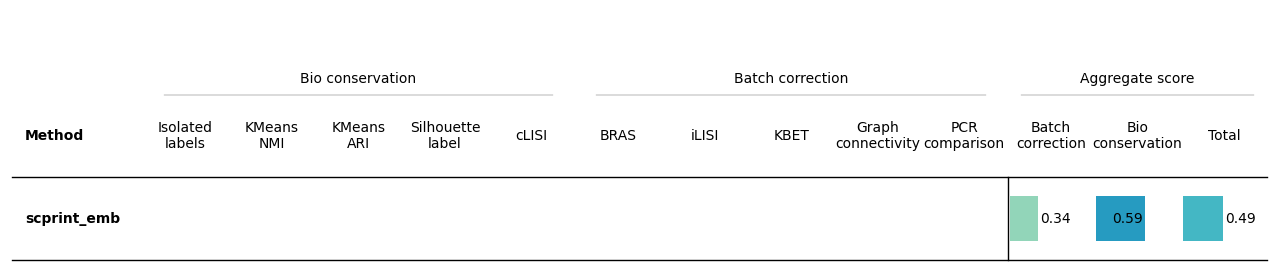

              Isolated labels        KMeans NMI        KMeans ARI  \
Embedding                                                           
scprint_emb          0.497266          0.596323          0.340988   
Metric Type  Bio conservation  Bio conservation  Bio conservation   

             Silhouette label             cLISI              BRAS  \
Embedding                                                           
scprint_emb          0.534989          0.991168          0.675147   
Metric Type  Bio conservation  Bio conservation  Batch correction   

                        iLISI              KBET Graph connectivity  \
Embedding                                                            
scprint_emb          0.018491          0.162472           0.855578   
Metric Type  Batch correction  Batch correction   Batch correction   

               PCR comparison Batch correction Bio conservation  \
Embedding                                                         
scprint_emb                 0  

In [ ]:
for name, url in list(datasets.items())[:]:
    print("doing ", name)
    if not os.path.exists(LOC + "temp/" + name + "_proc.h5ad"):
        adata = sc.read(LOC + name + ".h5ad", backup_url=url)
        preprocessor = Preprocessor(
            force_preprocess=True,
            skip_validate=True,
            # drop_non_primary=False,
            is_symbol=False,
            do_postp=metacell,
        )
        print("")
        adata = preprocessor(adata)
        if metacell:
            sc.pp.neighbors(adata, use_rep="X_pca")
        adata.write_h5ad(LOC + "temp/" + name + "_proc.h5ad")
    else:
        adata = sc.read(LOC + "temp/" + name + "_proc.h5ad")

    embed = Embedder(
        how="random expr",
        max_len=3200,
        num_workers=8,
        pred_embedding=["cell_type_ontology_term_id"],
        keep_all_labels_pred=True,
        doplot=False,
    )
    n_adata, _ = embed(model, adata)
    # cls regular
    loc = n_adata.obs.columns[n_adata.obs.columns.str.startswith("CL:")]
    pred = n_adata.obs.loc[:, loc]
    n_adata.obs["pred_cell_type_ontology_term_id"] = loc[pred.values.argmax(1)].values
    n_adata.obs["_ref_cls"] = loc[pred.values.argmax(1)].values
    metrics[name + "_ref_cls"] = compute_classification(
        n_adata,
        ["cell_type_ontology_term_id"],
        label_decoders=model.label_decoders,
        labels_hierarchy=model.labels_hierarchy,
    )
    n_adata_last = n_adata[n_adata.obs["donor_id"].isin(test[name])]
    metrics[name + "_cls"] = compute_classification(
        n_adata_last,
        ["cell_type_ontology_term_id"],
        label_decoders=model.label_decoders,
        labels_hierarchy=model.labels_hierarchy,
    )
    # cls ref
    for i in range(1):
        pred.iloc[:, :] = zero_shot_annotation_with_refinement(
            pred.values, n_adata, return_raw=True
        ).astype(np.float32)
    n_adata.obs["pred_cell_type_ontology_term_id"] = loc[
        zero_shot_annotation_with_refinement(pred.values, n_adata)
    ].values
    n_adata_last = n_adata[n_adata.obs["donor_id"].isin(test[name])]
    metrics[name + "_smooth_cls"] = compute_classification(
        n_adata_last,
        ["cell_type_ontology_term_id"],
        label_decoders=model.label_decoders,
        labels_hierarchy=model.labels_hierarchy,
    )
    # cls cluster
    if "seurat_clusters" in n_adata.obs:
        n_adata.obs["leiden"] = n_adata.obs["seurat_clusters"]
    if "leiden" not in n_adata.obs:
        sc.tl.leiden(n_adata, resolution=4.0)
    for i in n_adata.obs["leiden"].unique():
        n_adata.obs.loc[
            n_adata.obs["leiden"] == str(i), "pred_cell_type_ontology_term_id"
        ] = loc[pred[n_adata.obs["leiden"] == str(i)].values.sum(0).argsort()[::-1][0]]
    n_adata_last = n_adata[n_adata.obs["donor_id"].isin(test[name])]
    metrics[name + "_clust_cls"] = compute_classification(
        n_adata_last,
        ["cell_type_ontology_term_id"],
        label_decoders=model.label_decoders,
        labels_hierarchy=model.labels_hierarchy,
    )
    print(metrics)
    # batch correction
    # bm = Benchmarker(
    #    n_adata,
    #    batch_key="donor_id",  # "batch",  # batch, tech, assay_ontology_term_id, donor_id
    #    label_key="cell_type",  # celltype
    #    embedding_obsm_keys=["scprint_emb"],
    #    bio_conservation_metrics=BioConservation(),
    #    batch_correction_metrics=BatchCorrection(),
    #    n_jobs=10,
    # )
    # del n_adata, adata
    # bm.benchmark()
    # metrics[name + "_batch_corr"] = bm.get_results()
    # bm.plot_results_table(min_max_scale=False)
    # print(metrics[name + "_batch_corr"])

In [16]:
metrics

[autoreload of _virtualenv failed: Traceback (most recent call last):
  File "/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
  File "/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 580, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/pasteur/appa/homes/jkalfon/.local/share/uv/python/cpython-3.11.11-linux-x86_64-gnu/lib/python3.11/importlib/__init__.py", line 166, in reload
    spec = module.__spec__ = _bootstrap._find_spec(name, pkgpath, target)
                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1078, in _find_spec
  File "/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/_virtualenv.py", line 51, in find_spec
    if fullname in _DISTUTILS_PATCH and self.fullname is None:
            

[autoreload of zmq.backend failed: Traceback (most recent call last):
  File "/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
  File "/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 580, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/pasteur/appa/homes/jkalfon/.local/share/uv/python/cpython-3.11.11-linux-x86_64-gnu/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/zmq/backend/__init__.py", line 30, in <module>
    raise original_error from Non

In [ ]:
metrics = {
    "dkd_ref_cls": {
        "accuracy": 0.6050132734327139,
        "macro": 0.45858384601691754,
        "micro": 0.6050132734327139,
        "weighted": 0.5752358078815335,
    },
    "dkd_cls": {
        "accuracy": 0.5608184918529746,
        "macro": 0.49302410982269285,
        "micro": 0.5608184918529746,
        "weighted": 0.5370188034467204,
    },
    "dkd_smooth_cls": {
        "accuracy": 0.5941644562334217,
        "macro": 0.5355514243377841,
        "micro": 0.5941644562334217,
        "weighted": 0.5827613925424003,
    },
    "dkd_clust_cls": {
        "accuracy": 0.5985221674876847,
        "macro": 0.5,
        "micro": 0.5985221674876847,
        "weighted": 0.5985221674876847,
    },
    "gtex_v9_ref_cls": {
        "accuracy": 0.5690731903254497,
        "macro": 0.3561412506114705,
        "micro": 0.5690731903254497,
        "weighted": 0.5111263506144524,
    },
    "gtex_v9_cls": {
        "accuracy": 0.47340980187695514,
        "macro": 0.4771516389245344,
        "micro": 0.47340980187695514,
        "weighted": 0.4105919407683359,
    },
    "gtex_v9_smooth_cls": {
        "accuracy": 0.49930483142161974,
        "macro": 0.45026649672378827,
        "micro": 0.49930483142161974,
        "weighted": 0.46767738060420655,
    },
    "gtex_v9_clust_cls": {
        "accuracy": 0.49930483142161974,
        "macro": 0.45026649672378827,
        "micro": 0.49930483142161974,
        "weighted": 0.46767738060420655,
    },
    "hypomap_ref_cls": {
        "accuracy": 0.9331843865688121,
        "macro": 0.5582565920511067,
        "micro": 0.9331843865688121,
        "weighted": 0.9095025274318423,
    },
    "hypomap_cls": {
        "accuracy": 0.9817518248175182,
        "macro": 0.8017862483599127,
        "micro": 0.9817518248175182,
        "weighted": 0.9743770548339135,
    },
    "hypomap_smooth_cls": {
        "accuracy": 0.9908759124087592,
        "macro": 0.8529747502946833,
        "micro": 0.9908759124087592,
        "weighted": 0.986699566363855,
    },
    "hypomap_clust_cls": {
        "accuracy": 0.9963503649635036,
        "macro": 0.8811979101634128,
        "micro": 0.9963503649635036,
        "weighted": 0.9945824700566079,
    },
    "mouse_pancreas_atlas_ref_cls": {
        "accuracy": 0.9168991697845367,
        "macro": 0.736673219519387,
        "micro": 0.9168991697845367,
        "weighted": 0.8911321328642097,
    },
    "mouse_pancreas_atlas_cls": {
        "accuracy": 0.9222539985171062,
        "macro": 0.7317299769023702,
        "micro": 0.9222539985171062,
        "weighted": 0.8935278968505191,
    },
    "mouse_pancreas_atlas_smooth_cls": {
        "accuracy": 0.9653638385764219,
        "macro": 0.7529330761341159,
        "micro": 0.9653638385764219,
        "weighted": 0.9564964495219883,
    },
    "mouse_pancreas_atlas_clust_cls": {
        "accuracy": 0.9721427814850122,
        "macro": 0.7654463915196114,
        "micro": 0.9721427814850122,
        "weighted": 0.9663853668888627,
    },
}

In [ ]:
emb = pd.DataFrame(
    data={
        "Isolated labels": [
            0.621361,
            0.387139,
            0.520031,
            0.544676,
        ],
        "KMeans NMI": [
            0.655657,
            0.570249,
            0.61668,
            0.516657,
        ],
        "KMeans ARI": [
            0.439839,
            0.225424,
            0.280595,
            0.35364,
        ],
        "Silhouette label": [
            0.562681,
            0.61172,
            0.503856,
            0.547946,
        ],
        "cLISI": [
            0.99952,
            1.0,
            0.996694,
            0.992218,
        ],
        "BRAS": [
            0.739654,
            0.786443,
            0.803204,
            0.761943,
        ],
        "iLISI": [
            0.043682,
            0.0,
            0.077398,
            0.19466,
        ],
        "KBET": [
            0.239296,
            0.844529,
            0.353033,
            0.4047,
        ],
        "Graph connectivity": [
            0.854861,
            0.826488,
            0.704139,
            0.857564,
        ],
        "PCR comparison": [
            0,
            0.41701,
            0.096562,
            0.736278,
        ],
        "Batch correction": [
            0.375498,
            0.574894,
            0.406867,
            0.552538,
        ],
        "Bio conservation": [
            0.655811,
            0.558906,
            0.583571,
            0.591027,
        ],
        "Total": [
            0.543686,
            0.565301,
            0.51289,
            0.575631,
        ],
    },
    index=["mouse_pancreas_atlas", "hypomap", "gtex_v9", "dkd"],
)

SyntaxError: invalid syntax (387565505.py, line 8)